In [2]:
import os
import pandas as pd
import numpy as np
import mlflow
from mlflow.tracking import MlflowClient
from datetime import datetime
import re

In [3]:
# Import plotting libraries and StyleManager and create the output directory to store images
#--------------------------------------------
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
# Add parent directory to path to import style module
# Try adding parent directory if style module not found
try:
    from style.style_manager import StyleManager
except ImportError:
    # If import fails, add parent directory to path
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == 'notebooks':
        project_root = os.path.dirname(current_dir)
        sys.path.insert(0, project_root)
    else:
        # Try going up one level
        parent_dir = os.path.dirname(current_dir)
        sys.path.insert(0, parent_dir)
    from style.style_manager import StyleManager


# Determine project root and initialize style with correct paths
current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebooks':
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

mplstyle_path = os.path.join(project_root, 'style', 'thesis_style.mplstyle')
sm = StyleManager(mplstyle_path=mplstyle_path)
sm.activate()

# Create output directory if it doesn't exist
output_dir = "images/image_analysis"
os.makedirs(output_dir, exist_ok=True)

# HELPERS

In [43]:
def _add_full_datetime(df: pd.DataFrame, date_col: str, time_col: str) -> pd.DataFrame:
    """
    Internal helper function to create a sortable datetime column.
    
    WARNING: Assumes 'date_col' is in 'mm-dd' format and will use the
    current year for conversion.
    """
    working_df = df.copy()
    datetime_str = working_df[date_col] + ' ' + working_df[time_col]
    
    working_df['full_datetime'] = pd.to_datetime(datetime_str, 
                                                 format='%m-%d %H:%M:%S', 
                                                 errors='coerce')

    if working_df['full_datetime'].isnull().any():
        dropped_count = working_df['full_datetime'].isnull().sum()
        print(f"Warning: Dropped {dropped_count} rows due to unparseable date/time strings.")
        working_df = working_df.dropna(subset=['full_datetime'])
        
    return working_df


def pick_newest_run_per_arch(df: pd.DataFrame, 
                             arch_name_list: list[str],
                             arch_name_col: str = 'model_name', 
                             date_col: str = 'creation_date', 
                             time_col: str = 'creation_time',
                             is_pretrained: bool = False) -> pd.DataFrame:
    """
    Filters for a list of architectures (CASE-INSENSITIVE) and
    selects the single newest run for EACH.

    If `is_pretrained` is True, it groups by both architecture and
    'pretrained_weights' to select the newest run for each unique
    combination.

    Args:
        df (pd.DataFrame): The input DataFrame.
        arch_name_list (list[str]): The list of architecture names to filter for.
        arch_name_col (str): The name of the architecture column.
        date_col (str): The name of the date column.
        time_col (str): The name of the time column.
        is_pretrained (bool): If True, adds 'pretrained_weights' to the
                              grouping key for uniqueness.

    Returns:
        pd.DataFrame: A DataFrame containing only the single newest run
                      for each architecture or arch-weight combination.
    """
    
    # 1. Create a lowercase version of the target list for comparison.
    lower_arch_list = [name.lower() for name in arch_name_list]
    
    # 2. Create a working copy and a temporary lowercase column.
    #    This column will be used for filtering and grouping.
    working_df = df.copy()
    working_df['_temp_lower_arch'] = working_df[arch_name_col].str.lower()

    # 3. Filter using the lowercase list and lowercase column.
    filtered_df = working_df[working_df['_temp_lower_arch'].isin(lower_arch_list)]
    
    if filtered_df.empty:
        print(f"No data found for any architectures in the list: {arch_name_list}")
        return pd.DataFrame(columns=df.columns) # Return empty DF

    # 4. Use the helper function to create the 'full_datetime' column.
    with_datetime_df = _add_full_datetime(filtered_df, date_col, time_col)
    # 5. Sort the DataFrame by the new datetime column (newest first).
    sorted_df = with_datetime_df.sort_values(by='full_datetime', ascending=False)

    # 6. Group by the *temporary lowercase column* and keep the first.
    #    If pretrained, also group by the pretraining weights.
    grouping_keys = ['_temp_lower_arch']
    if is_pretrained:
        if 'pretrained_weights' in sorted_df.columns:
            grouping_keys.append('pretrained_weights')
        else:
            print("Warning: is_pretrained=True but 'pretrained_weights' column not found.")

    newest_runs_df = sorted_df.drop_duplicates(subset=grouping_keys, keep='first')
    # 7. Return the final DataFrame, dropping the temporary helper columns.
    return newest_runs_df.drop(columns=['full_datetime', '_temp_lower_arch'])

# LOAD MLFLOW DATA

In [44]:
# Configure MLflow client to read local experiment metadata

# Adjust if your mlruns is elsewhere
MLRUNS_DIR_CANDIDATES = [
    # "/home/zano/Documents/TESI/FOLDER_CINECA/notebooks/mlruns",
    "/home/zano/Documents/TESI/FOLDER_CINECA/mlruns"
]

# def pick_existing_dir(candidates):
#     for d in candidates:
#         if os.path.isdir(d):
#             return d
#     raise FileNotFoundError(f"No mlruns directory found in: {candidates}")

mlruns_dir = MLRUNS_DIR_CANDIDATES[0] #pick_existing_dir(MLRUNS_DIR_CANDIDATES)
tracking_uri = f"file://{mlruns_dir}"
mlflow.set_tracking_uri(tracking_uri)
client = MlflowClient()

experiments = client.search_experiments() 

# --- Configuration for Filtering ---
EXCLUDE_PARAM_KEYS = {"seed", "random_state"}
EXCLUDE_PARAM_PREFIXES = ["debug_", "temp_"]
EXCLUDE_PARAM_REGEX = [r"^unused_.*"]

# --CONFIG FOR METRIC FILTERING
EXCLUDE_METRIC_KEYS = {"train_loss_step", "val_loss_step"}
EXCLUDE_METRIC_PREFIXES = ["raw_", "tmp_"]
EXCLUDE_METRIC_REGEX = [r"val_fold",r".*loss*"]

# --- Data Loading ---
rows = []
for exp in experiments:
    exp_id = exp.experiment_id
    runs = client.search_runs([exp_id], max_results=1000)
    for run in runs:
        info = run.info
        data = run.data
        params = {f"param.{k}": v for k, v in data.params.items()}
        metrics = {f"metric.{k}": v for k, v in data.metrics.items()}
        tags = {f"tag.{k}": v for k, v in data.tags.items()}
        row = {
            "experiment_id": exp_id,
            "experiment_name": exp.name,
            "run_id": info.run_id,
            "run_name": data.tags.get("mlflow.runName", ""),
            "artifact_uri": info.artifact_uri,
        }
        row.update(params)
        row.update(metrics)
        row.update(tags)
        rows.append(row)

# --- DataFrame Creation and Filtering ---
df = pd.DataFrame(rows).sort_values(["experiment_name"])
print(df.shape)
print(df.info())
display(df)

(292, 212)
<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, 0 to 278
Columns: 212 entries, experiment_id to metric.test_auc_fold_0
dtypes: float64(153), object(59)
memory usage: 485.9+ KB
None


experiment_id                                 experiment_name  \
0    255820635737005714           ABLATION_STUDIES_MSA_vs_PD_supervised   
1    255820635737005714           ABLATION_STUDIES_MSA_vs_PD_supervised   
2    255820635737005714           ABLATION_STUDIES_MSA_vs_PD_supervised   
3    255820635737005714           ABLATION_STUDIES_MSA_vs_PD_supervised   
4    255820635737005714           ABLATION_STUDIES_MSA_vs_PD_supervised   
..                  ...                                             ...   
245  650492548885392028        pretrained_subslice_MSA_vs_PD_supervised   
246  650492548885392028        pretrained_subslice_MSA_vs_PD_supervised   
235  650492548885392028        pretrained_subslice_MSA_vs_PD_supervised   
233  650492548885392028        pretrained_subslice_MSA_vs_PD_supervised   
278  339740412901839325  supervised_learning_4c_MSA_vs_PD_4c_supervised   

                               run_id  \
0    a719486616374e3eb7b2eb4554b6cc64   
1    f6ff89e8356e460ea146917a9fc38623   
2    746482d45fff46c295349c8ff182084a   
3    8f421b6a813c4c74a59cbbaebdfefa79   
4    895eb93af43f4faab0711fcc6d3df21f   
..                                ...   
245  f8bc44c3a3bb42c7a050e4fb5daa593d   
246  d1413c9a42af466e997d0de502529d5b   
235  02363acdf9754a36bd77e12cb6d9d672   
233  332f71be5f8c47a5ae2308f59937f46f   
278  07c96fac5f204147953cf695b1f61539   

                                              run_name  \
0            Resnet18_oversamp_monai_11-06_at:02-01-40   
1            Resnet18_oversamp_monai_11-06_at:00-55-55   
2            Resnet18_oversamp_monai_11-05_at:23-31-13   
3         Densenet121_oversamp_monai_11-05_at:20-45-02   
4         Densenet121_oversamp_monai_11-05_at:19-55-33   
..                                                 ...   
245  Densenet121_oversamp_TL_pretrained:imagenet-mi...   
246  Densenet121_oversamp_TL_pretrained:microscopyn...   
235  Densenet169_oversamp_TL_pretrained:torchvision...   
233  Densenet121_oversamp_TL_pretrained:microscopyn...   
278  Resnet50_oversamp_monai_color_transforms:False...   

                                          artifact_uri param.use_crop  \
0    file:///home/zano/Documents/TESI/FOLDER_CINECA...          False   
1    file:///home/zano/Documents/TESI/FOLDER_CINECA...          False   
2    file:///home/zano/Documents/TESI/FOLDER_CINECA...          False   
3    file:///home/zano/Documents/TESI/FOLDER_CINECA...          False   
4    file:///home/zano/Documents/TESI/FOLDER_CINECA...          False   
..                                                 ...            ...   
245  file:///leonardo_work/pMI24_EleBr_1/lzanotto/F...            NaN   
246  file:///leonardo_work/pMI24_EleBr_1/lzanotto/F...            NaN   
235  file:///leonardo_work/pMI24_EleBr_1/lzanotto/F...            NaN   
233  file:///leonardo_work/pMI24_EleBr_1/lzanotto/F...            NaN   
278  file:///leonardo_work/pMI24_EleBr_1/lzanotto/F...            NaN   

    param.ablated_channel                        param.test_pat_ids_per_fold  \
0                       2  {0: array(['5717', '5767', '5954', '5978', '60...   
1                       1  {0: array(['5717', '5767', '5954', '5978', '60...   
2                       0  {0: array(['5717', '5767', '5954', '5978', '60...   
3                       3  {0: array(['5717', '5767', '5954', '5978', '60...   
4                       2  {0: array(['5717', '5767', '5954', '5978', '60...   
..                    ...                                                ...   
245                   NaN                                                NaN   
246                   NaN                                                NaN   
235                   NaN                                                NaN   
233                   NaN                                                NaN   
278                   NaN                                                NaN   

    param.crop_percentage param.dropout_rate param.ablation_iteration  \
0       

In [45]:
# Normalize empty values and compute column retention threshold
# Replace empty strings '' with the standard np.nan
df = df.replace('', np.nan)

import math # We'll need this to round up

# 1. Get the total number of rows (runs)
total_rows = len(df)

# 2. Calculate the threshold: 5% of total rows.
# This is the minimum *non-missing* values a column must have to be kept.
# We use math.ceil() to round up. e.g., if 5% is 10.8, we need at least 11 values.
min_non_nan_count = math.ceil(total_rows * 0.06)

print(f"Total rows: {total_rows}")
print(f"Columns will be KEPT if they have at least {min_non_nan_count} non-NaN values.")

# 3. Apply the drop
# Keep track of columns before for comparison
cols_before_drop = set(df.columns)

# axis='columns' applies this to columns, not rows
# thresh=... tells pandas the minimum *non-NaN* count to keep the column
df_cleaned = df.dropna(axis='columns', thresh=min_non_nan_count)
cols_after_drop = set(df.columns)
dropped_cols = cols_before_drop - cols_after_drop

print(f"\nDropped {len(dropped_cols)} columns with >95% missing values.")
if dropped_cols:
    print(f"Columns dropped: {list(dropped_cols)}")

# Explicitly list the correct columns to drop as a Python list of strings.
cols_to_drop = [
    "tag.mlflow.runName",
    "tag.mlflow.source.git.commit",
    "tag.mlflow.source.name",
    "tag.mlflow.source.type",
    "tag.mlflow.user",
    "tag.mlflow.log-model.history",
    "param.fine_tuning",
    "param.use_lr_discovery"
]

df = df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns: {cols_to_drop}")
print(f"New DataFrame shape: {df.shape}")
# Drop parameter and metric columns flagged by exclusion rules

# Drop parameter and metric columns flagged by exclusion rules
param_cols_to_drop = []
for col in df.columns:
    if col.startswith("param."):
        param_name = col.replace("param.", "", 1)
        if (param_name in EXCLUDE_PARAM_KEYS or
            any(param_name.startswith(p) for p in EXCLUDE_PARAM_PREFIXES) or
            any(re.search(rx, param_name) for rx in EXCLUDE_PARAM_REGEX)):
            param_cols_to_drop.append(col)

metric_cols_to_drop = []
for col in df.columns:
    if col.startswith("metric."):
        metric_name = col.replace("metric.", "", 1)
        if (metric_name in EXCLUDE_METRIC_KEYS or
            any(metric_name.startswith(p) for p in EXCLUDE_METRIC_PREFIXES) or
            any(re.search(rx, metric_name) for rx in EXCLUDE_METRIC_REGEX)):
            metric_cols_to_drop.append(col)

cols_to_drop = param_cols_to_drop + metric_cols_to_drop
df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped {len(cols_to_drop)} parameter/metric columns based on exclusion rules.")
print(df.shape)

# #drop columns with loss in their name
# loss_cols = [col for col in df.columns if 'loss' in col.lower()]
# df.drop(columns=loss_cols, inplace=True, errors='ignore')
# print(f"Dropped {len(loss_cols)} columns containing 'loss': {loss_cols}")
# print(df.shape)

print(f"After filtering, {len(df)} runs remain with experiment names starting with 'SL' or 'pretrained'")

# Filter runs to the target experiment families before analysis

# Create a boolean mask for rows to keep
# keep only rows with experiment name starting with SL, pretrained, or DS
mask = (df['experiment_name'].str.startswith('SL', na=False) |
        df['experiment_name'].str.startswith('pretrained', na=False) |
        df['experiment_name'].str.startswith('DS', na=False))

# Apply the filter
n_cols_before = len(df.columns)
df = df[mask]
n_cols_after = len(df.columns)
print(f"Dropped {n_cols_before - n_cols_after} columns")
print(df.shape)

# Remove fold-specific metrics to focus on aggregated results
import re

# 1. Compile a regex pattern to find 'fold_' + one or more digits
pattern = re.compile(r'fold_\d+')
# 2. Build a list of columns where the pattern is found ANYWHERE
columns_to_drop = [col for col in df.columns if pattern.search(col)]
df = df.drop(columns=columns_to_drop)
print(f"Dropping {len(columns_to_drop)} columns containing 'fold': {columns_to_drop}")

Total rows: 292
Columns will be KEPT if they have at least 18 non-NaN values.

Dropped 0 columns with >95% missing values.
Dropped 8 columns: ['tag.mlflow.runName', 'tag.mlflow.source.git.commit', 'tag.mlflow.source.name', 'tag.mlflow.source.type', 'tag.mlflow.user', 'tag.mlflow.log-model.history', 'param.fine_tuning', 'param.use_lr_discovery']
New DataFrame shape: (292, 204)
Dropped 82 parameter/metric columns based on exclusion rules.
(292, 122)
After filtering, 292 runs remain with experiment names starting with 'SL' or 'pretrained'
Dropped 0 columns
(280, 122)
Dropping 32 columns containing 'fold': ['metric.test_recall_fold_4', 'metric.test_precision_fold_0', 'metric.test_recall_fold_1', 'metric.test_mcc_fold_0', 'metric.test_recall_fold_6', 'metric.test_auc_fold_3', 'metric.test_recall_fold_0', 'metric.test_auc_fold_4', 'metric.test_precision_fold_3', 'metric.test_mcc_fold_7', 'metric.test_auc_fold_2', 'metric.test_mcc_fold_3', 'metric.test_precision_fold_4', 'metric.test_mcc_fold

## ADDING NEW COLUMNS

In [46]:
import ast

def fold0(x):
    try:
        if isinstance(x, str):
            x = ast.literal_eval(x)
        return (x or {}).get(0, (x or {}).get('0'))
    except Exception:
        return None

test_lt25 = pd.to_numeric(df.get('param.test_counts'), errors='coerce').lt(25)
val0_lt25 = pd.to_numeric(df.get('param.val_counts', pd.Series(index=df.index)).apply(fold0),
                          errors='coerce').lt(25)

df['dataset'] = np.where(test_lt25 | val0_lt25, 'DS1', 'DS2')

check = df.loc[test_lt25 | val0_lt25, ['param.test_counts', 'param.val_counts', 'dataset']].head(10)
display(check)

# 4) Rule consistency: all rows meeting the rule must be DS1
assert (df.loc[test_lt25 | val0_lt25, 'dataset'] == 'DS1').all(), "Rule violation: DS1 expected"

# 5) Optional: rows labeled DS2 should not meet either condition
violations = df.loc[(df['dataset'] == 'DS2') & (test_lt25 | val0_lt25),
                    ['param.test_counts', 'param.val_counts', 'dataset']]
display(violations)
assert violations.empty, "Found DS2 rows that meet DS1 rule"

param.test_counts  \
121  {'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...   
122                                                 14   
123                                                 14   
124                                                 14   
125                                                 14   
126  {'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...   
127                                                 14   
128                                                 14   
129                                                 14   
130                                                 14   

                                      param.val_counts dataset  
121  {0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...     DS1  
122  {0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...     DS1  
123  {0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...     DS1  
124  {0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...     DS1  
125  {0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...     DS1  
126  {0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...     DS1  
127  {0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: ...     DS1  
128  {0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...     DS1  
129  {0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...     DS1  
130  {0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...     DS1

Empty DataFrame
Columns: [param.test_counts, param.val_counts, dataset]
Index: []

In [47]:
# Infer num_channels using logged params with an experiment-based fallback

# Step 1: Create the fallback values for all rows based on the original inference logic.
print("Inferring fallback 'num_channels' for all rows...")
condition_3c = df['experiment_name'].str.contains("3c", na=False)

if 'param.transfer_learning' in df.columns:
    condition_tl = (df['param.transfer_learning'] == 'True')
else:
    condition_tl = pd.Series([False] * len(df), index=df.index)
    print("Warning: 'param.transfer_learning' column not found for fallback. Assuming False.")

is_3_channels = condition_3c | condition_tl
fallback_channels = pd.Series(np.where(is_3_channels, 3, 4), index=df.index)

# Step 2: Use 'param.num_channels' as the priority source, and fill any missing values with the fallback.
if 'param.num_channels' in df.columns:
    print("Found 'param.num_channels'. Using it as priority, with inference as fallback.")
    # Convert the parameter column to numeric, forcing errors into NaN (Not a Number)
    priority_channels = pd.to_numeric(df['param.num_channels'], errors='coerce')
    # Use the priority values, and for any NaNs, fill with the corresponding value from the fallback Series.
    df['num_channels'] = priority_channels.fillna(fallback_channels)
else:
    print("Did not find 'param.num_channels'. Creating 'num_channels' based on inference only.")
    df['num_channels'] = fallback_channels

# Ensure the final column is an integer type, as channel counts are whole numbers.
df['num_channels'] = df['num_channels'].astype(int)
print("Added 'num_channels' column with priority-fallback logic.")

Inferring fallback 'num_channels' for all rows...
Found 'param.num_channels'. Using it as priority, with inference as fallback.
Added 'num_channels' column with priority-fallback logic.


In [48]:
# Create class labels and correct mislogged color transform flags
# Create a condition to check if the experiment name contains the specific substring
condition_msap = df['experiment_name'].str.contains("_MSA-P_vs_PD_", na=False)

# Use np.where to assign the value based on the condition
df['classes'] = np.where(condition_msap, 'MSA-P vs PD', 'MSA vs PD')
print("Added 'classes' column based on experiment name.")

Added 'classes' column based on experiment name.


In [49]:
# --- Correct param.color_transforms based on run_name due to error in logging code---
if 'run_name' in df.columns and 'param.color_transforms' in df.columns:
    # Create a boolean mask for rows where run_name contains the specific string
    color_transform_mask = df['run_name'].str.contains('_color_transforms:True_', na=False)

    # Update the 'param.color_transforms' column to True where the mask is True
    df.loc[color_transform_mask, 'param.color_transforms'] = 'True'
    print("Updated 'param.color_transforms' based on 'run_name' content.")

# --- Create, Display, and Save Final Merged Table ---
# The main 'df' DataFrame now contains all info. We will reorder it for better readability.
# Define the desired column order, including the new 'classes' column
id_cols = ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels']
tag_cols = sorted([c for c in df.columns if c.startswith("tag.")])
# Exclude the original param.num_channels from the list of param columns to avoid redundancy
param_cols = sorted([
    c for c in df.columns# def pick_existing_dir(candidates):
#     for d in candidates:
#         if os.path.isdir(d):
#             return d
#     raise FileNotFoundError(f"No mlruns directory found in: {candidates}")
    if c.startswith("param.") and c != 'param.num_channels'
])
metric_cols = sorted([c for c in df.columns if c.startswith("metric.")])

# Construct the final list of columns, ensuring they exist in the DataFrame
final_cols_order = [col for col in id_cols if col in df.columns] + \
                   [col for col in param_cols if col in df.columns] + \
                   [col for col in metric_cols if col in df.columns]+\
                    [col for col in tag_cols if col in df.columns]
# Create the final, reordered dataframe
results_df = df[final_cols_order].copy()

# Replace 'torchvision' with 'imagenet' in the 'param.pretrained' column
if 'param.pretrained' in results_df.columns:
    results_df['param.pretrained'] = results_df['param.pretrained'].replace('torchvision', 'imagenet')
    print("Replaced 'torchvision' with 'imagenet' in 'param.pretrained' column.")

pd.set_option("display.max_columns", 200)
print("\n--- Final Merged Results Table ---")
# Use display() if in a notebook environment, otherwise print()
try:
    display(results_df)
except NameError:
    print(results_df)


Updated 'param.color_transforms' based on 'run_name' content.
Replaced 'torchvision' with 'imagenet' in 'param.pretrained' column.

--- Final Merged Results Table ---


experiment_name  \
121             DS1_3c_MSA-P_vs_PD_supervised   
122             DS1_3c_MSA-P_vs_PD_supervised   
123             DS1_3c_MSA-P_vs_PD_supervised   
124             DS1_3c_MSA-P_vs_PD_supervised   
125             DS1_3c_MSA-P_vs_PD_supervised   
..                                        ...   
244  pretrained_subslice_MSA_vs_PD_supervised   
245  pretrained_subslice_MSA_vs_PD_supervised   
246  pretrained_subslice_MSA_vs_PD_supervised   
235  pretrained_subslice_MSA_vs_PD_supervised   
233  pretrained_subslice_MSA_vs_PD_supervised   

                                              run_name dataset      classes  \
121                        ViT_monai_10-30_at:04-28-16     DS1  MSA-P vs PD   
122    Resnet18_oversamp_torchvision_10-30_at:03-51-45     DS1  MSA-P vs PD   
123  Densenet169_oversamp_torchvision_10-30_at:03-2...     DS1  MSA-P vs PD   
124  Densenet121_oversamp_torchvision_10-30_at:02-2...     DS1  MSA-P vs PD   
125  Densenet121_oversamp_torchvision_10-30_at:00-5...     DS1  MSA-P vs PD   
..                                                 ...     ...          ...   
244  Densenet169_oversamp_TL_pretrained:microscopyn...     DS2    MSA vs PD   
245  Densenet121_oversamp_TL_pretrained:imagenet-mi...     DS2    MSA vs PD   
246  Densenet121_oversamp_TL_pretrained:microscopyn...     DS2    MSA vs PD   
235  Densenet169_oversamp_TL_pretrained:torchvision...     DS2    MSA vs PD   
233  Densenet121_oversamp_TL_pretrained:microscopyn...     DS2    MSA vs PD   

     num_channels param.ablated_channel param.ablated_channel_idx  \
121             3                   NaN                       NaN   
122             3                   NaN                       NaN   
123             3                   NaN                       NaN   
124             3                   NaN                       NaN   
125             3                   NaN                       NaN   
..            ...                   ...                       ...   
244             3                   NaN                       NaN   
245             3                   NaN                       NaN   
246             3                   NaN                       NaN   
235             3                   NaN                       NaN   
233             3                   NaN                       NaN   

    param.ablation_iteration param.ablation_study param.batch_size  \
121                      NaN                  NaN               32   
122                      NaN                  NaN               32   
123                      NaN                  NaN               32   
124                      NaN                  NaN               32   
125                      NaN                  NaN               32   
..                       ...                  ...              ...   
244                      NaN                  NaN               32   
245                      NaN                  NaN               32   
246                      NaN                  NaN               32   
235                      NaN                  NaN               32   
233                      NaN                  NaN               32   

    param.best_fold_idx           param.best_lr param.color_transforms  \
121                   0  0.00012207764786954147                    NaN   
122                   1  0.00012207764786954147                    NaN   
123                   1  0.00012207764786954147                    NaN   
124                   1  0.00012207764786954147                    NaN   
125                   6  0.00012207764786954147                    NaN   
..                  ...                     ...                    ...   
244                 NaN                     NaN                  False   
245                 NaN                     NaN                  False   
246                 NaN                     NaN                  False   
235                 NaN                     NaN                   True   
233     

In [50]:
import numpy as np
import pandas as pd # Make sure pandas and numpy are imported

print("\n--- Filling missing formatted tag values ---")

# The 8 tag columns you want to fill
tag_cols_to_fill = [
    "tag.patient_major_bal_acc_formatted",
    "tag.patient_major_mcc_formatted",
    "tag.patient_major_precision_formatted",
    "tag.patient_major_recall_formatted",
    "tag.patient_soft_bal_acc_formatted",
    "tag.patient_soft_mcc_formatted",
    "tag.patient_soft_precision_formatted",
    "tag.patient_soft_recall_formatted"
]

# We are modifying results_df, which is a .copy()
# so we are safe from SettingWithCopyWarning
df_to_update = results_df 

# Loop through each of the 8 tag columns
for tag_col in tag_cols_to_fill:
    
    # 1. Derive the mean/std column names from the tag name
    # "tag.patient_major_bal_acc_formatted" -> "patient_major_bal_acc"
    base_name = tag_col.replace('tag.', '').replace('_formatted', '')
    
    # -> "metric.mean_patient_major_bal_acc"
    mean_col = f"metric.mean_{base_name}" 
    # -> "metric.std_patient_major_bal_acc"
    std_col = f"metric.std_{base_name}"
    
    # 2. Check if these source columns actually exist in our DataFrame
    if mean_col in df_to_update.columns and std_col in df_to_update.columns:
        
        # 3. Create a mask to find the rows to fill
        # We want rows where:
        #   - The tag column IS missing (NaN)
        #   - The mean_col IS NOT missing
        #   - The std_col IS NOT missing
        mask = (
            df_to_update[tag_col].isna() & #se la colonna tag è vuota
            df_to_update[mean_col].notna() & #se la colonna metric mean corrispondente non è vuota
            df_to_update[std_col].notna() #se la colonna metric std corrispondente non è vuota
        )
        
        # If we found any rows to fill...
        if mask.sum() > 0:
            
            # 4. Format the strings for just those rows
            # We use .loc[mask] to only select the rows we care about
            
            # Get the mean/std values, round to 3 decimals, convert to string
            mean_values = df_to_update.loc[mask, mean_col].round(3).astype(str)
            std_values = df_to_update.loc[mask, std_col].round(3).astype(str)
            
            # Combine them into the "mean ± std" format
            formatted_strings = mean_values + " ± " + std_values
            
            # 5. Use .loc to assign these new strings back to the DataFrame
            # This is the correct, warning-free way to do it.
            df_to_update.loc[mask, tag_col] = formatted_strings
            
            print(f"Filled {mask.sum()} missing values in {tag_col}")
    else:
        print(f"Skipped {tag_col}: Source columns not found.")

print("--- Finished filling tags ---")

# --- Now you can proceed to save ---
# (You might want to display the head to check)
print("\nChecking the first few rows of the filled tags:")
try:
    display(results_df[tag_cols_to_fill].head())
except NameError:
    print(results_df[tag_cols_to_fill].head())



--- Filling missing formatted tag values ---
Filled 43 missing values in tag.patient_major_bal_acc_formatted
Filled 42 missing values in tag.patient_major_mcc_formatted
Filled 42 missing values in tag.patient_major_precision_formatted
Filled 42 missing values in tag.patient_major_recall_formatted
Filled 43 missing values in tag.patient_soft_bal_acc_formatted
Filled 42 missing values in tag.patient_soft_mcc_formatted
Filled 42 missing values in tag.patient_soft_precision_formatted
Filled 42 missing values in tag.patient_soft_recall_formatted
--- Finished filling tags ---

Checking the first few rows of the filled tags:


tag.patient_major_bal_acc_formatted tag.patient_major_mcc_formatted  \
121                       0.750 ± 0.217                   0.527 ± 0.437   
122                       0.784 ± 0.152                   0.579 ± 0.304   
123                       0.778 ± 0.153                   0.579 ± 0.293   
124                       0.750 ± 0.140                   0.520 ± 0.283   
125                       0.609 ± 0.170                   0.241 ± 0.350   

    tag.patient_major_precision_formatted tag.patient_major_recall_formatted  \
121                         0.792 ± 0.250                      0.719 ± 0.263   
122                         0.775 ± 0.190                      0.844 ± 0.121   
123                         0.747 ± 0.212                      0.875 ± 0.125   
124                         0.646 ± 0.272                      0.781 ± 0.317   
125                         0.325 ± 0.435                      0.281 ± 0.423   

    tag.patient_soft_bal_acc_formatted tag.patient_soft_mcc_formatted  \
121                      0.750 ± 0.225                  0.529 ± 0.453   
122                      0.725 ± 0.176                  0.460 ± 0.356   
123                      0.713 ± 0.149                  0.443 ± 0.309   
124                      0.734 ± 0.159                  0.484 ± 0.321   
125                      0.562 ± 0.088                  0.148 ± 0.204   

    tag.patient_soft_precision_formatted tag.patient_soft_recall_formatted  
121                        0.748 ± 0.244                     0.781 ± 0.291  
122                        0.677 ± 0.166                     0.812 ± 0.207  
123                        0.642 ± 0.155                     0.812 ± 0.242  
124                        0.633 ± 0.273                     0.750 ± 0.331  
125                        0.283 ± 0.381                     0.219 ± 0.341

In [51]:
import numpy as np # Make sure np is imported

df_to_update = results_df

# 1. Define the base names for the 'test' metrics
base_metric_names = [
    'test_accuracy',
    'test_auc',
    'test_balanced_acc',
    'test_f1',
    'test_mcc',
    'test_precision',
    'test_recall'
]

print("\n--- Creating formatted 'test' metric columns (Corrected Version) ---")

for col in base_metric_names:
    
    mean_col_name = f"metric.mean_{col}"
    std_col_name = f"metric.std_{col}"
    
    # Let's create the new column name (I'll add the 'metric.' prefix 
    # to be consistent with your other columns, but f"{col}_formatted" also works!)
    new_formatted_col = f"metric.{col}_formatted"
    
    # --- THIS IS THE ROBUST PATTERN ---
    # 1. Create the new column and fill it with NaN
    # This ensures it exists, even if there's no data.
    df_to_update[new_formatted_col] = np.nan
    
    # 2. Check if source columns exist
    if mean_col_name in df_to_update.columns and std_col_name in df_to_update.columns:
        
        # 3. Create the mask
        mask = (
            df_to_update[mean_col_name].notna() &
            df_to_update[std_col_name].notna()
        )
        
        # 4. Check if there's anything to fill
        if mask.sum() > 0: #if both mean and std are not missing
            
            # **FIX 1:** Use the correct variable names
            mean_values = df_to_update.loc[mask, mean_col_name].round(3).astype(str)
            std_values = df_to_update.loc[mask, std_col_name].round(3).astype(str)
        
            # **FIX 2:** Assign the new values *only* to the masked rows
            # in the new column using .loc
            df_to_update.loc[mask, new_formatted_col] = mean_values + " ± " + std_values
            
            print(f"Created {new_formatted_col} with {mask.sum()} values.")
    else:
        print(f"Skipped {new_formatted_col}: Source columns not found.")

print("--- Finished creating 'test' formatted metrics ---")


--- Creating formatted 'test' metric columns (Corrected Version) ---
Created metric.test_accuracy_formatted with 280 values.
Created metric.test_auc_formatted with 280 values.
Created metric.test_balanced_acc_formatted with 280 values.
Created metric.test_f1_formatted with 280 values.
Created metric.test_mcc_formatted with 280 values.
Created metric.test_precision_formatted with 280 values.
Created metric.test_recall_formatted with 280 values.
--- Finished creating 'test' formatted metrics ---


/tmp/ipykernel_211839/279946399.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0.735 ± 0.163' '0.746 ± 0.16' '0.713 ± 0.135' '0.705 ± 0.112'
 '0.58 ± 0.12' '0.745 ± 0.16' '0.696 ± 0.146' '0.682 ± 0.163'
 '0.667 ± 0.189' '0.676 ± 0.121' '0.713 ± 0.162' '0.721 ± 0.128'
 '0.679 ± 0.098' '0.693 ± 0.124' '0.616 ± 0.139' '0.541 ± 0.147'
 '0.626 ± 0.106' '0.621 ± 0.116' '0.75 ± 0.139' '0.773 ± 0.124'
 '0.686 ± 0.128' '0.783 ± 0.056' '0.754 ± 0.118' '0.705 ± 0.08'
 '0.779 ± 0.157' '0.742 ± 0.137' '0.733 ± 0.134' '0.776 ± 0.15'
 '0.76 ± 0.084' '0.606 ± 0.091' '0.661 ± 0.124' '0.665 ± 0.15'
 '0.663 ± 0.132' '0.665 ± 0.141' '0.669 ± 0.13' '0.64 ± 0.092'
 '0.663 ± 0.117' '0.676 ± 0.077' '0.634 ± 0.169' '0.609 ± 0.129'
 '0.576 ± 0.12' '0.635 ± 0.133' '0.576 ± 0.115' '0.648 ± 0.152'
 '0.688 ± 0.155' '0.616 ± 0.159' '0.654 ± 0.144' '0.688 ± 0.131'
 '0.639 ± 0.102' '0.672 ± 0.089' '0.612 ± 0.147' '0.501 ± 0.109'

In [52]:
results_df.columns.tolist()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'param.ablated_channel',
 'param.ablated_channel_idx',
 'param.ablation_iteration',
 'param.ablation_study',
 'param.batch_size',
 'param.best_fold_idx',
 'param.best_lr',
 'param.color_transforms',
 'param.creation_date',
 'param.creation_time',
 'param.crop_percentage',
 'param.dropout_rate',
 'param.epochs',
 'param.freezed_layer_index',
 'param.intensity_augmentation_preset',
 'param.lr_discovery_folds',
 'param.lr_discovery_method',
 'param.mixup_alpha',
 'param.model_library',
 'param.model_name',
 'param.n_folds',
 'param.optimizer_name',
 'param.pretrained',
 'param.test_counts',
 'param.test_pat_ids_for_best_fold',
 'param.test_pat_ids_per_fold',
 'param.total_channels_available',
 'param.total_params',
 'param.train_counts',
 'param.trainable_params',
 'param.transfer_learning',
 'param.use_crop',
 'param.val_counts',
 'param.weight_decay',
 'metric.exec_time_min',
 'metric.mean_patient_major_bal_acc',

## CLEANING

In [53]:

# REMOVE COLUMNS WHICH START WITH metric. AND END WITH formatted BECAUSE THERE ARE ALREADY IN PARAM
mask = ~(results_df.columns.str.startswith('metric.') & 
         results_df.columns.str.endswith('formatted'))
results_df = results_df.loc[:, mask]
results_df.columns.tolist()
# # drop duplicated columns
# duplicated_columns_mask =results_df.columns.duplicated()
# results_df = results_df.loc[:,~duplicated_columns_mask]
# results_df.columns.tolist()


['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'param.ablated_channel',
 'param.ablated_channel_idx',
 'param.ablation_iteration',
 'param.ablation_study',
 'param.batch_size',
 'param.best_fold_idx',
 'param.best_lr',
 'param.color_transforms',
 'param.creation_date',
 'param.creation_time',
 'param.crop_percentage',
 'param.dropout_rate',
 'param.epochs',
 'param.freezed_layer_index',
 'param.intensity_augmentation_preset',
 'param.lr_discovery_folds',
 'param.lr_discovery_method',
 'param.mixup_alpha',
 'param.model_library',
 'param.model_name',
 'param.n_folds',
 'param.optimizer_name',
 'param.pretrained',
 'param.test_counts',
 'param.test_pat_ids_for_best_fold',
 'param.test_pat_ids_per_fold',
 'param.total_channels_available',
 'param.total_params',
 'param.train_counts',
 'param.trainable_params',
 'param.transfer_learning',
 'param.use_crop',
 'param.val_counts',
 'param.weight_decay',
 'metric.exec_time_min',
 'metric.mean_patient_major_bal_acc',

REMOVE INFIXES

In [54]:
# Your list of prefixes to remove
prefixes_to_remove = ['metric.', 'param.', 'tag.']

# This will hold our new, clean column names
new_column_names = []

# Loop through every column name in your DataFrame
for col in results_df.columns:
    
    # Inner loop: check against each prefix
    for prefix in prefixes_to_remove:
        if col.startswith(prefix):
            # If it matches, slice the prefix off
            # e.g., 'metric.f1' becomes 'f1'
            new_name = col[len(prefix):]
            new_column_names.append(new_name)
            # Found a match, break out of the inner loop
            break
    else:
        # id this run This means no prefix was found, so we keep the original name.
        new_column_names.append(col)

# Now, assign the list of new names back to the DataFrame
results_df.columns = new_column_names

print("Renamed columns by removing prefixes.")
print("\nNew columns:", results_df.columns.tolist())

#remove other usless columns (because they are always constant)
# results_df.columns.tolist()
cols_to_drop = ['crop_percentage','n_folds']
results_df = results_df.drop(columns=cols_to_drop)

Renamed columns by removing prefixes.

New columns: ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels', 'ablated_channel', 'ablated_channel_idx', 'ablation_iteration', 'ablation_study', 'batch_size', 'best_fold_idx', 'best_lr', 'color_transforms', 'creation_date', 'creation_time', 'crop_percentage', 'dropout_rate', 'epochs', 'freezed_layer_index', 'intensity_augmentation_preset', 'lr_discovery_folds', 'lr_discovery_method', 'mixup_alpha', 'model_library', 'model_name', 'n_folds', 'optimizer_name', 'pretrained', 'test_counts', 'test_pat_ids_for_best_fold', 'test_pat_ids_per_fold', 'total_channels_available', 'total_params', 'train_counts', 'trainable_params', 'transfer_learning', 'use_crop', 'val_counts', 'weight_decay', 'exec_time_min', 'mean_patient_major_bal_acc', 'mean_patient_major_mcc', 'mean_patient_major_precision', 'mean_patient_major_recall', 'mean_patient_soft_bal_acc', 'mean_patient_soft_mcc', 'mean_patient_soft_precision', 'mean_patient_soft_recall', 'mean

In [55]:
results_df.head()

experiment_name  \
121  DS1_3c_MSA-P_vs_PD_supervised   
122  DS1_3c_MSA-P_vs_PD_supervised   
123  DS1_3c_MSA-P_vs_PD_supervised   
124  DS1_3c_MSA-P_vs_PD_supervised   
125  DS1_3c_MSA-P_vs_PD_supervised   

                                              run_name dataset      classes  \
121                        ViT_monai_10-30_at:04-28-16     DS1  MSA-P vs PD   
122    Resnet18_oversamp_torchvision_10-30_at:03-51-45     DS1  MSA-P vs PD   
123  Densenet169_oversamp_torchvision_10-30_at:03-2...     DS1  MSA-P vs PD   
124  Densenet121_oversamp_torchvision_10-30_at:02-2...     DS1  MSA-P vs PD   
125  Densenet121_oversamp_torchvision_10-30_at:00-5...     DS1  MSA-P vs PD   

     num_channels ablated_channel ablated_channel_idx ablation_iteration  \
121             3             NaN                 NaN                NaN   
122             3             NaN                 NaN                NaN   
123             3             NaN                 NaN                NaN   
124             3             NaN                 NaN                NaN   
125             3             NaN                 NaN                NaN   

    ablation_study batch_size best_fold_idx                 best_lr  \
121            NaN         32             0  0.00012207764786954147   
122            NaN         32             1  0.00012207764786954147   
123            NaN         32             1  0.00012207764786954147   
124            NaN         32             1  0.00012207764786954147   
125            NaN         32             6  0.00012207764786954147   

    color_transforms creation_date creation_time dropout_rate epochs  \
121              NaN         10-30      04:28:16          0.2    450   
122              NaN         10-30      03:51:45          0.2    150   
123              NaN         10-30      03:20:21          0.2    150   
124              NaN         10-30      02:26:18          0.2    150   
125              NaN         10-30      00:59:43          0.2    150   

    freezed_layer_index intensity_augmentation_preset lr_discovery_folds  \
121                None                         light                  4   
122                None                         light                  4   
123                None                         light                  4   
124                None                         light                  4   
125                None                         light                  4   

    lr_discovery_method mixup_alpha model_library   model_name optimizer_name  \
121              nested           0         monai          ViT           Adam   
122              nested           0   torchvision     Resnet18           Adam   
123              nested           0   torchvision  Densenet169           Adam   
124              nested           0   torchvision  Densenet121           Adam   
125              nested           0   torchvision  Densenet121           Adam   

    pretrained                                        test_counts  \
121       None  {'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...   
122   imagenet                                                 14   
123   imagenet                                                 14   
124   imagenet                                                 14   
125   imagenet                                                 14   

                            test_pat_ids_for_best_fold  \
121                                                NaN   
122  ['5463' '5978' '6323' '6577' '6599' '6696' '67...   
123  ['5463' '5978' '6323' '6577' '6599' '6696' '67...   
124  ['5463' '5978' '6323' '6577' '6599' '6696' '67...   
125  ['5358' '6258' '6340' '6427' '6593' '6749' '73...   

                                 test_pat_ids_per_fold  \
121  {0: array(['5776', '5878', '6008', '6053', '60...   
122  {0: array(['5776', '5878', '6008', '6053', '60...   
123  {0: array(['5776', '5878', '6008', '6053', '60...   
124  {0: array(['5776', '5878', '6008', '6053', '60...   


In [56]:
# RENAME PRETRAINED TO PRETRAINED WEIGHTS
results_df = results_df.rename(
    columns = {
    'pretrained': 'pretrained_weights'}
)

keep only runs which has used nested lr discovery method

In [57]:
# 1. Define the list of "good" values we want to keep
lr_discovery_method_values = ['nested', 'nested_cv']

# 2. Create a mask for the rows to KEEP
#    Keep a row if:
#    (A) Its value is in our 'good_values' list
#    OR
#    (B) Its value is NaN (empty)
mask_to_keep = (
    results_df['lr_discovery_method'].isin(lr_discovery_method_values) |
    results_df['lr_discovery_method'].isna()
)

# 3. Overwrite the DataFrame with only the rows we want to keep
original_rows = len(results_df)

# We select all rows where our "keep" mask is True
results_df = results_df[mask_to_keep] 

new_rows = len(results_df)

print(f"Kept rows: {new_rows}. Dropped {original_rows - new_rows} rows.")

Kept rows: 279. Dropped 1 rows.


In [58]:
# Save the single, merged DataFrame to a CSV file
results_df.to_csv("mlflow_results_merged.csv", index=False)
print("\nSaved the final merged table to 'mlflow_results_merged.csv'")

print(f"\nLoaded and processed {len(df)} runs from {len(experiments)} experiments at {tracking_uri}")


Saved the final merged table to 'mlflow_results_merged.csv'

Loaded and processed 280 runs from 43 experiments at file:///home/zano/Documents/TESI/FOLDER_CINECA/mlruns


delete rows which has empty creation time or best lr

In [59]:
# drop colums with empty "creation_time"
rows_before = len(results_df)

# Drop rows where 'creation_time' is NaN (empty)
results_df = results_df.dropna(subset=['creation_time','best_lr']) #, 'best_fold_idx'

# See how many rows you have after
rows_after = len(results_df)

print(f"Dropped {rows_before - rows_after} rows with an empty 'creation_time'.")
print(f"New DataFrame shape: {results_df.shape}")

Dropped 155 rows with an empty 'creation_time'.
New DataFrame shape: (124, 79)


In [60]:
results_df.columns.tolist()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'ablated_channel',
 'ablated_channel_idx',
 'ablation_iteration',
 'ablation_study',
 'batch_size',
 'best_fold_idx',
 'best_lr',
 'color_transforms',
 'creation_date',
 'creation_time',
 'dropout_rate',
 'epochs',
 'freezed_layer_index',
 'intensity_augmentation_preset',
 'lr_discovery_folds',
 'lr_discovery_method',
 'mixup_alpha',
 'model_library',
 'model_name',
 'optimizer_name',
 'pretrained_weights',
 'test_counts',
 'test_pat_ids_for_best_fold',
 'test_pat_ids_per_fold',
 'total_channels_available',
 'total_params',
 'train_counts',
 'trainable_params',
 'transfer_learning',
 'use_crop',
 'val_counts',
 'weight_decay',
 'exec_time_min',
 'mean_patient_major_bal_acc',
 'mean_patient_major_mcc',
 'mean_patient_major_precision',
 'mean_patient_major_recall',
 'mean_patient_soft_bal_acc',
 'mean_patient_soft_mcc',
 'mean_patient_soft_precision',
 'mean_patient_soft_recall',
 'mean_test_accuracy',
 'mean_test

In [61]:
# # Ensure boolean dtype for transfer_learning and normalize values
# if 'transfer_learning' in results_df.columns:
#     results_df['transfer_learning'] = (
#         results_df['transfer_learning']
#         .map(lambda x: str(x).strip().lower() in {'true', 'yes'})
#         .astype(bool)
#     )
# else:
#     raise KeyError("'transfer_learning' column not found in results_df")

# mask_scratch = ~results_df['transfer_learning']

# # Make sure target columns can hold None
# for col in ['pretrained_weights', 'pretrained_source', 'pretraining']:
#     if col in results_df.columns:
#         results_df[col] = results_df[col].astype('object')

# # 1) Set pretrained weights (and optional metadata) to None for scratch runs
# if 'pretrained_weights' in results_df.columns:
#     results_df.loc[mask_scratch, 'pretrained_weights'] = None
# # # 2) (Optional but recommended) Normalize a human-readable label
# # #    so your plotting code can pick it up consistently.
# # if 'Pretraining' in results_df.columns:
# #     results_df.loc[mask_scratch, 'Pretraining'] = 'Scratch'

# # Quick sanity checks
# print("transfer_learning counts:\n", results_df['transfer_learning'].value_counts())
# if 'pretrained_weights' in results_df.columns:
#     print("pretrained_weights (False TL) unique:",
#           results_df.loc[mask_scratch, 'pretrained_weights'].unique())

In [62]:
#delete rows where balanced_acc is < 0.5
num_rows_before = len(results_df)
results_df = results_df[results_df['mean_test_balanced_acc'] >= 0.4]
num_rows_after = len(results_df)
print(f"Dropped {num_rows_before - num_rows_after} rows with mean_test_balanced_acc < 0.4")


Dropped 0 rows with mean_test_balanced_acc < 0.4


keep only rows which has been performed in the allowed dates

In [63]:
# Drop rows where dataset is DS1 AND creation_date is not in the allowed dates
print("Rows before filtering by creation_date:", results_df.shape)

# Create masks
is_ds1 = results_df['dataset'] == 'DS1'
allowed_dates = ['10-31', '10-30', '10-29','11-01','11-02','11-03','11-04','11-05','11-06']
has_allowed_date = results_df['creation_date'].isin(allowed_dates)

# Keep rows if:
# - They are NOT DS1 (keep all DS2 rows regardless of date)
# - OR they ARE DS1 AND have an allowed date
mask_to_keep = (~is_ds1) | (is_ds1 & has_allowed_date)

# Apply the filter
results_df = results_df[mask_to_keep]

print("Rows after filtering by creation_date (DS1 only):", results_df.shape)
print(f"  - DS1 rows remaining: {(results_df['dataset'] == 'DS1').sum()}")
print(f"  - DS2 rows remaining: {(results_df['dataset'] == 'DS2').sum()}")

Rows before filtering by creation_date: (124, 79)
Rows after filtering by creation_date (DS1 only): (81, 79)
  - DS1 rows remaining: 38
  - DS2 rows remaining: 43


In [64]:
#drop useless cols (ie they do not change between runs)['batch_size','best_fold_idx','color_transforms','use_crop','lr_discovery_method']
cols_to_drop = ['batch_size','best_fold_idx','color_transforms','use_crop','lr_discovery_method']
results_df = results_df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns: {cols_to_drop}")
print(f"New DataFrame shape: {results_df.shape}")

Dropped 5 columns: ['batch_size', 'best_fold_idx', 'color_transforms', 'use_crop', 'lr_discovery_method']
New DataFrame shape: (81, 74)


In [65]:
results_df.columns.tolist()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'ablated_channel',
 'ablated_channel_idx',
 'ablation_iteration',
 'ablation_study',
 'best_lr',
 'creation_date',
 'creation_time',
 'dropout_rate',
 'epochs',
 'freezed_layer_index',
 'intensity_augmentation_preset',
 'lr_discovery_folds',
 'mixup_alpha',
 'model_library',
 'model_name',
 'optimizer_name',
 'pretrained_weights',
 'test_counts',
 'test_pat_ids_for_best_fold',
 'test_pat_ids_per_fold',
 'total_channels_available',
 'total_params',
 'train_counts',
 'trainable_params',
 'transfer_learning',
 'val_counts',
 'weight_decay',
 'exec_time_min',
 'mean_patient_major_bal_acc',
 'mean_patient_major_mcc',
 'mean_patient_major_precision',
 'mean_patient_major_recall',
 'mean_patient_soft_bal_acc',
 'mean_patient_soft_mcc',
 'mean_patient_soft_precision',
 'mean_patient_soft_recall',
 'mean_test_accuracy',
 'mean_test_auc',
 'mean_test_balanced_acc',
 'mean_test_f1',
 'mean_test_mcc',
 'mean_test_precision'

In [66]:
# 1. Condizione per il modello
cond_model = results_df['model_name'].str.contains("vit", na=False)

# 2. Condizioni per i pesi (NaN, 'None', o 'none')
cond_weights = results_df['pretrained_weights'].isna() | \
               results_df['pretrained_weights'].isin(['None', 'none'])

# 3. Applica la modifica
results_df.loc[cond_model & cond_weights, 'pretrained_weights'] = 'imagenet'

# SUB-DATAFRAMES CREATIONS

creates different sub datasets:

- df ds1 msa
- df ds1 msap
- df ds2 msa
- df ds2 msap



In [67]:
#divide into 4 df 
# - DS1 MSA-P vs PD
# - DS1 MSA vs PD
# - DS2 MSA-P vs PD
# - DS2 MSA vs PD

# Condition 1: DS1 and MSA vs PD
mask_ds1_msa = (results_df['dataset'] == 'DS1') & (results_df['classes'] == 'MSA vs PD')

# Condition 2: DS1 and MSA-P vs PD
mask_ds1_msap = (results_df['dataset'] == 'DS1') & (results_df['classes'] == 'MSA-P vs PD')

# Condition 3: DS2 and MSA vs PD
mask_ds2_msa = (results_df['dataset'] == 'DS2') & (results_df['classes'] == 'MSA vs PD')

# Condition 4: DS2 and MSA-P vs PD
mask_ds2_msap = (results_df['dataset'] == 'DS2') & (results_df['classes'] == 'MSA-P vs PD')

# --- Create the four DataFrames using .loc and .copy() ---
df_ds1_msa = results_df.loc[mask_ds1_msa].copy()
df_ds1_msap = results_df.loc[mask_ds1_msap].copy()
df_ds2_msa = results_df.loc[mask_ds2_msa].copy()
df_ds2_msap = results_df.loc[mask_ds2_msap].copy()

# --- Print the shapes to confirm ---
print("--- DataFrames Created ---")
print(f"df_ds1_msa (DS1, MSA vs PD): \t{df_ds1_msa.shape}")
print(f"df_ds1_msap (DS1, MSA-P vs PD): \t{df_ds1_msap.shape}")
print(f"df_ds2_msa (DS2, MSA vs PD): \t{df_ds2_msa.shape}")
print(f"df_ds2_msap (DS2, MSA-P vs PD): \t{df_ds2_msap.shape}")

# You can check the total rows to see if it adds up
total_rows = len(df_ds1_msa) + len(df_ds1_msap) + len(df_ds2_msa) + len(df_ds2_msap)
assert total_rows == len(results_df)
print(f"\nTotal rows in new DFs: {total_rows} (Original rows: {len(results_df)})")

--- DataFrames Created ---
df_ds1_msa (DS1, MSA vs PD): 	(19, 74)
df_ds1_msap (DS1, MSA-P vs PD): 	(19, 74)
df_ds2_msa (DS2, MSA vs PD): 	(21, 74)
df_ds2_msap (DS2, MSA-P vs PD): 	(22, 74)

Total rows in new DFs: 81 (Original rows: 81)


## 🔍 Dataset Subdivision Helper

This section creates **systematic subsets** of the experimental results DataFrames to facilitate analysis by **dataset**, **disease group**, **channel configuration**, and **pretraining type**.

---

### 1. Base Datasets
We start from four main DataFrames corresponding to two datasets and two diagnostic groups:

| Variable | Description |
|:--|:--|
| `df_ds1_msa` | Dataset 1 — MSA patients |
| `df_ds1_msap` | Dataset 1 — MSA-P subtype |
| `df_ds2_msa` | Dataset 2 — MSA patients |
| `df_ds2_msap` | Dataset 2 — MSA-P subtype |

---

### 2. 🔄 Split by Transfer Learning
Each dataset is divided according to whether **transfer learning** was used (`True` or `False`).

| Example | Description |
|:--|:--|
| `df_ds1_msa_pretrained` | Dataset 1 MSA models trained **with transfer learning** |
| `df_ds1_msa_notpt` | Dataset 1 MSA models trained **from scratch** |
| `df_ds2_msap_pretrained` | Dataset 2 MSA-P models trained **with transfer learning** |
| `df_ds2_msap_notpt` | Dataset 2 MSA-P models trained **from scratch** |

---

### 3. 🎨 Split by Number of Channels
Each group is further split by the number of input image channels:

| Example | Description |
|:--|:--|
| `df_ds1_msa_4c` | Dataset 1 MSA models using **4-channel (GBGR)** inputs |
| `df_ds1_msa_3c` | Dataset 1 MSA models using **3-channel (RGB)** inputs |
| `df_ds2_msap_4c` | Dataset 2 MSA-P models using **4-channel** inputs |
| `df_ds2_msap_3c` | Dataset 2 MSA-P models using **3-channel** inputs |

---

### 4. 🧠 Split by Pretraining Source (this are implicitely 3c)
For the **pretrained** subsets, models are divided by the **pretraining weights** used:

| Pretraining Type | Meaning |
|:--|:--|
| `imagenet` | Standard ImageNet weights (natural images) |
| `imagenet-microscopynet` | Sequential pretraining: ImageNet → Microscopynet |
| `microscopynet` | Pretrained directly on microscopy images |

**Example:**
| Variable | Description |
|:--|:--|
| `df_ds1_msa_pretrained_imagenet` | Dataset 1 MSA models pretrained on **ImageNet** |
| `df_ds1_msap_pretrained_microscopy` | Dataset 1 MSA-P models pretrained on **Microscopynet** |
| `df_ds2_msa_pretrained_imagenet_microscopynet` | Dataset 2 MSA models pretrained with the **ImageNet → Microscopynet** pipeline |


In [68]:
# Helper to select only properly logged pretrained runs

def _filter_pretrained(df):
    if 'transfer_learning' not in df.columns:
        return df.copy()
    tl_col = df['transfer_learning'].astype(str)
    pw_col = df.get('pretrained_weights')
    if pw_col is None:
        return df[tl_col == 'True'].copy()
    pw_str = pw_col.astype(str).str.strip().str.lower()
    mask = (
        tl_col == 'True'
    ) & pw_col.notna() & (pw_str != '') & (pw_str != 'none') & (pw_str != 'nan')
    return df[mask].copy()

# Split Dataset 1 (MSA / MSAP) by transfer learning

df_ds1_msa_pretrained = _filter_pretrained(df_ds1_msa)
df_ds1_msa_notpt = df_ds1_msa[df_ds1_msa['transfer_learning'] == 'False']
df_ds1_msap_pretrained = _filter_pretrained(df_ds1_msap)
df_ds1_msap_notpt = df_ds1_msap[df_ds1_msap['transfer_learning'] == 'False']

# Split Dataset 2 (MSA / MSAP) by transfer learning

df_ds2_msa_pretrained = _filter_pretrained(df_ds2_msa)
df_ds2_msa_notpt = df_ds2_msa[df_ds2_msa['transfer_learning'] == 'False']
df_ds2_msap_pretrained = _filter_pretrained(df_ds2_msap)
df_ds2_msap_notpt = df_ds2_msap[df_ds2_msap['transfer_learning'] == 'False']

df_ds1_msap_notpt_3c = df_ds1_msap_notpt[df_ds1_msap_notpt['num_channels'] == 3]
df_ds1_msap_notpt_4c = df_ds1_msap_notpt[df_ds1_msap_notpt['num_channels'] == 4]
df_ds1_msa_notpt_3c = df_ds1_msa_notpt[df_ds1_msa_notpt['num_channels'] == 3]
df_ds1_msa_notpt_4c = df_ds1_msa_notpt[df_ds1_msa_notpt['num_channels'] == 4]

df_ds2_msap_notpt_3c = df_ds2_msap_notpt[df_ds2_msap_notpt['num_channels'] == 3]
df_ds2_msap_notpt_4c = df_ds2_msap_notpt[df_ds2_msap_notpt['num_channels'] == 4]
df_ds2_msa_notpt_3c = df_ds2_msa_notpt[df_ds2_msa_notpt['num_channels'] == 3]
df_ds2_msa_notpt_4c = df_ds2_msa_notpt[df_ds2_msa_notpt['num_channels'] == 4]

df_ds1_msa_3c_notpt = df_ds1_msa_notpt_3c
df_ds1_msa_4c_notpt = df_ds1_msa_notpt_4c
df_ds1_msap_3c_notpt = df_ds1_msap_notpt_3c
df_ds1_msap_4c_notpt = df_ds1_msap_notpt_4c
df_ds2_msa_3c_notpt = df_ds2_msa_notpt_3c
df_ds2_msa_4c_notpt = df_ds2_msa_notpt_4c
df_ds2_msap_3c_notpt = df_ds2_msap_notpt_3c
df_ds2_msap_4c_notpt = df_ds2_msap_notpt_4c

df_ds1_msa_4c = df_ds1_msa[df_ds1_msa['num_channels'] == 4]
df_ds1_msa_3c = df_ds1_msa[df_ds1_msa['num_channels'] == 3]
df_ds1_msap_4c = df_ds1_msap[df_ds1_msap['num_channels'] == 4]
df_ds1_msap_3c = df_ds1_msap[df_ds1_msap['num_channels'] == 3]

df_ds2_msa_4c = df_ds2_msa[df_ds2_msa['num_channels'] == 4]
df_ds2_msa_3c = df_ds2_msa[df_ds2_msa['num_channels'] == 3]
df_ds2_msap_4c = df_ds2_msap[df_ds2_msap['num_channels'] == 4]
df_ds2_msap_3c = df_ds2_msap[df_ds2_msap['num_channels'] == 3]

# create df for each pretrained type imagenet, imagenet-microscopynet, microscopynet
df_ds1_msa_pretrained_imagenet = df_ds1_msa_pretrained[(df_ds1_msa_pretrained['pretrained_weights'] == 'imagenet')].copy()
df_ds1_msa_pretrained_imagenet_microscopynet = df_ds1_msa_pretrained[(df_ds1_msa_pretrained['pretrained_weights'] == 'imagenet-microscopynet')].copy()
df_ds1_msa_pretrained_microscopy = df_ds1_msa_pretrained[(df_ds1_msa_pretrained['pretrained_weights'] == 'microscopynet')].copy()

df_ds1_msap_pretrained_imagenet = df_ds1_msap_pretrained[(df_ds1_msap_pretrained['pretrained_weights'] == 'imagenet')].copy()
df_ds1_msap_pretrained_imagenet_microscopynet = df_ds1_msap_pretrained[(df_ds1_msap_pretrained['pretrained_weights'] == 'imagenet-microscopynet')].copy()
df_ds1_msap_pretrained_microscopy = df_ds1_msap_pretrained[(df_ds1_msap_pretrained['pretrained_weights'] == 'microscopynet')].copy()

df_ds2_msa_pretrained_imagenet = df_ds2_msa_pretrained[(df_ds2_msa_pretrained['pretrained_weights'] == 'imagenet')].copy()
df_ds2_msa_pretrained_imagenet_microscopynet = df_ds2_msa_pretrained[(df_ds2_msa_pretrained['pretrained_weights'] == 'imagenet-microscopynet')].copy()
df_ds2_msa_pretrained_microscopy = df_ds2_msa_pretrained[(df_ds2_msa_pretrained['pretrained_weights'] == 'microscopynet')].copy()

df_ds2_msap_pretrained_imagenet = df_ds2_msap_pretrained[(df_ds2_msap_pretrained['pretrained_weights'] == 'imagenet')].copy()
df_ds2_msap_pretrained_imagenet_microscopynet = df_ds2_msap_pretrained[(df_ds2_msap_pretrained['pretrained_weights'] == 'imagenet-microscopynet')].copy()
df_ds2_msap_pretrained_microscopy = df_ds2_msap_pretrained[(df_ds2_msap_pretrained['pretrained_weights'] == 'microscopynet')].copy()

df_ds1_msap_pretrained.head()


experiment_name  \
80  DS1_pretrained_MSA-P_vs_PD_supervised   
81  DS1_pretrained_MSA-P_vs_PD_supervised   
82  DS1_pretrained_MSA-P_vs_PD_supervised   
83  DS1_pretrained_MSA-P_vs_PD_supervised   
84  DS1_pretrained_MSA-P_vs_PD_supervised   

                                             run_name dataset      classes  \
80  Densenet169_oversamp_TL_pretrained:microscopyn...     DS1  MSA-P vs PD   
81  Densenet169_oversamp_TL_pretrained:imagenet-mi...     DS1  MSA-P vs PD   
82  Densenet169_oversamp_TL_pretrained:imagenet_fr...     DS1  MSA-P vs PD   
83  Densenet121_oversamp_TL_pretrained:microscopyn...     DS1  MSA-P vs PD   
84  Densenet121_oversamp_TL_pretrained:imagenet-mi...     DS1  MSA-P vs PD   

    num_channels ablated_channel ablated_channel_idx ablation_iteration  \
80             3             NaN                 NaN                NaN   
81             3             NaN                 NaN                NaN   
82             3             NaN                 NaN                NaN   
83             3             NaN                 NaN                NaN   
84             3             NaN                 NaN                NaN   

   ablation_study                 best_lr creation_date creation_time  \
80            NaN  0.00012207764786954147         10-30      17:35:14   
81            NaN  0.00012207764786954147         10-30      17:11:24   
82            NaN    9.77832594580138e-06         10-30      16:06:11   
83            NaN  0.00012207764786954147         10-30      15:01:18   
84            NaN  0.00012207764786954147         10-30      14:24:36   

   dropout_rate epochs freezed_layer_index intensity_augmentation_preset  \
80          0.2    210                 308                         light   
81          0.2    210                 308                         light   
82          0.2    210                 308                         light   
83          0.2    210                 263                         light   
84          0.2    210                 263                         light   

   lr_discovery_folds mixup_alpha model_library   model_name optimizer_name  \
80                  4           0   torchvision  Densenet169          AdamW   
81                  4           0   torchvision  Densenet169          AdamW   
82                  4           0   torchvision  Densenet169          AdamW   
83                  4           0   torchvision  Densenet121          AdamW   
84                  4           0   torchvision  Densenet121          AdamW   

        pretrained_weights test_counts  \
80           microscopynet          14   
81  imagenet-microscopynet          14   
82                imagenet          14   
83           microscopynet          14   
84  imagenet-microscopynet          14   

                           test_pat_ids_for_best_fold  \
80                                                NaN   
81                                                NaN   
82  ['5463' '5978' '6323' '6577' '6599' '6696' '67...   
83                                                NaN   
84                                                NaN   

                                test_pat_ids_per_fold  \
80  {0: array(['5776', '5878', '6008', '6053', '60...   
81  {0: array(['5776', '5878', '6008', '6053', '60...   
82  {0: array(['5776', '5878', '6008', '6053', '60...   
83  {0: array(['5776', '5878', '6008', '6053', '60...   
84  {0: array(['5776', '5878', '6008', '6053', '60...   

   total_channels_available total_params  \
80                      NaN     12487810   
81                      NaN     12487810   
82                      NaN     12487810   
83                      NaN      6955906   
84                      NaN      6955906   

                                         train_counts trainable_params  \
80  {0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...          6742018   
81  {0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...          6742018   
82  {0: 91, 1: 91, 2: 91, 3: 91, 4: 91

Sort them by mean balanced accuracy,higher values first

In [69]:
df_ds2_msa_notpt_3c.head()

experiment_name  \
7   DS2_3c_MSA_vs_PD_supervised   
9   DS2_3c_MSA_vs_PD_supervised   
10  DS2_3c_MSA_vs_PD_supervised   
8   DS2_3c_MSA_vs_PD_supervised   

                                             run_name dataset    classes  \
7                         ViT_monai_11-05_at:11-02-16     DS2  MSA vs PD   
9     Resnet18_oversamp_torchvision_11-04_at:19-02-23     DS2  MSA vs PD   
10  Densenet121_oversamp_torchvision_11-03_at:09-5...     DS2  MSA vs PD   
8   Densenet169_oversamp_torchvision_11-05_at:02-0...     DS2  MSA vs PD   

    num_channels ablated_channel ablated_channel_idx ablation_iteration  \
7              3             NaN                 NaN                NaN   
9              3             NaN                 NaN                NaN   
10             3             NaN                 NaN                NaN   
8              3             NaN                 NaN                NaN   

   ablation_study                 best_lr creation_date creation_time  \
7             NaN  0.00012207764786954147         11-05      11:02:16   
9             NaN  0.00012207764786954147         11-04      19:02:23   
10            NaN    9.77832594580138e-06         11-03      09:50:11   
8             NaN  0.00012207764786954147         11-05      02:08:49   

   dropout_rate epochs freezed_layer_index intensity_augmentation_preset  \
7           0.2    450                None                         light   
9           0.2    150                None                         light   
10          0.2    150                None                         light   
8           0.2    150                None                         light   

   lr_discovery_folds mixup_alpha model_library   model_name optimizer_name  \
7                   4           0         monai          ViT           Adam   
9                   4           0   torchvision     Resnet18           Adam   
10                  4           0   torchvision  Densenet121           Adam   
8                   4           0   torchvision  Densenet169           Adam   

   pretrained_weights                                        test_counts  \
7                None  {'fold_0': 11, 'fold_1': 11, 'fold_2': 11, 'fo...   
9            imagenet                                                117   
10           imagenet                                                117   
8            imagenet                                                117   

                           test_pat_ids_for_best_fold  \
7   ['4121' '5358' '5753' '6060' '6337' '6577' '66...   
9   ['4121' '5358' '5753' '6060' '6337' '6577' '66...   
10  ['4121' '5358' '5753' '6060' '6337' '6577' '66...   
8   ['4121' '5358' '5753' '6060' '6337' '6577' '66...   

                                test_pat_ids_per_fold  \
7   {0: array(['5717', '5767', '5954', '5978', '60...   
9   {0: array(['5717', '5767', '5954', '5978', '60...   
10  {0: array(['5717', '5767', '5954', '5978', '60...   
8   {0: array(['5717', '5767', '5954', '5978', '60...   

   total_channels_available total_params  \
7                       NaN      1022210   
9                       NaN     11177538   
10                      NaN      6955906   
8                       NaN     12487810   

                                         train_counts trainable_params  \
7   {0: 581, 1: 604, 2: 544, 3: 580, 4: 548, 5: 56...          1022210   
9   {0: 581, 1: 604, 2: 544, 3: 580, 4: 548, 5: 56...         11177538   
10  {0: 581, 1: 604, 2: 544, 3: 580, 4: 548, 5: 56...          6955906   
8   {0: 581, 1: 604, 2: 544, 3: 580, 4: 548, 5: 56...         12487810   

   transfer_learning                                         val_counts  \
7              False  {0: 113, 1: 88, 2: 146, 3: 119, 4: 155, 5: 134...   
9              False  {0: 113, 1: 88, 2: 146, 3: 119, 4: 155, 5: 134...   
10             False  {0: 113, 1: 88, 2: 146, 3: 119, 4: 155, 5: 134...   
8              False  {0: 113, 1: 88, 2: 146, 3: 119, 4: 155, 5: 134...   

   weight_decay  ex

In [70]:
df_sorted = df_ds1_msa_pretrained.sort_values(by='mean_test_balanced_acc', ascending=False)
df_sorted

experiment_name  \
58  DS1_pretrained_MSA_vs_PD_supervised   
56  DS1_pretrained_MSA_vs_PD_supervised   
57  DS1_pretrained_MSA_vs_PD_supervised   
59  DS1_pretrained_MSA_vs_PD_supervised   
52  DS1_pretrained_MSA_vs_PD_supervised   
51  DS1_pretrained_MSA_vs_PD_supervised   
50  DS1_pretrained_MSA_vs_PD_supervised   
55  DS1_pretrained_MSA_vs_PD_supervised   
54  DS1_pretrained_MSA_vs_PD_supervised   

                                             run_name dataset    classes  \
58  Resnet18_oversamp_TL_pretrained:microscopynet_...     DS1  MSA vs PD   
56  Densenet121_oversamp_TL_pretrained:microscopyn...     DS1  MSA vs PD   
57  Densenet121_oversamp_TL_pretrained:imagenet-mi...     DS1  MSA vs PD   
59  Resnet18_oversamp_TL_pretrained:imagenet-micro...     DS1  MSA vs PD   
52  Resnet18_oversamp_TL_pretrained:imagenet_freez...     DS1  MSA vs PD   
51  Densenet121_oversamp_TL_pretrained:imagenet_fr...     DS1  MSA vs PD   
50  Densenet169_oversamp_TL_pretrained:imagenet_fr...     DS1  MSA vs PD   
55  Densenet169_oversamp_TL_pretrained:imagenet-mi...     DS1  MSA vs PD   
54  Densenet169_oversamp_TL_pretrained:microscopyn...     DS1  MSA vs PD   

    num_channels ablated_channel ablated_channel_idx ablation_iteration  \
58             3             NaN                 NaN                NaN   
56             3             NaN                 NaN                NaN   
57             3             NaN                 NaN                NaN   
59             3             NaN                 NaN                NaN   
52             3             NaN                 NaN                NaN   
51             3             NaN                 NaN                NaN   
50             3             NaN                 NaN                NaN   
55             3             NaN                 NaN                NaN   
54             3             NaN                 NaN                NaN   

   ablation_study                 best_lr creation_date creation_time  \
58            NaN  0.00012207764786954147         10-31      01:34:59   
56            NaN  0.00012207764786954147         10-31      09:51:34   
57            NaN  0.00012207764786954147         10-31      02:08:37   
59            NaN  0.00012207764786954147         10-31      01:12:44   
52            NaN  0.00012207764786954147         11-05      12:18:04   
51            NaN  0.00012207764786954147         11-05      12:55:14   
50            NaN  1.9906996673933362e-05         11-05      13:34:17   
55            NaN  0.00012207764786954147         10-31      10:29:33   
54            NaN    9.77832594580138e-06         10-31      11:01:33   

   dropout_rate epochs freezed_layer_index intensity_augmentation_preset  \
58          0.2    210                  40                         light   
56          0.2    210                 263                         light   
57          0.2    210                 263                         light   
59          0.2    210                  40                         light   
52          0.2    210                  40                         light   
51          0.2    210                 263                         light   
50          0.2    210                 308                         light   
55          0.2    210                 308                         light   
54          0.2    210                 308                         light   

   lr_discovery_folds mixup_alpha model_library   model_name optimizer_name  \
58                  4           0   torchvision     Resnet18          AdamW   
56                  4           0   torchvision  Densenet121          AdamW   
57                  4           0   torchvision  Densenet121          AdamW   
59                  4           0   torchvision     Resnet18          AdamW   
52                  4           0   torchvision     Resnet18          AdamW   
51                  4           0   torchvision  Densenet121          AdamW   
50                  4           0   

In [71]:
# Create a dictionary of all the DataFrames you want to export
# The 'key' (left) is the name of the sheet
# The 'value' (right) is the DataFrame itself
dfs_to_export = {
    # Pretrained
    "DS1_MSA_PT": df_ds1_msa_pretrained,
    "DS1_MSA_NotPT": df_ds1_msa_notpt,
    "DS1_MSAP_PT": df_ds1_msap_pretrained,
    "DS1_MSAP_NotPT": df_ds1_msap_notpt,
    "DS2_MSA_PT": df_ds2_msa_pretrained,
    "DS2_MSA_NotPT": df_ds2_msa_notpt,
    "DS2_MSAP_PT": df_ds2_msap_pretrained,
    "DS2_MSAP_NotPT": df_ds2_msap_notpt,
    # channels + not pretraineddf_ds1_msa_3c_notpt
    "DS1_MSA_NotPT_3c": df_ds1_msa_notpt_3c,
    "DS1_MSA_NotPT_4c": df_ds1_msa_notpt_4c,
    "DS1_MSAP_NotPT_3c": df_ds1_msap_notpt_3c,
    "DS1_MSAP_NotPT_4c": df_ds1_msap_notpt_4c,
    "DS2_MSA_NotPT_3c": df_ds2_msa_notpt_3c,
    "DS2_MSA_NotPT_4c": df_ds2_msa_notpt_4c,
    "DS2_MSAP_NotPT_3c": df_ds2_msap_notpt_3c,
    "DS2_MSAP_NotPT_4c": df_ds2_msap_notpt_4c,
    # Channels
    "DS1_MSA_4c": df_ds1_msa_4c,
    "DS1_MSA_3c": df_ds1_msa_3c,
    "DS1_MSAP_4c": df_ds1_msap_4c,
    "DS1_MSAP_3c": df_ds1_msap_3c,
    "DS2_MSA_4c": df_ds2_msa_4c,
    "DS2_MSA_3c": df_ds2_msa_3c,
    "DS2_MSAP_4c": df_ds2_msap_4c,
    "DS2_MSAP_3c": df_ds2_msap_3c,
    # Pretrained 
    "DS1_MSA_PT_imagenet": df_ds1_msa_pretrained_imagenet,
    "DS1_MSA_PT_imagenet_microscopynet": df_ds1_msa_pretrained_imagenet_microscopynet,
    "DS1_MSA_PT_microscopy": df_ds1_msa_pretrained_microscopy,
    #-------------------------------
    "DS2_MSA_PT_imagenet": df_ds2_msa_pretrained_imagenet,
    "DS2_MSA_PT_imagenet_microscopynet": df_ds2_msa_pretrained_imagenet_microscopynet,
    "DS2_MSA_PT_microscopy": df_ds2_msa_pretrained_microscopy,
    #--------------------------------------------
    "DS1_MSAP_PT_imagenet": df_ds1_msap_pretrained_imagenet,
    "DS1_MSAP_PT_imagenet_microscopynet": df_ds1_msap_pretrained_imagenet_microscopynet,
    "DS1_MSAP_PT_microscopy": df_ds1_msap_pretrained_microscopy,
    #--------------------------------------------
    "DS2_MSAP_PT_imagenet": df_ds2_msap_pretrained_imagenet,
    "DS2_MSAP_PT_imagenet_microscopynet": df_ds2_msap_pretrained_imagenet_microscopynet,
    "DS2_MSAP_PT_microscopy": df_ds2_msap_pretrained_microscopy,
}

In [72]:
# Mapping from dictionary keys to original variable names
key_to_var_map = {
    # Basic pretrained/not pretrained
    "DS1_MSA_PT": "df_ds1_msa_pretrained",
    "DS1_MSA_NotPT": "df_ds1_msa_notpt",
    "DS1_MSAP_PT": "df_ds1_msap_pretrained",
    "DS1_MSAP_NotPT": "df_ds1_msap_notpt",
    "DS2_MSA_PT": "df_ds2_msa_pretrained",
    "DS2_MSA_NotPT": "df_ds2_msa_notpt",
    "DS2_MSAP_PT": "df_ds2_msap_pretrained",
    "DS2_MSAP_NotPT": "df_ds2_msap_notpt",
    # Channel-specific (NotPT with channels)
    "DS1_MSA_NotPT_3c": "df_ds1_msa_notpt_3c",
    "DS1_MSA_NotPT_4c": "df_ds1_msa_notpt_4c",
    "DS1_MSAP_NotPT_3c": "df_ds1_msap_notpt_3c",
    "DS1_MSAP_NotPT_4c": "df_ds1_msap_notpt_4c",
    "DS2_MSA_NotPT_3c": "df_ds2_msa_notpt_3c",
    "DS2_MSA_NotPT_4c": "df_ds2_msa_notpt_4c",
    "DS2_MSAP_NotPT_3c": "df_ds2_msap_notpt_3c",
    "DS2_MSAP_NotPT_4c": "df_ds2_msap_notpt_4c",
    # Channel-only (all pretraining strategies)
    "DS1_MSA_4c": "df_ds1_msa_4c",
    "DS1_MSA_3c": "df_ds1_msa_3c",
    "DS1_MSAP_4c": "df_ds1_msap_4c",
    "DS1_MSAP_3c": "df_ds1_msap_3c",
    "DS2_MSA_4c": "df_ds2_msa_4c",
    "DS2_MSA_3c": "df_ds2_msa_3c",
    "DS2_MSAP_4c": "df_ds2_msap_4c",
    "DS2_MSAP_3c": "df_ds2_msap_3c",
    # Pretrained variants with specific weights
    "DS1_MSA_PT_imagenet": "df_ds1_msa_pretrained_imagenet",
    "DS1_MSA_PT_imagenet_microscopynet": "df_ds1_msa_pretrained_imagenet_microscopynet",
    "DS1_MSA_PT_microscopy": "df_ds1_msa_pretrained_microscopy",
    "DS2_MSA_PT_imagenet": "df_ds2_msa_pretrained_imagenet",
    "DS2_MSA_PT_imagenet_microscopynet": "df_ds2_msa_pretrained_imagenet_microscopynet",
    "DS2_MSA_PT_microscopy": "df_ds2_msa_pretrained_microscopy",
    "DS1_MSAP_PT_imagenet": "df_ds1_msap_pretrained_imagenet",
    "DS1_MSAP_PT_imagenet_microscopynet": "df_ds1_msap_pretrained_imagenet_microscopynet",
    "DS1_MSAP_PT_microscopy": "df_ds1_msap_pretrained_microscopy",
    "DS2_MSAP_PT_imagenet": "df_ds2_msap_pretrained_imagenet",
    "DS2_MSAP_PT_imagenet_microscopynet": "df_ds2_msap_pretrained_imagenet_microscopynet",
    "DS2_MSAP_PT_microscopy": "df_ds2_msap_pretrained_microscopy",
}

# First, update the dictionary with filtered dataframes
for key, df in dfs_to_export.items():
    # Check if this is a pretrained variant (contains specific pretrained weight suffixes)
    is_pretrained_variant = (
        "_imagenet" in key or 
        "_microscopy" in key or 
        "_imagenet_microscopynet" in key
    )
    
    # Filter keys that can have duplicate architectures:
    # - NotPT (not pretrained can have multiple runs per architecture)
    # - ends with "c" (3c/4c can have both pretrained and not pretrained)
    # - pretrained variants with specific weights
    if key.endswith("NotPT") or key.endswith("c") or is_pretrained_variant:
        dfs_to_export[key] = pick_newest_run_per_arch(
            df, 
            ["vit", "resnet18", "densenet121", "densenet169"],
            is_pretrained=is_pretrained_variant  # Use True for pretrained variants
        )

# Then, update the original dataframe variables from the dictionary (opposite assignment)
for key, var_name in key_to_var_map.items():
    if key in dfs_to_export:
        globals()[var_name] = dfs_to_export[key]

In [73]:
# FOR EACH DF WHICH IS NOT PT (BECAUSE FOR THOSE THERE CAN BE MULTIPLE RUNS FOR THE SAME ARCHITECTURE BUT DIFF WEIGHTS)
# PICK THE RUN WHICH HAS BEEN PERFORMED LAST FOR EACH ARCHITECTURE USED IN THE EXPERIMENTS AND DELETE THE OTHERS
# from utils.mlflow_data_analyisis_helpers import pick_newest_run_per_arch

for key, df in dfs_to_export.items():
    if key.endswith("NotPT") or key.endswith("c"):
        dfs_to_export[key] = pick_newest_run_per_arch(df, ["vit", "resnet18", "densenet121", "densenet169"])

sort DS1 for mean test bac while ds2 by mean patient balanced accuracy

In [74]:
#order them by test_balanced_acc if ds1 or major_patient_bal_acc if ds2
for sheet_name, df in dfs_to_export.items():
    if 'DS1' in sheet_name:
        dfs_to_export[sheet_name] = df.sort_values(by='mean_test_balanced_acc', ascending=False)
    elif 'DS2' in sheet_name:
        dfs_to_export[sheet_name] = df.sort_values(by='mean_patient_major_bal_acc', ascending=False)

save df into an xls one per page

In [75]:

# Define the output file name
output_excel_file = "img_analysis_results.xlsx"

# Use 'with' to automatically create and save the file
with pd.ExcelWriter(output_excel_file, engine='openpyxl') as writer:
    
    # Loop through our dictionary
    for sheet_name, df in dfs_to_export.items():
        # Write each DataFrame to a new sheet
        # index=False stops pandas from writing the 0,1,2... index
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Successfully saved 16 sheets to '{output_excel_file}'")

Successfully saved 16 sheets to 'img_analysis_results.xlsx'


/home/zano/Documents/TESI/FOLDER_CINECA/.venv/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


# IMAGE ANALYSIS

## Color Palette Reference

Following the **Okabe–Ito colorblind-safe palette** defined in `style/thesis_style.mplstyle`:

| Index | Hex Code | Color | Usage |
|:------|:---------|:------|:------|
| 0 | `#0072B2` | Blue | **Class: MSA-P** |
| 1 | `#D55E00` | Orange | **Class: MSA-C** |
| 2 | `#009E73` | Green | **Class: PD** |
| 3 | `#CC79A7` | Pink | Available for other comparisons |
| 4 | `#F0E442` | Yellow | **Dataset: DS1** |
| 5 | `#56B4E9` | Light Blue | **Dataset: DS2** |
| 6 | `#E69F00` | Dark Orange | Available for other comparisons |
| 7 | `#999999` | Gray | Available for other comparisons |

**Important:** DS1 vs DS2 comparisons use palette indices **4 and 5** to avoid confusion with disease class colors (indices 0-2).

## Patients splits

Figure saved to images/dataset_barplots/01_patient_distribution_['PD', 'MSA'].png


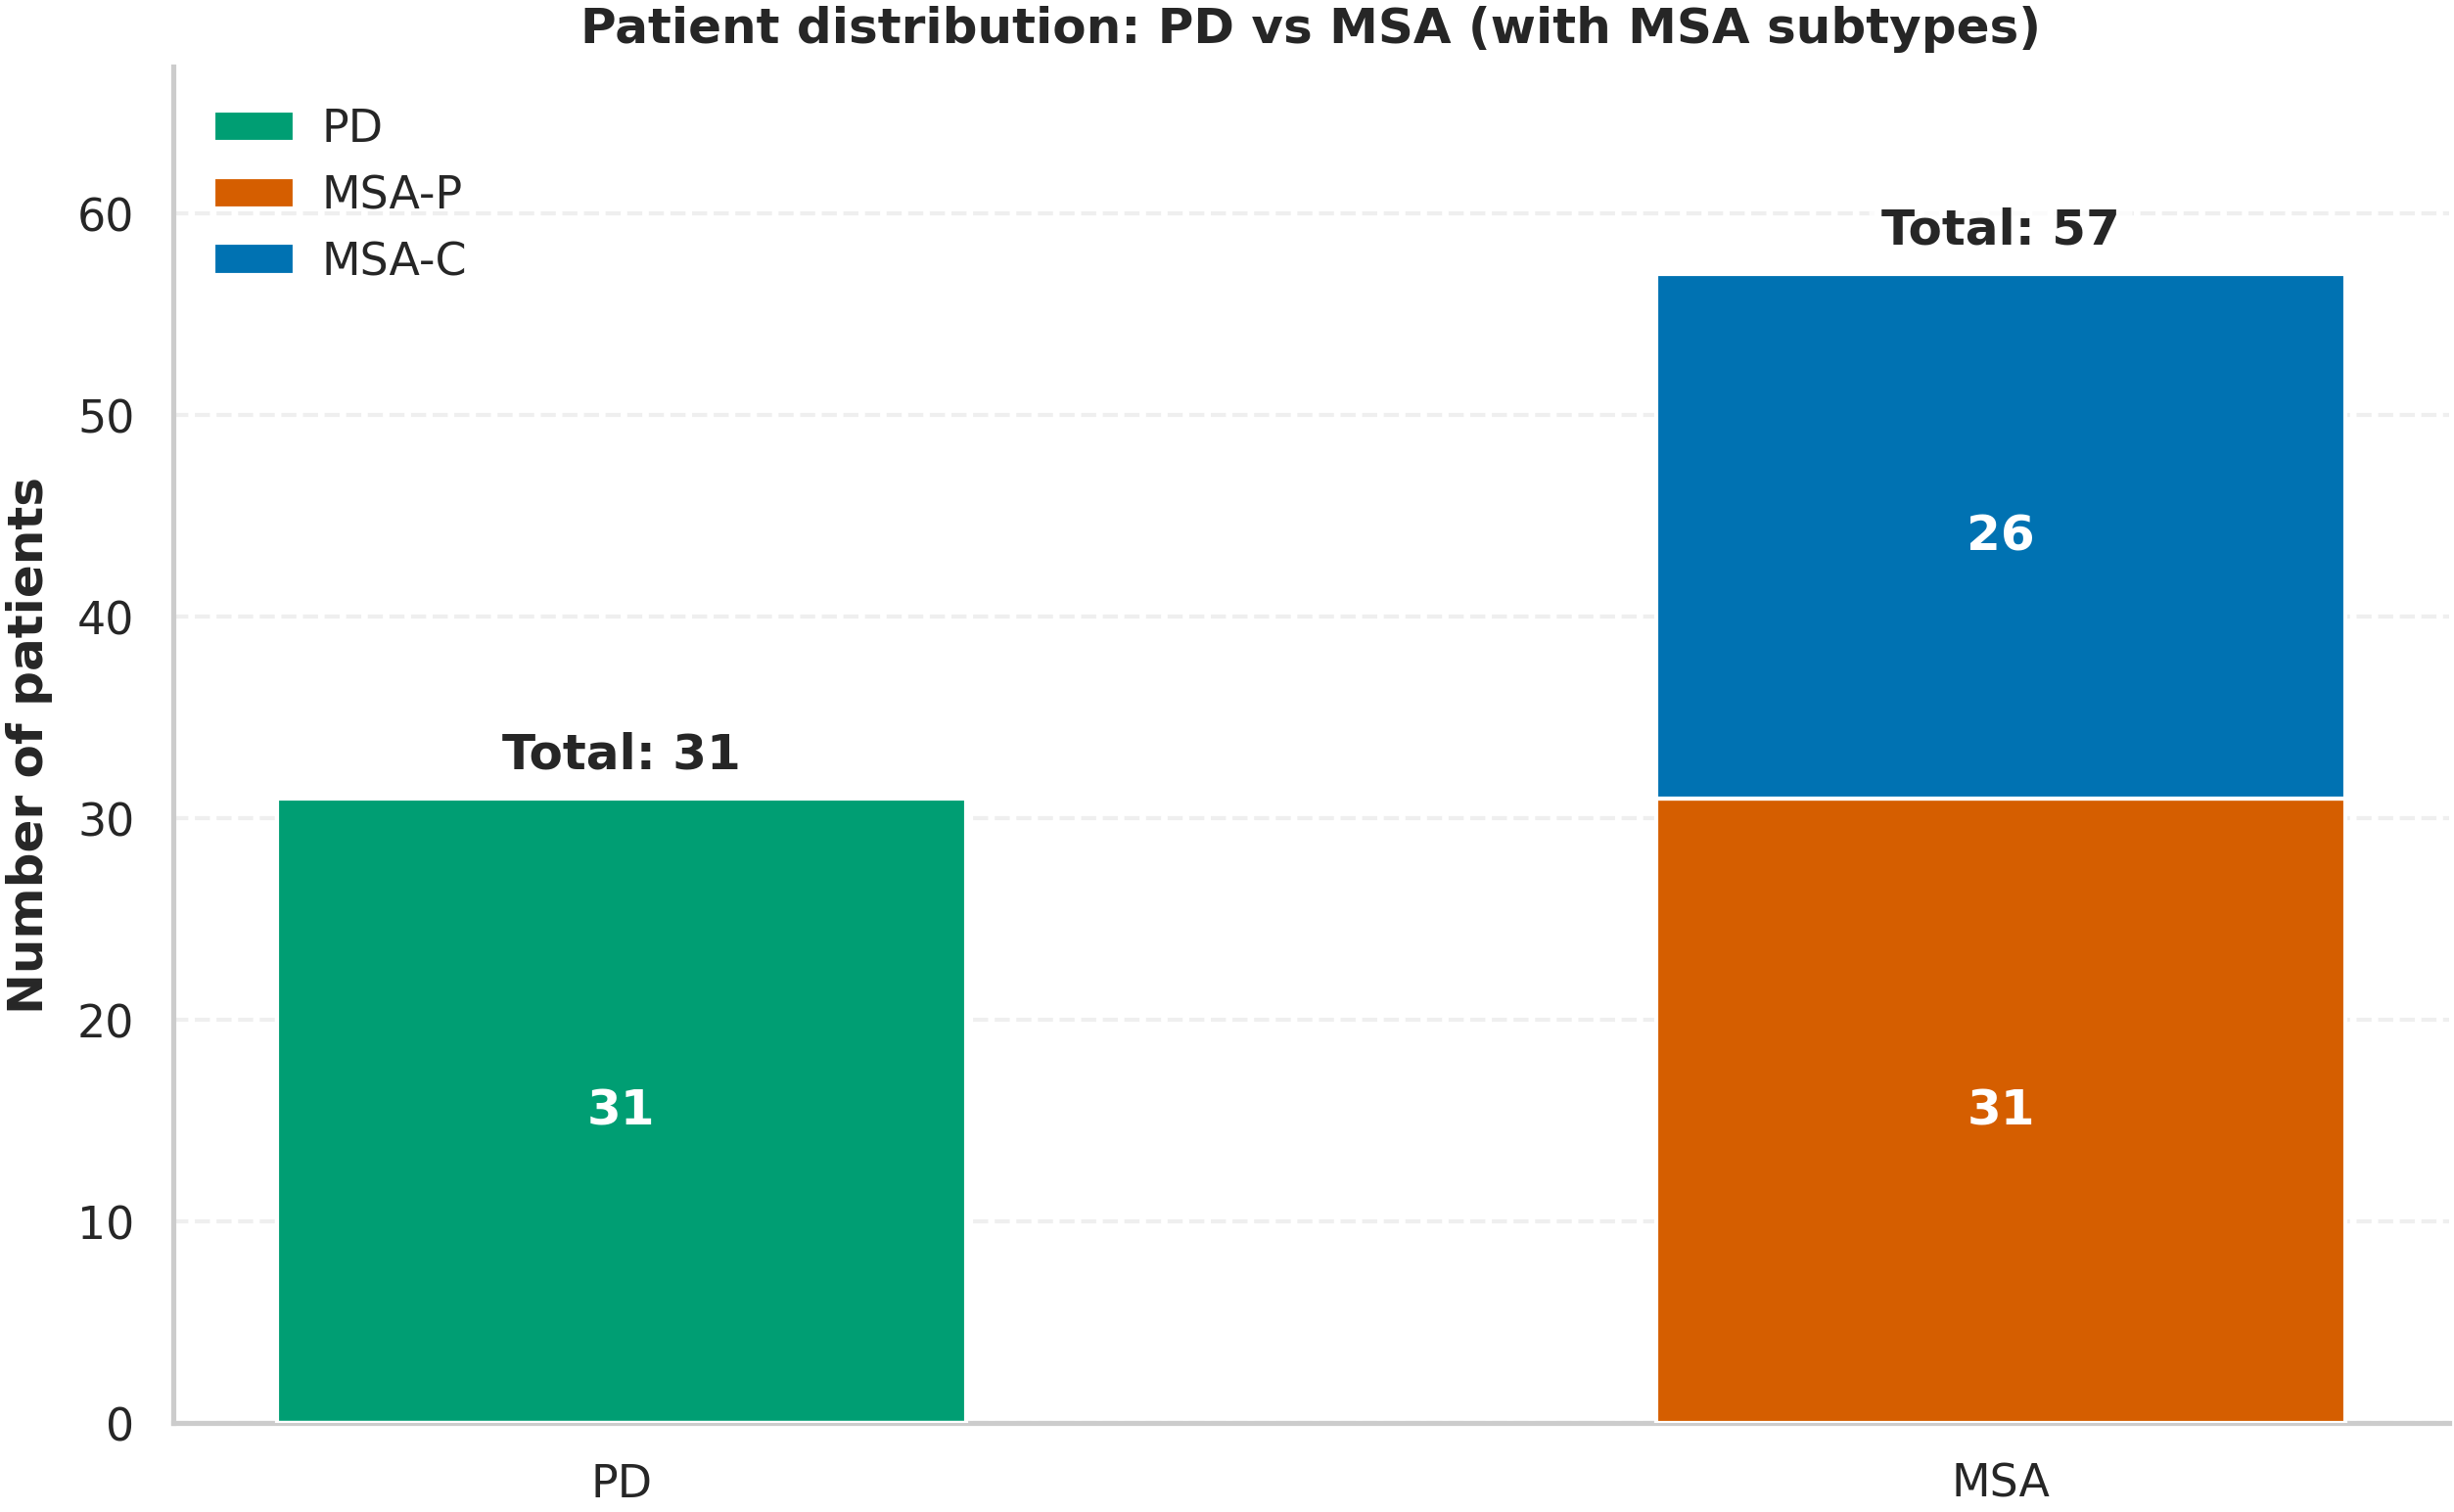

In [20]:
# Data
pd_count = 31
msa_c_count = 26
msa_p_count = 31
msa_total = msa_c_count + msa_p_count

# Consistent class colors (Okabe–Ito)
COLOR_PD    = sm.palette[2]  # blue
COLOR_MSA_P = sm.palette[1]  # orange
COLOR_MSA_C = sm.palette[0]  # magenta

# Figure (match your original size)
fig, ax = plt.subplots(figsize=(10, 6))

# Categories and data – MSA-P bottom, MSA-C top
categories = ['PD', 'MSA']
pd_data   = [pd_count, 0]
msa_p_dt  = [0, msa_p_count]
msa_c_dt  = [0, msa_c_count]

bar_width = 0.5
x_pos = np.arange(len(categories))

# Bars
bars1 = ax.bar(x_pos, pd_data,   bar_width, label='PD',    color=COLOR_PD,    zorder=3)
bars2 = ax.bar(x_pos, msa_p_dt,  bar_width, label='MSA-P', color=COLOR_MSA_P, zorder=3)
bars3 = ax.bar(x_pos, msa_c_dt,  bar_width, bottom=msa_p_dt, label='MSA-C', color=COLOR_MSA_C, zorder=3)

# Labels & title
ax.set_ylabel('Number of patients', fontweight = 'bold')
ax.set_title('Patient distribution: PD vs MSA (with MSA subtypes)',fontweight = 'bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(categories)

# Legend outside (no overlap with totals)
ax.legend(loc='upper left')

# Value labels in bars
for i, (bar1, bar2, bar3) in enumerate(zip(bars1, bars2, bars3)):
    if bar1.get_height() > 0:
        ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height()/2,
                f'{int(bar1.get_height())}', ha='center', va='center',
                fontweight='bold', color='white')
    if bar2.get_height() > 0:
        ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height()/2,
                f'{int(bar2.get_height())}', ha='center', va='center',
                fontweight='bold', color='white')
    if bar3.get_height() > 0:
        ax.text(bar3.get_x() + bar3.get_width()/2, bar2.get_height() + bar3.get_height()/2,
                f'{int(bar3.get_height())}', ha='center', va='center',
                fontweight='bold', color='white')

# Totals above bars (with small white box for readability)
def total_label(x, y, txt):
    ax.text(x, y, txt, ha='center', va='bottom', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.8, edgecolor='none'))

total_label(x_pos[0], pd_count + 1.0,  f'Total: {pd_count}')
total_label(x_pos[1], msa_total + 1.0, f'Total: {msa_total}')

# Grid below bars
ax.set_ylim(0, max(pd_count, msa_total) * 1.18)
ax.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# fig.tight_layout()
os.makedirs("images/dataset_barplots", exist_ok=True)
sm.savefig(f"images/dataset_barplots/01_patient_distribution_{categories}.png")
plt.show()

Found 264 images in '/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/3c_MIP/PD'
Found 291 images in '/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/3c_MIP/MSA-P'
Found 242 images in '/home/zano/Documents/TESI/FOLDER_CINECA/data/SUBSLICE_MIPS/3c_MIP/MSA-C'
Figure saved to /home/zano/Documents/TESI/FOLDER_CINECA/images/dataset_barplots/01_patient_distribution_DS1.png
Figure successfully saved to: /home/zano/Documents/TESI/FOLDER_CINECA/images/dataset_barplots/01_patient_distribution_DS1.png


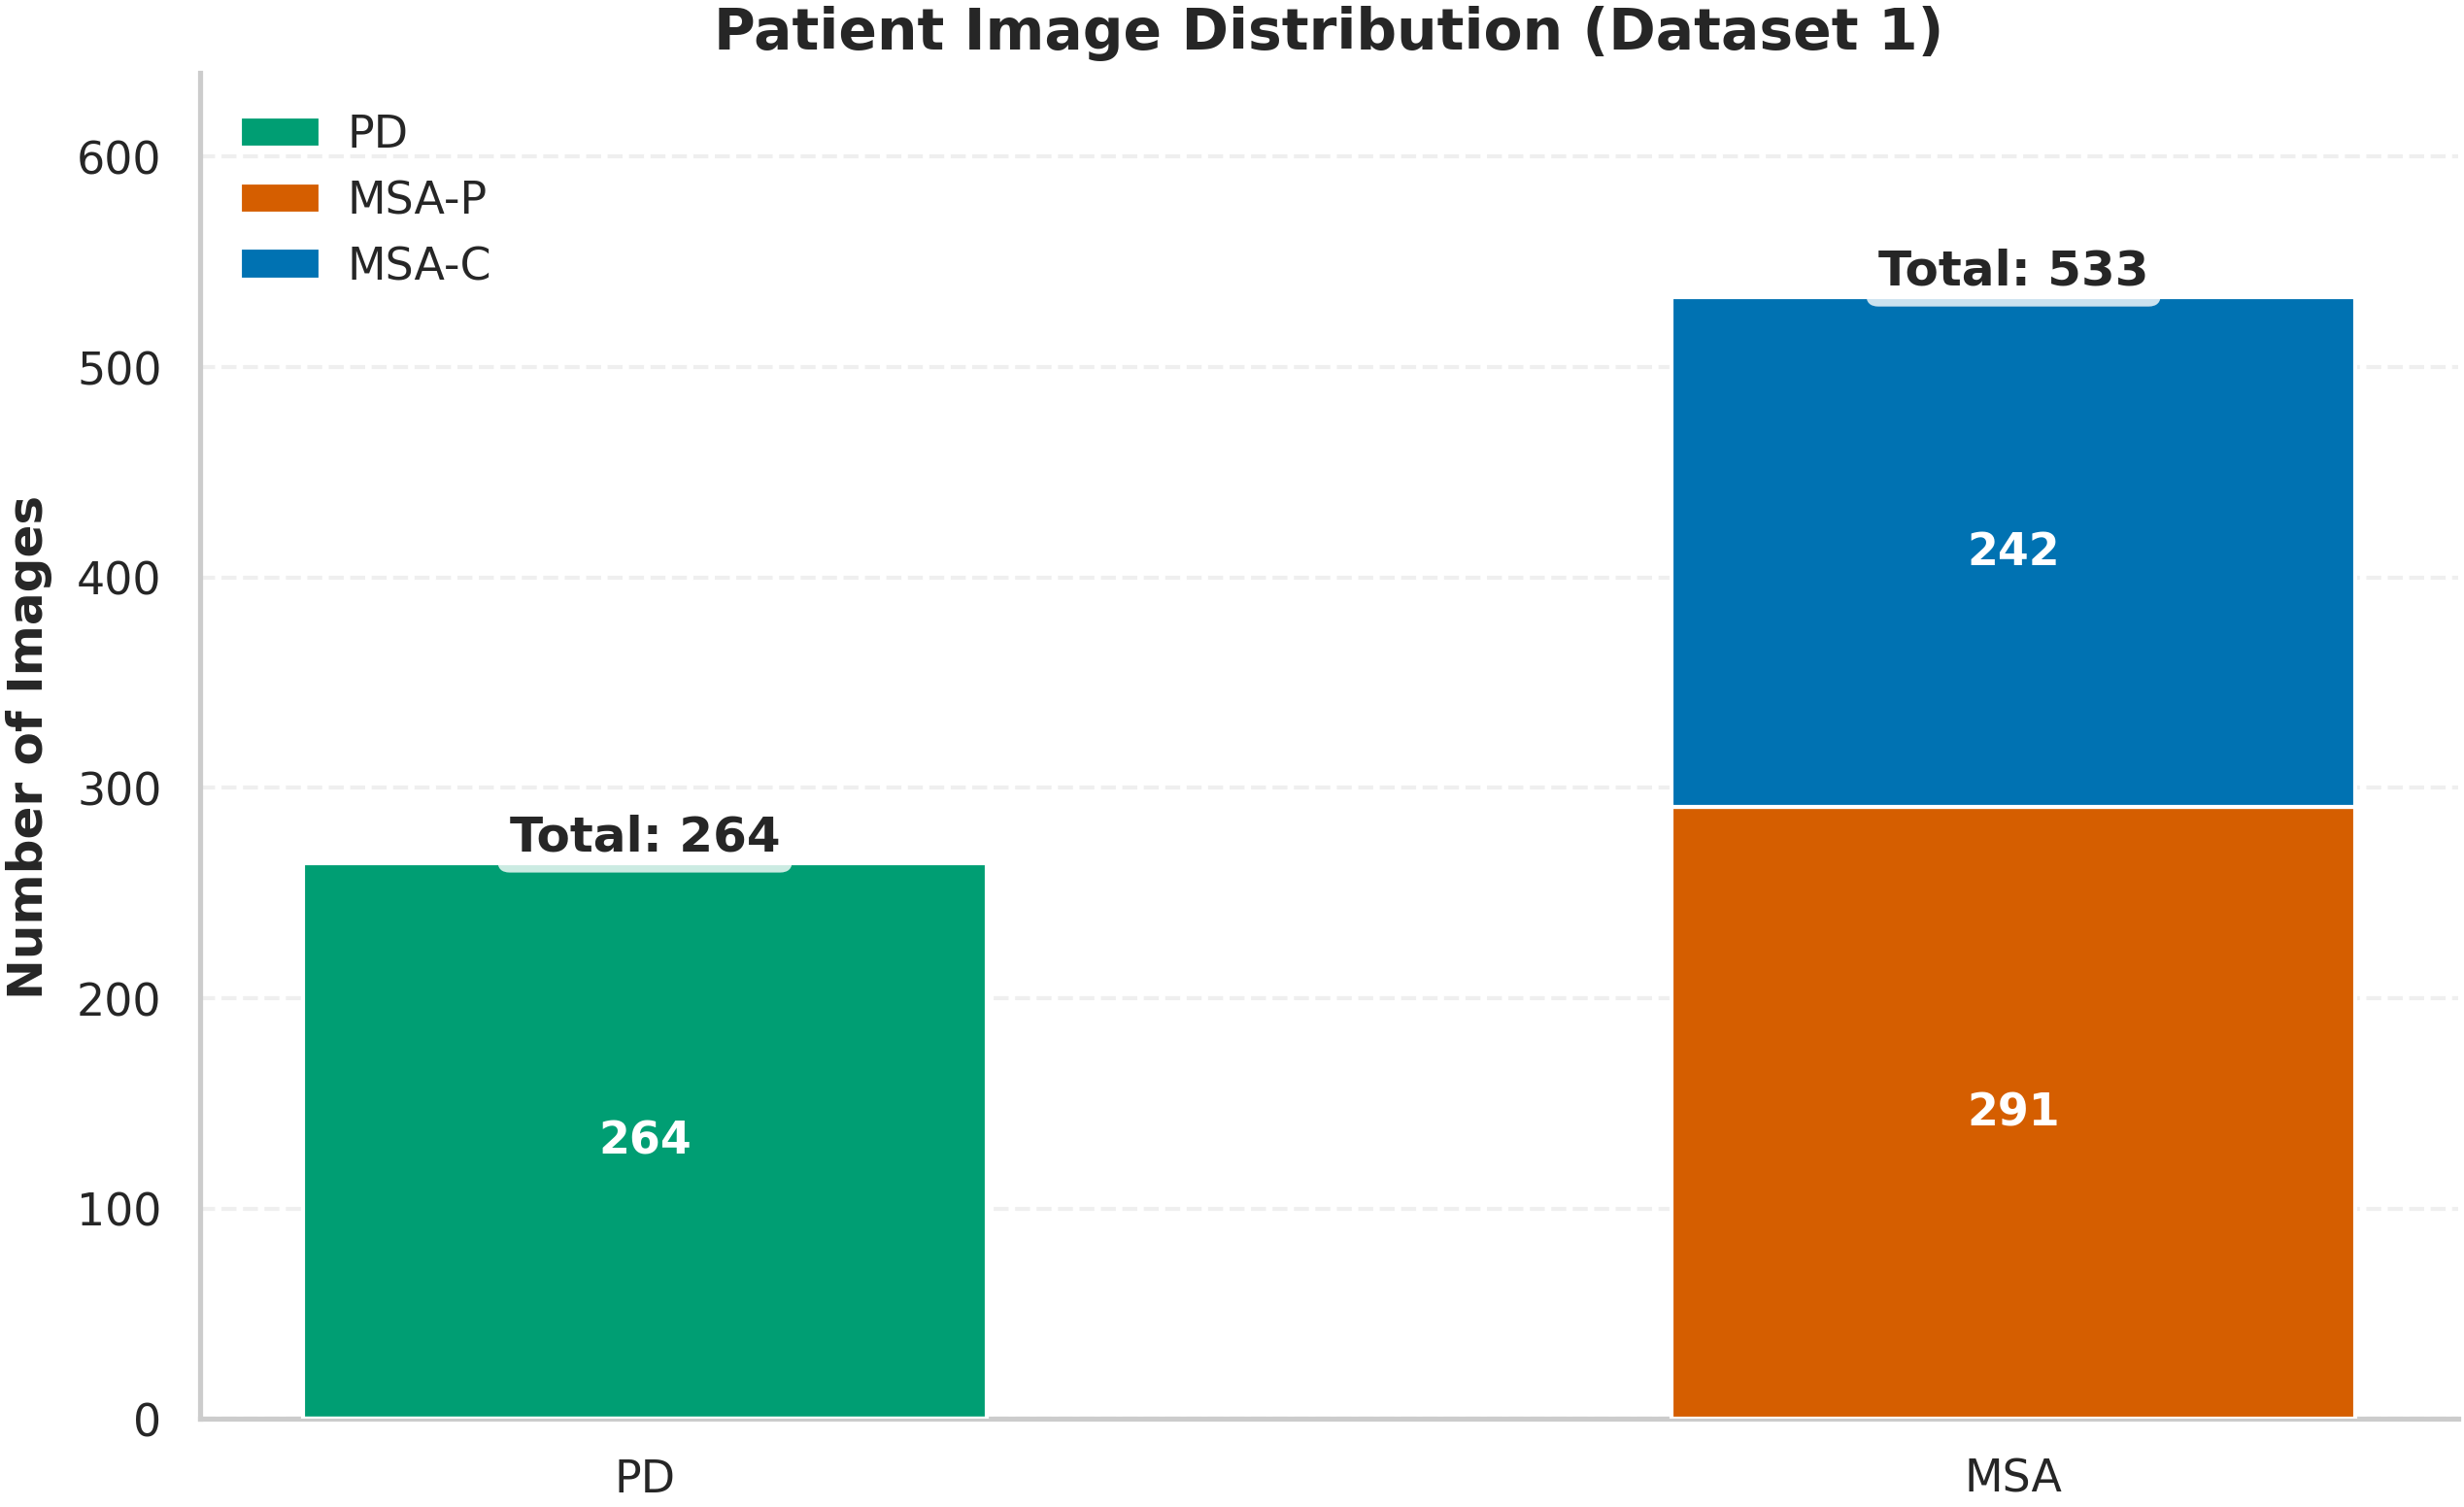

'/home/zano/Documents/TESI/FOLDER_CINECA/images/dataset_barplots/01_patient_distribution_DS1.png'

In [13]:
import os
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional

def plot_image_distribution(
    base_data_dir: str,
    output_path: str,
    class_subdirs: List[str] = ['PD', 'MSA-P', 'MSA-C'],
    title: str = 'Image Distribution by Patient Group'
) -> Optional[str]:
    """
    Counts images in class-named subdirectories and generates a styled bar plot.

    This function scans a base directory for subfolders corresponding to patient
    classes, counts the files within each, and produces a stacked bar chart
    comparing PD against MSA (with MSA-P and MSA-C subtypes).

    Args:
        base_data_dir (str):
            The path to the parent directory containing class subfolders
            (e.g., '../data/processed/DS1').
        output_path (str):
            The full path, including filename, where the plot image will be saved.
        class_subdirs (List[str]):
            A list of the subdirectory names to count. Defaults to
            ['PD', 'MSA-P', 'MSA-C'].
        title (str):
            The main title for the plot.

    Returns:
        Optional[str]:
            The path to the saved figure if successful, otherwise None.
    """
    # --- 1. Count images in subdirectories ---
    counts: Dict[str, int] = {}
    for class_name in class_subdirs:
        class_path = os.path.join(base_data_dir, class_name)
        if os.path.isdir(class_path):
            # Count files, ignoring subdirectories
            num_files = len([
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            ])
            counts[class_name] = num_files
            print(f"Found {num_files} images in '{class_path}'")
        else:
            print(f"Warning: Directory not found, using count 0: '{class_path}'")
            counts[class_name] = 0

    pd_count = counts.get('PD', 0)
    msa_p_count = counts.get('MSA-P', 0)
    msa_c_count = counts.get('MSA-C', 0)
    msa_total = msa_p_count + msa_c_count

    # --- 2. Plotting Logic (identical to your previous cell) ---
    fig, ax = plt.subplots(figsize=(10, 6))

    categories = ['PD', 'MSA']
    pd_data = [pd_count, 0]
    msa_p_data = [0, msa_p_count]
    msa_c_data = [0, msa_c_count]

    bar_width = 0.5
    x_pos = np.arange(len(categories))

    # Use zorder to ensure bars are on top of the grid
    bars1 = ax.bar(x_pos, pd_data, bar_width, label='PD', color=COLOR_PD, zorder=3)
    bars2 = ax.bar(x_pos, msa_p_data, bar_width, label='MSA-P', color=COLOR_MSA_P, zorder=3)
    bars3 = ax.bar(x_pos, msa_c_data, bar_width, bottom=msa_p_data, label='MSA-C', color=COLOR_MSA_C, zorder=3)

    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories)
    ax.legend(loc='upper left')

    for bar in bars1:
        if bar.get_height() > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
                    f'{int(bar.get_height())}', ha='center', va='center',
                    fontweight='bold', color='white', fontsize=11)
    for bar in bars2:
        if bar.get_height() > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
                    f'{int(bar.get_height())}', ha='center', va='center',
                    fontweight='bold', color='white', fontsize=11)
    for bar in bars3:
        if bar.get_height() > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                    f'{int(bar.get_height())}', ha='center', va='center',
                    fontweight='bold', color='white', fontsize=11)

    def total_label(x: float, y: float, txt: str):
        ax.text(x, y, txt, ha='center', va='bottom', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.8, edgecolor='none'))

    if pd_count > 0:
        total_label(x_pos[0], pd_count + 1.5, f'Total: {pd_count}')
    if msa_total > 0:
        total_label(x_pos[1], msa_total + 1.5, f'Total: {msa_total}')

    ax.set_ylim(0, max(pd_count, msa_total) * 1.2)
    ax.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # plt.tight_layout(rect=[0, 0, 0.85, 1])

    # --- 3. Save the figure ---
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    sm.savefig(output_path)
    print(f"Figure successfully saved to: {output_path}")

    plt.show()
    plt.close()
    return output_path



# --- Define the output directory for the plots ---
output_plot_dir = os.path.join(project_root, "images", "dataset_barplots")
base_dir = os.path.join(project_root, "data", "SUBSLICE_MIPS", "3c_MIP")
# --- Generate and save the plot for Dataset 1 ---
plot_image_distribution(
    base_data_dir=base_dir,
    output_path=os.path.join(output_plot_dir, "01_patient_distribution_DS1.png"),
    title="Patient Image Distribution (Dataset 1)"
)

# # --- Generate and save the plot for Dataset 2 ---
# plot_image_distribution(
#     base_data_dir=ds2_image_dir,
#     output_path=os.path.join(output_plot_dir, "02_patient_distribution_DS2.png"),
#     title="Patient Image Distribution (Dataset 2)"
# )

In [ ]:
#  # --- 1. Count images in subdirectories ---
# class_subdirs: List[str] = ['PD', 'MSA-P', 'MSA-C']
# base_data_dir: str = os.path.join(project_root, "data", "SUBSLICE_MIPS", "3c_MIP")
# counts: Dict[str, int] = {}
# for class_name in class_subdirs:
#     class_path = os.path.join(base_data_dir, class_name)
#     if os.path.isdir(class_path):
#         # Count files, ignoring subdirectories
#         num_files = len([
#             f for f in os.listdir(class_path)
#             if os.path.isfile(os.path.join(class_path, f))
#         ])
#         counts[class_name] = num_files
#         print(f"Found {num_files} images in '{class_path}'")
#     else:
#         print(f"Warning: Directory not found, using count 0: '{class_path}'")
#         counts[class_name] = 0

# pd_count = counts.get('PD', 0)
# msa_p_count = counts.get('MSA-P', 0)
# msa_c_count = counts.get('MSA-C', 0)
# msa_total = msa_p_count + msa_c_count

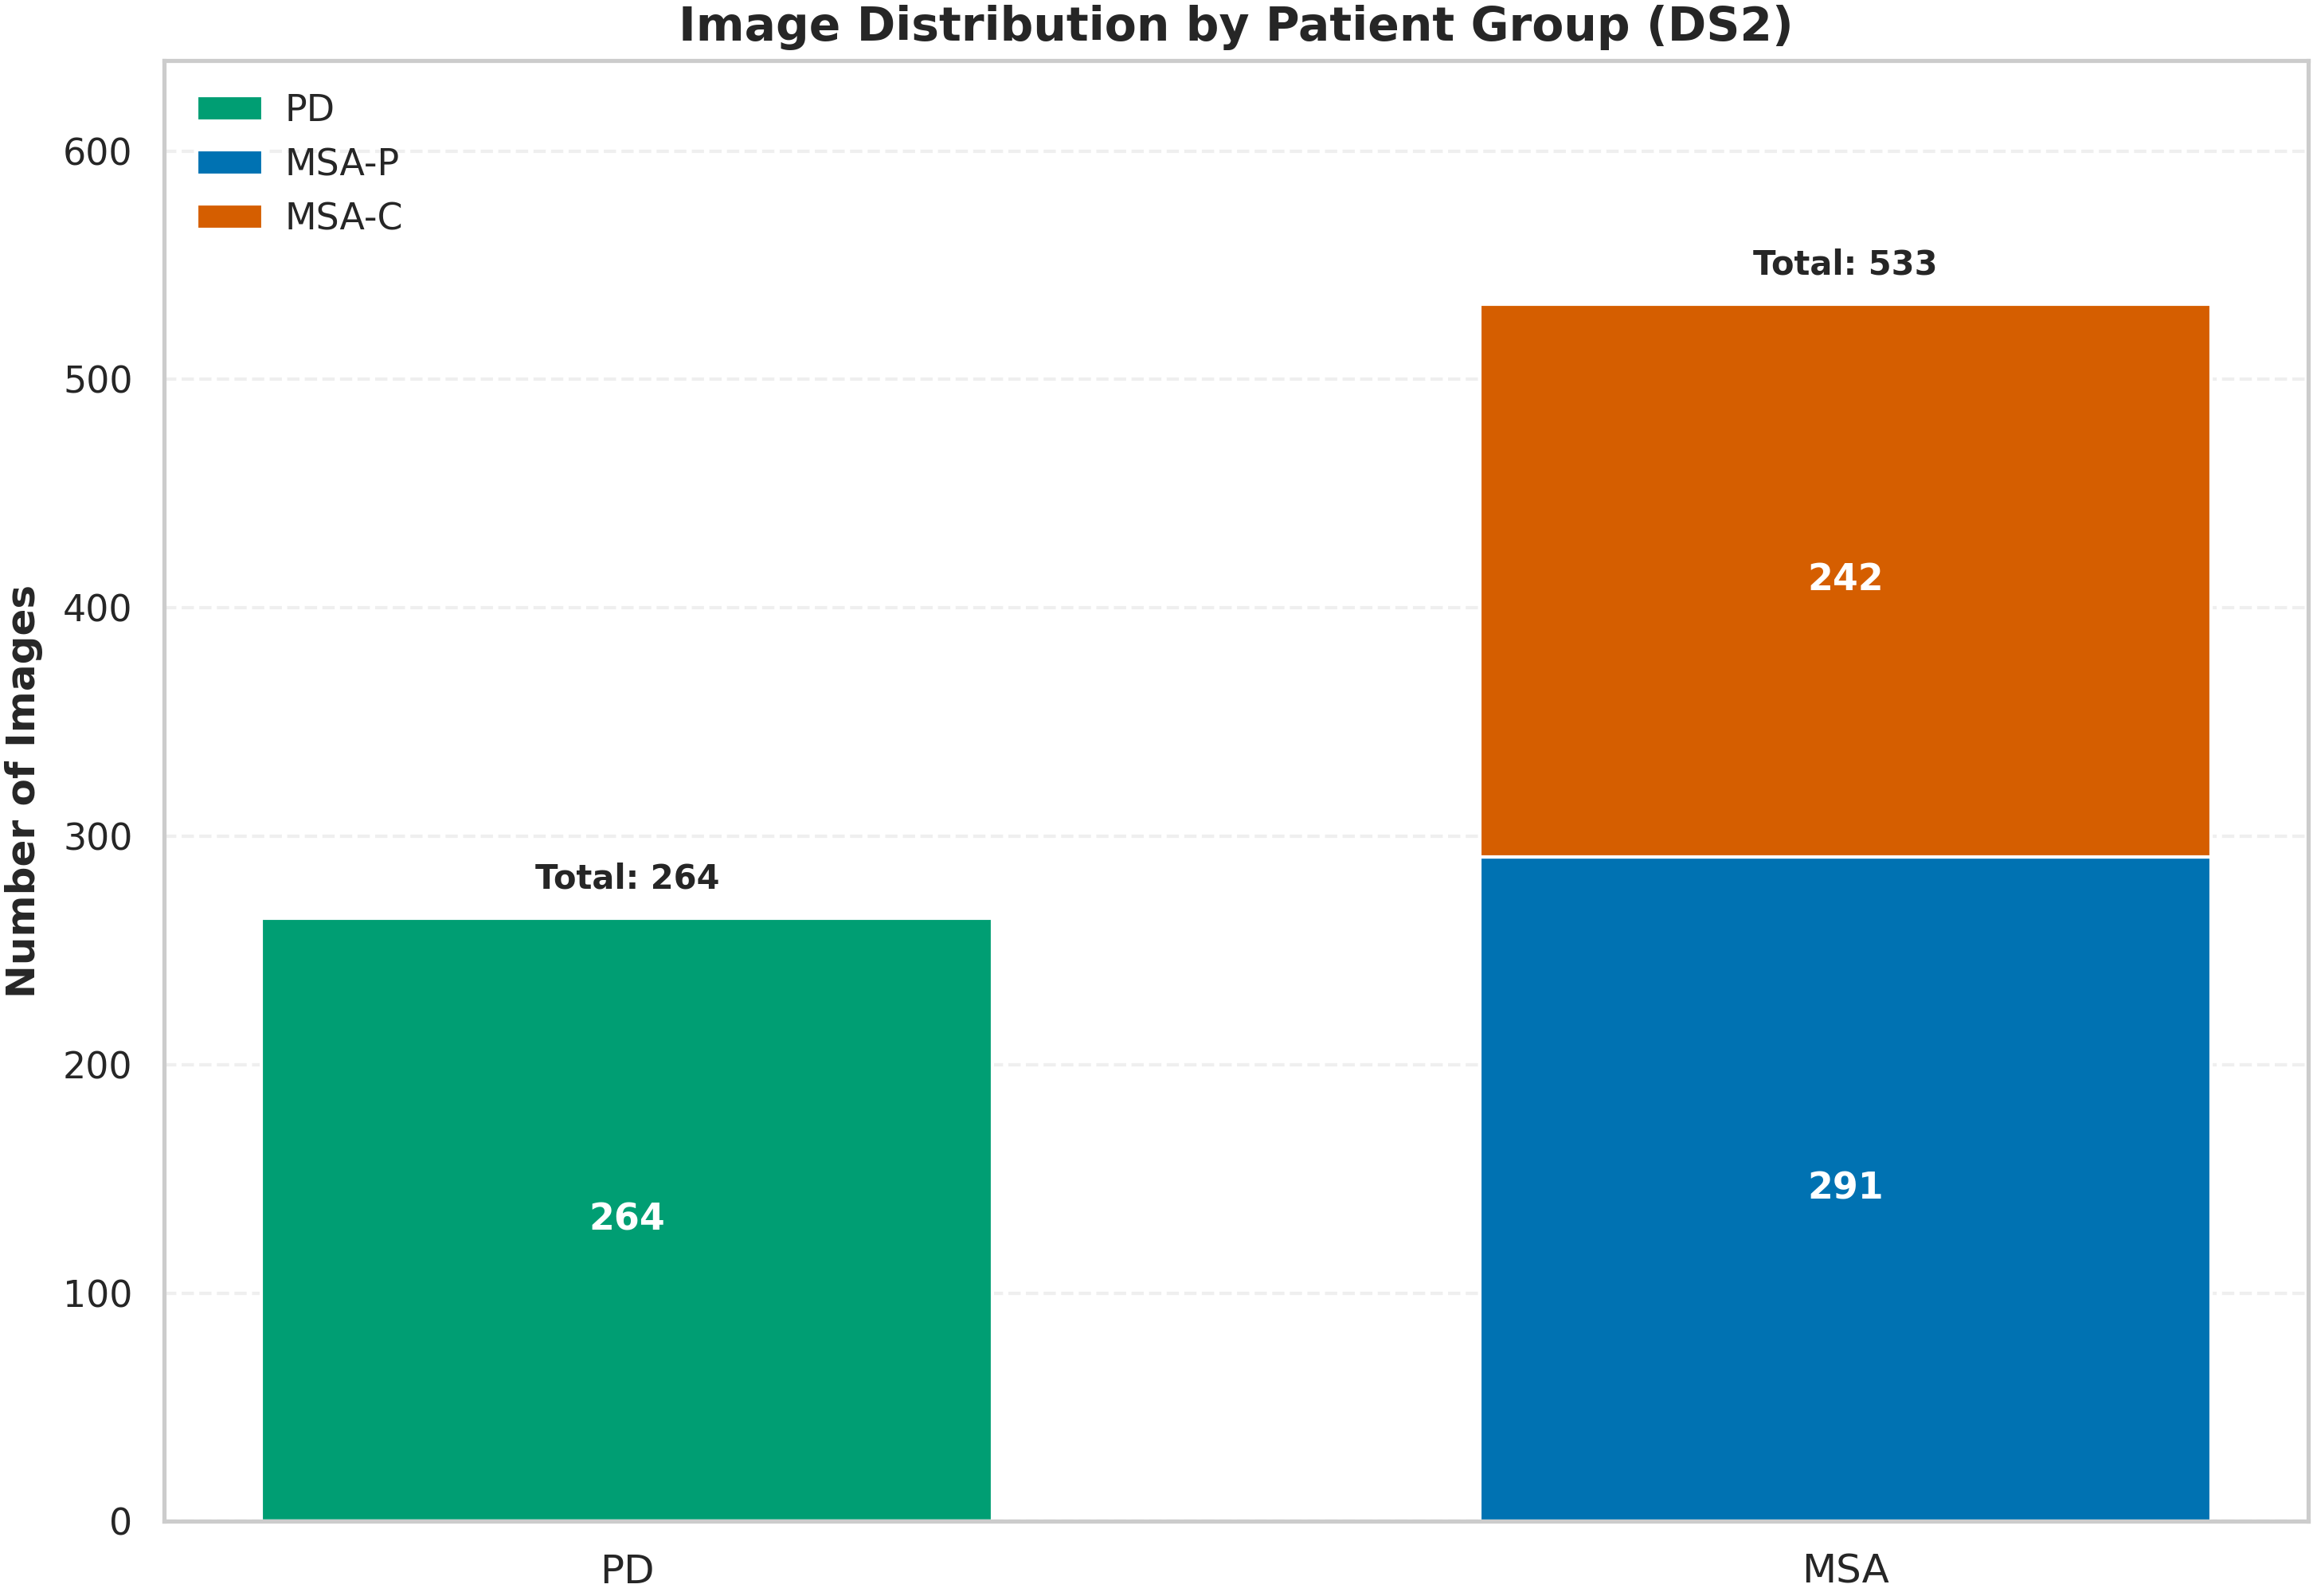

In [ ]:
# --- Step 2: Create the Plot ---
fig, ax = plt.subplots(figsize=(10, 7))

class_names = ['PD', 'MSA-P', 'MSA-C']

# This logic is for the specific three-class scenario: PD vs MSA (stacked)
if len(class_names) == 3 and 'PD' in class_names and 'MSA-P' in class_names and 'MSA-C' in class_names:
    
    # --- Data Preparation ---
    pd_count = counts_dict['PD']['gh_count']
    msa_p_count = counts_dict['MSA-P']['gh_count'] 
    msa_c_count = counts_dict['MSA-C']['gh_count']
    
    # Define the custom labels and their positions on the x-axis
    categories = ['PD', 'MSA']
    x_pos = np.arange(len(categories))  # This will be [0, 1]

    # Structure the data to plot PD only at position 0 and MSA only at position 1
    pd_data = [pd_count, 0]
    msa_p_data = [0, msa_p_count]  # MSA-P at the bottom of the second bar
    msa_c_data = [0, msa_c_count]  # MSA-C stacked on top of MSA-P
    
    bar_width = 0.6
    
    # --- Plotting the Bars ---
    # Plot PD bar (at position 0)
    # Updated colors to match Okabe–Ito palette: PD = #009E73 (green), MSA-P = #0072B2 (blue), MSA-C = #D55E00 (orange)
    bars1 = ax.bar(x_pos, pd_data, bar_width, label='PD', color=COLOR_PD, alpha=1)
    # Plot MSA-P bar (at position 1)
    bars2 = ax.bar(x_pos, msa_p_data, bar_width, label='MSA-P', color=COLOR_MSA_P, alpha=1)
    # Plot MSA-C bar stacked on top of MSA-P (at position 1)
    bars3 = ax.bar(x_pos, msa_c_data, bar_width, bottom=msa_p_data, label='MSA-C', color=COLOR_MSA_C, alpha=1)

    # --- Adding Value Labels inside Bars ---
    # Loop through the bars to add text labels
    for i, (bar1, bar2, bar3) in enumerate(zip(bars1, bars2, bars3)):
        if bar1.get_height() > 0:  # PD bar
            ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height()/2, 
                    f'{int(bar1.get_height())}', ha='center', va='center', 
                    fontweight='bold', color='white', fontsize=11)
        
        if bar2.get_height() > 0:  # MSA-P bar (bottom part)
            ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height()/2, 
                    f'{int(bar2.get_height())}', ha='center', va='center', 
                    fontweight='bold', color='white', fontsize=11)
        
        if bar3.get_height() > 0:  # MSA-C bar (top part)
            ax.text(bar3.get_x() + bar3.get_width()/2, 
                    bar2.get_height() + bar3.get_height()/2, # Positioned in the middle of the top segment
                    f'{int(bar3.get_height())}', ha='center', va='center', 
                    fontweight='bold', color='white', fontsize=11)
    
    # --- Adding Total Count Labels Above Bars ---
    msa_total = msa_p_count + msa_c_count
    ax.text(0, pd_count + 10, f'Total: {pd_count}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    ax.text(1, msa_total + 10, f'Total: {msa_total}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # --- Finalizing the Plot ---
    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title('Image Distribution by Patient Group (DS2)', fontsize=14, fontweight='bold')
    
    # This is the key part to set the x-axis labels correctly
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, fontsize=12)
    
    # Set y-axis limit to give space for the total labels
    max_height = max(pd_count, msa_total)
    ax.set_ylim(0, max_height * 1.2)
    
    ax.legend(loc='upper left')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True) # Ensure grid is behind bars

else:
    # Fallback for other scenarios (e.g., if only two classes are present)
    ax.text(0.5, 0.5, 'This plotting logic is designed for the PD, MSA-P, MSA-C case.', 
            ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.savefig("dataset_distribution.png", dpi=300)
plt.show()


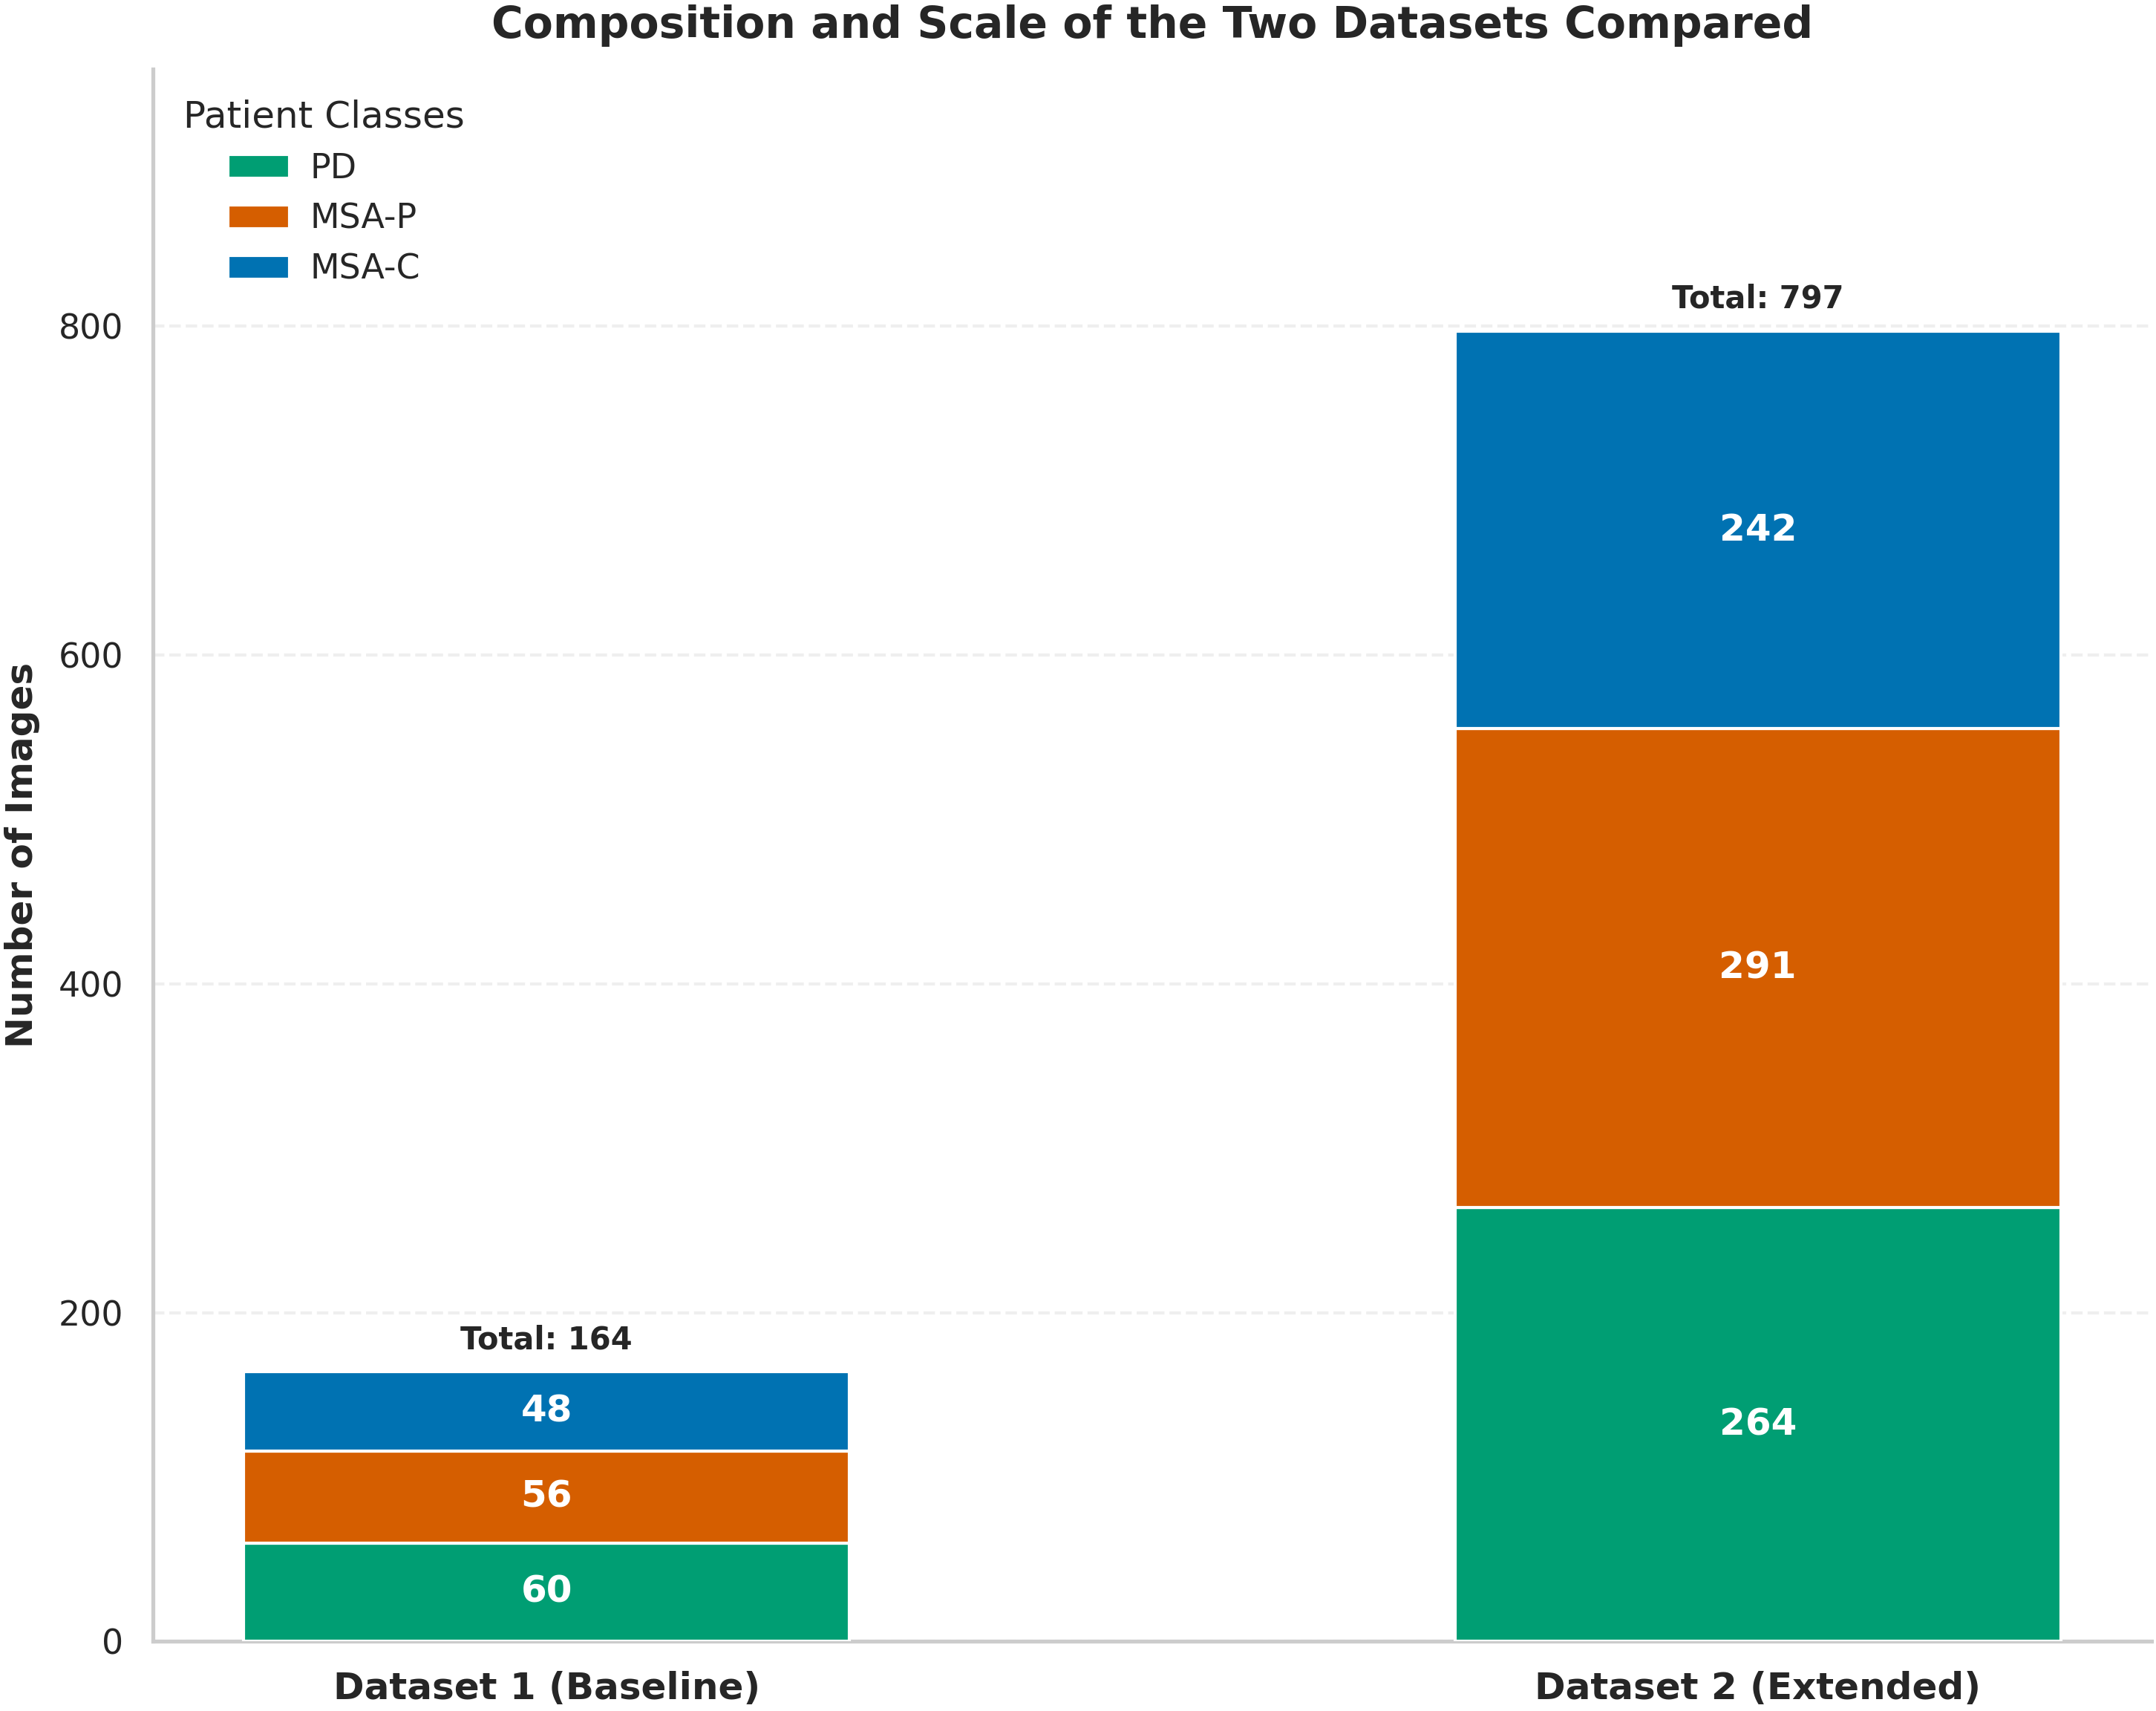

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Data extracted from your graphs
data = {
    'Dataset': ['Dataset 1 (Baseline)', 'Dataset 2 (Extended)'],
    'PD': [60, 264],
    'MSA-P': [56, 291],
    'MSA-C': [48, 242]
}
df = pd.DataFrame(data)

# Calculate the total for each dataset for the labels
df['Total'] = df['PD'] + df['MSA-P'] + df['MSA-C']

# 2. Set the colors to match Okabe–Ito palette
# Assumes COLOR_PD, COLOR_MSA_P, COLOR_MSA_C are defined
# (e.g., from your style manager 'sm')
colors = {
    'PD': COLOR_PD,
    'MSA-P': COLOR_MSA_P,
    'MSA-C': COLOR_MSA_C
}

# 3. Plotting preparation
labels = df['Dataset']
x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

# 4. Create the plot
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 8))

# Bars for Dataset 1 and 2 using a loop
bottoms = np.zeros(len(df)) # Initialize the bar bottoms to zero
class_counts = {
    'PD': df['PD'].values,
    'MSA-P': df['MSA-P'].values,
    'MSA-C': df['MSA-C'].values
}

for class_name, counts in class_counts.items():
    bars = ax.bar(x, counts, width, label=class_name, color=colors[class_name], bottom=bottoms, zorder=3)
    
    # Add numeric labels inside each segment
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, bottoms[i] + height / 2),
                        ha='center', va='center', color='white', fontweight='bold', fontsize=12)
    
    # Update the bottoms for the next class to be stacked
    bottoms += counts

# 5. Add labels, title, and styling
ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax.set_title('Composition and Scale of the Two Datasets Compared', fontsize=14, pad=10, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12, fontweight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.3, zorder=0) # Set zorder to 0
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add total labels above the bars
for i, total in enumerate(df['Total']):
    ax.text(i, total + 10, f"Total: {total}", ha='center', va='bottom', fontweight='bold', fontsize=10)

# Set y-axis limit to make space for total labels
ax.set_ylim(0, df['Total'].max() * 1.2)

# 6. Create the legend (STYLE UPDATED)
ax.legend(title='Patient Classes',
          loc='upper left',
          frameon=False,  
        #   prop={'size': 10},  # <-- Testo legenda in grassetto
        #   title_fontproperties={'weight': 'bold', 'size': 11}
          ) # <-- Titolo legenda in grassetto

fig.tight_layout()
plt.savefig("dataset_stacked_comparison_en.png", dpi=300)
plt.show()

## train val test split


Data prepared for plotting (percentages):
split          Train  Validation       Test
dataset                                    
Dataset 1  74.846626   12.883436  12.269939
Dataset 2  72.626387   12.946979  14.426634
------------------------------
Figure saved to images/01_dataset_split_distribution.png
Plot generation complete. Figure saved to: images/01_dataset_split_distribution.png


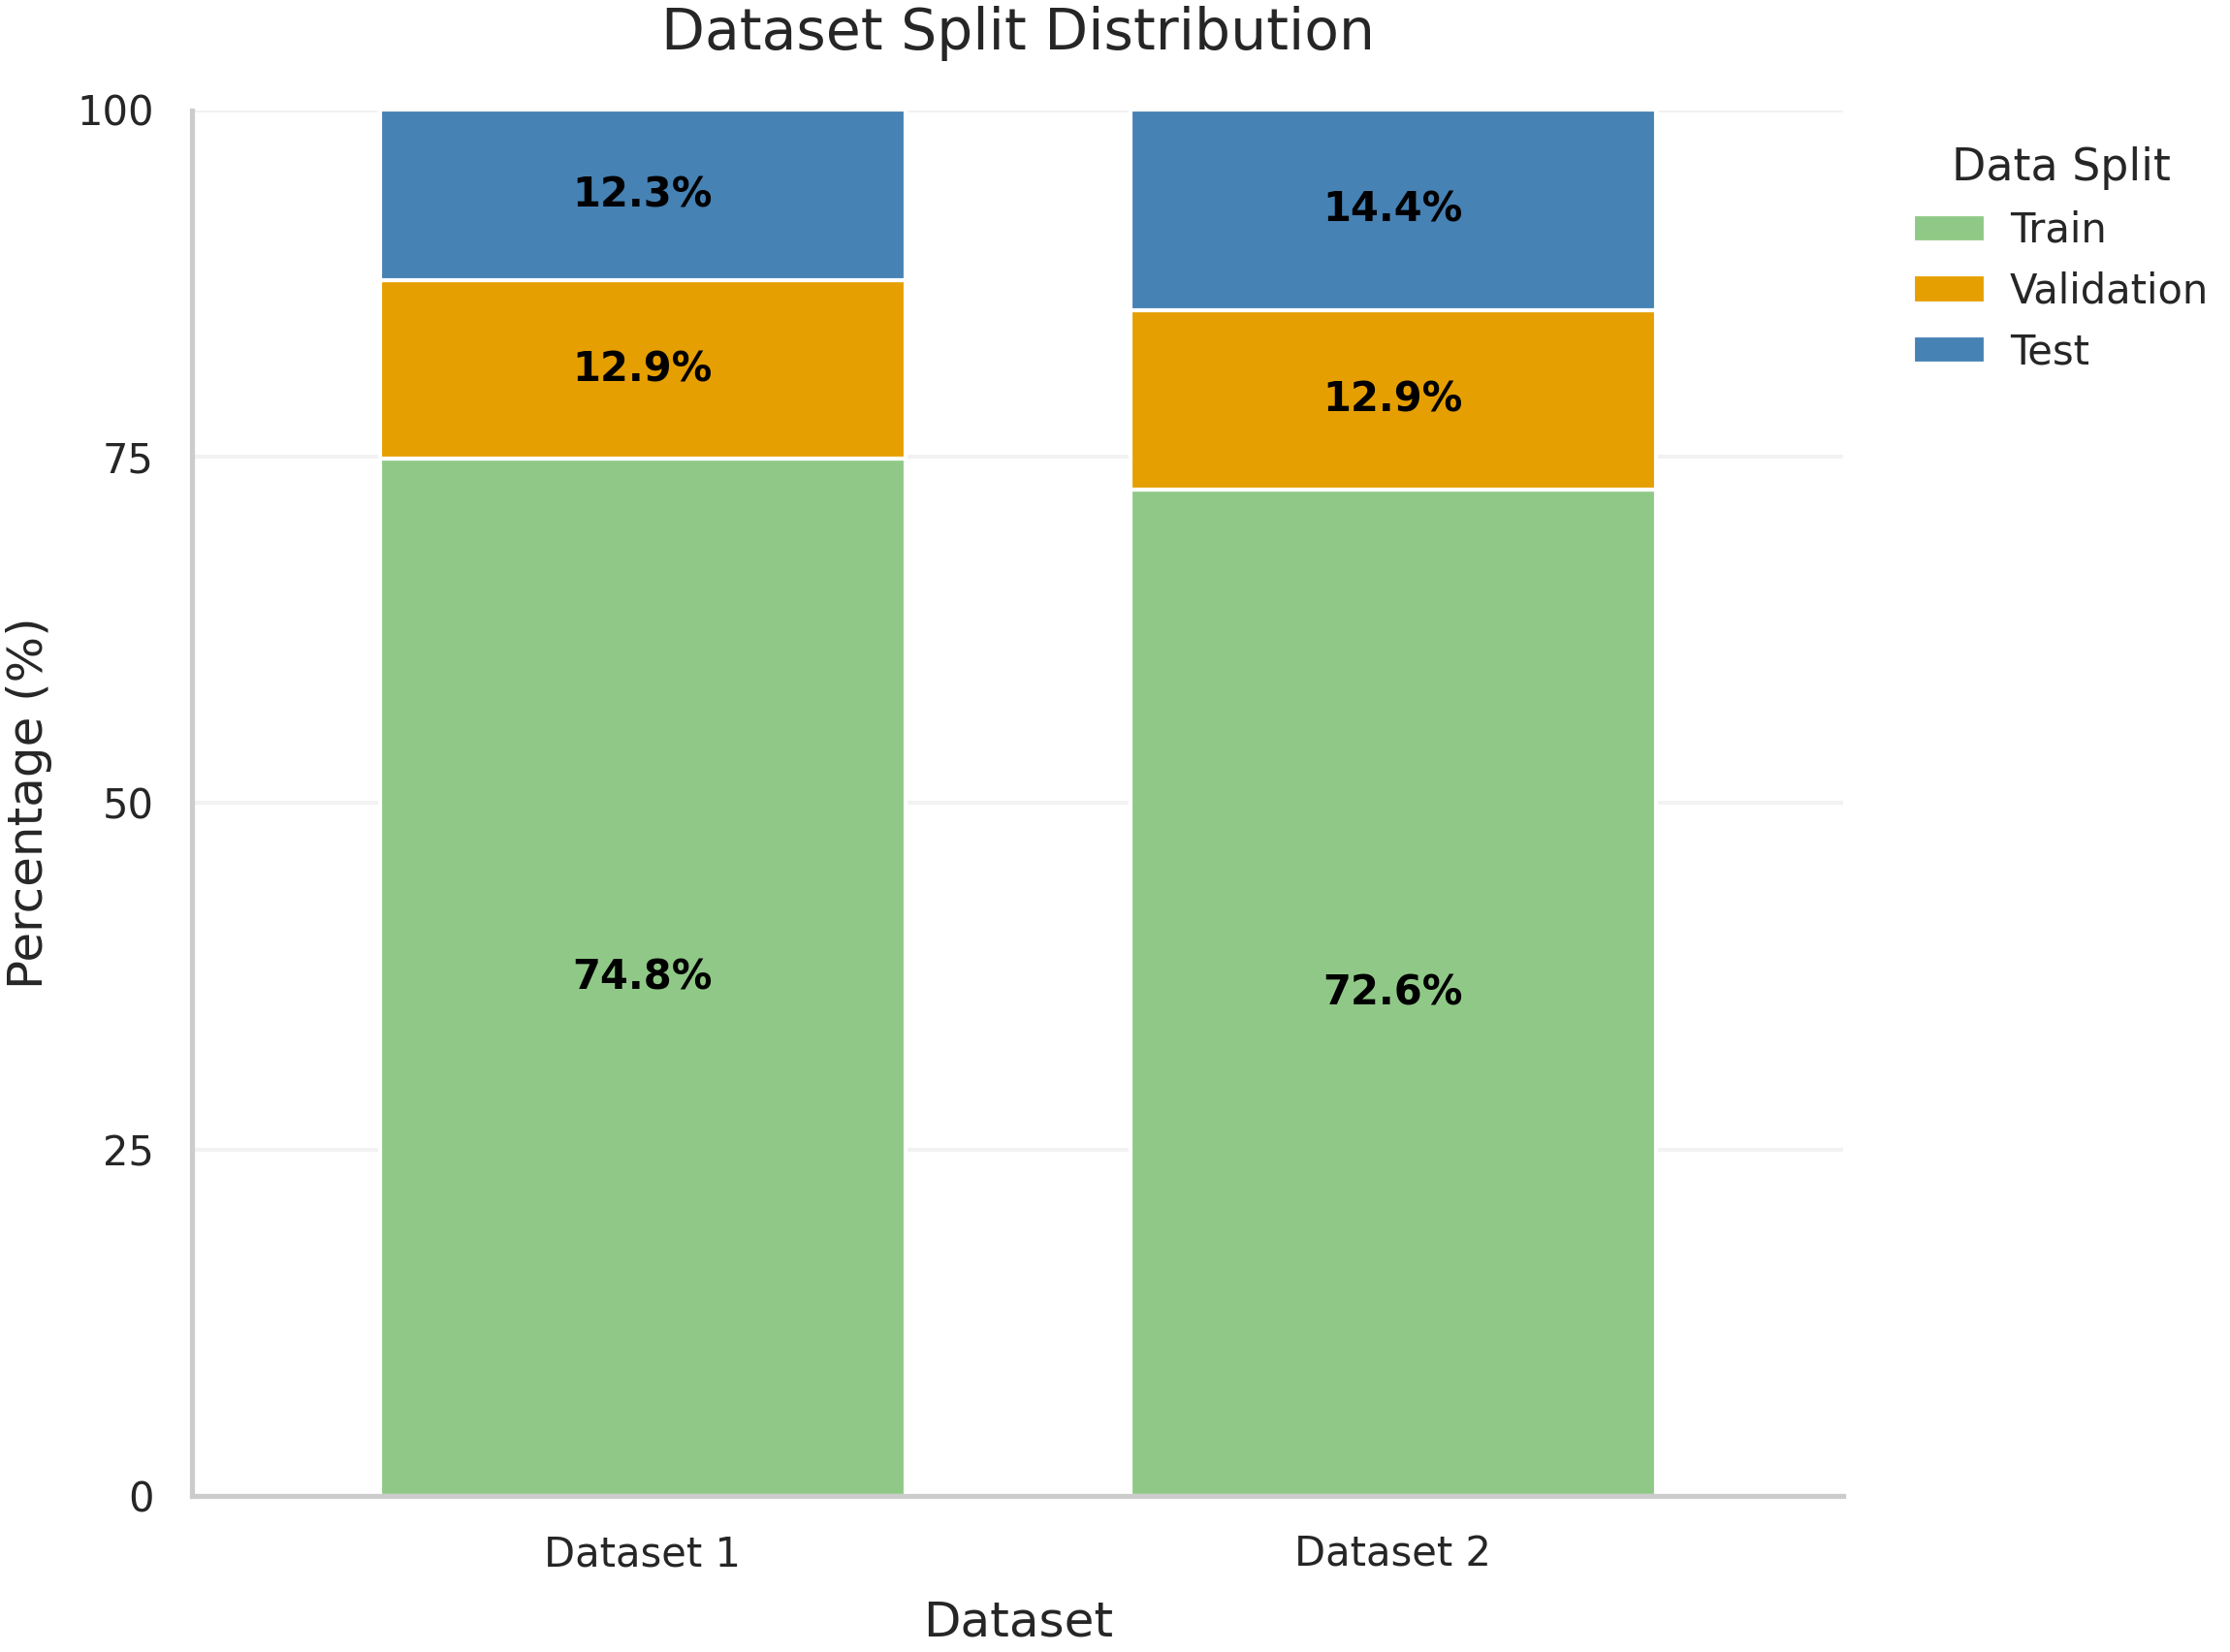

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Activate the thesis plot style
# This loads the .mplstyle and sets the default Okabe-Ito palette
try:
    # Set the default Seaborn theme using the style manager's palette
    sns.set_theme(style="whitegrid", palette=sm.palette)
except ImportError:
    print("Warning: StyleManager not found. Using default Matplotlib settings.")
    # Define fallback palette if StyleManager fails
    class MockStyleManager:
        def __init__(self):
            # Okabe–Ito palette
            self.palette = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', 
                            '#F0E442', '#56B4E9', '#E69F00', '#999999']
        def activate(self):
            plt.style.use('default')
        def savefig(self, fname, **kwargs):
            defaults = {'dpi': 300, 'bbox_inches': 'tight', 'transparent': True}
            defaults.update(kwargs)
            plt.savefig(fname, **defaults)
    
    sm = MockStyleManager()
    sm.activate()
    sns.set_theme(style="whitegrid", palette=sm.palette)


# 2. Input Data
data = [
    {"dataset": "Dataset 1", "split": "Train", "count": 122},
    {"dataset": "Dataset 1", "split": "Validation", "count": 21},
    {"dataset": "Dataset 1", "split": "Test", "count": 20},
    {"dataset": "Dataset 2", "split": "Train", "count": 589},
    {"dataset": "Dataset 2", "split": "Validation", "count": 105},
    {"dataset": "Dataset 2", "split": "Test", "count": 117},
]

# 3. Data Preparation (Convert counts to percentages)
df = pd.DataFrame(data)

# Calculate total counts per dataset to find percentages
df['total'] = df.groupby('dataset')['count'].transform('sum')
df['percentage'] = (df['count'] / df['total']) * 100

# Pivot the data for stacked bar plotting
df_pivot = df.pivot(index='dataset', columns='split', values='percentage')

# Ensure logical stacking order (Train -> Val -> Test)
split_order = ['Train', 'Validation', 'Test']
df_pivot = df_pivot[split_order]

print("Data prepared for plotting (percentages):")
print(df_pivot)
print("-" * 30)

# 4. Plot Generation (100% Stacked Bar)
fig, ax = plt.subplots(figsize=(8, 6))

colors = ['#90C987', '#E69F00', '#4682B4']

# Create the stacked bar plot
df_pivot.plot(kind='bar', stacked=True, color=colors, ax=ax, width=0.7)

# 5. Add Percentage Labels (Thesis Requirement)
# We must iterate through the bars to place text labels
bottom = pd.Series([0.0] * len(df_pivot), index=df_pivot.index)

for i, split in enumerate(split_order):
    values = df_pivot[split]
    
    # Iterate over each dataset (each bar)
    for j, (dataset_name, value) in enumerate(values.items()):
        
        # Only add a label if the segment is large enough (e.g., > 4%)
        if value > 4:
            # Calculate the vertical center of the segment
            y_pos = bottom[dataset_name] + (value / 2)
            label = f"{value:.1f}%"
            
            # Use white text for the first (dark blue) segment
            text_color = 'black' 
            
            ax.text(j, y_pos, label, 
                    ha='center', va='center', 
                    color=text_color, 
                    fontsize=10, 
                    fontweight='bold')
    
    # Update the bottom position for the next segment
    bottom += values

# 6. Styling and Formatting (Adhering to Guidelines)
ax.set_title("Dataset Split Distribution", fontsize=14, pad=15)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_xlabel("Dataset", fontsize=12)

# Set Y-axis limits and ticks
ax.set_ylim(0, 100)
ax.set_yticks([0, 25, 50, 75, 100])
ax.tick_params(axis='both', which='major', labelsize=10)

# Format X-axis ticks
ax.set_xticklabels(df_pivot.index, rotation=0, ha='center')

# Format legend
ax.legend(title="Data Split", 
          bbox_to_anchor=(1.02, 1), 
          loc='upper left', 
          fontsize=10,
          title_fontsize=11)

# Remove top/right spines and vertical gridlines
sns.despine(ax=ax, top=True, right=True)
ax.grid(axis='x') # Keep horizontal gridlines

plt.tight_layout()

# 7. Save the figure using the StyleManager
save_path = "images/01_dataset_split_distribution.png"
sm.savefig(save_path)

print(f"Plot generation complete. Figure saved to: {save_path}")
plt.show()

Data prepared for plotting (Dataset 1 percentages):
              dataset  count  percentage
split                                   
Train       Dataset 1    122   74.846626
Validation  Dataset 1     21   12.883436
Test        Dataset 1     20   12.269939
------------------------------
Figure saved to images/02_dataset_split_ds1_donut.png
Plot generation complete. Figure saved to: images/02_dataset_split_ds1_donut.png


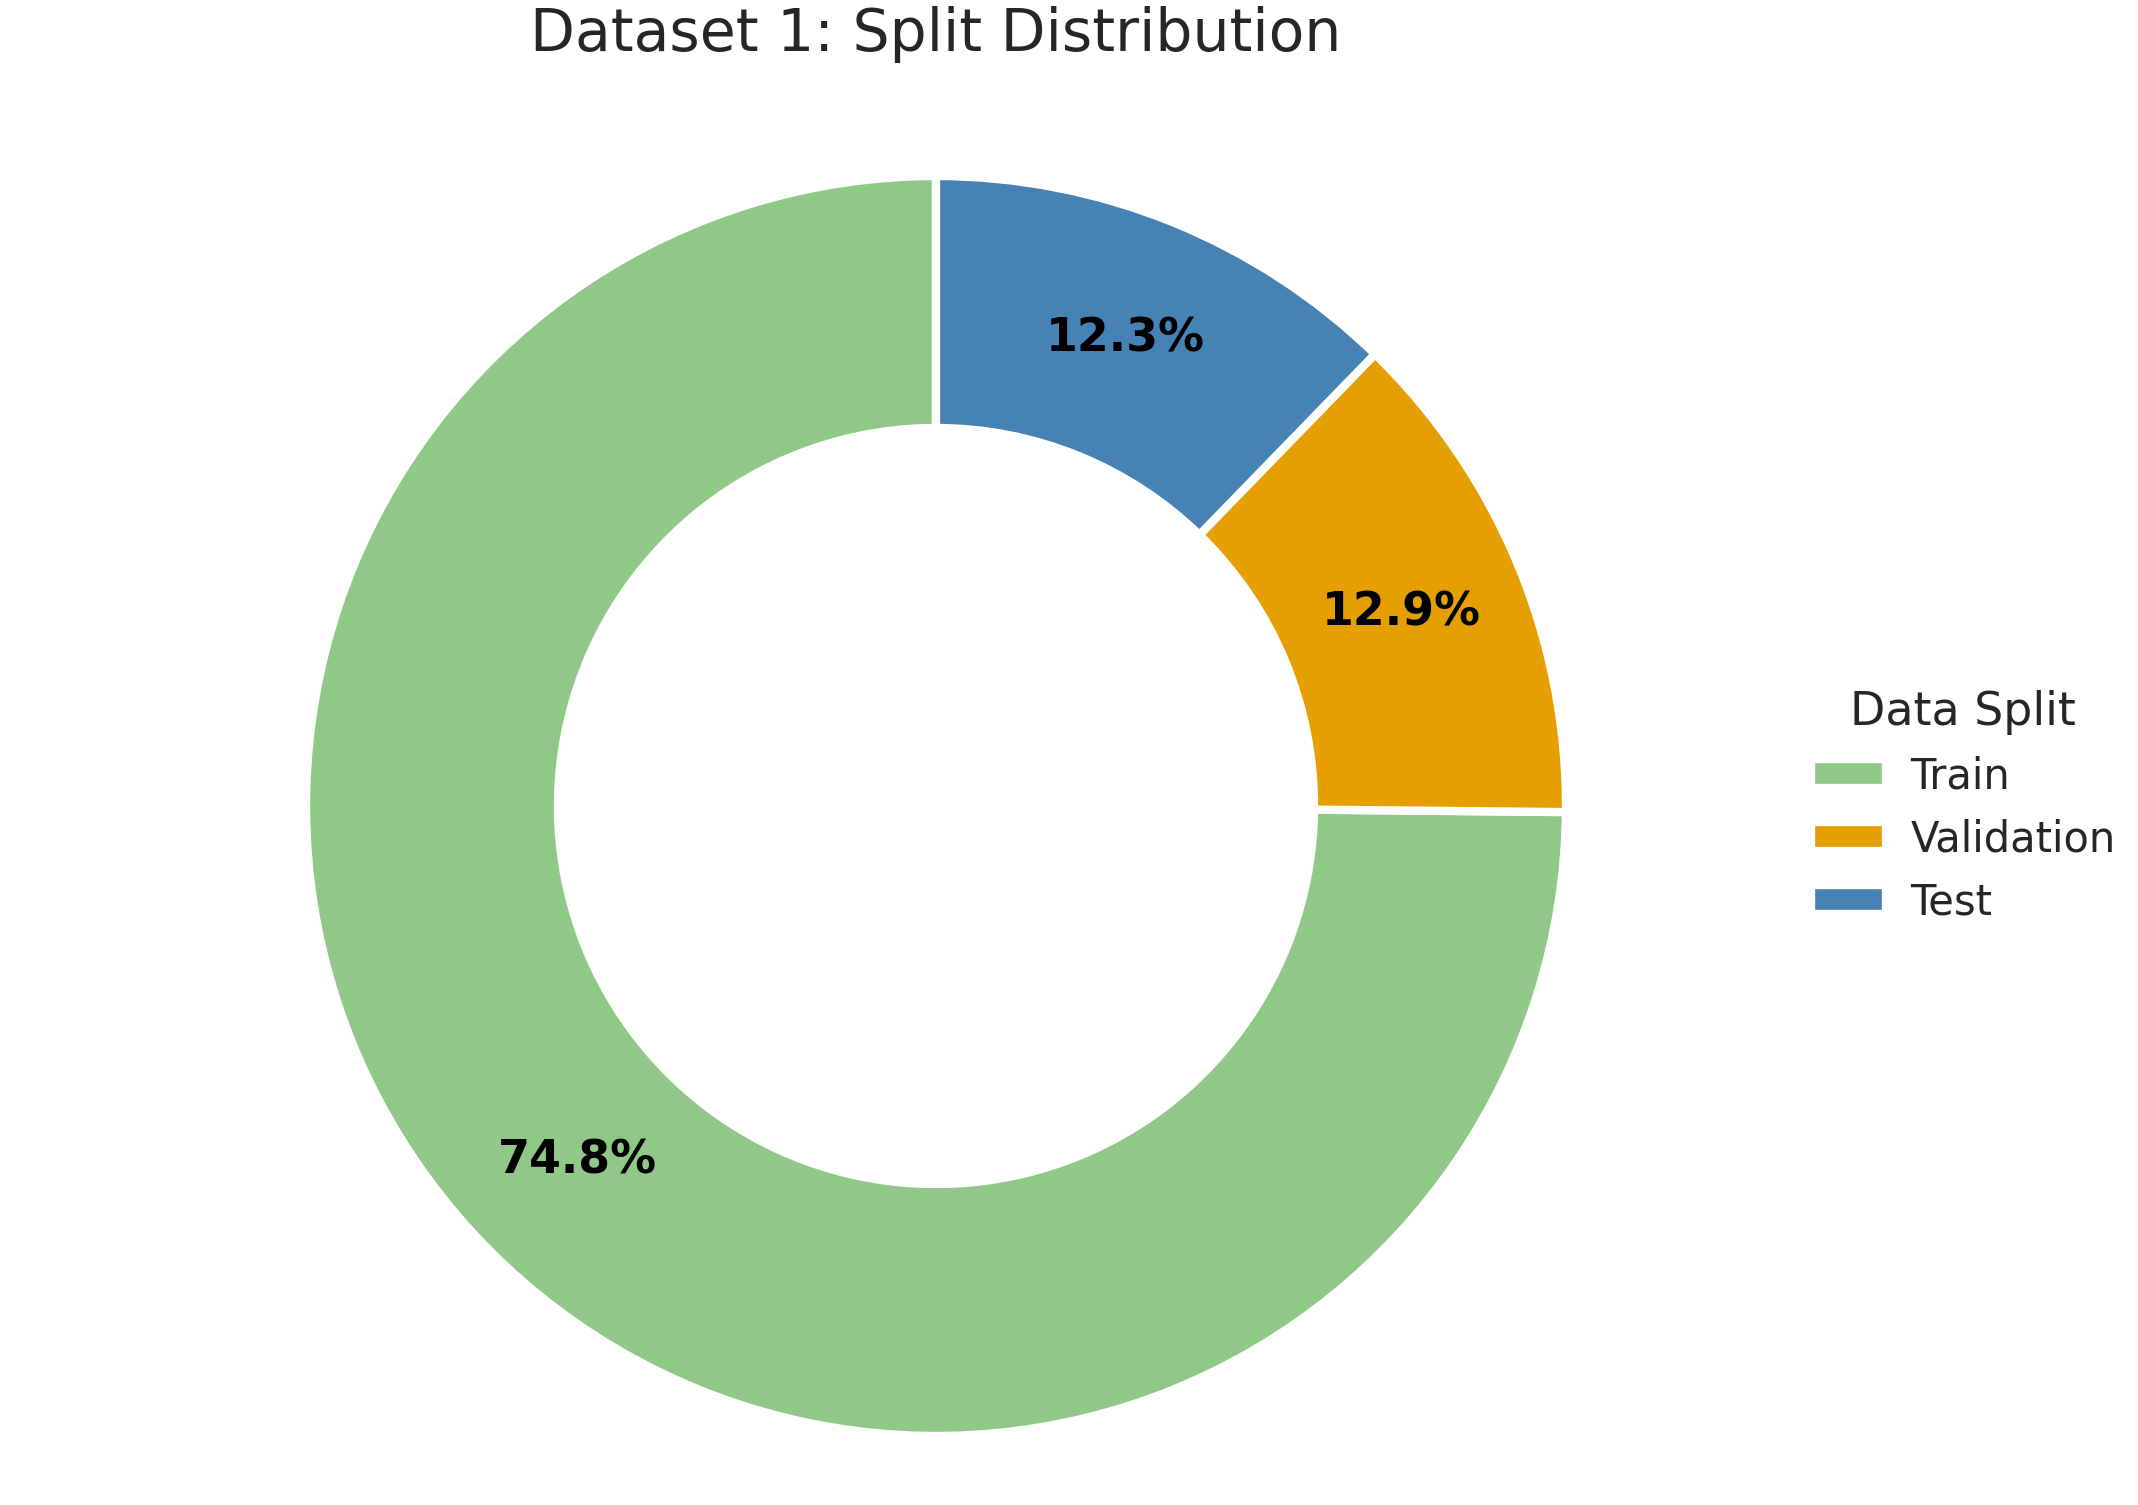

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from style.style_manager import StyleManager # Assuming style.style_manager.py exists


# 2. Input Data (Full)
data = [
    {"dataset": "Dataset 1", "split": "Train", "count": 122},
    {"dataset": "Dataset 1", "split": "Validation", "count": 21},
    {"dataset": "Dataset 1", "split": "Test", "count": 20},
    {"dataset": "Dataset 2", "split": "Train", "count": 589},
    {"dataset": "Dataset 2", "split": "Validation", "count": 105},
    {"dataset": "Dataset 2", "split": "Test", "count": 117},
]

# 3. Data Preparation (Filter for DS1 and calculate percentages)
df = pd.DataFrame(data)

# Filter for Dataset 1
df_ds1 = df[df['dataset'] == "Dataset 1"].copy()

# Calculate percentages
df_ds1['percentage'] = (df_ds1['count'] / df_ds1['count'].sum()) * 100

# Ensure logical order
split_order = ['Train', 'Validation', 'Test']
df_ds1 = df_ds1.set_index('split').reindex(split_order)

print("Data prepared for plotting (Dataset 1 percentages):")
print(df_ds1)
print("-" * 30)

# 4. Plot Generation (Donut Chart)
fig, ax = plt.subplots(figsize=(8, 6))

# Define sizes, labels, and the requested colors
sizes = df_ds1['percentage']
labels = df_ds1.index
colors = ['#90C987', '#E69F00', '#4682B4'] # Green, Orange, Blue

# Define the "donut" hole
wedgeprops = {'width': 0.4, 'edgecolor': 'w', 'linewidth': 2}

# Create the pie chart
patches, texts, autotexts = ax.pie(
    sizes, 
    autopct='%1.1f%%',  # Add percentage labels
    startangle=90,
    colors=colors,
    wedgeprops=wedgeprops,
    pctdistance=0.8 # Place percentage labels inside the donut
)

# 5. Styling and Formatting
ax.set_title("Dataset 1: Split Distribution", fontsize=14, pad=15)

# Style the percentage text (autopct) for readability
# We must use black text to contrast with the light green/orange colors
plt.setp(autotexts, size=11, weight="bold", color="black")

# Add a legend adhering to thesis style
ax.legend(
    patches, 
    labels, 
    title="Data Split", 
    loc="center left", 
    bbox_to_anchor=(0.95, 0.5), # Place legend outside the plot
    fontsize=10,
    title_fontsize=11
)

# Ensure the plot is circular
ax.axis('equal')

# 6. Save the figure
save_path = "images/02_dataset_split_ds1_donut.png"
sm.savefig(save_path)

print(f"Plot generation complete. Figure saved to: {save_path}")
plt.show()

In [ ]:
df.head()

dataset       split  count
0  Dataset 1       Train    122
1  Dataset 1  Validation     21
2  Dataset 1        Test     20
3  Dataset 2       Train    589
4  Dataset 2  Validation    105

Saving plot to images/03_ds1_msa_notpt_scatter.png...
Figure saved to images/03_ds1_msa_notpt_scatter.png


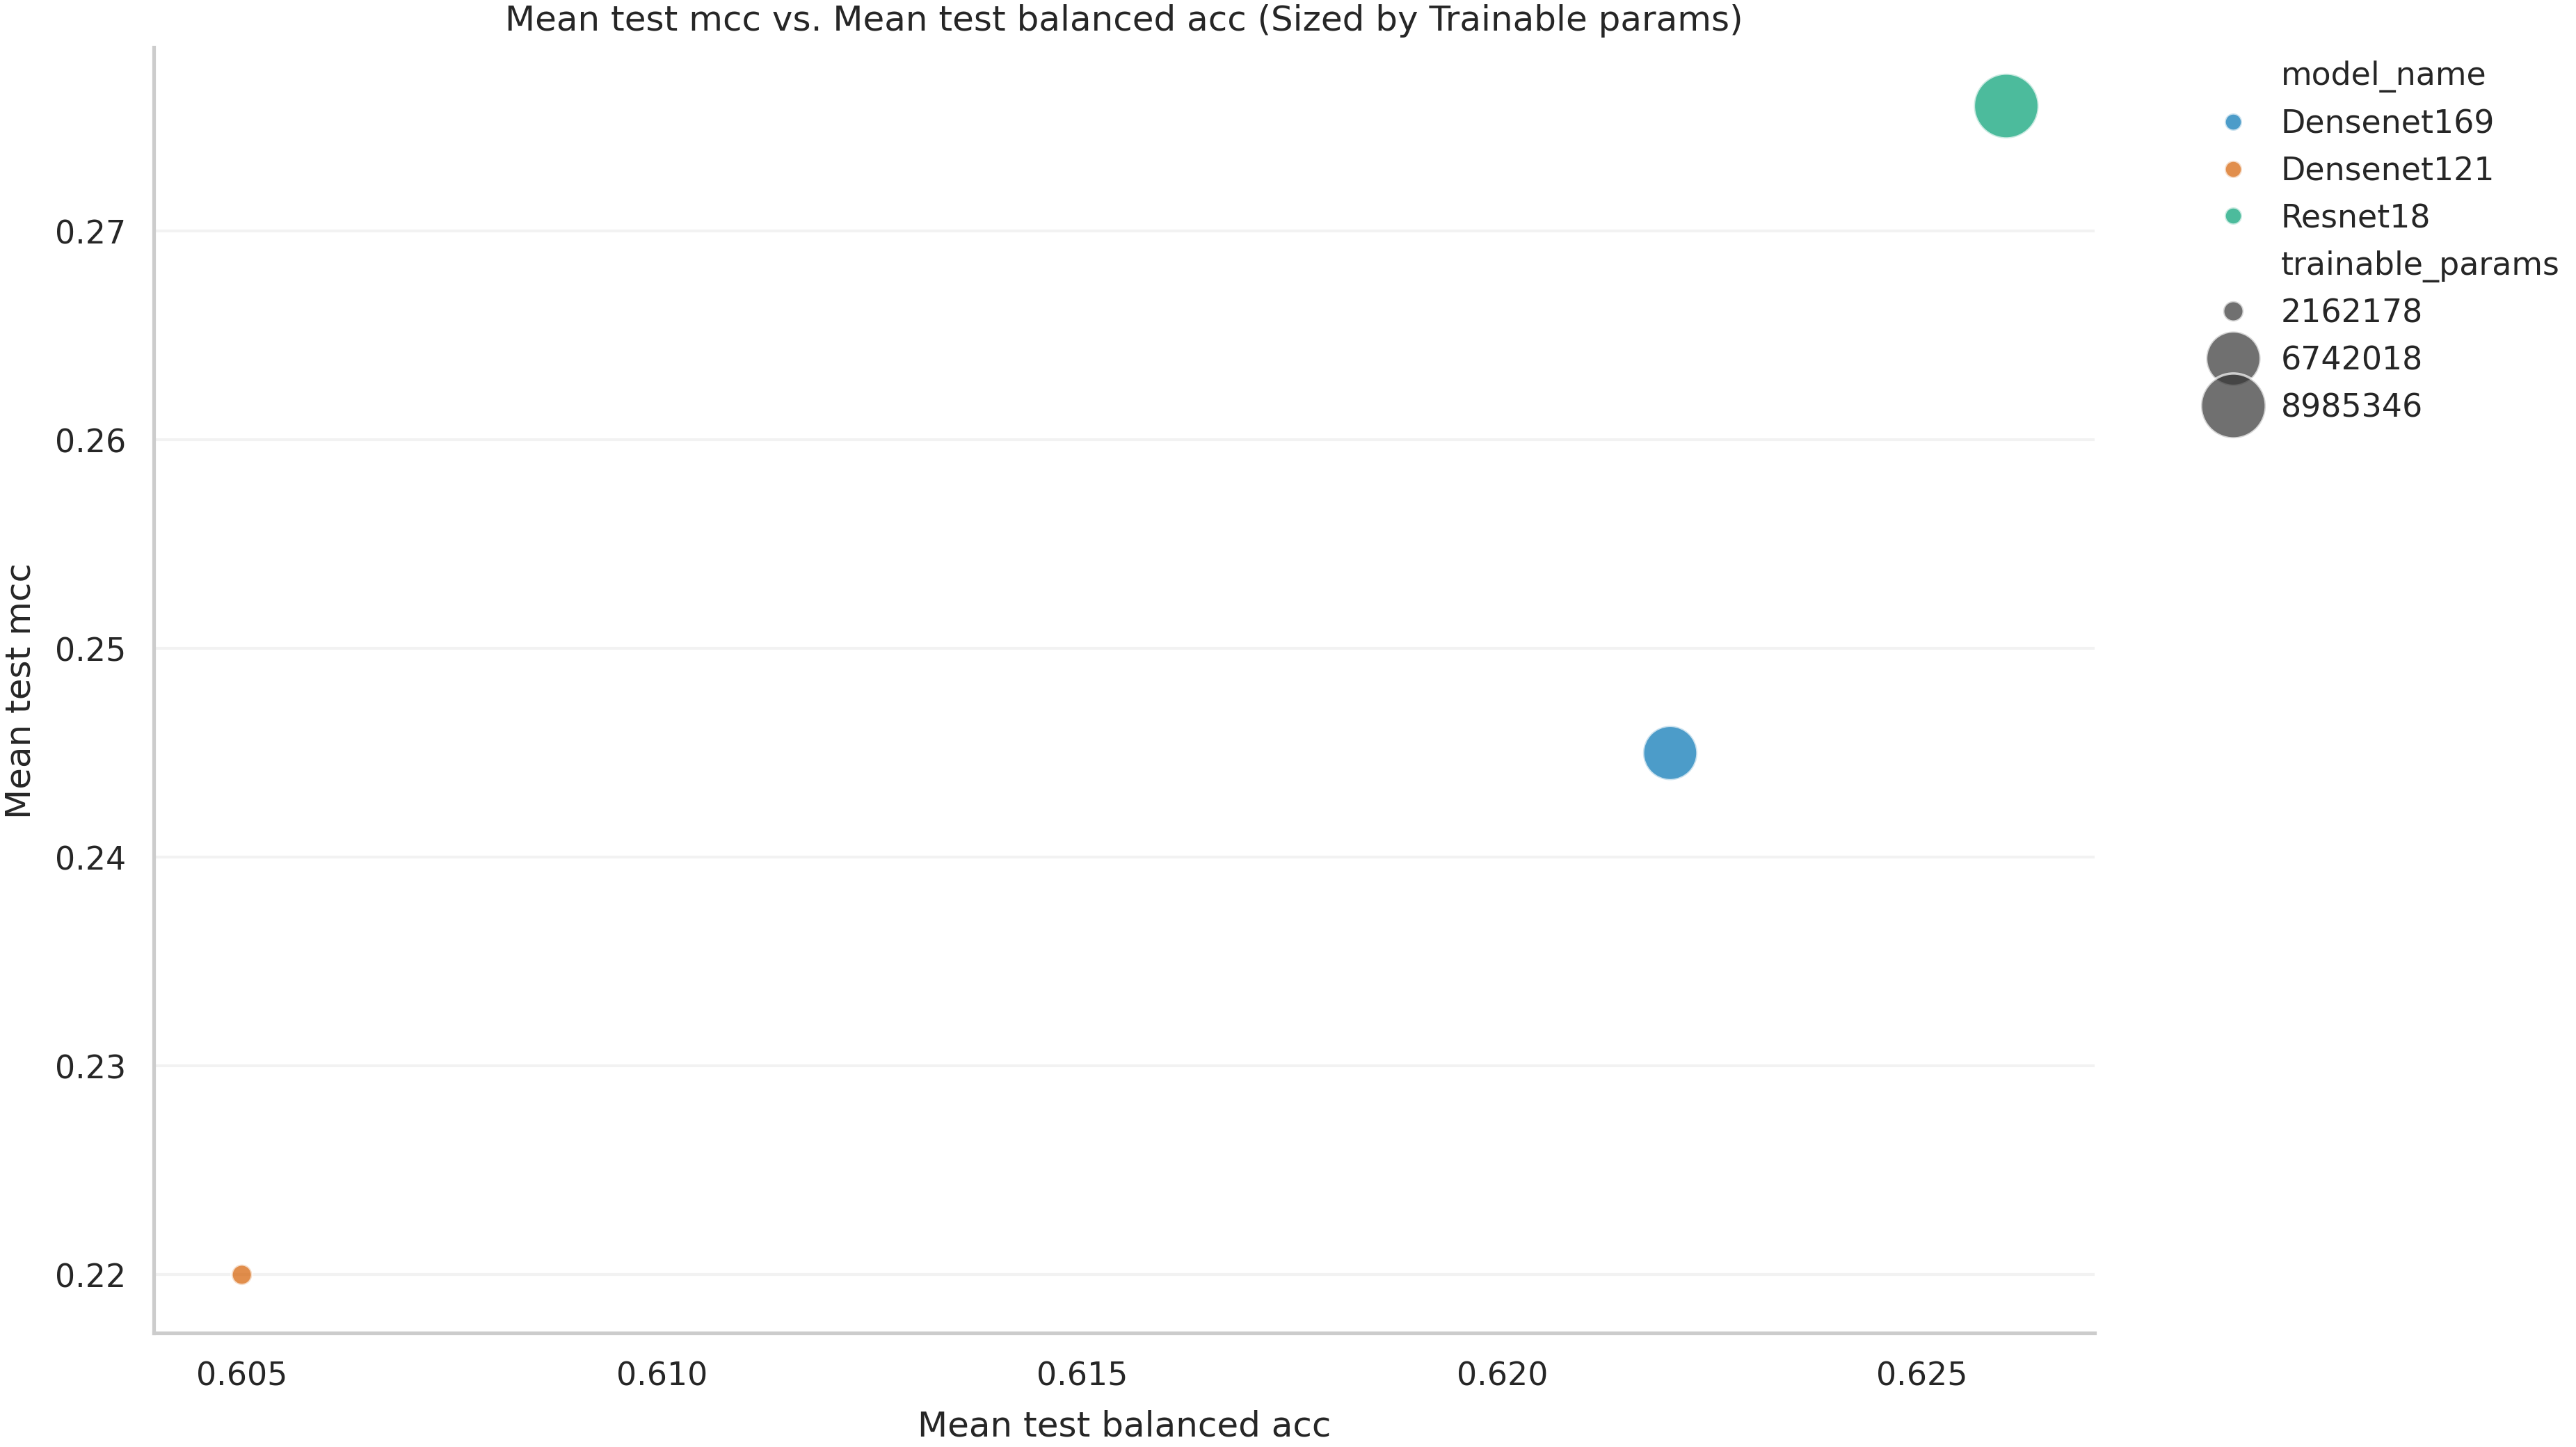

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Import numpy for numeric checks

# We assume 'style_manager as sm' is already imported and activated

def _format_label(col_name):
    """Converts a column name into a human-readable label."""
    return col_name.replace('_', ' ').capitalize()

def plot_performance_scatter_df(df_input, x_col, y_col, 
                                hue_col='model_name', 
                                size_col='trainable_params', 
                                save_filename=None):
    """
    Generates a styled scatterplot comparing two performance metrics from a 
    SINGLE DataFrame.
    
    Args:
        df_input (pd.DataFrame): The input DataFrame to plot.
        x_col (str): The column name for the x-axis.
        y_col (str): The column name for the y-axis.
        hue_col (str): The column name for color encoding.
        size_col (str): The column name for size encoding.
        save_filename (str): The path to save the figure (e.g., "images/my_plot.png").
    """
    
    # --- 1. Data Preparation ---
    # Check for necessary columns in the provided DataFrame
    required_cols = [x_col, y_col, hue_col, size_col]
    if not all(col in df_input.columns for col in required_cols):
        print(f"Error: Missing one or more required columns: {required_cols}")
        return
    
    df_plot = df_input.copy() 

    # --- FIX ---
    # Ensure the plot columns are numeric for correct scaling and plotting.
    # This is critical for the 'size' aesthetic.
    try:
        df_plot[x_col] = pd.to_numeric(df_plot[x_col])
        df_plot[y_col] = pd.to_numeric(df_plot[y_col])
        df_plot[size_col] = pd.to_numeric(df_plot[size_col])
    except ValueError as e:
        print(f"Error: Could not convert columns to numeric. Check data.")
        print(f"Column '{size_col}' must be numeric for size scaling.")
        print(f"Pandas error: {e}")
        return
    # --- END FIX ---

    # --- 2. Plot Generation ---
    # Set the standard Seaborn theme
    sns.set_theme(style="whitegrid", palette=sm.palette)
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Generate the scatterplot
    sns.scatterplot(
        data=df_plot,
        x=x_col,
        y=y_col,
        hue=hue_col,
        size=size_col,
        sizes=(50, 500),  # Set a min/max range for bubble sizes
        alpha=0.7,        # Use transparency
        ax=ax
    )
    
    # --- 3. Style Adherence ---
    # Create formatted labels
    x_label = _format_label(x_col)
    y_label = _format_label(y_col)
    size_label = _format_label(size_col)
    
    # Set labels and title (as per thesis style)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f"{y_label} vs. {x_label} (Sized by {size_label})")
    
    # Remove top and right spines
    sns.despine(ax=ax)
    
    # Move the legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # --- 4. Save Figure ---
    if save_filename:
        print(f"Saving plot to {save_filename}...")
        sm.savefig(save_filename)
    else:
        print("Displaying plot. Note: 'save_filename' not provided; plot will not be saved.")
    
    plt.show()
    
# This will now work:
# plot_performance_scatter_df(
#     df_input=df_ds1_msa_notpt,
#     x_col='mean_test_balanced_acc',
#     y_col='mean_test_mcc',
#     save_filename="images/03_ds1_msa_notpt_scatter.png"
# )

# This will now work:
plot_performance_scatter_df(
    df_input=df_ds1_msap_pretrained_imagenet,
    x_col='mean_test_balanced_acc',
    y_col='mean_test_mcc',
    save_filename="images/03_ds1_msa_notpt_scatter.png"
)

In [ ]:
df_ds1_msap_pretrained_imagenet[["model_name","trainable_params"]].head()

model_name trainable_params
68  Densenet169          6742018
71  Densenet121          2162178
74     Resnet18          8985346

# BAR PLOTS WITH ERRORS

Figure saved to images/bar_err_plots/errorbar_bal_acc_ds1_msa_notpt.png
Plotted 4 architectures:
  DenseNet121: 0.672 ± 0.126 (n=1)
  DenseNet169: 0.641 ± 0.091 (n=1)
  ResNet18: 0.639 ± 0.167 (n=1)
  ViT: 0.547 ± 0.102 (n=1)
Figure saved to images/bar_err_plots/errorbar_mcc_ds1_msa_notpt.png
Plotted 4 architectures:
  DenseNet121: 0.345 ± 0.243 (n=1)
  DenseNet169: 0.314 ± 0.178 (n=1)
  ResNet18: 0.273 ± 0.323 (n=1)
  ViT: 0.092 ± 0.235 (n=1)


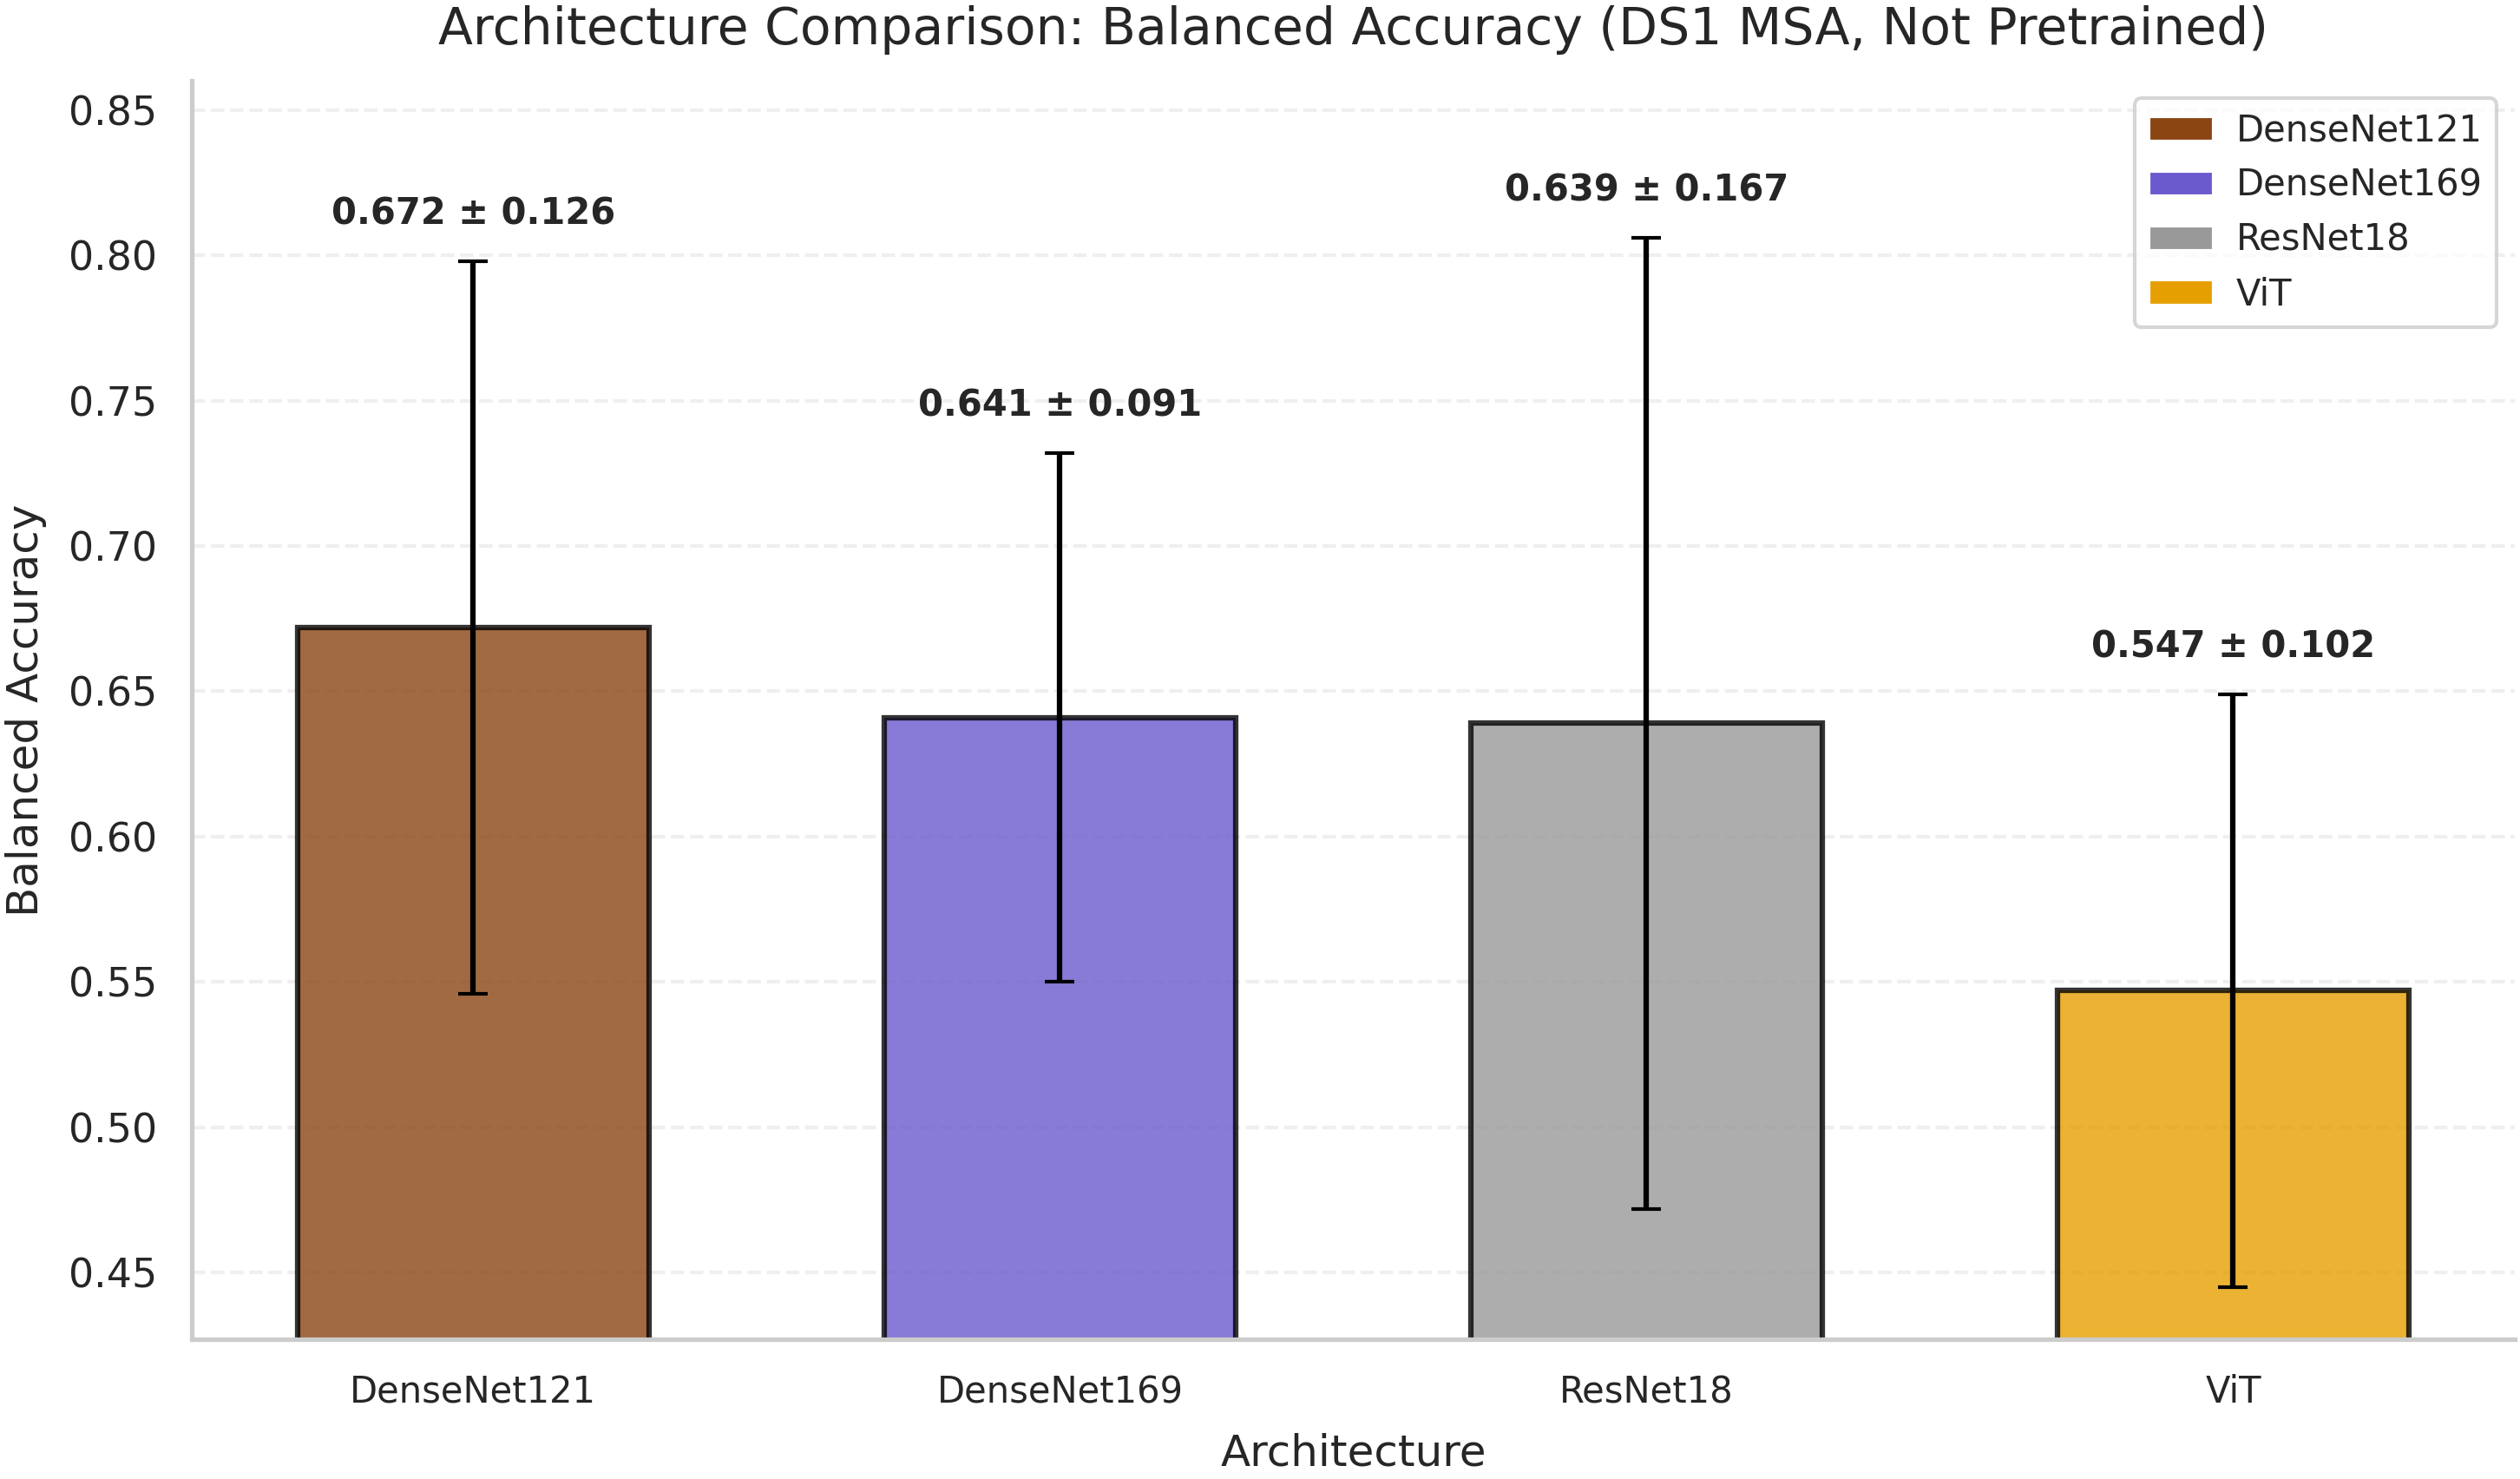

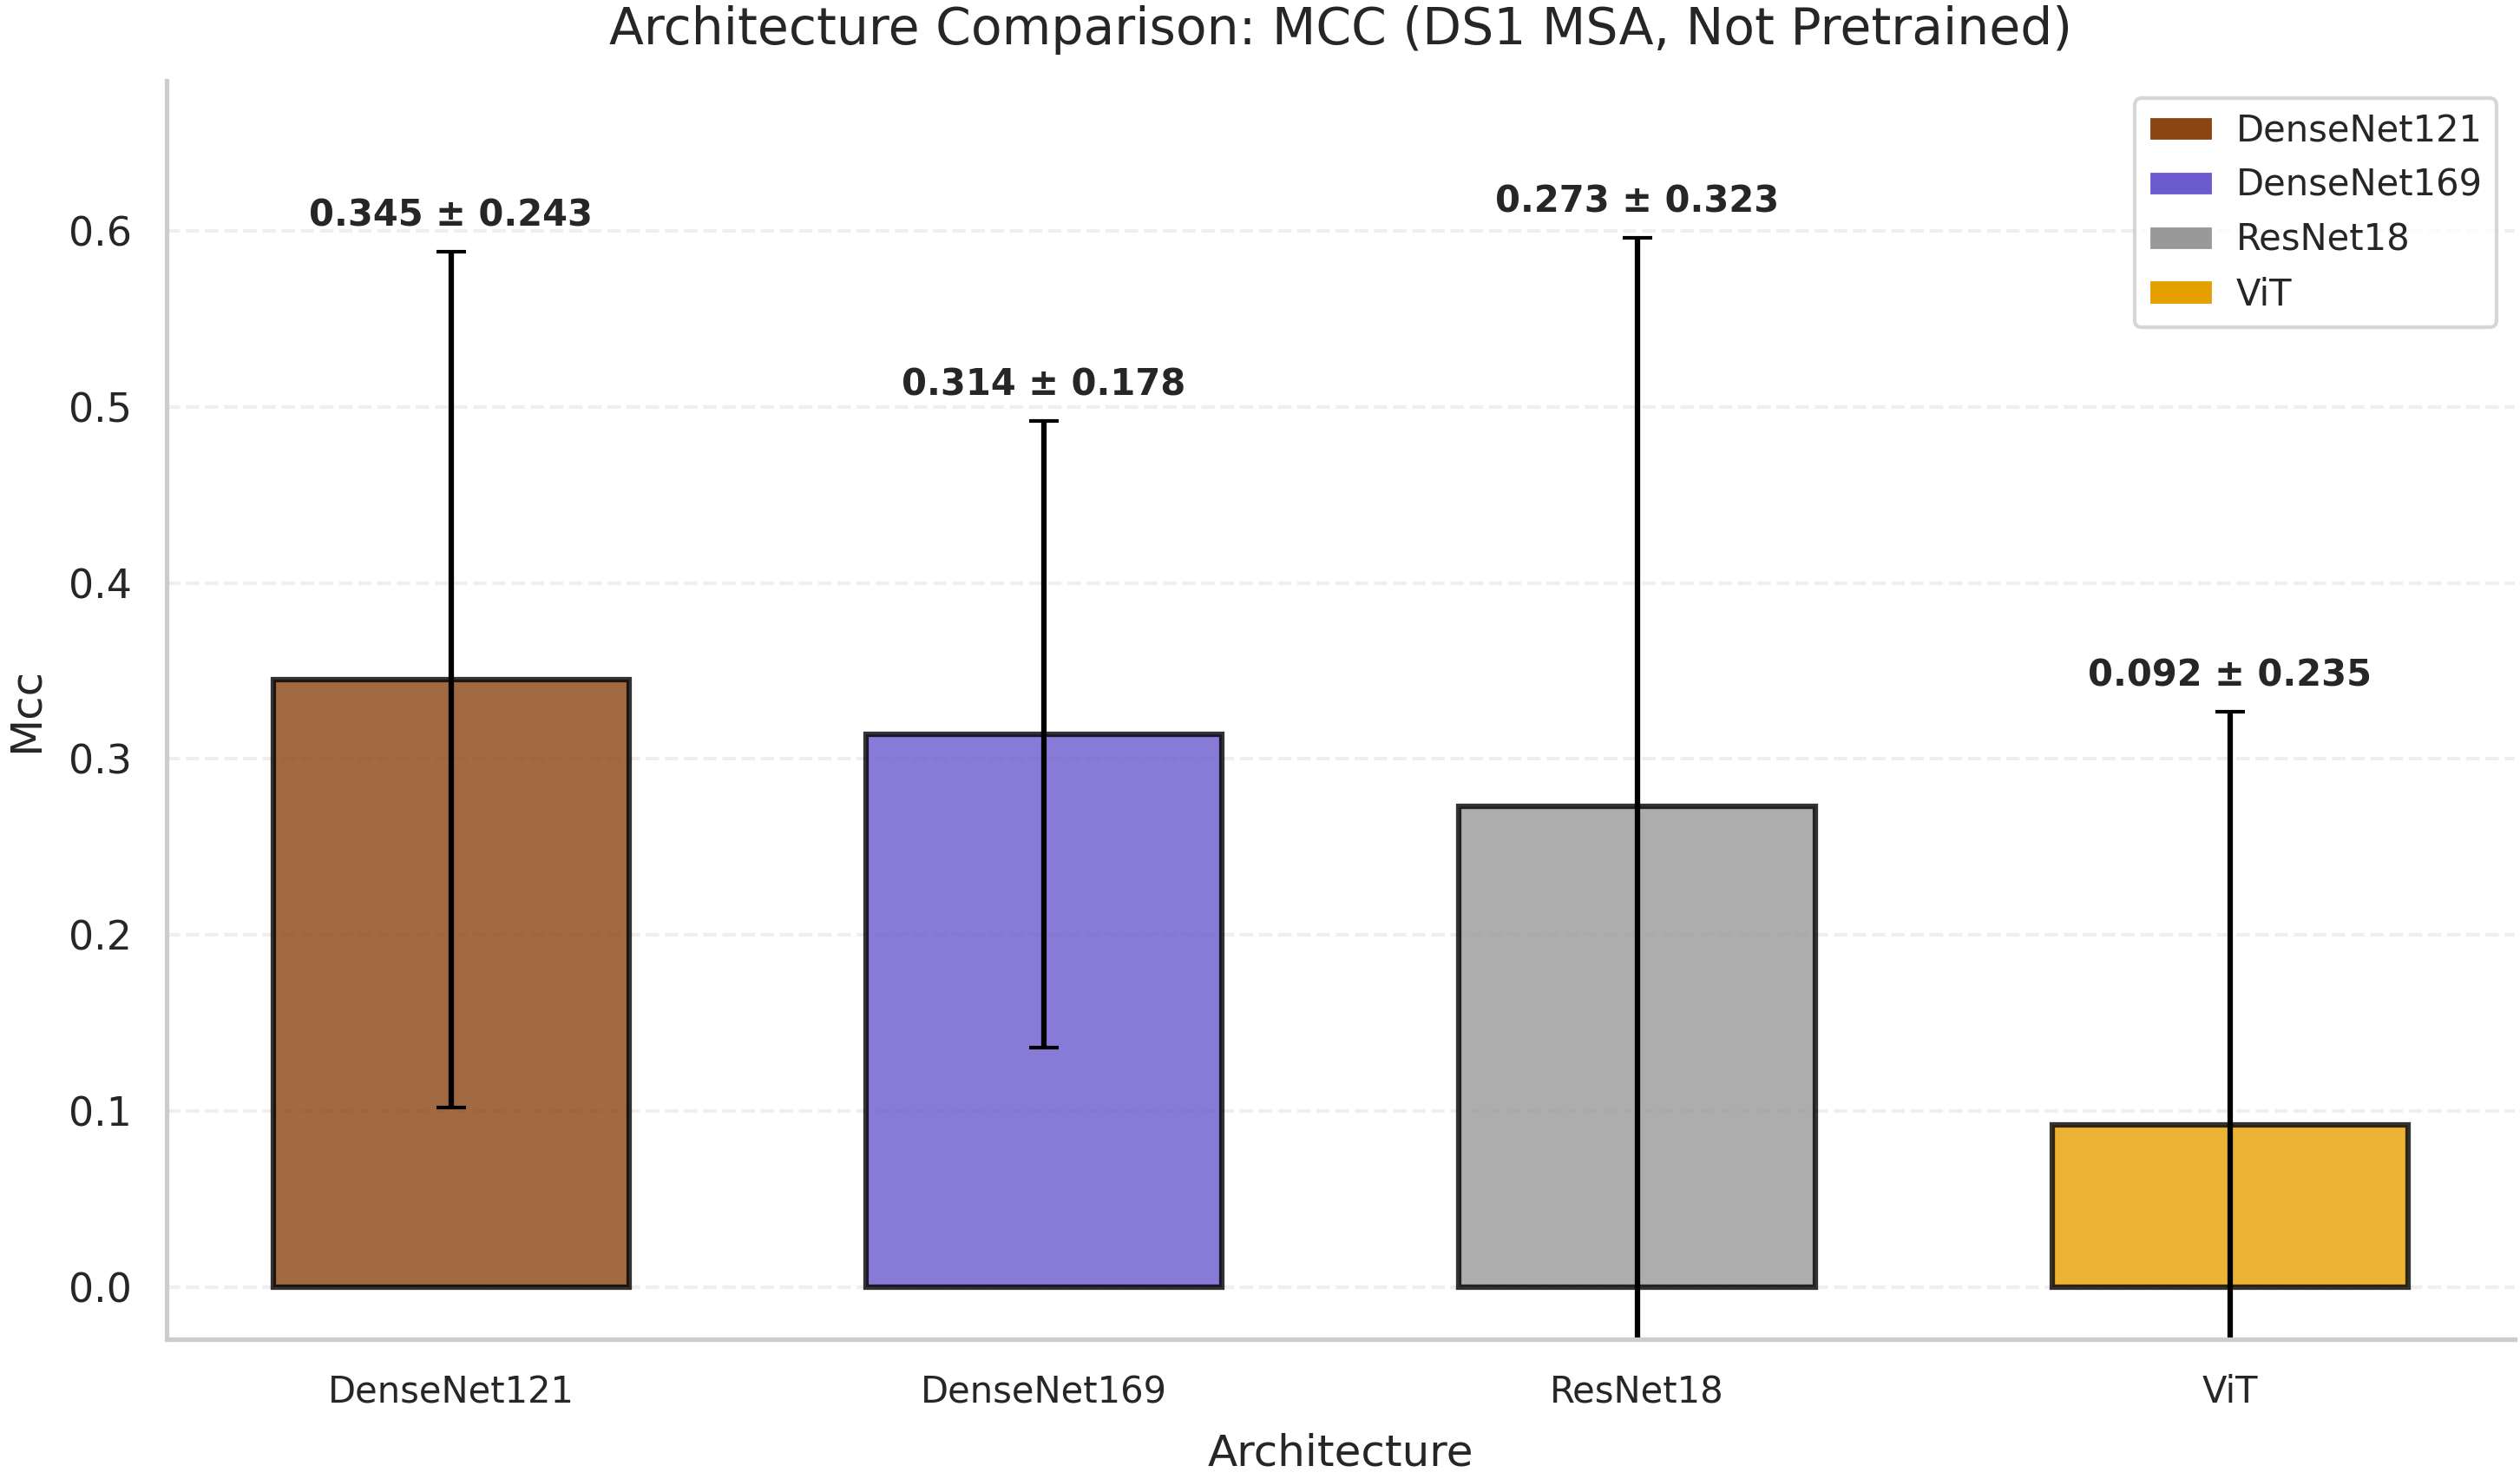

In [78]:
"""
Error Bar Plots for Architecture Comparison
-------------------------------------------
Creates error bar plots comparing the 4 main architectures (Vit, ResNet18, 
DenseNet121, DenseNet169) from a dataframe with mean and std metrics.

Usage:
    from style.style_manager import StyleManager
    import pandas as pd
    
    # Assuming you have a dataframe from dfs_to_export
    df = df_ds1_msa_notpt  # or any other dataframe
    
    # Create error bar plot for balanced accuracy
    create_architecture_errorbar_plot(
        df, 
        metric='mean_test_balanced_acc',
        std_metric='std_test_balanced_acc',
        title='Architecture Comparison: Balanced Accuracy',
        filename='architecture_errorbar_bal_acc.png'
    )
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re

# Import StyleManager
try:
    from style.style_manager import StyleManager
except ImportError:
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == 'notebooks':
        project_root = os.path.dirname(current_dir)
        sys.path.insert(0, project_root)
    else:
        parent_dir = os.path.dirname(current_dir)
        sys.path.insert(0, parent_dir)
    from style.style_manager import StyleManager

# Initialize style
current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebooks':
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

mplstyle_path = os.path.join(project_root, 'style', 'thesis_style.mplstyle')
sm = StyleManager(mplstyle_path=mplstyle_path)
sm.activate()
sns.set_theme(style="whitegrid", palette=sm.palette)

# Architecture colors from plotting.mdc
architecture_colors = {
    'vit': '#E69F00',           # Amber (palette[6])
    'resnet18': '#999999',      # Gray (palette[7])
    'densenet121': '#8B4513',   # Saddle brown
    'densenet169': '#6A5ACD',   # Slate blue
}

# Architecture display names
architecture_names = {
    'vit': 'ViT',
    'resnet18': 'ResNet18',
    'densenet121': 'DenseNet121',
    'densenet169': 'DenseNet169',
}


def extract_architecture_name(model_name: str) -> str:
    """
    Extract architecture family name from model_name.
    
    Parameters
    ----------
    model_name : str
        Full model name (e.g., 'Densenet121_oversamp_TL', 'resnet18', 'vit_b16')
        
    Returns
    -------
    str
        Architecture family name: 'vit', 'resnet18', 'densenet121', 'densenet169', or 'unknown'
    """
    if not isinstance(model_name, str):
        return 'unknown'
    
    name_lower = model_name.lower()
    
    # Check for ViT
    if 'vit' in name_lower:
        return 'vit'
    
    # Check for ResNet18
    if 'resnet18' in name_lower or 'resnet_18' in name_lower:
        return 'resnet18'
    
    # Check for DenseNet121
    if 'densenet121' in name_lower or 'densenet_121' in name_lower:
        return 'densenet121'
    
    # Check for DenseNet169
    if 'densenet169' in name_lower or 'densenet_169' in name_lower:
        return 'densenet169'
    
    # Try regex pattern matching
    match = re.search(r'(densenet\d+|resnet\d+|vit)', name_lower)
    if match:
        arch = match.group(1)
        if 'densenet121' in arch:
            return 'densenet121'
        elif 'densenet169' in arch:
            return 'densenet169'
        elif 'resnet18' in arch:
            return 'resnet18'
        elif 'vit' in arch:
            return 'vit'
    
    return 'unknown'


def create_architecture_errorbar_plot(
    df: pd.DataFrame,
    metric: str = 'mean_test_balanced_acc',
    std_metric: str = 'std_test_balanced_acc',
    title: str = 'Architecture Comparison',
    ylabel: str = None,
    filename: str = 'architecture_errorbar.png',
    output_dir: str = 'images/bar_err_plots',
    architectures: list = ['vit', 'resnet18', 'densenet121', 'densenet169'],
    figsize: tuple = (10, 6)
) -> str:
    """
    Create error bar plot comparing the 4 main architectures.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with model_name, metric, and std_metric columns.
    metric : str
        Column name for the mean metric (default: 'mean_test_balanced_acc').
    std_metric : str
        Column name for the standard deviation (default: 'std_test_balanced_acc').
    title : str
        Plot title.
    ylabel : str, optional
        Y-axis label. If None, derived from metric name.
    filename : str
        Output filename.
    output_dir : str
        Directory to save the figure.
    architectures : list
        List of architecture names to include.
    figsize : tuple
        Figure size (width, height).
        
    Returns
    -------
    str
        Path to saved figure.
    """
    # Filter dataframe to only include valid data
    required_cols = ['model_name', metric, std_metric]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(
            f"Missing required columns: {missing_cols}. "
            f"Available columns: {list(df.columns)}"
        )
    
    # Remove rows with missing values
    df_clean = df[required_cols].copy()
    df_clean = df_clean.dropna(subset=[metric, std_metric])
    
    if df_clean.empty:
        print(f"Warning: No valid data found after filtering. DataFrame has {len(df)} rows.")
        return None
    
    # Extract architecture names
    df_clean['arch_family'] = df_clean['model_name'].apply(extract_architecture_name)
    
    # Filter to only include the 4 main architectures
    df_clean = df_clean[df_clean['arch_family'].isin(architectures)]
    
    if df_clean.empty:
        print(f"Warning: No data found for architectures {architectures}.")
        print(f"Found architectures: {df_clean['arch_family'].unique() if 'arch_family' in df_clean.columns else 'N/A'}")
        return None
    
    # Group by architecture and aggregate (in case of multiple runs per architecture)
    # Use mean of means and calculate pooled std if multiple runs
    arch_data = []
    for arch in architectures:
        arch_df = df_clean[df_clean['arch_family'] == arch]
        if not arch_df.empty:
            # Take mean of means
            mean_val = arch_df[metric].mean()
            # For std: use max(std) or sqrt(mean(std^2)) - here we use max for simplicity
            # Alternatively, you might want to keep the std from a single best run
            std_val = arch_df[std_metric].max()  # Conservative: use max std
            arch_data.append({
                'architecture': arch,
                'mean': mean_val,
                'std': std_val,
                'count': len(arch_df)
            })
    
    if not arch_data:
        print("Warning: No architecture data to plot.")
        return None
    
    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(arch_data)
    
    # Sort by mean value for better visualization
    plot_df = plot_df.sort_values('mean', ascending=False)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Prepare x positions and data
    x_pos = np.arange(len(plot_df))
    means = plot_df['mean'].values
    stds = plot_df['std'].values
    arch_labels = [architecture_names[arch] for arch in plot_df['architecture'].values]
    
    # Create colors list
    colors = [architecture_colors.get(arch, sm.palette[0]) for arch in plot_df['architecture'].values]
    
    # Create error bar plot
    bars = ax.bar(
        x_pos,
        means,
        yerr=stds,
        capsize=4,
        ecolor='black',
        edgecolor='black',
        linewidth=1.5,
        color=colors,
        alpha=0.8,
        width=0.6
    )
    
    # Add value labels on top of bars
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + std + 0.01,  # Position above error bar
            f'{mean:.3f} ± {std:.3f}',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )
    
    # Customize plot
    ax.set_xlabel('Architecture', fontsize=12)
    if ylabel is None:
        # Derive ylabel from metric name
        ylabel = metric.replace('mean_', '').replace('_', ' ').title()
        # Clean up common patterns
        ylabel = ylabel.replace('Test ', '').replace('Balanced Acc', 'Balanced Accuracy')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(arch_labels, fontsize=10)
    
    # Set y-axis limits
    y_max = (means + stds).max()
    y_min = max(0, (means - stds).min())
    ax.set_ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.15 * (y_max - y_min))
    
    # Add grid
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend with architecture colors
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=architecture_colors[arch], label=architecture_names[arch])
        for arch in plot_df['architecture'].values
    ]
    ax.legend(handles=legend_elements, loc='best', frameon=True, fontsize=10)
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    sm.savefig(output_path)
    
    print(f"Plotted {len(plot_df)} architectures:")
    for _, row in plot_df.iterrows():
        print(f"  {architecture_names[row['architecture']]}: "
              f"{row['mean']:.3f} ± {row['std']:.3f} (n={row['count']})")
    
    return output_path


# Example usage:
if __name__ == "__main__" or True:  # Set to True for notebook execution
    # Example: Create error bar plot for a dataframe
    # Assuming you have df_ds1_msa_notpt or similar available
    
    # Uncomment and modify as needed:
    create_architecture_errorbar_plot(
        df_ds1_msa_notpt,
        metric='mean_test_balanced_acc',
        std_metric='std_test_balanced_acc',
        title='Architecture Comparison: Balanced Accuracy (DS1 MSA, Not Pretrained)',
        filename='errorbar_bal_acc_ds1_msa_notpt.png'
    )
    
    # You can also create plots for other metrics:
    create_architecture_errorbar_plot(
        df_ds1_msa_notpt,
        metric='mean_test_mcc',
        std_metric='std_test_mcc',
        title='Architecture Comparison: MCC (DS1 MSA, Not Pretrained)',
        filename='errorbar_mcc_ds1_msa_notpt.png'
    )
    
    pass

 Missing required columns: ['patient_major_bal_acc_std_formatted', 'patient_major_f1_formatted', 'patient_major_f1_std_formatted']. Available columns: ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels', 'best_lr', 'creation_date', 'creation_time', 'dropout_rate', 'epochs', 'freezed_layer_index', 'intensity_augmentation_preset', 'lr_discovery_folds', 'mixup_alpha', 'model_library', 'model_name', 'optimizer_name', 'pretrained_weights', 'test_counts', 'test_pat_ids_for_best_fold', 'test_pat_ids_per_fold', 'total_params', 'train_counts', 'trainable_params', 'transfer_learning', 'val_counts', 'weight_decay', 'exec_time_min', 'mean_patient_major_bal_acc', 'mean_patient_major_mcc', 'mean_patient_major_precision', 'mean_patient_major_recall', 'mean_patient_soft_bal_acc', 'mean_patient_soft_mcc', 'mean_patient_soft_precision', 'mean_patient_soft_recall', 'mean_test_accuracy', 'mean_test_auc', 'mean_test_balanced_acc', 'mean_test_f1', 'mean_test_mcc', 'mean_test_precision', 'mean_test_recall', 'std_patient_major_bal_acc', 'std_patient_major_mcc', 'std_patient_major_precision', 'std_patient_major_recall', 'std_patient_soft_bal_acc', 'std_patient_soft_mcc', 'std_patient_soft_precision', 'std_patient_soft_recall', 'std_test_accuracy', 'std_test_auc', 'std_test_balanced_acc', 'std_test_f1', 'std_test_mcc', 'std_test_precision', 'std_test_recall', 'patient_major_bal_acc_formatted', 'patient_major_mcc_formatted', 'patient_major_precision_formatted', 'patient_major_recall_formatted', 'patient_soft_bal_acc_formatted', 'patient_soft_mcc_formatted', 'patient_soft_precision_formatted', 'patient_soft_recall_formatted']

Figure saved to images/bar_err_plots/grouped_bal_acc_f1_ds1_msap_notpt_4c.png
Plotted 4 architectures:
  DenseNet121: BalAcc 0.818 ± 0.141 | Recall 0.865 ± 0.186 (n=1)
  DenseNet169: BalAcc 0.792 ± 0.174 | Recall 0.833 ± 0.182 (n=1)
  ResNet18: BalAcc 0.792 ± 0.172 | Recall 0.865 ± 0.138 (n=1)
  ViT: BalAcc 0.682 ± 0.153 | Recall 0.833 ± 0.182 (n=1)


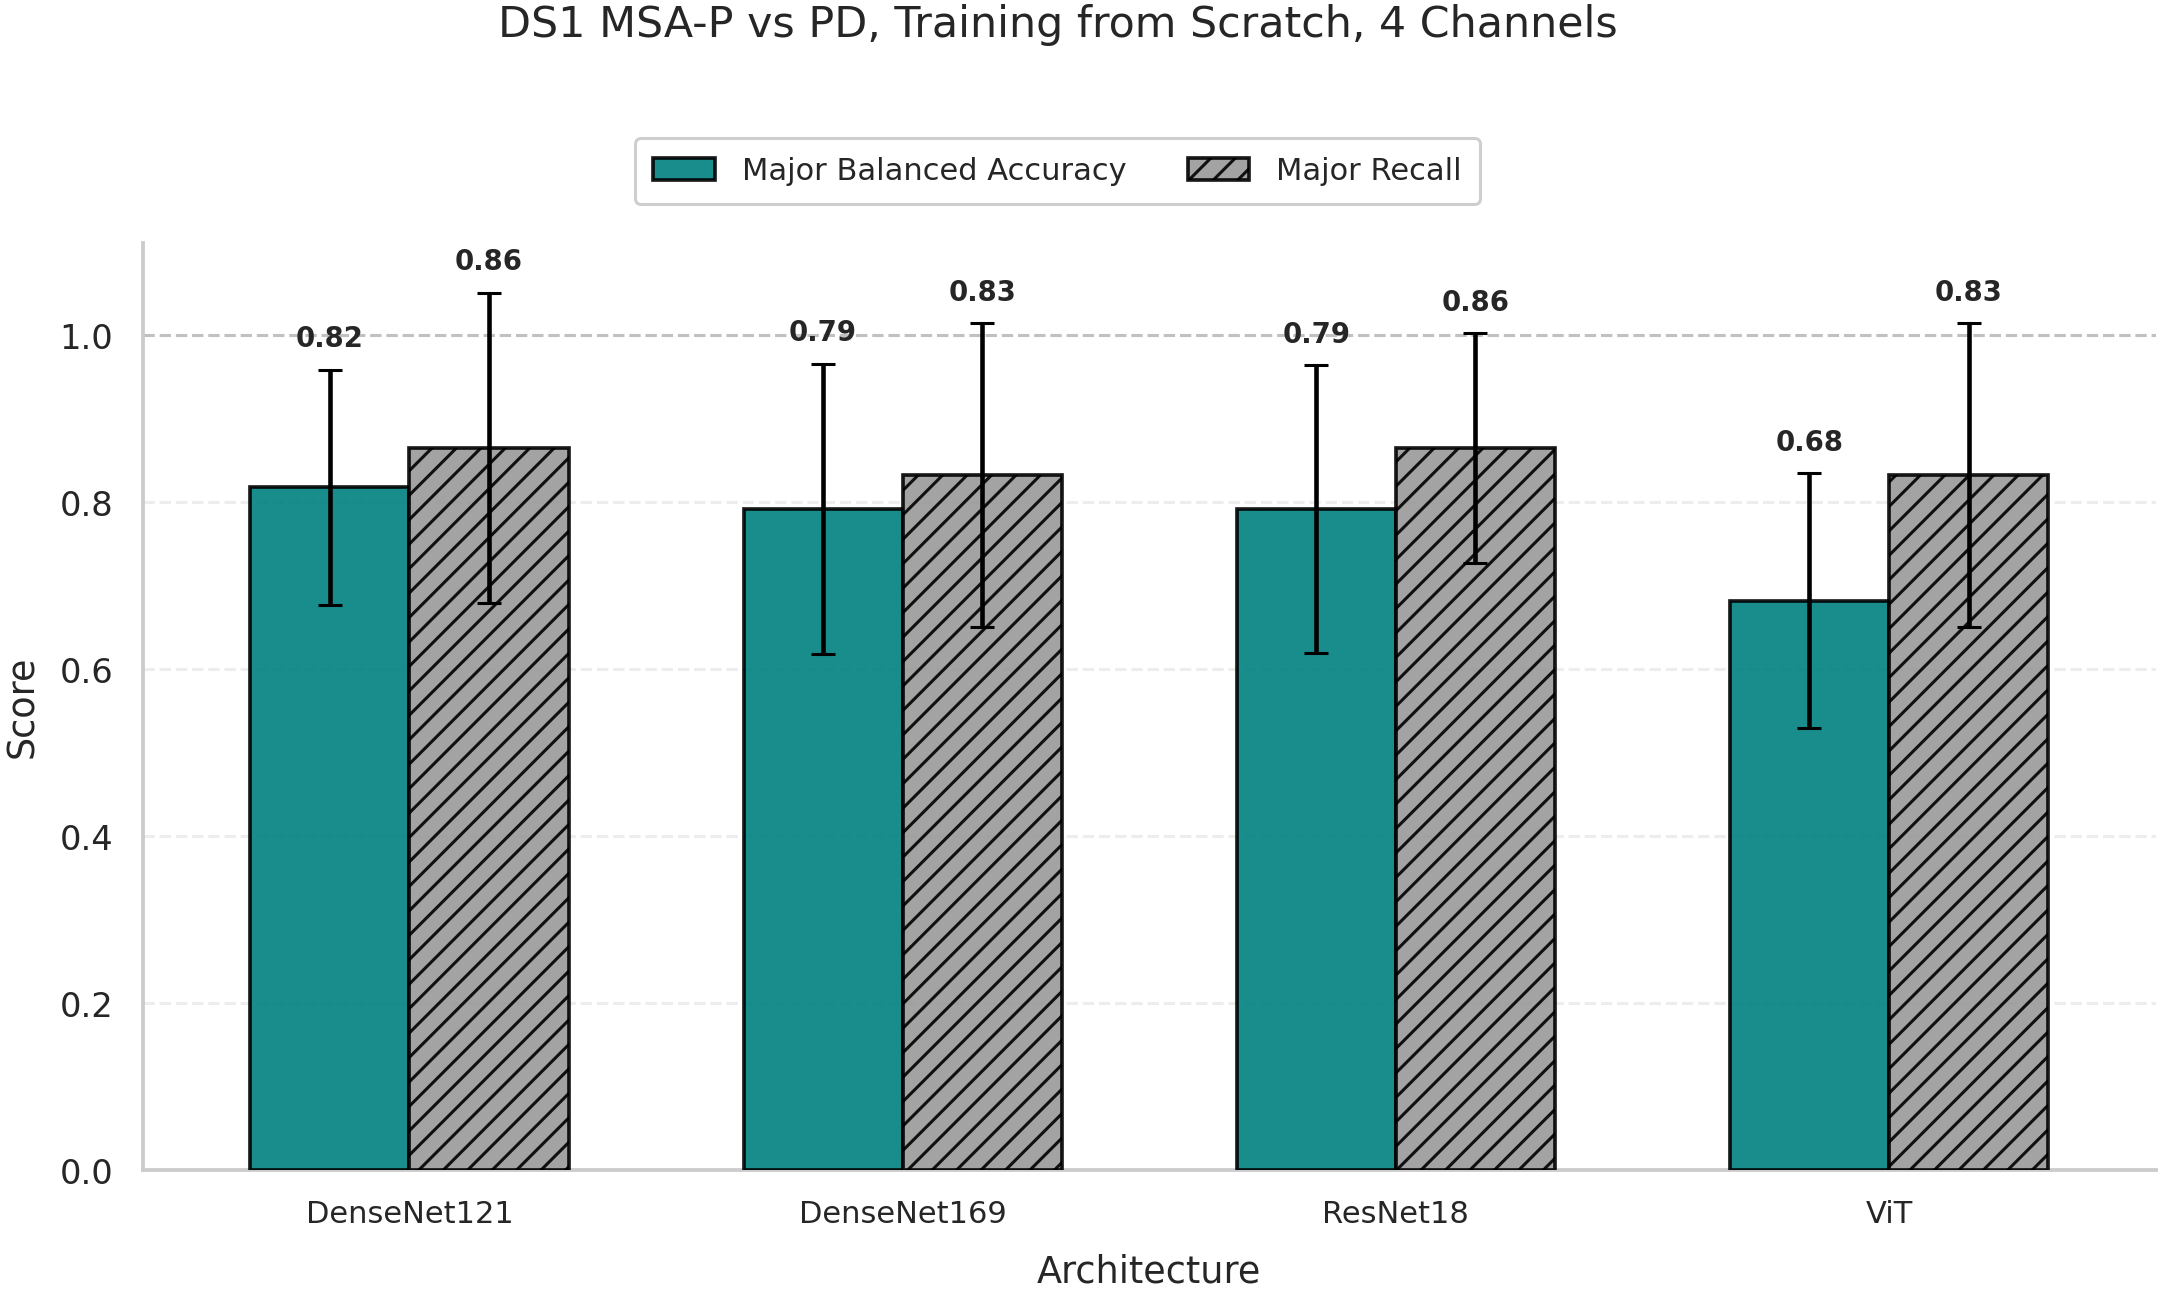

In [ ]:
"""
Grouped Error Bar Plot: Balanced Accuracy and MCC
--------------------------------------------------------
Creates a grouped bar chart comparing Balanced Accuracy and MCC 
side-by-side for each architecture in a single plot.
"""

"""
Grouped Error Bar Plot: Balanced Accuracy and Major Recall
--------------------------------------------------------
Creates a grouped bar chart comparing Balanced Accuracy and Major Recall 
side-by-side for each architecture in a single plot.
"""
# expects: sm, architecture_names, extract_architecture_name

import os
from typing import Optional, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# expects in your environment:
# - sm: StyleManager with .palette and .savefig(path, ...)
# - extract_architecture_name(model_name: str) -> str
# - architecture_names: dict like {"resnet18": "ResNet-18", ...}

def create_grouped_bal_acc_recall_errorbar_plot(
    df: pd.DataFrame,
    bal_acc_metric: str = 'mean_patient_major_bal_acc',
    bal_acc_std: str = 'std_patient_major_bal_acc',
    recall_metric: str = 'mean_patient_major_recall',
    recall_std: str = 'std_patient_major_recall',
    title: str = 'Architecture Comparison: Balanced Accuracy and Major Recall',
    ylabel: str = 'Score',
    filename: str = 'grouped_bal_acc_recall_errorbar.png',
    output_dir: str = 'images/bar_err_plots',
    architectures: Tuple[str, ...] = ('vit', 'resnet18', 'densenet121', 'densenet169'),
    # --- Layout controls ---
    base_width_in: float = 9.5,     # base figure width (inches)
    per_group_in: float = 0.9,      # extra width per architecture beyond 3
    min_height_in: float = 6.2,     # figure height (inches)
    dpi: int = 220,                 # export resolution
    # --- Spacing controls ---
    bar_width: float = 0.5,        # width of each bar within a group
    group_spacing: float = 1.55,    # >1.0 increases distance between groups
) -> Optional[str]:
    """
    Create a grouped error-bar bar chart comparing Balanced Accuracy and Major Recall
    side-by-side for each architecture, with legend placed directly below the title.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns: 'model_name', bal_acc_metric, bal_acc_std, recall_metric, recall_std.
    bal_acc_metric, bal_acc_std, recall_metric, recall_std : str
        Column names for means and stds of the two metrics.
    title : str
        Figure title (rendered as suptitle).
    ylabel : str
        Y-axis label.
    filename : str
        Output filename (PNG).
    output_dir : str
        Directory where the image is saved.
    architectures : tuple[str, ...]
        Architecture families to include (matched via extract_architecture_name).
    base_width_in, per_group_in, min_height_in : float
        Figure size controls (inches). Width grows with number of groups.
    dpi : int
        Export resolution.
    bar_width : float
        Width of each bar (0.18–0.36 typical).
    group_spacing : float
        Multiplier spacing between architecture groups (1.2–1.9 typical).

    Returns
    -------
    Optional[str]
        Path to the saved figure, or None if no data to plot.
    """
    # --- Validate columns
    required_cols = ['model_name', bal_acc_metric, bal_acc_std, recall_metric, recall_std]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Available: {list(df.columns)}")

    df_clean = (
        df[required_cols]
        .dropna(subset=[bal_acc_metric, bal_acc_std, recall_metric, recall_std])
        .copy()
    )
    if df_clean.empty:
        print(f"Warning: No valid data after filtering. Original rows: {len(df)}.")
        return None

    # --- Map model_name -> arch_family and filter
    df_clean['arch_family'] = df_clean['model_name'].apply(extract_architecture_name)
    df_clean = df_clean[df_clean['arch_family'].isin(architectures)]
    if df_clean.empty:
        print(f"Warning: No data for architectures {architectures}.")
        return None

    # --- Aggregate per architecture (mean of means; conservative std via max)
    rows = []
    for arch in architectures:
        sub = df_clean[df_clean['arch_family'] == arch]
        if sub.empty:
            continue
        rows.append({
            'architecture': arch,
            'bal_acc_mean': sub[bal_acc_metric].mean(),
            'bal_acc_std':  sub[bal_acc_std].max(),
            'recall_mean':  sub[recall_metric].mean(),
            'recall_std':   sub[recall_std].max(),
            'count':        len(sub),
        })
    if not rows:
        print("Warning: Nothing to plot after aggregation.")
        return None

    # Define custom architecture order for x-axis
    architecture_order = ['densenet121', 'densenet169', 'resnet18', 'vit']
    order_map = {arch: i for i, arch in enumerate(architecture_order)}
    
    plot_df = pd.DataFrame(rows)
    # Sort by custom architecture order, then by bal_acc_mean as tiebreaker
    plot_df['_order'] = plot_df['architecture'].map(lambda x: order_map.get(x, 999))
    plot_df = plot_df.sort_values(['_order', 'bal_acc_mean'], ascending=[True, False]).drop(columns=['_order']).reset_index(drop=True)
    n = len(plot_df)

    # --- Dynamic figure size
    fig_width = base_width_in + per_group_in * max(n - 3, 0)
    fig_height = min_height_in
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    # Leave headroom for title + legend, and some bottom space for x labels
    fig.subplots_adjust(top=0.80, bottom=0.12, left=0.10, right=0.98)

    # --- X coordinates with extra inter-group spacing
    x = np.arange(n) * float(group_spacing)
    width = float(bar_width)

    # --- Data arrays
    bal_acc_means = plot_df['bal_acc_mean'].to_numpy(float)
    bal_acc_stds  = plot_df['bal_acc_std'].to_numpy(float)
    recall_means  = plot_df['recall_mean'].to_numpy(float)
    recall_stds   = plot_df['recall_std'].to_numpy(float)

    # Labels for x-ticks
    try:
        arch_labels = [architecture_names[a] for a in plot_df['architecture']]
    except Exception:
        arch_labels = list(plot_df['architecture'])

    DEFAULT_METRIC_1_COLOR = '#008080' # Blu
    DEFAULT_GRAY = '#999999'           # Grigio neutro (dalla palette Okabe-Ito)

    # Assegna i colori in modo sicuro
    bal_acc_color =  DEFAULT_METRIC_1_COLOR

    # Usa il grigio della palette se esiste, altrimenti usa il grigio di default
    recall_color =  DEFAULT_GRAY
    # --- Bars
    bars1 = ax.bar(
        x - width/2, bal_acc_means, width,
        yerr=bal_acc_stds, capsize=4, ecolor='black',
        edgecolor='black', linewidth=1.2,
        color=bal_acc_color, alpha=0.9,
        label='Major Balanced Accuracy', zorder=3
    )
    bars2 = ax.bar(
        x + width/2, recall_means, width,
        yerr=recall_stds, capsize=4, ecolor='black',
        edgecolor='black', linewidth=1.2,
        color=recall_color, alpha=0.9,
        label='Major Recall', hatch='///', zorder=3
    )

    # --- Value annotations above error bars
    def _annotate(bars, means, stds):
        for b, m, s in zip(bars, means, stds):
            y = m + s + 0.02
            ax.text(
                b.get_x() + b.get_width() / 2, y, f"{m:.2f}",
                ha='center', va='bottom', fontsize=9, fontweight='bold',
                clip_on=False, zorder=5
            )
    _annotate(bars1, bal_acc_means, bal_acc_stds)
    _annotate(bars2, recall_means, recall_stds)

    # --- Axes, grid, and cosmetics
    ax.set_xlabel('Architecture', fontsize=12, labelpad=8)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(arch_labels, fontsize=10)
    ax.grid(True, axis='y', linestyle='--', alpha=0.35, zorder=0)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(1.0, linestyle='--', linewidth=1, alpha=0.4, color='gray', zorder=1)

    # Y limits with headroom for error-bars + labels
    max_with_err = float(max((bal_acc_means + bal_acc_stds).max(),
                             (recall_means + recall_stds).max()))
    y_top = min(1.25, max_with_err + 0.06)
    min_with_err = float(min((bal_acc_means - bal_acc_stds).min(),
                             (recall_means - recall_stds).min()))
    y_bottom = 0.0 if min_with_err >= 0 else min_with_err - 0.02
    ax.set_ylim(y_bottom, y_top)

    # A bit of horizontal margin so the outer bars don't hug the frame
    ax.margins(x=0.06)

    # --- Title + legend directly under the title
    fig.suptitle(title, fontsize=14, y=0.975)
    fig.legend(
        handles=[bars1, bars2],
        labels=['Major Balanced Accuracy', 'Major Recall'],
        loc='upper center',
        bbox_to_anchor=(0.5, 0.89),   # adjust (down/up) if you want
        ncol=2,
        frameon=True,
        fontsize=10,
        borderaxespad=0.6,
        borderpad=0.6,
        handlelength=2.0,
        handletextpad=0.9,
        columnspacing=2.0,
        framealpha=0.95,
        fancybox=True
    )

    # --- Save
    os.makedirs(output_dir, exist_ok=True)
    out_path = os.path.join(output_dir, filename)
    sm.savefig(out_path, bbox_inches='tight')

    # Console summary
    print(f"Plotted {n} architectures:")
    for _, r in plot_df.iterrows():
        name = r['architecture']
        label = architecture_names.get(name, name) if isinstance(architecture_names, dict) else name
        print(f"  {label}: BalAcc {r['bal_acc_mean']:.3f} ± {r['bal_acc_std']:.3f} | "
              f"Recall {r['recall_mean']:.3f} ± {r['recall_std']:.3f} (n={int(r['count'])})")

    return out_path


output_path = create_grouped_bal_acc_recall_errorbar_plot(
                df=df_ds1_msap_notpt_4c,
                title="DS1 MSA-P vs PD, Training from Scratch, 4 Channels",
                filename="grouped_bal_acc_f1_ds1_msap_notpt_4c.png"
            )

In [82]:
def generate_title_from_key(key: str) -> str:
    """
    Generate a descriptive title from the dfs_to_export key.
    
    Examples:
    - DS1_MSA_PT -> "DS1: MSA vs PD (Pretrained)"
    - DS1_MSA_NotPT_3c -> "DS1: MSA vs PD, Training from Scratch, 3 Channels"
    - DS2_MSAP_PT_microscopy -> "DS2: MSA-P vs PD (Pretrained: MicroscopyNet)"
    """
    parts = key.split('_')
    
    # Extract dataset
    dataset = parts[0]  # DS1 or DS2
    
    # Extract task (MSA or MSAP)
    if 'MSAP' in key:
        task = "MSA-P vs PD"
    elif 'MSA' in key:
        task = "MSA vs PD"
    else:
        task = "Classification"
    
    # Check for pretraining info
    pretrained_info = []
    if 'PT' in key or 'pretrained' in key.lower():
        if 'imagenet_microscopynet' in key or 'imagenet-microscopynet' in key:
            pretrained_info.append("Pretrained: ImageNet → MicroscopyNet")
        elif 'imagenet' in key:
            pretrained_info.append("Pretrained: ImageNet")
        elif 'microscopy' in key:
            pretrained_info.append("Pretrained: MicroscopyNet")
        else:
            pretrained_info.append("Pretrained")
    else:
        pretrained_info.append("Training from Scratch")
    
    # Check for channel info
    if '_3c' in key:
        pretrained_info.append("3 Channels")
    elif '_4c' in key:
        pretrained_info.append("4 Channels")
    
    # Combine into title
    title_parts = [f"{dataset}: {task}"]
    title_parts.extend(pretrained_info)
    
    return ", ".join(title_parts)


def generate_filename_from_key(key: str) -> str:
    """
    Generate a filename from the dfs_to_export key.
    
    Examples:
    - DS1_MSA_PT -> "grouped_bal_acc_f1_ds1_msa_pt.png"
    - DS1_MSA_NotPT_3c -> "grouped_bal_acc_f1_ds1_msa_notpt_3c.png"
    """
    # Convert to lowercase and use as filename
    filename_key = key.lower().replace('_', '_')
    return f"grouped_bal_acc_f1_{filename_key}.png"


# ================================ GENERATE ALL PLOTS =======================================
try:
    items = list(dfs_to_export.items())
except NameError:
    raise RuntimeError(
        "dfs_to_export not found in this notebook. Ensure the earlier cell has run."
    )

for key, frame in items:
    if isinstance(frame, pd.DataFrame) and not frame.empty:
        title = generate_title_from_key(key)
        filename = generate_filename_from_key(key)
        
        print(f"\n Generating plot for {key}...")
        print(f"   Title: {title}")
        print(f"   Filename: {filename}")
        
        try:
            output_path = create_grouped_bal_acc_recall_errorbar_plot(
                df=frame,
                title=title,
                filename=filename
            )
            print(f"   ✓ Saved to: {output_path}")
        except Exception as e:
            print(f"   ⚠ Failed to generate plot for {key}: {e}")
    else:
        print(f"⏭ Skipping {key}: not a DataFrame or empty.")


 Generating plot for DS1_MSA_PT...
   Title: DS1: MSA vs PD, Pretrained
   Filename: grouped_bal_acc_f1_ds1_msa_pt.png
   ⚠ Failed to generate plot for DS1_MSA_PT: name 'create_grouped_bal_acc_recall_errorbar_plot' is not defined

 Generating plot for DS1_MSA_NotPT...
   Title: DS1: MSA vs PD, Pretrained
   Filename: grouped_bal_acc_f1_ds1_msa_notpt.png
   ⚠ Failed to generate plot for DS1_MSA_NotPT: name 'create_grouped_bal_acc_recall_errorbar_plot' is not defined

 Generating plot for DS1_MSAP_PT...
   Title: DS1: MSA-P vs PD, Pretrained
   Filename: grouped_bal_acc_f1_ds1_msap_pt.png
   ⚠ Failed to generate plot for DS1_MSAP_PT: name 'create_grouped_bal_acc_recall_errorbar_plot' is not defined

 Generating plot for DS1_MSAP_NotPT...
   Title: DS1: MSA-P vs PD, Pretrained
   Filename: grouped_bal_acc_f1_ds1_msap_notpt.png
   ⚠ Failed to generate plot for DS1_MSAP_NotPT: name 'create_grouped_bal_acc_recall_errorbar_plot' is not defined

 Generating plot for DS2_MSA_PT...
   Title: DS

## bac + recall + precision

In [83]:
def create_grouped_bal_acc_recall_precision_errorbar_plot(
    df: pd.DataFrame,
    bal_acc_metric: str = 'mean_patient_major_bal_acc',
    bal_acc_std: str = 'std_patient_major_bal_acc',
    recall_metric: str = 'mean_patient_major_recall',
    recall_std: str = 'std_patient_major_recall',
    precision_metric: str = 'mean_patient_major_precision',
    precision_std: str = 'std_patient_major_precision',
    title: str = 'Architecture Comparison: Balanced Accuracy, Major Recall, and Major Precision',
    ylabel: str = 'Score',
    filename: str = 'grouped_bal_acc_recall_precision_errorbar.png',
    output_dir: str = 'images/bar_err_plots/bac_prec_recall',
    architectures: Tuple[str, ...] = ('vit', 'resnet18', 'densenet121', 'densenet169'),
    # --- Layout controls ---
    base_width_in: float = 9.5,     # base figure width (inches)
    per_group_in: float = 0.9,      # extra width per architecture beyond 3
    min_height_in: float = 6.2,     # figure height (inches)
    dpi: int = 220,                 # export resolution
    # --- Spacing controls ---
    bar_width: float = 0.35,       # width of each bar within a group (smaller for 3 bars)
    group_spacing: float = 1.55,    # >1.0 increases distance between groups
) -> Optional[str]:
    """
    Create a grouped error-bar bar chart comparing Balanced Accuracy, Major Recall, 
    and Major Precision side-by-side for each architecture.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns: 'model_name', bal_acc_metric, bal_acc_std, 
        recall_metric, recall_std, precision_metric, precision_std.
    bal_acc_metric, bal_acc_std, recall_metric, recall_std, precision_metric, precision_std : str
        Column names for means and stds of the three metrics.
    title : str
        Figure title (rendered as suptitle).
    ylabel : str
        Y-axis label.
    filename : str
        Output filename (PNG).
    output_dir : str
        Directory where the image is saved.
    architectures : tuple[str, ...]
        Architecture families to include (matched via extract_architecture_name).
    base_width_in, per_group_in, min_height_in : float
        Figure size controls (inches). Width grows with number of groups.
    dpi : int
        Export resolution.
    bar_width : float
        Width of each bar (0.25–0.35 typical for 3 bars).
    group_spacing : float
        Multiplier spacing between architecture groups (1.2–1.9 typical).

    Returns
    -------
    Optional[str]
        Path to the saved figure, or None if no data to plot.
    """
    # --- Validate columns
    required_cols = ['model_name', bal_acc_metric, bal_acc_std, 
                     recall_metric, recall_std, precision_metric, precision_std]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Available: {list(df.columns)}")

    df_clean = (
        df[required_cols]
        .dropna(subset=[bal_acc_metric, bal_acc_std, recall_metric, recall_std, 
                       precision_metric, precision_std])
        .copy()
    )
    if df_clean.empty:
        print(f"Warning: No valid data after filtering. Original rows: {len(df)}.")
        return None

    # --- Map model_name -> arch_family and filter
    df_clean['arch_family'] = df_clean['model_name'].apply(extract_architecture_name)
    df_clean = df_clean[df_clean['arch_family'].isin(architectures)]
    if df_clean.empty:
        print(f"Warning: No data for architectures {architectures}.")
        return None

    # --- Pick best run per architecture (highest balanced accuracy)
    rows = []
    for arch in architectures:
        sub = df_clean[df_clean['arch_family'] == arch]
        if sub.empty:
            continue
        sub_sorted = sub.sort_values(bal_acc_metric, ascending=False)
        best = sub_sorted.iloc[0]
        rows.append({
            'architecture': arch,
            'bal_acc_mean': float(best[bal_acc_metric]),
            'bal_acc_std':  float(best[bal_acc_std]),
            'recall_mean':  float(best[recall_metric]),
            'recall_std':   float(best[recall_std]),
            'precision_mean': float(best[precision_metric]),
            'precision_std':  float(best[precision_std]),
            'model_name': best.get('model_name'),
            'pretrained_weights': best.get('pretrained_weights'),
            'run_name': best.get('run_name'),
            'count': len(sub),
        })
    if not rows:
        print("Warning: Nothing to plot after selecting best runs.")
        return None

    # Define custom architecture order for x-axis
    architecture_order = ['densenet121', 'densenet169', 'resnet18', 'vit']
    order_map = {arch: i for i, arch in enumerate(architecture_order)}
    
    plot_df = pd.DataFrame(rows)
    # Sort by custom architecture order, then by bal_acc_mean as tiebreaker
    plot_df['_order'] = plot_df['architecture'].map(lambda x: order_map.get(x, 999))
    plot_df = plot_df.sort_values(['_order', 'bal_acc_mean'], ascending=[True, False]).drop(columns=['_order']).reset_index(drop=True)
    n = len(plot_df)

    # --- Dynamic figure size
    fig_width = base_width_in + per_group_in * max(n - 3, 0)
    fig_height = min_height_in
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    # Leave headroom for title + legend, and some bottom space for x labels
    fig.subplots_adjust(top=0.80, bottom=0.12, left=0.10, right=0.98)

    # --- X coordinates with extra inter-group spacing
    x = np.arange(n) * float(group_spacing)
    width = float(bar_width)

    # --- Data arrays
    bal_acc_means = plot_df['bal_acc_mean'].to_numpy(float)
    bal_acc_stds  = plot_df['bal_acc_std'].to_numpy(float)
    recall_means  = plot_df['recall_mean'].to_numpy(float)
    recall_stds   = plot_df['recall_std'].to_numpy(float)
    precision_means = plot_df['precision_mean'].to_numpy(float)
    precision_stds  = plot_df['precision_std'].to_numpy(float)

    # Labels for x-ticks
    try:
        arch_labels = [architecture_names[a] for a in plot_df['architecture']]
    except Exception:
        arch_labels = list(plot_df['architecture'])

    # Colors for the three metrics
    DEFAULT_BAL_ACC_COLOR = '#008080'    # Mint/Teal
    DEFAULT_PRECISION_COLOR = '#9B59B6'  # Violet
    DEFAULT_RECALL_COLOR = '#AAAAAA'     # Light grey

    bal_acc_color = DEFAULT_BAL_ACC_COLOR
    precision_color = DEFAULT_PRECISION_COLOR
    recall_color = DEFAULT_RECALL_COLOR

    # --- Bars (three bars per architecture)
    bars1 = ax.bar(
        x - width, bal_acc_means, width,
        yerr=bal_acc_stds, capsize=4, ecolor='black',
        edgecolor='black', linewidth=1.2,
        color=bal_acc_color, alpha=0.9,
        label='Major Balanced Accuracy', zorder=3
    )
    bars2 = ax.bar(
        x, recall_means, width,
        yerr=recall_stds, capsize=4, ecolor='black',
        edgecolor='black', linewidth=1.2,
        color=recall_color, alpha=0.9,
        label='Major Recall', hatch='///', zorder=3
    )
    bars3 = ax.bar(
        x + width, precision_means, width,
        yerr=precision_stds, capsize=4, ecolor='black',
        edgecolor='black', linewidth=1.2,
        color=precision_color, alpha=0.9,
        label='Major Precision', hatch='...', zorder=3
    )

    # --- Value annotations above error bars
    def _annotate(bars, means, stds):
        for b, m, s in zip(bars, means, stds):
            y = m + s + 0.02
            ax.text(
                b.get_x() + b.get_width() / 2, y, f"{m:.2f}",
                ha='center', va='bottom', fontsize=9, fontweight='bold',
                clip_on=False, zorder=5
            )
    _annotate(bars1, bal_acc_means, bal_acc_stds)
    _annotate(bars2, recall_means, recall_stds)
    _annotate(bars3, precision_means, precision_stds)

    # --- Axes, grid, and cosmetics
    ax.set_xlabel('Architecture', fontsize=12, labelpad=8)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(arch_labels, fontsize=10)
    ax.grid(True, axis='y', linestyle='--', alpha=0.35, zorder=0)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(1.0, linestyle='--', linewidth=1, alpha=0.4, color='gray', zorder=1)

    # Y limits with headroom for error-bars + labels
    max_with_err = float(max((bal_acc_means + bal_acc_stds).max(),
                             (recall_means + recall_stds).max(),
                             (precision_means + precision_stds).max()))
    y_top = min(1.25, max_with_err + 0.06)
    min_with_err = float(min((bal_acc_means - bal_acc_stds).min(),
                             (recall_means - recall_stds).min(),
                             (precision_means - precision_stds).min()))
    y_bottom = 0.0 if min_with_err >= 0 else min_with_err - 0.02
    ax.set_ylim(y_bottom, y_top)

    # A bit of horizontal margin so the outer bars don't hug the frame
    ax.margins(x=0.06)

    # --- Title + legend directly under the title
    fig.suptitle(title, fontsize=14, y=0.975)
    fig.legend(
        handles=[bars1, bars2, bars3],
        labels=['Major Balanced Accuracy', 'Major Recall', 'Major Precision'],
        loc='upper center',
        bbox_to_anchor=(0.5, 0.89),
        ncol=3,
        frameon=True,
        fontsize=10,
        borderaxespad=0.6,
        borderpad=0.6,
        handlelength=2.0,
        handletextpad=0.9,
        columnspacing=2.0,
        framealpha=0.95,
        fancybox=True
    )

    # --- Save
    os.makedirs(output_dir, exist_ok=True)
    out_path = os.path.join(output_dir, filename)
    sm.savefig(out_path, bbox_inches='tight')

    # Console summary
    print(f"Plotted {n} architectures:")
    for _, r in plot_df.iterrows():
        name = r['architecture']
        label = architecture_names.get(name, name) if isinstance(architecture_names, dict) else name
        print(f"  {label}: BalAcc {r['bal_acc_mean']:.3f} ± {r['bal_acc_std']:.3f} | "
              f"Recall {r['recall_mean']:.3f} ± {r['recall_std']:.3f} | "
              f"Precision {r['precision_mean']:.3f} ± {r['precision_std']:.3f} (n={int(r['count'])})")

    return out_path



In [ ]:
def generate_filename_from_key(key: str) -> str:
    """
    Generate a filename from the dfs_to_export key.
    
    Examples:
    - DS1_MSA_PT -> "grouped_bal_acc_f1_ds1_msa_pt.png"
    - DS1_MSA_NotPT_3c -> "grouped_bal_acc_f1_ds1_msa_notpt_3c.png"
    """
    # Convert to lowercase and use as filename
    filename_key = key.lower().replace('_', '_')
    return f"{filename_key}.png"


# ================================ GENERATE ALL PLOTS =======================================
try:
    items = list(dfs_to_export.items())
except NameError:
    raise RuntimeError(
        "dfs_to_export not found in this notebook. Ensure the earlier cell has run."
    )

for key, frame in items:
    if isinstance(frame, pd.DataFrame) and not frame.empty:
        title = generate_title_from_key(key)
        filename = generate_filename_from_key(key)
        
        print(f"\n Generating plot for {key}...")
        print(f"   Title: {title}")
        print(f"   Filename: {filename}")
        
        try:
            # output_path = create_grouped_bal_acc_recall_errorbar_plot(
            #     df=frame,
            #     title=title,
            #     filename=filename
            # )
            output_path = create_grouped_bal_acc_recall_precision_errorbar_plot(
                df=frame,
                title=title,
                filename=filename
            )
            print(f" Saved to: {output_path}")
        except Exception as e:
            print(f" Failed to generate plot for {key}: {e}")
    else:
        print(f"⏭ Skipping {key}: not a DataFrame or empty.")

## best training method

In [85]:
import os
from typing import Dict, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

architecture_colors = {
    'vit': '#E69F00',
    'resnet18': '#999999',
    'densenet121': '#8B4513',
    'densenet169': '#6A5ACD',
}

def _arch_from_model(model_name: str) -> str:
    s = str(model_name).lower()
    if 'densenet169' in s:
        return 'densenet169'
    if 'densenet121' in s:
        return 'densenet121'
    if 'resnet18' in s:
        return 'resnet18'
    if 'vit' in s:
        return 'vit'
    return 'resnet18'  # safe default

def create_grouped_bal_acc_recall_precision_errorbar_plot(
    dfs_by_group: Dict[str, pd.DataFrame],
    title: str,
    filename: str,
    metrics: List[str] = (
        'mean_test_balanced_acc',
        'mean_test_precision',
        'mean_test_recall',
    ),
    metrics_std: List[str] = (
        'std_test_balanced_acc',
        'std_test_precision',
        'std_test_recall',
    ),
    group_order: List[str] = None,
    model_palette: List[str] = None,
) -> None:
    """
    Plot error bars (mean ± std) for the best run per model in each group
    across three metrics: Balanced Accuracy, Precision, Recall.

    Best run is defined as the row with the highest
    'mean_test_balanced_acc' per model_name within each group dataframe.

    Parameters
    ----------
    dfs_by_group : Dict[str, pd.DataFrame]
        Mapping of group label -> dataframe (e.g., {
          'DS1_MSA_NotPT_4c': df1, 'DS1_MSA_NotPT_3c': df2, 'DS1_MSA_PT': df3
        }).
    title : str
        Figure title.
    filename : str
        Output image path. Parent directory is created if needed.
    metrics : List[str], optional
        Mean metric column names in order [BA, Precision, Recall].
    metrics_std : List[str], optional
        Std metric column names aligned with 'metrics'.
    group_order : List[str], optional
        Explicit order of groups on x-axis. Defaults to dict key order.
    model_palette : List[str], optional
        Colors for models. Will be cycled if fewer than models.

    Returns
    -------
    None
    """
    
    assert len(metrics) == 3 and len(metrics_std) == 3, \
        "Expected three metrics and three std columns."

    # Build tidy frame: best-per-model per group
    rows = []
    for group_name, df in dfs_by_group.items():
        if df is None or len(df) == 0:
            continue
        tmp = df.copy()

        # Ensure numeric metrics
        for col in list(metrics) + list(metrics_std):
            if col in tmp.columns:
                tmp[col] = pd.to_numeric(tmp[col], errors='coerce')

        if 'model_name' not in tmp.columns:
            raise KeyError(f"'model_name' missing in group {group_name}")

        # Select best run per model by mean_test_balanced_acc
        if metrics[0] not in tmp.columns:
            raise KeyError(
                f"'{metrics[0]}' missing in group {group_name} dataframe"
            )
        best_idx = (
            tmp
            .sort_values(metrics[0], ascending=False)
            .groupby('model_name', as_index=False)
            .head(1)
            .index
        )
        best = tmp.loc[best_idx].copy()
        best['group'] = group_name
        rows.append(best)

    if not rows:
        raise ValueError("No non-empty groups found to plot.")

    best_df = pd.concat(rows, ignore_index=True)

    # Order groups on x-axis
    if group_order is None:
        group_order = list(dfs_by_group.keys())

    # Prepare models and colors
    models = best_df['model_name'].dropna().unique().tolist()
    n_models = len(models)
    models = best_df['model_name'].dropna().unique().tolist()
    color_map = {m: architecture_colors.get(_arch_from_model(m), '#999999')
             for m in models}

    # Plot: 3 subplots for BA, Precision, Recall
    fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True)
    metric_labels = ['Balanced Accuracy', 'Precision', 'Recall']

    # X positions per group with small offsets per model
    x_groups = np.arange(len(group_order))
    width = 0.08  # horizontal offset between models

    for ax, metric, metric_std, mlabel in zip(axes, metrics, metrics_std,
                                              metric_labels):
        for mi, model in enumerate(models):
            sub = best_df[best_df['model_name'] == model]
            # Align by group order
            y = []
            yerr = []
            for g in group_order:
                row = sub[sub['group'] == g]
                if len(row) == 1:
                    y.append(row.iloc[0][metric])
                    yerr.append(row.iloc[0][metric_std])
                else:
                    y.append(np.nan)
                    yerr.append(np.nan)

            x = x_groups + (mi - (n_models - 1) / 2) * width
            ax.errorbar(
                x, y, yerr=yerr, fmt='o', ms=6, capsize=3,
                color=color_map[model], label=model if metric == metrics[0] else None,
                alpha=0.95
            )

        ax.set_title(mlabel)
        ax.set_ylabel(mlabel)
        ax.set_xticks(x_groups)
        ax.set_xticklabels(group_order, rotation=20)
        ax.grid(axis='y', linestyle='--', alpha=0.4)

    # One shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center', ncol=min(4, n_models),
                   frameon=False, bbox_to_anchor=(0.5, 1.02))

    fig.suptitle(title, y=1.08)
    fig.tight_layout()

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print(f"Saved to {filename}")

In [86]:
from typing import Dict, List
import pandas as pd

def build_best_per_model_frame(
    groups: Dict[str, pd.DataFrame],
    metrics: List[str] = (
        'mean_test_balanced_acc',
        'mean_test_precision',
        'mean_test_recall',
    ),
    metrics_std: List[str] = (
        'std_test_balanced_acc',
        'std_test_precision',
        'std_test_recall',
    ),
) -> pd.DataFrame:
    """
    From a dict of {group_name: df}, select the best run per model_name
    within each group based on mean_test_balanced_acc, and return a single
    concatenated DataFrame with a 'group' column.

    Parameters
    ----------
    groups : Dict[str, pd.DataFrame]
        Mapping of group name to dataframe.
    metrics : List[str]
        Mean metric columns to coerce to numeric (first is used for ranking).
    metrics_std : List[str]
        Std metric columns to coerce to numeric.

    Returns
    -------
    pd.DataFrame
        Concatenated best-per-model rows with a 'group' column.
    """
    if not groups:
        return pd.DataFrame()

    ranking_metric = metrics[0]
    best_rows: List[pd.DataFrame] = []

    for group_name, df in groups.items():
        if df is None or len(df) == 0:
            continue

        tmp = df.copy()

        # Ensure numeric for metrics used downstream
        for col in list(metrics) + list(metrics_std):
            if col in tmp.columns:
                tmp[col] = pd.to_numeric(tmp[col], errors='coerce')

        if 'model_name' not in tmp.columns:
            raise KeyError(f"'model_name' missing in group '{group_name}'")

        if ranking_metric not in tmp.columns:
            raise KeyError(
                f"Ranking metric '{ranking_metric}' missing in group '{group_name}'"
            )

        best = (
            tmp.sort_values(ranking_metric, ascending=False)
               .groupby('model_name', as_index=False)
               .head(1)
               .copy()
        )
        best['group'] = group_name
        best_rows.append(best)

    if not best_rows:
        return pd.DataFrame()

    frame = pd.concat(best_rows, ignore_index=True)
    return frame

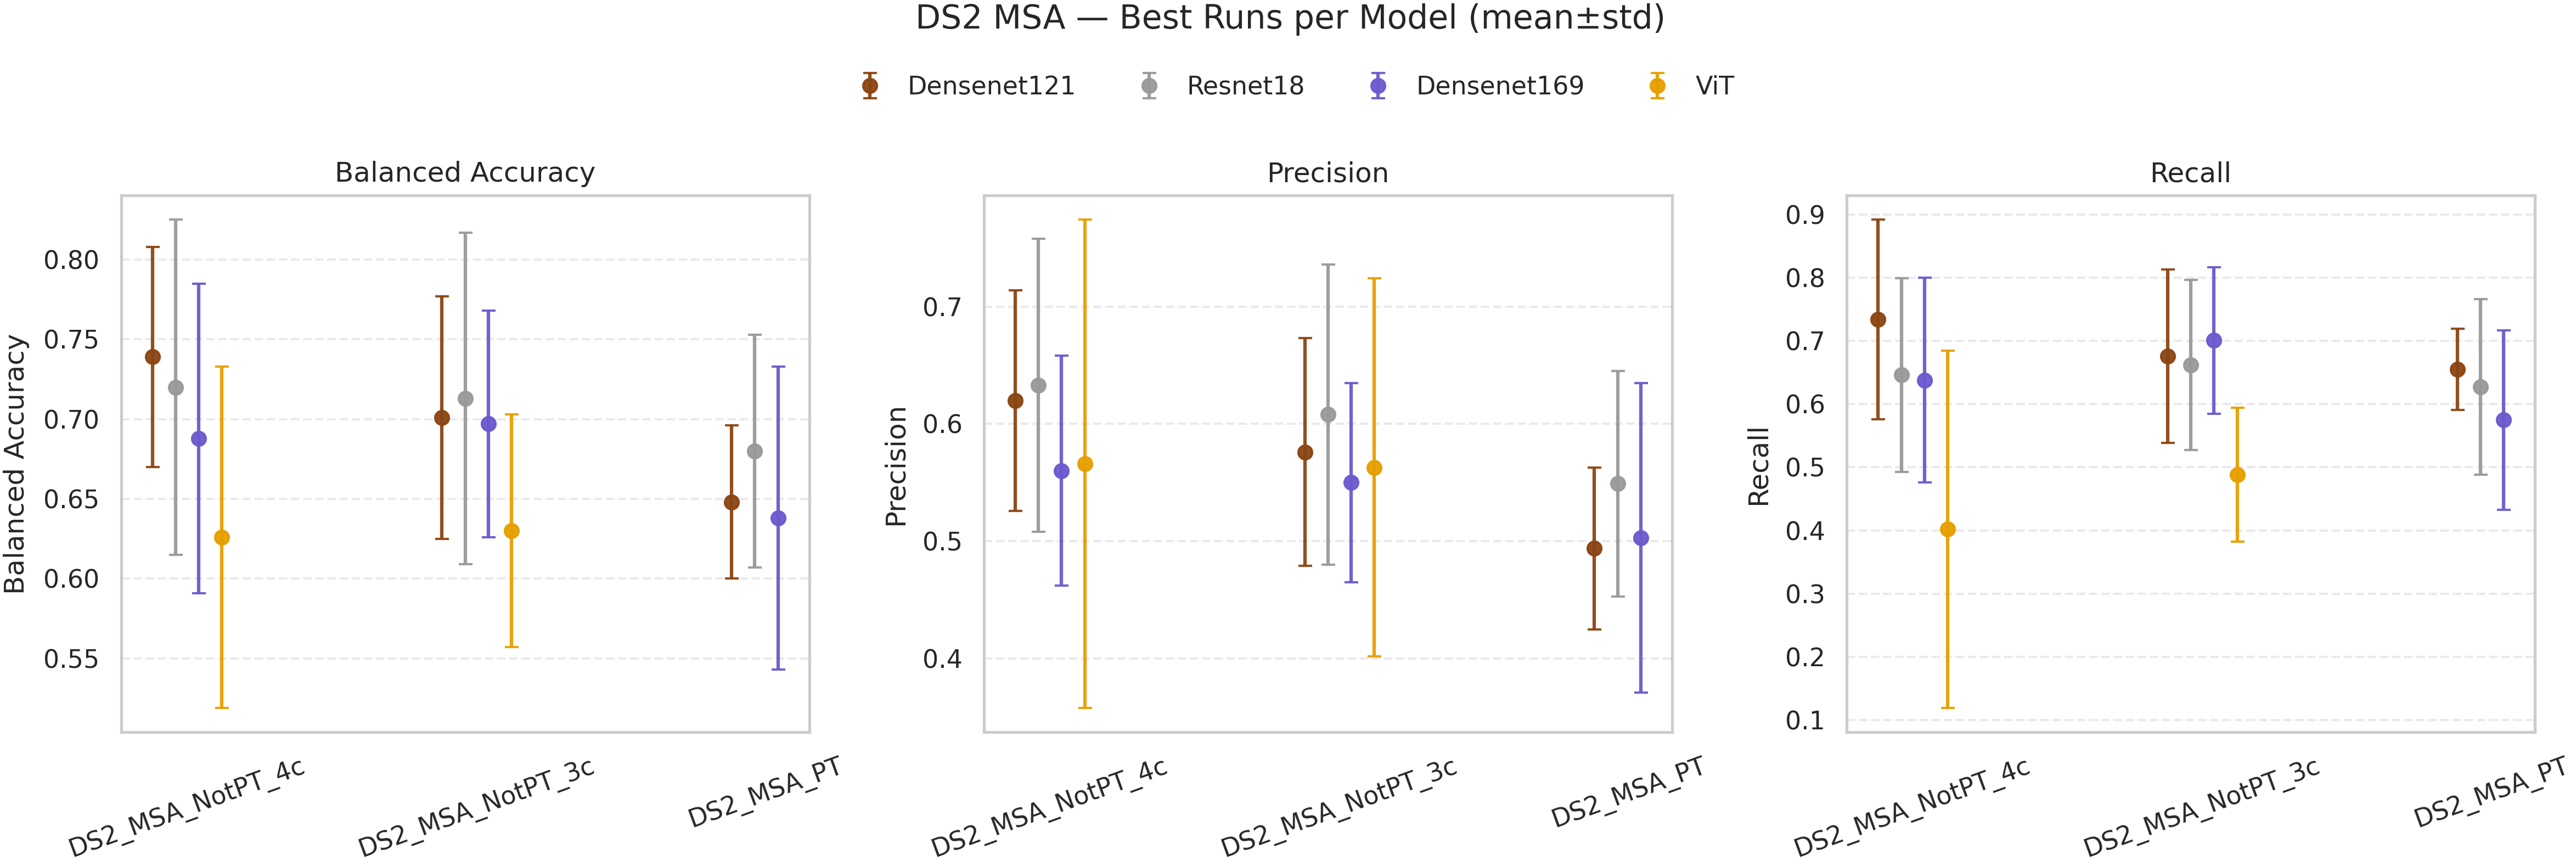

Saved to notebooks/images/image_analysis/DS2_MSA_best_runs_errorbars.png


In [91]:
# Reuse your plotting function
groups_ds1_msa = {
    'DS1_MSA_NotPT_4c': dfs_to_export['DS1_MSA_NotPT_4c'],
    'DS1_MSA_NotPT_3c': dfs_to_export['DS1_MSA_NotPT_3c'],
    'DS1_MSA_PT':       dfs_to_export['DS1_MSA_PT'],
}

groups_ds2_msa = {
    'DS2_MSA_NotPT_4c': dfs_to_export['DS2_MSA_NotPT_4c'],
    'DS2_MSA_NotPT_3c': dfs_to_export['DS2_MSA_NotPT_3c'],
    'DS2_MSA_PT':       dfs_to_export['DS2_MSA_PT'],
}

groups_ds1_msap = {
    'DS1_MSAP_NotPT_4c': dfs_to_export['DS1_MSAP_NotPT_4c'],
    'DS1_MSAP_NotPT_3c': dfs_to_export['DS1_MSAP_NotPT_3c'],
    'DS1_MSAP_PT':       dfs_to_export['DS1_MSAP_PT'],
}

groups_ds2_msap = {
    'DS2_MSAP_NotPT_4c': dfs_to_export['DS2_MSAP_NotPT_4c'],
    'DS2_MSAP_NotPT_3c': dfs_to_export['DS2_MSAP_NotPT_3c'],
    'DS2_MSAP_PT':       dfs_to_export['DS2_MSAP_PT'],
}


groups = groups_ds2_msa
frame = build_best_per_model_frame(groups)
# Optional: fix x-order
# order = ['DS1_MSA_NotPT_4c', 'DS1_MSA_NotPT_3c', 'DS1_MSA_PT']
# create_grouped_bal_acc_recall_precision_errorbar_plot
create_grouped_bal_acc_recall_precision_errorbar_plot(
    dfs_by_group=groups,
    title='DS2 MSA — Best Runs per Model (mean±std)',
    filename='notebooks/images/image_analysis/DS2_MSA_best_runs_errorbars.png',
    # group_order=order
)

## pretraining vs no pretraining

In [92]:
import sys

# These are the 16 DataFrame keys we need to plot
keys_to_check = [
    # DS1-MSA
    "DS1_MSA_NotPT",
    "DS1_MSA_PT_imagenet",
    "DS1_MSA_PT_imagenet_microscopynet",
    "DS1_MSA_PT_microscopy",
    # DS1-MSAP
    "DS1_MSAP_NotPT",
    "DS1_MSAP_PT_imagenet",
    "DS1_MSAP_PT_imagenet_microscopynet",
    "DS1_MSAP_PT_microscopy",
    # DS2-MSA
    "DS2_MSA_NotPT",
    "DS2_MSA_PT_imagenet",
    "DS2_MSA_PT_imagenet_microscopynet",
    "DS2_MSA_PT_microscopy",
    # DS2-MSAP
    "DS2_MSAP_NotPT",
    "DS2_MSAP_PT_imagenet",
    "DS2_MSAP_PT_imagenet_microscopynet",
    "DS2_MSAP_PT_microscopy",
]

print("--- Starting validation ---")
empty_dfs = []

for key in keys_to_check:
    # 1. Check if key exists
    if key not in dfs_to_export:
        print(f"ERROR: Key '{key}' is MISSING from your dfs_to_export dictionary.")
        empty_dfs.append(f"{key} (MISSING)")
        continue # Check the next key
        
    # 2. Get the DataFrame
    df = dfs_to_export[key]
    
    # 3. Check if it's empty
    if df.empty:
        print(f"FOUND: DataFrame '{key}' is EMPTY (0 rows).")
        empty_dfs.append(key)

if not empty_dfs:
    print("\nSUCCESS: All 16 required DataFrames are present and not empty.")
    print("You can now run the plotting script.")
else:
    print(f"\n--- VALIDATION FAILED ---")
    print("The plot failed because the following DataFrame(s) are missing or empty:")
    for key in empty_dfs:
        print(f"  - {key}")
    print("\nPlease check your data generation process for these experiments.")

--- Starting validation ---

SUCCESS: All 16 required DataFrames are present and not empty.
You can now run the plotting script.


In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Define the thesis style palette (Okabe-Ito, colorblind-safe)
THESIS_PALETTE = ['#999999', '#E69F00', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#56B4E9', '#F0E442']
# Re-ordered: Grey (Scratch), Orange (ImageNet), Blue (Microscopy), Green (Both)
PLOT_PALETTE = ['#999999', '#E69F00', '#0072B2', '#009E73']


def apply_thesis_style():
    """Applies the standard thesis plot style for Matplotlib and Seaborn."""
    
    # Set Seaborn defaults
    sns.set_theme(
        style="whitegrid",
        palette=PLOT_PALETTE
    )
    
    # Matplotlib customizations
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',  # Arial or DejaVu Sans
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'lines.linewidth': 2.0,
        'lines.markersize': 6,
        'figure.dpi': 150
    })
    
    # Remove top and right spines
    plt.rc('axes.spines', top=False, right=False)

In [96]:
def build_comparison_dataframe(
    keys_to_compare: dict[str, str],
    dfs_to_export: dict[str, pd.DataFrame],
    columns_to_keep: list[str]
) -> pd.DataFrame:
    """
    Builds a master DataFrame for plotting by combining and filtering subsets.

    This function iterates through a dictionary of plotting keys, extracts the
    corresponding DataFrames, labels them, concatenates them, and filters
    for a specified set of columns.

    Parameters
    ----------
    keys_to_compare : dict[str, str]
        A dictionary mapping a descriptive label (e.g., "Scratch") to a key
        in `dfs_to_export` (e.g., "DS1_MSA_NotPT_3c").
    dfs_to_export : dict[str, pd.DataFrame]
        A dictionary where keys are experiment identifiers and values are
        the corresponding pandas DataFrames.
    columns_to_keep : list[str]
        A list of column names to retain in the final merged DataFrame.

    Returns
    -------
    pd.DataFrame
        A single, concatenated DataFrame ready for plotting, containing a new
        'Pretraining' column derived from the `keys_to_compare` labels.
    """
    plot_data_frames = []
    for label, key in keys_to_compare.items():
        if key in dfs_to_export:
            temp_df = dfs_to_export[key].copy()
            temp_df['Pretraining'] = label
            plot_data_frames.append(temp_df)
        else:
            print(f"Warning: Key '{key}' not found in dfs_to_export.")

    if not plot_data_frames:
        return pd.DataFrame(columns=columns_to_keep + ['Pretraining'])

    # Create one master DataFrame for plotting
    plot_df = pd.concat(plot_data_frames, ignore_index=True)

    # Filter to only essential columns, ensuring 'Pretraining' is kept
    final_cols = [col for col in columns_to_keep if col in plot_df.columns]
    if 'Pretraining' not in final_cols:
        final_cols.append('Pretraining')
        
    return plot_df[final_cols]

In [97]:
# 1. Define the keys for comparison (using your correction)
keys_to_compare_ds1_msa = {
    "Scratch": "DS1_MSA_NotPT_3c",
    "ImageNet": "DS1_MSA_PT_imagenet",
    "MicroscopyNet": "DS1_MSA_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS1_MSA_PT_imagenet_microscopynet"
}

keys_to_compare_ds1_msap = {
    "Scratch": "DS1_MSAP_NotPT_3c",
    "ImageNet": "DS1_MSAP_PT_imagenet",
    "MicroscopyNet": "DS1_MSAP_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS1_MSAP_PT_imagenet_microscopynet"
}

keys_to_compare_ds2_msa = {
    "Scratch": "DS2_MSA_NotPT_3c",
    "ImageNet": "DS2_MSA_PT_imagenet",
    "MicroscopyNet": "DS2_MSA_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS2_MSA_PT_imagenet_microscopynet"
}

keys_to_compare_ds2_msap = {
    "Scratch": "DS2_MSAP_NotPT_3c",
    "ImageNet": "DS2_MSAP_PT_imagenet",
    "MicroscopyNet": "DS2_MSAP_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS2_MSAP_PT_imagenet_microscopynet"
}

# 4. Filter to only essential columns
columns_to_keep = [ 
    'model_name', 'Pretraining',
    'mean_test_balanced_acc', 'std_test_balanced_acc',
    'mean_test_mcc', 'std_test_mcc'
]
# 2. Extract and concatenate *all* relevant data
plot_df = build_comparison_dataframe(
    keys_to_compare=keys_to_compare_ds1_msa,
    dfs_to_export=dfs_to_export,
    columns_to_keep=columns_to_keep
)

# 6. Sort values for predictable plotting
plot_df = plot_df.sort_values(by=['Pretraining', 'model_name'])

print("Robust plotting DataFrame prepared:")
print(plot_df.to_markdown(index=False))

Robust plotting DataFrame prepared:
| model_name   | Pretraining              |   mean_test_balanced_acc |   std_test_balanced_acc |   mean_test_mcc |   std_test_mcc |
|:-------------|:-------------------------|-------------------------:|------------------------:|----------------:|---------------:|
| Densenet121  | ImageNet                 |                    0.592 |                   0.157 |           0.176 |          0.304 |
| Densenet169  | ImageNet                 |                    0.59  |                   0.124 |           0.173 |          0.24  |
| Resnet18     | ImageNet                 |                    0.609 |                   0.105 |           0.22  |          0.194 |
| Densenet121  | ImageNet + MicroscopyNet |                    0.612 |                   0.168 |           0.218 |          0.334 |
| Densenet169  | ImageNet + MicroscopyNet |                    0.582 |                   0.182 |           0.154 |          0.349 |
| Resnet18     | ImageNet + MicroscopyNe

## scatterplot effects of pretraining

In [ ]:
def plot_pretraining_scatter(df, x_col, y_col, x_label, y_label, title, save_path):
    """
    Generates a faceted scatterplot comparing non-pretrained (x) vs.
    pretrained (y) performance, with a y=x diagonal line.
    """
    
    apply_thesis_style()
    
    # 1. Create the Figure-level scatterplot
    #    col="Dataset" creates the panels you wanted
    #    hue="model_name" colors the points
    #    style="Task" uses different markers for MSA vs. MSAP
    g = sns.relplot(
        data=df,
        x=x_col,
        y=y_col,
        hue='model_name',
        style='Task',
        s=100, # Marker size
        col='Dataset', # Facet by Dataset
        palette=THESIS_PALETTE,
        height=7,
        aspect=1
    )

    # 2. Add the y=x diagonal line to each facet
    for ax in g.axes.flat:
        # Get the current limits
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()
        
        # Find the min and max for a symmetrical, square plot
        min_all = min(x_lim[0], y_lim[0])
        max_all = max(x_lim[1], y_lim[1])
        
        # Set symmetrical limits
        ax.set_xlim(min_all, max_all)
        ax.set_ylim(min_all, max_all)
        
        # Add the diagonal reference line
        ax.plot([min_all, max_all], [min_all, max_all], 'k--', alpha=0.7)
        
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # 3. Tidy up the plot
    g.set_axis_labels(x_label, y_label)
    g.fig.suptitle(title, y=1.03, size=14)
    g.legend.set_title("Model")
    
    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the figure
    g.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(g.fig)
    print(f"Plot saved to {save_path}")
    

In [99]:
# Define the thesis style palette (Okabe-Ito, colorblind-safe)
THESIS_PALETTE = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9', '#E69F00', '#999999']

def apply_thesis_style():
    """Applies the standard thesis plot style for Matplotlib and Seaborn."""
    sns.set_theme(style="whitegrid", palette=THESIS_PALETTE)
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'lines.linewidth': 2.0,
        'lines.markersize': 8, # Make markers a bit larger for scatter
        'figure.dpi': 150
    })
    plt.rc('axes.spines', top=False, right=False)
    
# (Assuming your dfs_to_export is loaded)

# 1. Define the comparison groups
comparison_groups_imagenet_microscopynet = [
    # (Scratch_Key, Pretrained_Key, Dataset_Label, Task_Label)
    ('DS1_MSA_NotPT_3c', 'DS1_MSA_PT_imagenet_microscopynet', 'DS1', 'MSA'),
    ('DS1_MSAP_NotPT_3c', 'DS1_MSAP_PT_imagenet_microscopynet', 'DS1', 'MSAP'),
    ('DS2_MSA_NotPT_3c', 'DS2_MSA_PT_imagenet_microscopynet', 'DS2', 'MSA'),
    ('DS2_MSAP_NotPT_3c', 'DS2_MSAP_PT_imagenet_microscopynet', 'DS2', 'MSAP'),
]

comparison_groups_imagenet = [
    ('DS1_MSA_NotPT_3c', 'DS1_MSA_PT_imagenet', 'DS1', 'MSA'),
    ('DS1_MSAP_NotPT_3c', 'DS1_MSAP_PT_imagenet', 'DS1', 'MSAP'),
    ('DS2_MSA_NotPT_3c', 'DS2_MSA_PT_imagenet', 'DS2', 'MSA'),
    ('DS2_MSAP_NotPT_3c', 'DS2_MSAP_PT_imagenet', 'DS2', 'MSAP'),
]

comparison_groups_microscopy = [
    ('DS1_MSA_NotPT_3c', 'DS1_MSA_PT_microscopy', 'DS1', 'MSA'),
    ('DS1_MSAP_NotPT_3c', 'DS1_MSAP_PT_microscopy', 'DS1', 'MSAP'),
    ('DS2_MSA_NotPT_3c', 'DS2_MSA_PT_microscopy', 'DS2', 'MSA'),
    ('DS2_MSAP_NotPT_3c', 'DS2_MSAP_PT_microscopy', 'DS2', 'MSAP'),
]


# Columns to keep for merging
metric_cols = ['model_name', 'mean_test_balanced_acc', 'mean_test_mcc']

scatter_plot_frames = []
for scratch_key, pt_key, dataset, task in comparison_groups_microscopy:
    if scratch_key not in dfs_to_export or pt_key not in dfs_to_export:
        print(f"Warning: Skipping {dataset}-{task}, missing data for {scratch_key} or {pt_key}")
        continue
    
    # 2. Get the "Scratch" (Non-Pretrained) data
    df_scratch = dfs_to_export[scratch_key][metric_cols].copy()
    df_scratch = df_scratch.rename(columns={
        'mean_test_balanced_acc': 'bal_acc_scratch',
        'mean_test_mcc': 'mcc_scratch'
    })
    
    # 3. Get the "Pretrained" data
    df_pt = dfs_to_export[pt_key][metric_cols].copy()
    df_pt = df_pt.rename(columns={
        'mean_test_balanced_acc': 'bal_acc_pt',
        'mean_test_mcc': 'mcc_pt'
    })
    
    # 4. Merge on model_name
    df_merged = pd.merge(df_scratch, df_pt, on='model_name', how='inner')
    
    # 5. Add labels
    df_merged['Dataset'] = dataset
    df_merged['Task'] = task
    
    scatter_plot_frames.append(df_merged)

# 6. Create the final "wide" DataFrame for plotting
scatter_plot_df = pd.concat(scatter_plot_frames, ignore_index=True)

print("--- Scatter Plot DataFrame (Wide Format) ---")
print(scatter_plot_df.to_markdown(index=False))

--- Scatter Plot DataFrame (Wide Format) ---
| model_name   |   bal_acc_scratch |   mcc_scratch |   bal_acc_pt |   mcc_pt | Dataset   | Task   |
|:-------------|------------------:|--------------:|-------------:|---------:|:----------|:-------|
| Densenet121  |             0.738 |         0.465 |        0.617 |    0.229 | DS1       | MSA    |
| Densenet169  |             0.729 |         0.445 |        0.507 |    0.014 | DS1       | MSA    |
| Resnet18     |             0.606 |         0.218 |        0.626 |    0.242 | DS1       | MSA    |
| Resnet18     |             0.751 |         0.506 |        0.648 |    0.315 | DS1       | MSAP   |
| Densenet169  |             0.721 |         0.452 |        0.655 |    0.308 | DS1       | MSAP   |
| Densenet121  |             0.696 |         0.406 |        0.657 |    0.327 | DS1       | MSAP   |
| Resnet18     |             0.713 |         0.425 |        0.664 |    0.324 | DS2       | MSA    |
| Densenet169  |             0.697 |         0.384 |   

In [100]:
# (Assuming your dfs_to_export is loaded)

# 1. Define all comparison groups
comparison_groups_imagenet_microscopynet = [
    ('DS1_MSA_NotPT_3c', 'DS1_MSA_PT_imagenet_microscopynet', 'DS1', 'MSA'),
    ('DS1_MSAP_NotPT_3c', 'DS1_MSAP_PT_imagenet_microscopynet', 'DS1', 'MSAP'),
    ('DS2_MSA_NotPT_3c', 'DS2_MSA_PT_imagenet_microscopynet', 'DS2', 'MSA'),
    ('DS2_MSAP_NotPT_3c', 'DS2_MSAP_PT_imagenet_microscopynet', 'DS2', 'MSAP'),
]

comparison_groups_imagenet = [
    ('DS1_MSA_NotPT_3c', 'DS1_MSA_PT_imagenet', 'DS1', 'MSA'),
    ('DS1_MSAP_NotPT_3c', 'DS1_MSAP_PT_imagenet', 'DS1', 'MSAP'),
    ('DS2_MSA_NotPT_3c', 'DS2_MSA_PT_imagenet', 'DS2', 'MSA'),
    ('DS2_MSAP_NotPT_3c', 'DS2_MSAP_PT_imagenet', 'DS2', 'MSAP'),
]

comparison_groups_microscopy = [
    ('DS1_MSA_NotPT_3c', 'DS1_MSA_PT_microscopy', 'DS1', 'MSA'),
    ('DS1_MSAP_NotPT_3c', 'DS1_MSAP_PT_microscopy', 'DS1', 'MSAP'),
    ('DS2_MSA_NotPT_3c', 'DS2_MSA_PT_microscopy', 'DS2', 'MSA'),
    ('DS2_MSAP_NotPT_3c', 'DS2_MSAP_PT_microscopy', 'DS2', 'MSAP'),
]

# 2. Create a master list to loop over
#    (Name for files, Comparison List)
master_comparison_list = [
    ('ImageNet_MicroscopyNet', comparison_groups_imagenet_microscopynet),
    ('ImageNet', comparison_groups_imagenet),
    ('MicroscopyNet', comparison_groups_microscopy),
]

# Columns to keep for merging
metric_cols = ['model_name', 'mean_test_balanced_acc', 'mean_test_mcc']

# Ensure the main save directory exists
os.makedirs('images/scatter_impact', exist_ok=True)

# 3. Main loop
print("--- Starting Scatter Plot Generation ---")
for pt_name, comparison_groups in master_comparison_list:
    
    print(f"\n--- Processing Pretraining: {pt_name} ---")
    
    # --- 3a. Data Preparation (per loop) ---
    scatter_plot_frames = []
    for scratch_key, pt_key, dataset, task in comparison_groups:
        if scratch_key not in dfs_to_export or pt_key not in dfs_to_export:
            print(f"Warning: Skipping {dataset}-{task}, missing data for {scratch_key} or {pt_key}")
            continue
        
        df_scratch = dfs_to_export[scratch_key][metric_cols].copy()
        df_scratch = df_scratch.rename(columns={
            'mean_test_balanced_acc': 'bal_acc_scratch',
            'mean_test_mcc': 'mcc_scratch'
        })
        
        df_pt = dfs_to_export[pt_key][metric_cols].copy()
        df_pt = df_pt.rename(columns={
            'mean_test_balanced_acc': 'bal_acc_pt',
            'mean_test_mcc': 'mcc_pt'
        })
        
        df_merged = pd.merge(df_scratch, df_pt, on='model_name', how='inner')
        df_merged['Dataset'] = dataset
        df_merged['Task'] = task
        scatter_plot_frames.append(df_merged)

    if not scatter_plot_frames:
        print(f"No data to plot for {pt_name}. Skipping.")
        continue
        
    scatter_plot_df = pd.concat(scatter_plot_frames, ignore_index=True)
    
    print(f"Plotting DataFrame for {pt_name} (Wide Format):")
    print(scatter_plot_df.head().to_markdown(index=False))

    # --- 3b. Plotting (per loop) ---
    
    # Plot 1: Balanced Accuracy
    plot_pretraining_scatter(
        df=scatter_plot_df,
        x_col='bal_acc_scratch',
        y_col='bal_acc_pt',
        x_label='Balanced Accuracy (Scratch)',
        y_label=f'Balanced Accuracy ({pt_name})',
        title=f'Pretraining Impact ({pt_name}) on Balanced Accuracy (3-Channel)',
        save_path=f'images/scatter_impact/09_impact_scatter_bal_acc_{pt_name}.png'
    )
    
    # Plot 2: MCC
    plot_pretraining_scatter(
        df=scatter_plot_df,
        x_col='mcc_scratch',
        y_col='mcc_pt',
        x_label='MCC (Scratch)',
        y_label=f'MCC ({pt_name})',
        title=f'Pretraining Impact ({pt_name}) on MCC (3-Channel)',
        save_path=f'images/scatter_impact/09_impact_scatter_mcc_{pt_name}.png'
    )

print("\nAll scatter plots generated successfully.")

--- Starting Scatter Plot Generation ---

--- Processing Pretraining: ImageNet_MicroscopyNet ---
Plotting DataFrame for ImageNet_MicroscopyNet (Wide Format):
| model_name   |   bal_acc_scratch |   mcc_scratch |   bal_acc_pt |   mcc_pt | Dataset   | Task   |
|:-------------|------------------:|--------------:|-------------:|---------:|:----------|:-------|
| Densenet121  |             0.738 |         0.465 |        0.612 |    0.218 | DS1       | MSA    |
| Densenet169  |             0.729 |         0.445 |        0.582 |    0.154 | DS1       | MSA    |
| Resnet18     |             0.606 |         0.218 |        0.61  |    0.213 | DS1       | MSA    |
| Resnet18     |             0.751 |         0.506 |        0.681 |    0.388 | DS1       | MSAP   |
| Densenet169  |             0.721 |         0.452 |        0.693 |    0.398 | DS1       | MSAP   |


/tmp/ipykernel_211839/1091179511.py:13: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


Plot saved to images/scatter_impact/09_impact_scatter_bal_acc_ImageNet_MicroscopyNet.png


/tmp/ipykernel_211839/1091179511.py:13: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


Plot saved to images/scatter_impact/09_impact_scatter_mcc_ImageNet_MicroscopyNet.png

--- Processing Pretraining: ImageNet ---
Plotting DataFrame for ImageNet (Wide Format):
| model_name   |   bal_acc_scratch |   mcc_scratch |   bal_acc_pt |   mcc_pt | Dataset   | Task   |
|:-------------|------------------:|--------------:|-------------:|---------:|:----------|:-------|
| Densenet121  |             0.738 |         0.465 |        0.592 |    0.176 | DS1       | MSA    |
| Densenet169  |             0.729 |         0.445 |        0.59  |    0.173 | DS1       | MSA    |
| Resnet18     |             0.606 |         0.218 |        0.609 |    0.22  | DS1       | MSA    |
| Resnet18     |             0.751 |         0.506 |        0.626 |    0.276 | DS1       | MSAP   |
| Densenet169  |             0.721 |         0.452 |        0.622 |    0.245 | DS1       | MSAP   |


/tmp/ipykernel_211839/1091179511.py:13: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


Plot saved to images/scatter_impact/09_impact_scatter_bal_acc_ImageNet.png


/tmp/ipykernel_211839/1091179511.py:13: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


Plot saved to images/scatter_impact/09_impact_scatter_mcc_ImageNet.png

--- Processing Pretraining: MicroscopyNet ---
Plotting DataFrame for MicroscopyNet (Wide Format):
| model_name   |   bal_acc_scratch |   mcc_scratch |   bal_acc_pt |   mcc_pt | Dataset   | Task   |
|:-------------|------------------:|--------------:|-------------:|---------:|:----------|:-------|
| Densenet121  |             0.738 |         0.465 |        0.617 |    0.229 | DS1       | MSA    |
| Densenet169  |             0.729 |         0.445 |        0.507 |    0.014 | DS1       | MSA    |
| Resnet18     |             0.606 |         0.218 |        0.626 |    0.242 | DS1       | MSA    |
| Resnet18     |             0.751 |         0.506 |        0.648 |    0.315 | DS1       | MSAP   |
| Densenet169  |             0.721 |         0.452 |        0.655 |    0.308 | DS1       | MSAP   |


/tmp/ipykernel_211839/1091179511.py:13: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


Plot saved to images/scatter_impact/09_impact_scatter_bal_acc_MicroscopyNet.png


/tmp/ipykernel_211839/1091179511.py:13: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


Plot saved to images/scatter_impact/09_impact_scatter_mcc_MicroscopyNet.png

All scatter plots generated successfully.


## 5. Bubble chart


trainable param , architectures, perfromances

In [ ]:
def plot_bubble_correlation(df, x_col, y_col, size_col, title, save_path):
    """
    Generates a faceted bubble chart (scatterplot).
    - Facets (col, row) = Dataset, Task
    - Color (hue) = model_name
    - Size = trainable_params
    - Style (marker) = Pretraining_Status
    """
    
    apply_thesis_style()
    
    # Define specific markers for pretraining status
    status_markers = {
        'Scratch': 'o',  # Circle
        'Pretrained': 'X'   # X
    }
    
    # Get palette for the models
    num_models = len(df['model_name'].unique())
    model_palette = THESIS_PALETTE[:num_models]

    # 1. Create the Figure-level scatterplot
    g = sns.relplot(
        data=df,
        x=x_col,
        y=y_col,
        hue='model_name',         # Color by architecture
        size=size_col,            # Size by parameters
        style='Pretraining_Status', # Marker by Scratch vs. Pretrained
        col='Dataset',            # Facet by Dataset
        row='Task',               # Facet by Task
        palette=model_palette,
        markers=status_markers,
        sizes=(50, 500),          # Min and max bubble size
        alpha=0.7,                # Transparency for overlaps
        height=6,
        aspect=1.1
    )

    # 2. Add gridlines to each facet
    for ax in g.axes.flat:
        ax.grid(True, linestyle='--', alpha=0.7)

    # 3. Tidy up the plot
    g.set_axis_labels("Mean Test Balanced Accuracy", "Mean Test MCC")
    g.set_titles(col_template="{col_name}", row_template="{row_name}") # Titles for col/row
    g.fig.suptitle(title, y=1.03, size=14) # Overall title
    
    # Tidy up the legend
    # g.legend.set_title("Model")
    
    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the figure
    g.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(g.fig)
    print(f"Plot saved to {save_path}")

In [ ]:
# (Assuming your dfs_to_export is loaded)

# 1. Define all key sets
keys_to_compare_ds1_msa = {
    "Scratch": "DS1_MSA_NotPT_3c", "ImageNet": "DS1_MSA_PT_imagenet",
    "MicroscopyNet": "DS1_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds1_msap = {
    "Scratch": "DS1_MSAP_NotPT_3c", "ImageNet": "DS1_MSAP_PT_imagenet",
    "MicroscopyNet": "DS1_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSAP_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msa = {
    "Scratch": "DS2_MSA_NotPT_3c", "ImageNet": "DS2_MSA_PT_imagenet",
    "MicroscopyNet": "DS2_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msap = {
    "Scratch": "DS2_MSAP_NotPT_3c", "ImageNet": "DS2_MSAP_PT_imagenet",
    "MicroscopyNet": "DS2_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSAP_PT_imagenet_microscopynet"
}
key_sets = [keys_to_compare_ds1_msa, keys_to_compare_ds1_msap, keys_to_compare_ds2_msa, keys_to_compare_ds2_msap]

# 2. Build the master DataFrame
all_plot_data_frames = []
for keys_to_compare in key_sets:
    first_key = keys_to_compare['Scratch']
    dataset_name = 'DS1' if 'DS1' in first_key else 'DS2'
    class_name = 'MSAP' if 'MSAP' in first_key else 'MSA'
    
    for label, key in keys_to_compare.items():
        if key in dfs_to_export:
            temp_df = dfs_to_export[key].copy()
            temp_df['Pretraining'] = label
            temp_df['Dataset'] = dataset_name
            temp_df['Task'] = class_name
            all_plot_data_frames.append(temp_df)
        else:
            print(f"Warning: Key '{key}' not found in dfs_to_export.")

master_plot_df = pd.concat(all_plot_data_frames, ignore_index=True)

# 3. Add 'Pretraining_Status' column
master_plot_df['Pretraining_Status'] = np.where(
    master_plot_df['Pretraining'] == 'Scratch', 
    'Scratch', 
    'Pretrained'
)

# 4. Convert 'trainable_params' to numeric
master_plot_df['trainable_params'] = pd.to_numeric(master_plot_df['trainable_params'], errors='coerce')

# (We don't need the log version for this plot, as 'size' handles linear scale)

# 5. Filter to relevant columns
columns_to_keep = [ 
    'model_name', 'Pretraining', 'Dataset', 'Task', 'Pretraining_Status',
    'mean_test_balanced_acc', 'mean_test_mcc', 'trainable_params'
]
master_plot_df = master_plot_df.reindex(columns=columns_to_keep)

print("--- Master DataFrame for Bubble Plot ---")
print(master_plot_df.head().to_markdown(index=False))

# Check for any NaNs
if master_plot_df['trainable_params'].isnull().any():
    print("Warning: Some 'trainable_params' were non-numeric and are now NaN.")

--- Master DataFrame for Bubble Plot ---
| model_name   | Pretraining   | Dataset   | Task   | Pretraining_Status   |   mean_test_balanced_acc |   mean_test_mcc |   trainable_params |
|:-------------|:--------------|:----------|:-------|:---------------------|-------------------------:|----------------:|-------------------:|
| Densenet121  | Scratch       | DS1       | MSA    | Scratch              |                    0.738 |           0.465 |            6955906 |
| Densenet169  | Scratch       | DS1       | MSA    | Scratch              |                    0.729 |           0.445 |           12487810 |
| Resnet18     | Scratch       | DS1       | MSA    | Scratch              |                    0.606 |           0.218 |           11177538 |
| ViT          | Scratch       | DS1       | MSA    | Scratch              |                    0.564 |           0.145 |            1022210 |
| Resnet18     | MicroscopyNet | DS1       | MSA    | Pretrained           |                    0.626

/tmp/ipykernel_2159791/1688149394.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_plot_df = pd.concat(all_plot_data_frames, ignore_index=True)


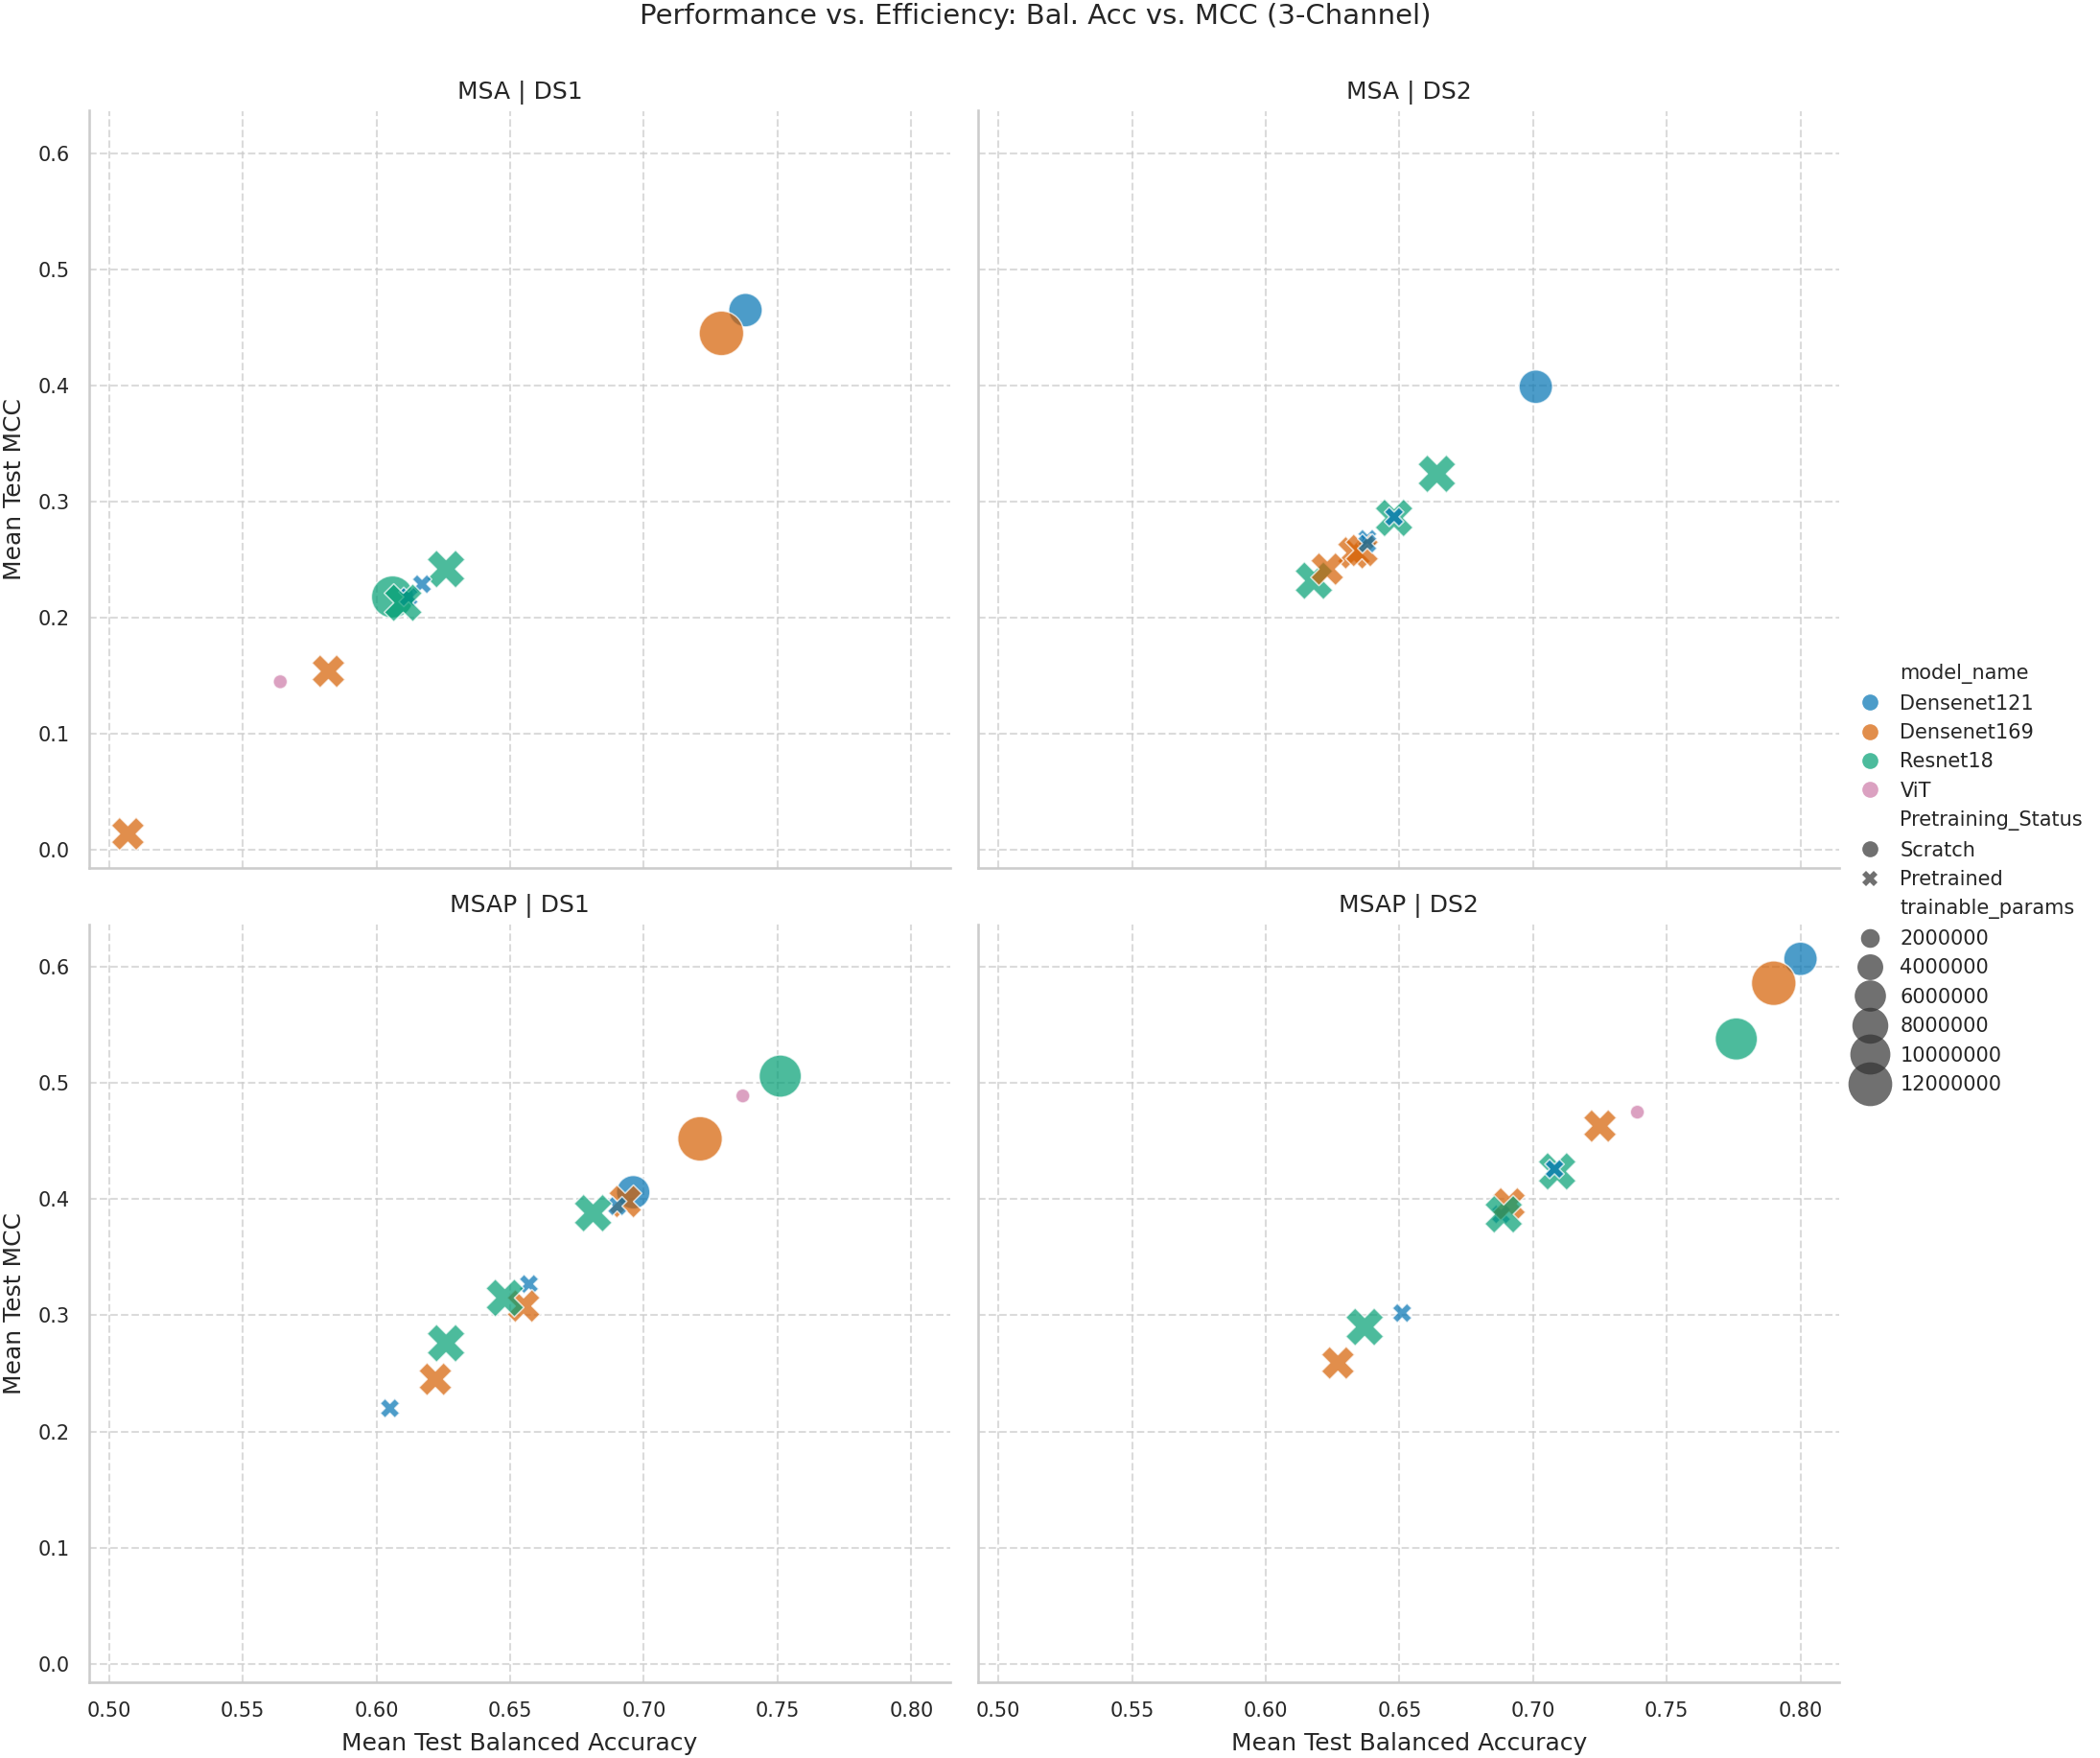

Plot saved to images/bubble_correlation/12_bubble_correlation_full.png
Bubble plot generated successfully.


In [ ]:
# Create the target save directory
os.makedirs('images/bubble_correlation', exist_ok=True)

if not master_plot_df.empty:
    plot_bubble_correlation(
        df=master_plot_df,
        x_col='mean_test_balanced_acc',
        y_col='mean_test_mcc',
        size_col='trainable_params',
        title='Performance vs. Efficiency: Bal. Acc vs. MCC (3-Channel)',
        save_path='images/bubble_correlation/12_bubble_correlation_full.png'
    )
else:
    print("Master DataFrame is empty. Skipping bubble plot.")

print("Bubble plot generated successfully.")

## 6. Trainable Parameters vs Balanced Accuracy

Goal: Show model efficiency and whether pretraining helps smaller models more.

x-axis: log(trainable_params)

y-axis: mean_test_balanced_acc

color: pretrained vs not_pretrained

marker: dataset (DS1/DS2)

Insight:
If smaller models gain more from pretraining → suggests transfer learning helps underparameterized architectures.

In [101]:
def plot_efficiency_scatter(df, x_col, y_col, x_label, y_label, title, save_path):
    """
    Generates a faceted scatterplot of log(Params) vs. Bal. Acc.
    - Facets (columns) = Task (MSA vs. MSAP)
    - Color = Pretraining_Status (Scratch vs. Pretrained)
    - Style (marker) = Dataset (DS1 vs. DS2)
    """
    
    apply_thesis_style()
    
    # Define specific palettes and markers for clarity
    status_palette = {
        'Scratch': '#999999',     # Grey
        'Pretrained': '#0072B2'   # Blue
    }
    dataset_markers = {
        'DS1': 'o',  # Circle
        'DS2': 'X'   # X
    }

    # 1. Create the Figure-level scatterplot
    g = sns.relplot(
        data=df,
        x=x_col,
        y=y_col,
        hue='Pretraining_Status', # Color by Scratch vs. Pretrained
        style='Dataset',          # Marker by DS1 vs. DS2
        col='Task',               # Facet by MSA vs. MSAP
        palette=status_palette,
        markers=dataset_markers,
        s=100,      # Marker size
        height=7,
        aspect=1.1
    )

    # 2. Add gridlines to each facet
    for ax in g.axes.flat:
        ax.grid(True, linestyle='--', alpha=0.7)

    # 3. Tidy up the plot
    g.set_axis_labels(x_label, y_label)
    g.set_titles("{col_name} Task") # Set title for each column (MSA or MSAP)
    g.fig.suptitle(title, y=1.03, size=14) # Overall title
    
    # Tidy up the legend
    g.legend.set_title("Status")
    
    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the figure
    g.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(g.fig)
    print(f"Plot saved to {save_path}")

In [102]:
# 1. Define all key sets
keys_to_compare_ds1_msa = {
    "Scratch": "DS1_MSA_NotPT_3c", "ImageNet": "DS1_MSA_PT_imagenet",
    "MicroscopyNet": "DS1_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds1_msap = {
    "Scratch": "DS1_MSAP_NotPT_3c", "ImageNet": "DS1_MSAP_PT_imagenet",
    "MicroscopyNet": "DS1_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSAP_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msa = {
    "Scratch": "DS2_MSA_NotPT_3c", "ImageNet": "DS2_MSA_PT_imagenet",
    "MicroscopyNet": "DS2_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msap = {
    "Scratch": "DS2_MSAP_NotPT_3c", "ImageNet": "DS2_MSAP_PT_imagenet",
    "MicroscopyNet": "DS2_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSAP_PT_imagenet_microscopynet"
}

key_sets = [keys_to_compare_ds1_msa, keys_to_compare_ds1_msap, keys_to_compare_ds2_msa, keys_to_compare_ds2_msap]

# 2. Build the master DataFrame
all_plot_data_frames = []
for keys_to_compare in key_sets:
    first_key = keys_to_compare['Scratch']
    dataset_name = 'DS1' if 'DS1' in first_key else 'DS2'
    class_name = 'MSAP' if 'MSAP' in first_key else 'MSA'
    
    for label, key in keys_to_compare.items():
        if key in dfs_to_export:
            temp_df = dfs_to_export[key].copy()
            temp_df['Pretraining'] = label
            temp_df['Dataset'] = dataset_name
            temp_df['Task'] = class_name
            all_plot_data_frames.append(temp_df)
        else:
            print(f"Warning: Key '{key}' not found in dfs_to_export.")

master_plot_df = pd.concat(all_plot_data_frames, ignore_index=True)

# 3. Add 'Pretraining_Status' column
master_plot_df['Pretraining_Status'] = np.where(
    master_plot_df['Pretraining'] == 'Scratch', 
    'Scratch', 
    'Pretrained'
)

# 4. --- CORRECTED SECTION ---
master_plot_df['trainable_params'] = pd.to_numeric(master_plot_df['trainable_params'], errors='coerce')

# Now, taking the log will work
master_plot_df['log_trainable_params'] = np.log10(master_plot_df['trainable_params'])
# --- END CORRECTION ---

# 5. Filter to relevant columns
columns_to_keep = [ 
    'model_name', 'Pretraining', 'Dataset', 'Task', 'Pretraining_Status',
    'mean_test_balanced_acc', 'mean_test_mcc', 'trainable_params', 'log_trainable_params'
]
master_plot_df = master_plot_df.reindex(columns=columns_to_keep)

print("--- Master DataFrame for Efficiency (Corrected) ---")
print(master_plot_df.head().to_markdown(index=False))

# Check for any NaNs created during conversion (good practice)
if master_plot_df['log_trainable_params'].isnull().any():
    print("Warning: Some 'trainable_params' were non-numeric and are now NaN.")

--- Master DataFrame for Efficiency (Corrected) ---
| model_name   | Pretraining   | Dataset   | Task   | Pretraining_Status   |   mean_test_balanced_acc |   mean_test_mcc |   trainable_params |   log_trainable_params |
|:-------------|:--------------|:----------|:-------|:---------------------|-------------------------:|----------------:|-------------------:|-----------------------:|
| Densenet121  | Scratch       | DS1       | MSA    | Scratch              |                    0.738 |           0.465 |            6955906 |                6.84235 |
| Densenet169  | Scratch       | DS1       | MSA    | Scratch              |                    0.729 |           0.445 |           12487810 |                7.09649 |
| Resnet18     | Scratch       | DS1       | MSA    | Scratch              |                    0.606 |           0.218 |           11177538 |                7.04835 |
| ViT          | Scratch       | DS1       | MSA    | Scratch              |                    0.564 |     

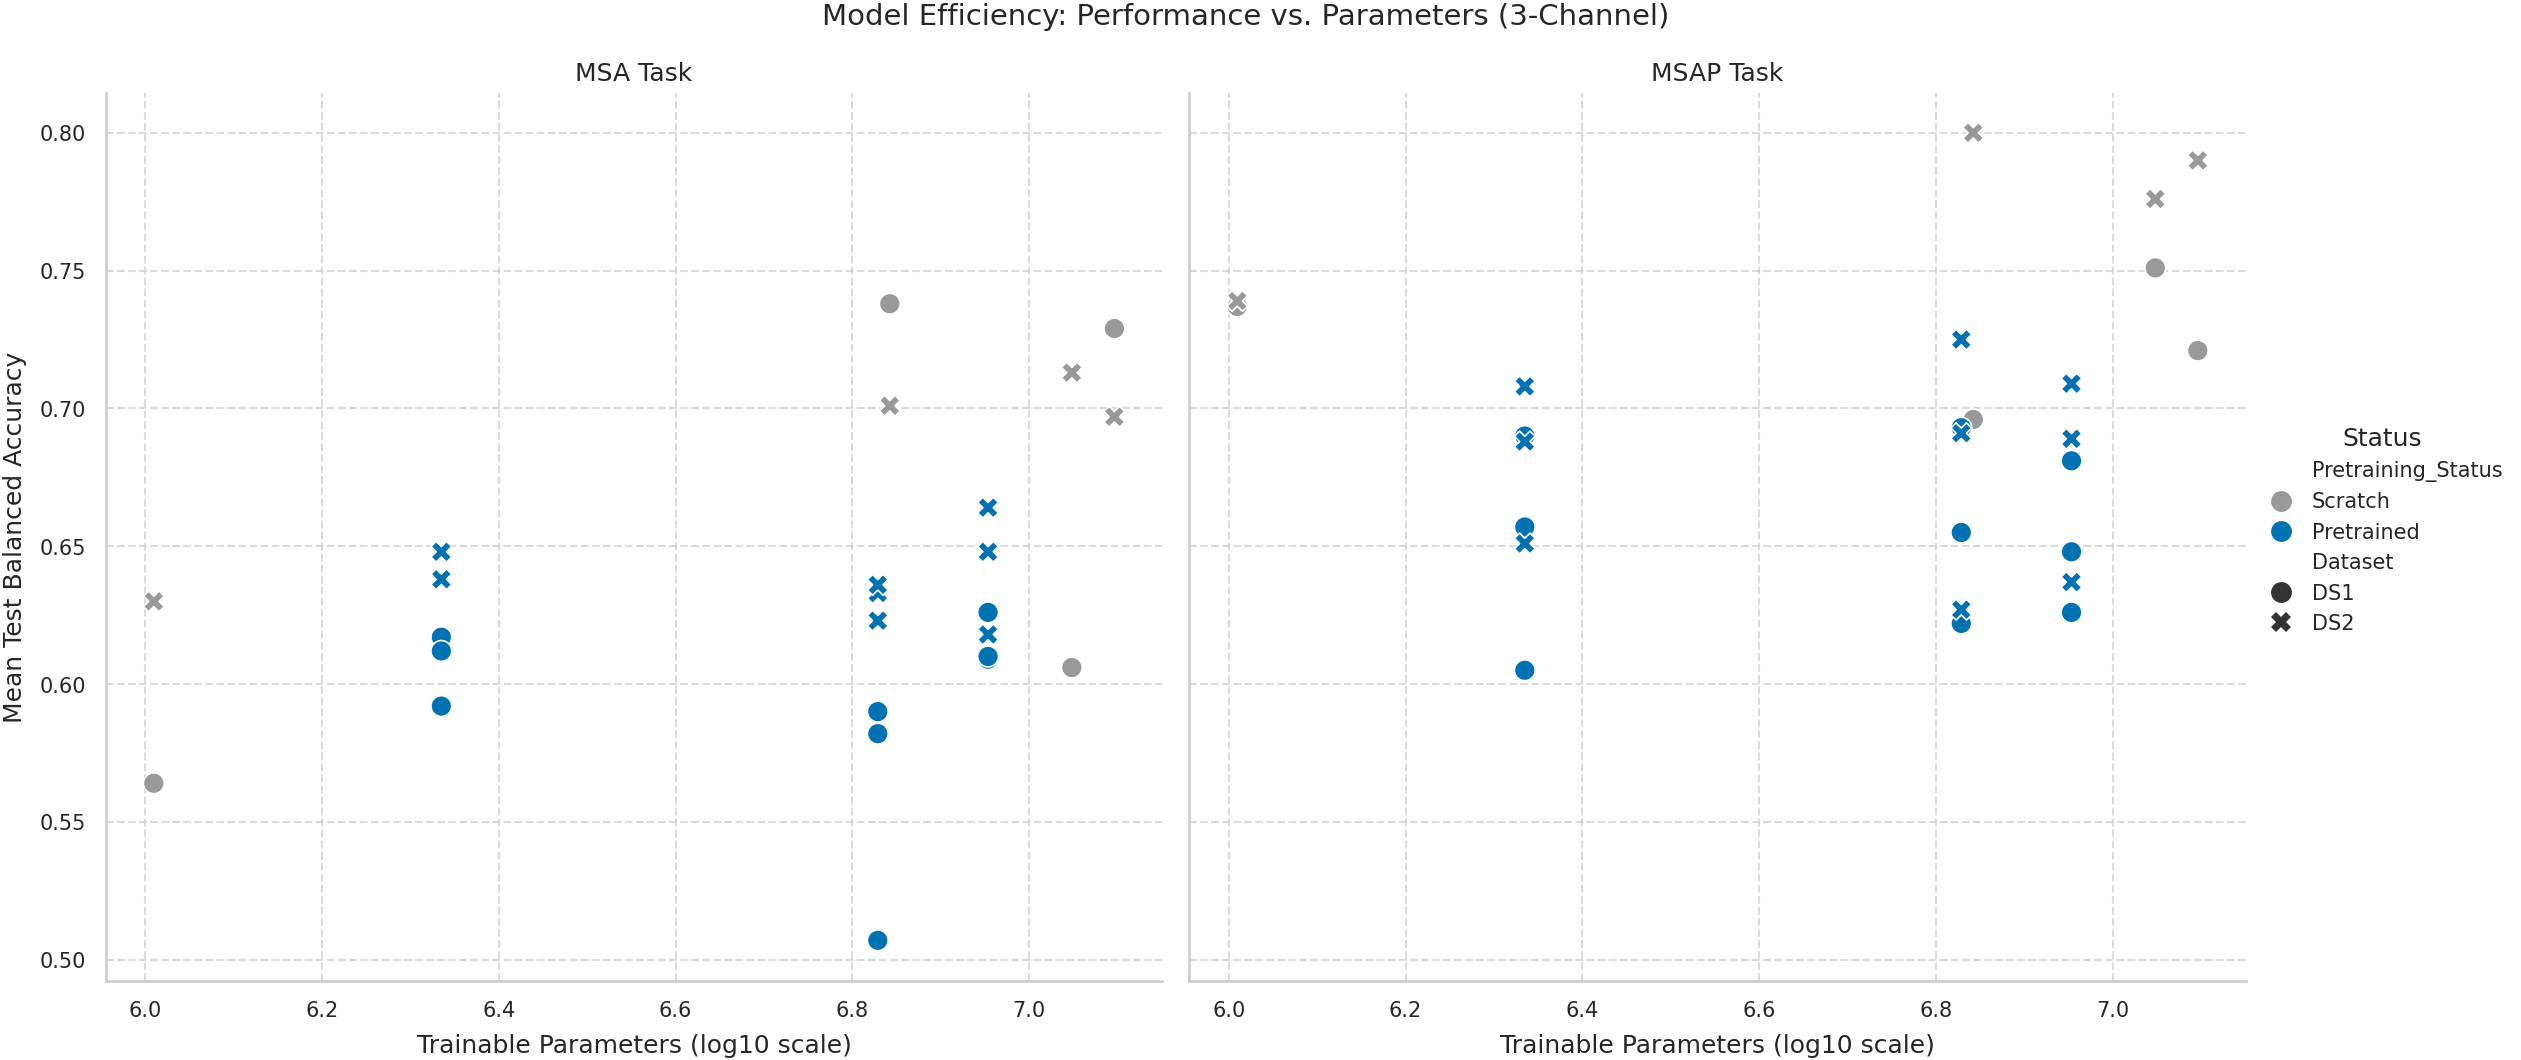

Plot saved to images/efficiency_scatter/11_efficiency_scatter_params_balacc.png
Efficiency plot generated successfully.


In [103]:
# Create the target save directory
os.makedirs('images/efficiency_scatter', exist_ok=True)

if not master_plot_df.empty:
    plot_efficiency_scatter(
        df=master_plot_df,
        x_col='log_trainable_params',
        y_col='mean_test_balanced_acc',
        x_label='Trainable Parameters (log10 scale)',
        y_label='Mean Test Balanced Accuracy',
        title='Model Efficiency: Performance vs. Parameters (3-Channel)',
        save_path='images/efficiency_scatter/11_efficiency_scatter_params_balacc.png'
    )
else:
    print("Master DataFrame is empty. Skipping efficiency plot.")

print("Efficiency plot generated successfully.")

⚖️ B. Trade-off and Correlation Scatterplots

3. Balanced Accuracy vs MCC (per model/run)

Goal: Show correlation between metrics and if pretraining shifts models to a better regime.



x-axis: mean_test_balanced_acc

y-axis: mean_test_mcc

color: pretrained vs not_pretrained

shape/marker: dataset (DS1 vs DS2)

Insight: Whether pretraining improves both metrics simultaneously or mainly one.

In [ ]:
# Define the thesis style palette (Okabe-Ito, colorblind-safe)
THESIS_PALETTE = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9', '#E69F00', '#999999']

def apply_thesis_style():
    """Applies the standard thesis plot style for Matplotlib and Seaborn."""
    sns.set_theme(style="whitegrid", palette=THESIS_PALETTE)
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'lines.linewidth': 2.0,
        'lines.markersize': 8, # Good size for scatter
        'figure.dpi': 150
    })
    plt.rc('axes.spines', top=False, right=False)

--- Master DataFrame for Correlation ---
| model_name   | Pretraining   | Dataset   | Task   | Pretraining_Status   |   mean_test_balanced_acc |   mean_test_mcc |
|:-------------|:--------------|:----------|:-------|:---------------------|-------------------------:|----------------:|
| Densenet121  | Scratch       | DS1       | MSA    | Scratch              |                    0.738 |           0.465 |
| Densenet169  | Scratch       | DS1       | MSA    | Scratch              |                    0.729 |           0.445 |
| Resnet18     | Scratch       | DS1       | MSA    | Scratch              |                    0.606 |           0.218 |
| ViT          | Scratch       | DS1       | MSA    | Scratch              |                    0.564 |           0.145 |
| Resnet18     | ImageNet      | DS1       | MSA    | Pretrained           |                    0.609 |           0.22  |


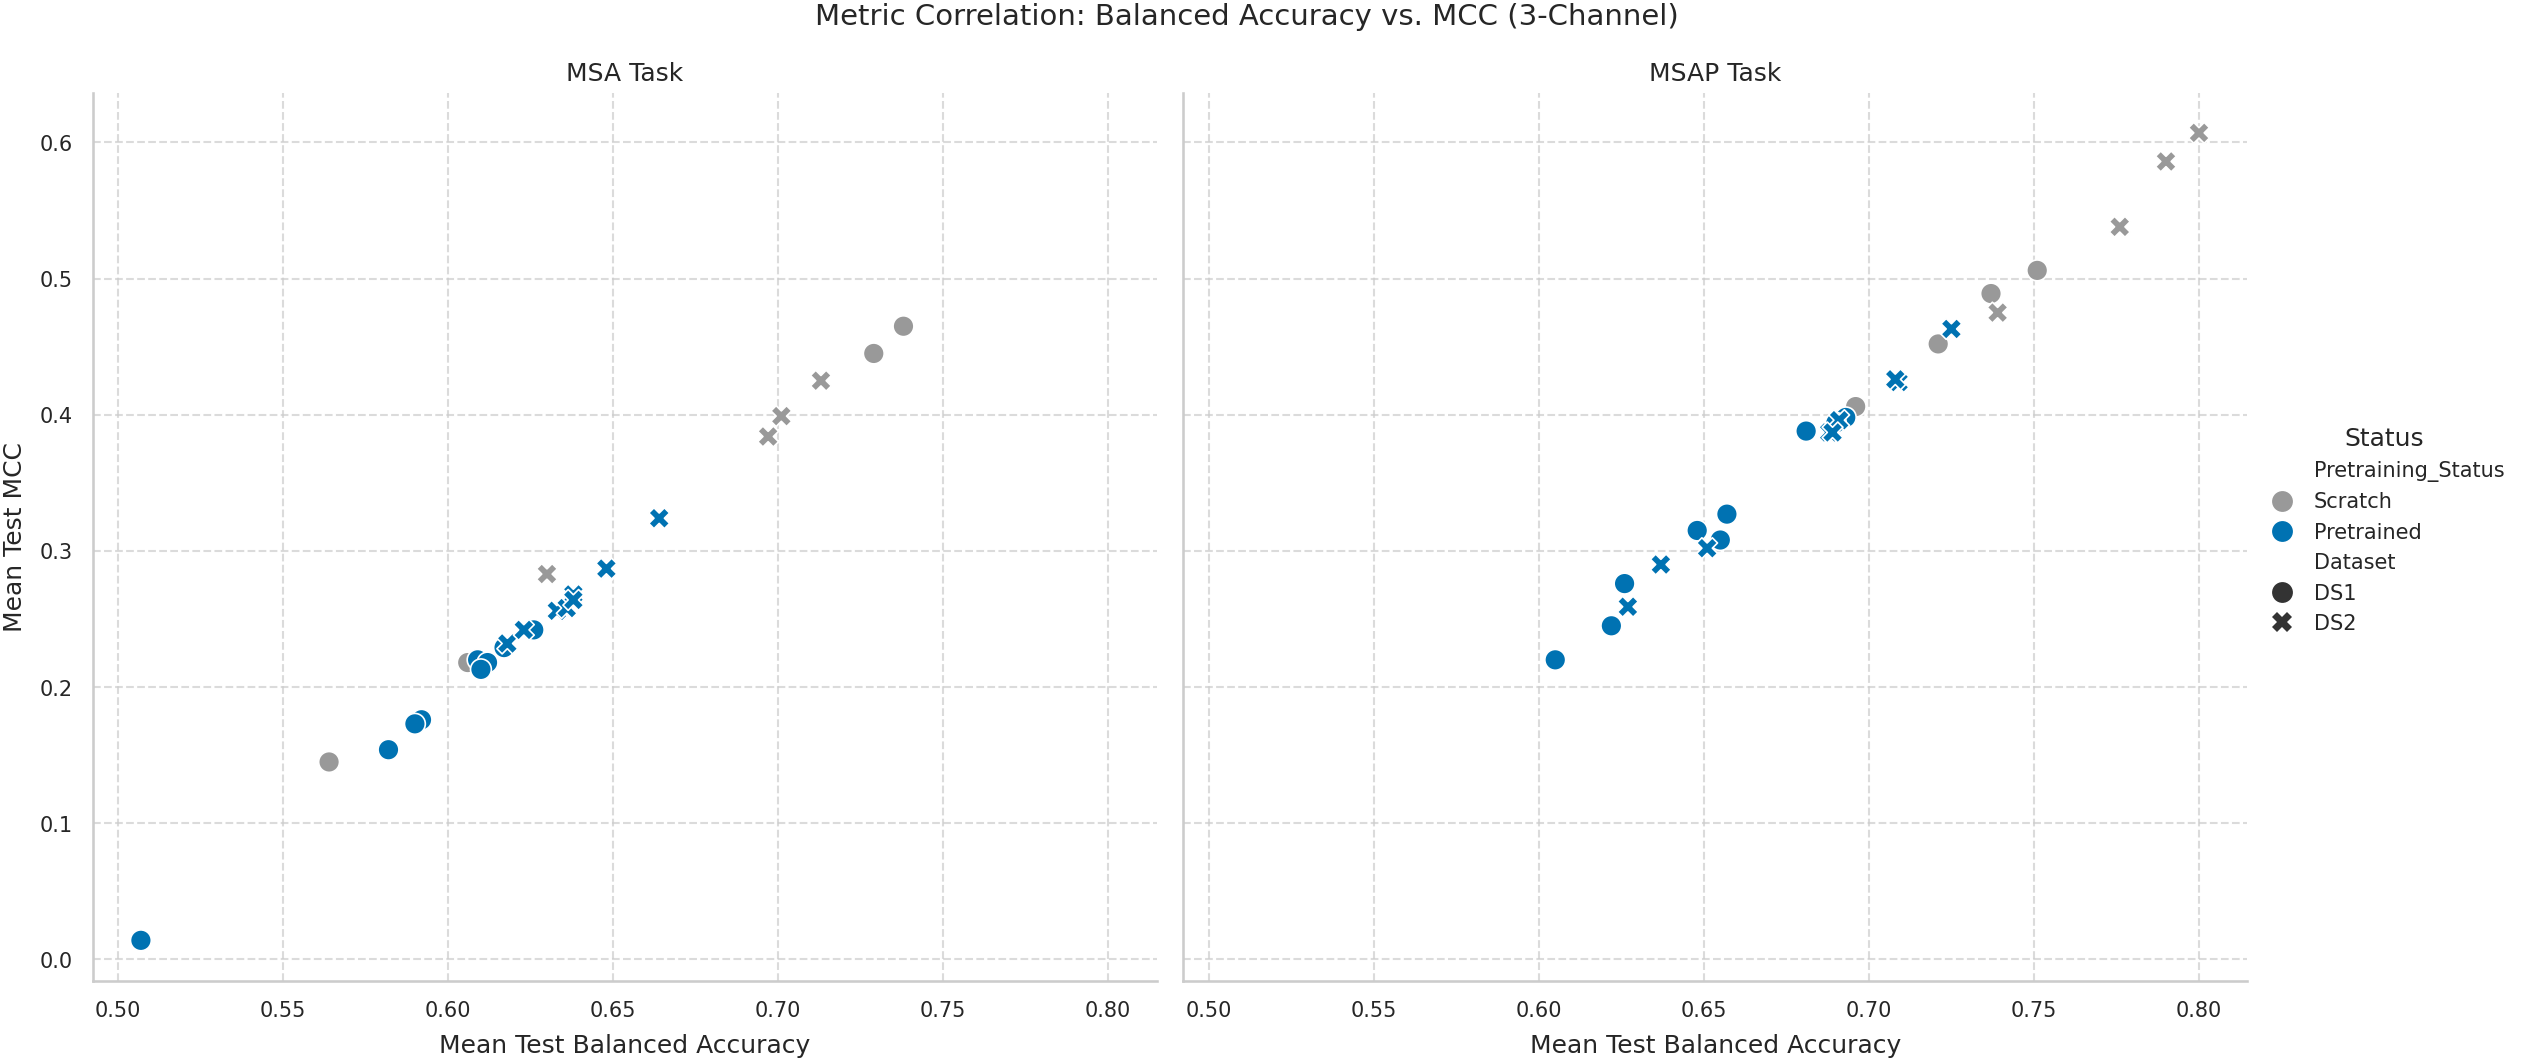

Plot saved to images/correlation_scatter/10_correlation_scatter_balacc_mcc.png
Correlation plot generated successfully.


In [104]:
# (Assuming your dfs_to_export is loaded)

# 1. Define all key sets
keys_to_compare_ds1_msa = {
    "Scratch": "DS1_MSA_NotPT_3c", "ImageNet": "DS1_MSA_PT_imagenet",
    "MicroscopyNet": "DS1_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds1_msap = {
    "Scratch": "DS1_MSAP_NotPT_3c", "ImageNet": "DS1_MSAP_PT_imagenet",
    "MicroscopyNet": "DS1_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSAP_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msa = {
    "Scratch": "DS2_MSA_NotPT_3c", "ImageNet": "DS2_MSA_PT_imagenet",
    "MicroscopyNet": "DS2_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msap = {
    "Scratch": "DS2_MSAP_NotPT_3c", "ImageNet": "DS2_MSAP_PT_imagenet",
    "MicroscopyNet": "DS2_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSAP_PT_imagenet_microscopynet"
}
key_sets = [keys_to_compare_ds1_msa, keys_to_compare_ds1_msap, keys_to_compare_ds2_msa, keys_to_compare_ds2_msap]

# 2. Build the master DataFrame
all_plot_data_frames = []
for keys_to_compare in key_sets:
    first_key = keys_to_compare['Scratch']
    dataset_name = 'DS1' if 'DS1' in first_key else 'DS2'
    class_name = 'MSAP' if 'MSAP' in first_key else 'MSA'
    
    for label, key in keys_to_compare.items():
        if key in dfs_to_export:
            temp_df = dfs_to_export[key].copy()
            temp_df['Pretraining'] = label
            temp_df['Dataset'] = dataset_name
            temp_df['Task'] = class_name
            all_plot_data_frames.append(temp_df)
        else:
            print(f"Warning: Key '{key}' not found in dfs_to_export.")

master_plot_df = pd.concat(all_plot_data_frames, ignore_index=True)

# 3. Add the new binary 'Pretraining_Status' column
# This column is 'Scratch' if Pretraining is 'Scratch', and 'Pretrained' otherwise
master_plot_df['Pretraining_Status'] = np.where(
    master_plot_df['Pretraining'] == 'Scratch', 
    'Scratch', 
    'Pretrained'
)

# 4. Filter to relevant columns
columns_to_keep = [ 
    'model_name', 'Pretraining', 'Dataset', 'Task', 'Pretraining_Status',
    'mean_test_balanced_acc', 'mean_test_mcc'
]
# Use .reindex to avoid errors if a column is missing, though they shouldn't be
master_plot_df = master_plot_df.reindex(columns=columns_to_keep)

print("--- Master DataFrame for Correlation ---")
print(master_plot_df.head().to_markdown(index=False))

def plot_metric_correlation_scatter(df, x_col, y_col, title, save_path):
    """
    Generates a faceted scatterplot of Bal. Acc. vs. MCC.
    - Facets (columns) = Task (MSA vs. MSAP)
    - Color = Pretraining_Status (Scratch vs. Pretrained)
    - Style (marker) = Dataset (DS1 vs. DS2)
    """
    
    apply_thesis_style()
    
    # Define specific palettes and markers for clarity
    status_palette = {
        'Scratch': '#999999',     # Grey
        'Pretrained': '#0072B2'   # Blue
    }
    dataset_markers = {
        'DS1': 'o',  # Circle
        'DS2': 'X'   # X
    }

    # 1. Create the Figure-level scatterplot
    g = sns.relplot(
        data=df,
        x=x_col,
        y=y_col,
        hue='Pretraining_Status', # Color by Scratch vs. Pretrained
        style='Dataset',          # Marker by DS1 vs. DS2
        col='Task',               # Facet by MSA vs. MSAP
        palette=status_palette,
        markers=dataset_markers,
        s=100,      # Marker size
        height=7,
        aspect=1.1
    )

    # 2. Add gridlines to each facet
    for ax in g.axes.flat:
        ax.grid(True, linestyle='--', alpha=0.7)

    # 3. Tidy up the plot
    g.set_axis_labels("Mean Test Balanced Accuracy", "Mean Test MCC")
    g.set_titles("{col_name} Task") # Set title for each column (MSA or MSAP)
    g.fig.suptitle(title, y=1.03, size=14) # Overall title
    
    # Tidy up the legend
    g.legend.set_title("Status")
    
    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the figure
    g.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(g.fig)
    print(f"Plot saved to {save_path}")
    
# Create the target save directory
os.makedirs('images/correlation_scatter', exist_ok=True)

if not master_plot_df.empty:
    plot_metric_correlation_scatter(
        df=master_plot_df,
        x_col='mean_test_balanced_acc',
        y_col='mean_test_mcc',
        title='Metric Correlation: Balanced Accuracy vs. MCC (3-Channel)',
        save_path='images/correlation_scatter/10_correlation_scatter_balacc_mcc.png'
    )
else:
    print("Master DataFrame is empty. Skipping correlation plot.")

print("Correlation plot generated successfully.")

## BOX STRIPS

 DIFFERENT PRETRAININGS COMPARISON PER DATASET


In [111]:
# Define the thesis style palette (Okabe-Ito, colorblind-safe)
THESIS_PALETTE = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9', '#E69F00', '#999999']

def apply_thesis_style():
    """Applies the standard thesis plot style for Matplotlib and Seaborn."""
    sns.set_theme(style="whitegrid", palette=THESIS_PALETTE)
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'lines.linewidth': 2.0,
        'lines.markersize': 7,
        'figure.dpi': 150
    })
    plt.rc('axes.spines', top=False, right=False)

In [112]:
def plot_pretraining_box_strip(df, metric_col, y_label, title, save_path):
    """
    Generates a plot combining a boxplot (for distribution/std)
    and a stripplot (for individual points).
    """
    
    apply_thesis_style()
    
    # Determine the number of models to set the palette
    num_models = len(df['model_name'].unique())
    model_palette = ['#66C2A5', '#FC8D62', '#8DA0CB', '#E78AC3']  # Green, orange, blue, pink


    fig, ax = plt.subplots(figsize=(12, 7))

    # 1. Draw the Box Plots (for summary statistics)
    #    This will show the median, 25th, and 75th percentiles.
    sns.boxplot(
        data=df,
        x='Pretraining',
        y=metric_col,
        ax=ax,
        color="0.9",  # A light, neutral grey for the boxes
        showfliers=False, # Hide outliers, we will plot all points
        boxprops={'alpha': 0.7} # Make box slightly transparent
    )

    # 2. Overlay the individual points (Strip Plot)
    #    'jitter=True' spreads them horizontally to avoid overlap
    sns.stripplot(
        data=df,
        x='Pretraining',
        y=metric_col,
        hue='model_name',
        palette=model_palette,
        ax=ax,
        jitter=True, # Add 'jitter' to prevent points overlapping
        s=7,         # Marker size
        alpha=1.0    # Solid points
    )

    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel("Pretraining Strategy")
    
    # Add horizontal grid lines for readability
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Move legend outside the plot area
    ax.legend(title='Model Name', loc='upper left', bbox_to_anchor=(1.02, 1))
    
    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    print("Unique Pretraining:", sorted(df['Pretraining'].astype(str).unique()))
    print("Counts by Pretraining:\n", df['Pretraining'].astype(str).value_counts())
    print("NaNs by Pretraining:\n", df.groupby('Pretraining')['mean_test_balanced_acc'].apply(lambda s: s.isna().sum()))
    print("Scratch rows preview:\n", df[df['Pretraining'].astype(str).str.strip().str.lower().isin(['scratch','notpt','from_scratch'])][['Pretraining','model_name','mean_test_balanced_acc']].head(10))
    # Save the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print(f"Plot saved to {save_path}")

In [113]:
# df_ds2_msap_notpt.head()
df_ds2_msap_notpt_3c.head()

experiment_name  \
19  DS2_3c_MSA-P_vs_PD_supervised   
20  DS2_3c_MSA-P_vs_PD_supervised   
21  DS2_3c_MSA-P_vs_PD_supervised   
22  DS2_3c_MSA-P_vs_PD_supervised   

                                             run_name dataset      classes  \
19                        ViT_monai_11-02_at:00-05-33     DS2  MSA-P vs PD   
20    Resnet18_oversamp_torchvision_11-01_at:22-46-08     DS2  MSA-P vs PD   
21  Densenet169_oversamp_torchvision_11-01_at:21-4...     DS2  MSA-P vs PD   
22  Densenet121_oversamp_torchvision_11-01_at:18-4...     DS2  MSA-P vs PD   

    num_channels ablated_channel ablated_channel_idx ablation_iteration  \
19             3             NaN                 NaN                NaN   
20             3             NaN                 NaN                NaN   
21             3             NaN                 NaN                NaN   
22             3             NaN                 NaN                NaN   

   ablation_study                 best_lr creation_date creation_time  \
19            NaN  0.00012207764786954147         11-02      00:05:33   
20            NaN  0.00012207764786954147         11-01      22:46:08   
21            NaN  1.9906996673933362e-05         11-01      21:45:46   
22            NaN  1.9906996673933362e-05         11-01      18:45:38   

   dropout_rate epochs freezed_layer_index intensity_augmentation_preset  \
19          0.2    450                None                         light   
20          0.2    150                None                         light   
21          0.2    150                None                         light   
22          0.2    150                None                         light   

   lr_discovery_folds mixup_alpha model_library   model_name optimizer_name  \
19                  4           0         monai          ViT           Adam   
20                  4           0   torchvision     Resnet18           Adam   
21                  4           0   torchvision  Densenet169           Adam   
22                  4           0   torchvision  Densenet121           Adam   

   pretrained_weights                                        test_counts  \
19               None  {'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...   
20           imagenet                                                 70   
21           imagenet                                                 70   
22           imagenet                                                 70   

                           test_pat_ids_for_best_fold  \
19  ['5463' '5978' '5992' '6351' '6383' '7284' '74...   
20                                                NaN   
21  ['5463' '5978' '5992' '6351' '6383' '7284' '74...   
22                                                NaN   

                                test_pat_ids_per_fold  \
19  {0: array(['5776', '6008', '6060', '6258', '63...   
20  {0: array(['5776', '6008', '6060', '6258', '63...   
21  {0: array(['5776', '6008', '6060', '6258', '63...   
22  {0: array(['5776', '6008', '6060', '6258', '63...   

   total_channels_available total_params  \
19                      NaN      1022210   
20                      NaN     11177538   
21                      NaN     12487810   
22                      NaN      6955906   

                                         train_counts trainable_params  \
19  {0: 410, 1: 418, 2: 405, 3: 400, 4: 387, 5: 43...          1022210   
20  {0: 410, 1: 418, 2: 405, 3: 400, 4: 387, 5: 43...         11177538   
21  {0: 410, 1: 418, 2: 405, 3: 400, 4: 387, 5: 43...         12487810   
22  {0: 410, 1: 418, 2: 405, 3: 400, 4: 387, 5: 43...          6955906   

   transfer_learning                                         val_counts  \
19             False  {0: 59, 1: 70, 2: 60, 3: 95, 4: 101, 5: 67, 6:...   
20             False  {0: 59, 1: 70, 2: 60, 3: 95, 4: 101, 5: 67, 6:...   
21             False  {0: 59, 1: 70, 2: 60, 3: 95, 4: 101, 5: 67, 6:...   
22             False  {0: 59, 1: 70, 2: 60, 3: 95, 4: 101, 5: 67, 6:...   

 

Robust plotting DataFrame prepared:
| model_name   | Pretraining              |   mean_test_balanced_acc |   std_test_balanced_acc |   mean_test_mcc |   std_test_mcc |
|:-------------|:-------------------------|-------------------------:|------------------------:|----------------:|---------------:|
| Densenet121  | Scratch                  |                    0.738 |                   0.127 |           0.465 |          0.243 |
| Densenet169  | Scratch                  |                    0.729 |                   0.156 |           0.445 |          0.299 |
| Resnet18     | Scratch                  |                    0.606 |                   0.115 |           0.218 |          0.233 |
| ViT          | Scratch                  |                    0.564 |                   0.114 |           0.145 |          0.27  |
| Densenet121  | ImageNet                 |                    0.592 |                   0.157 |           0.176 |          0.304 |
| Densenet169  | ImageNet               

/tmp/ipykernel_211839/2284057549.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("NaNs by Pretraining:\n", df.groupby('Pretraining')['mean_test_balanced_acc'].apply(lambda s: s.isna().sum()))


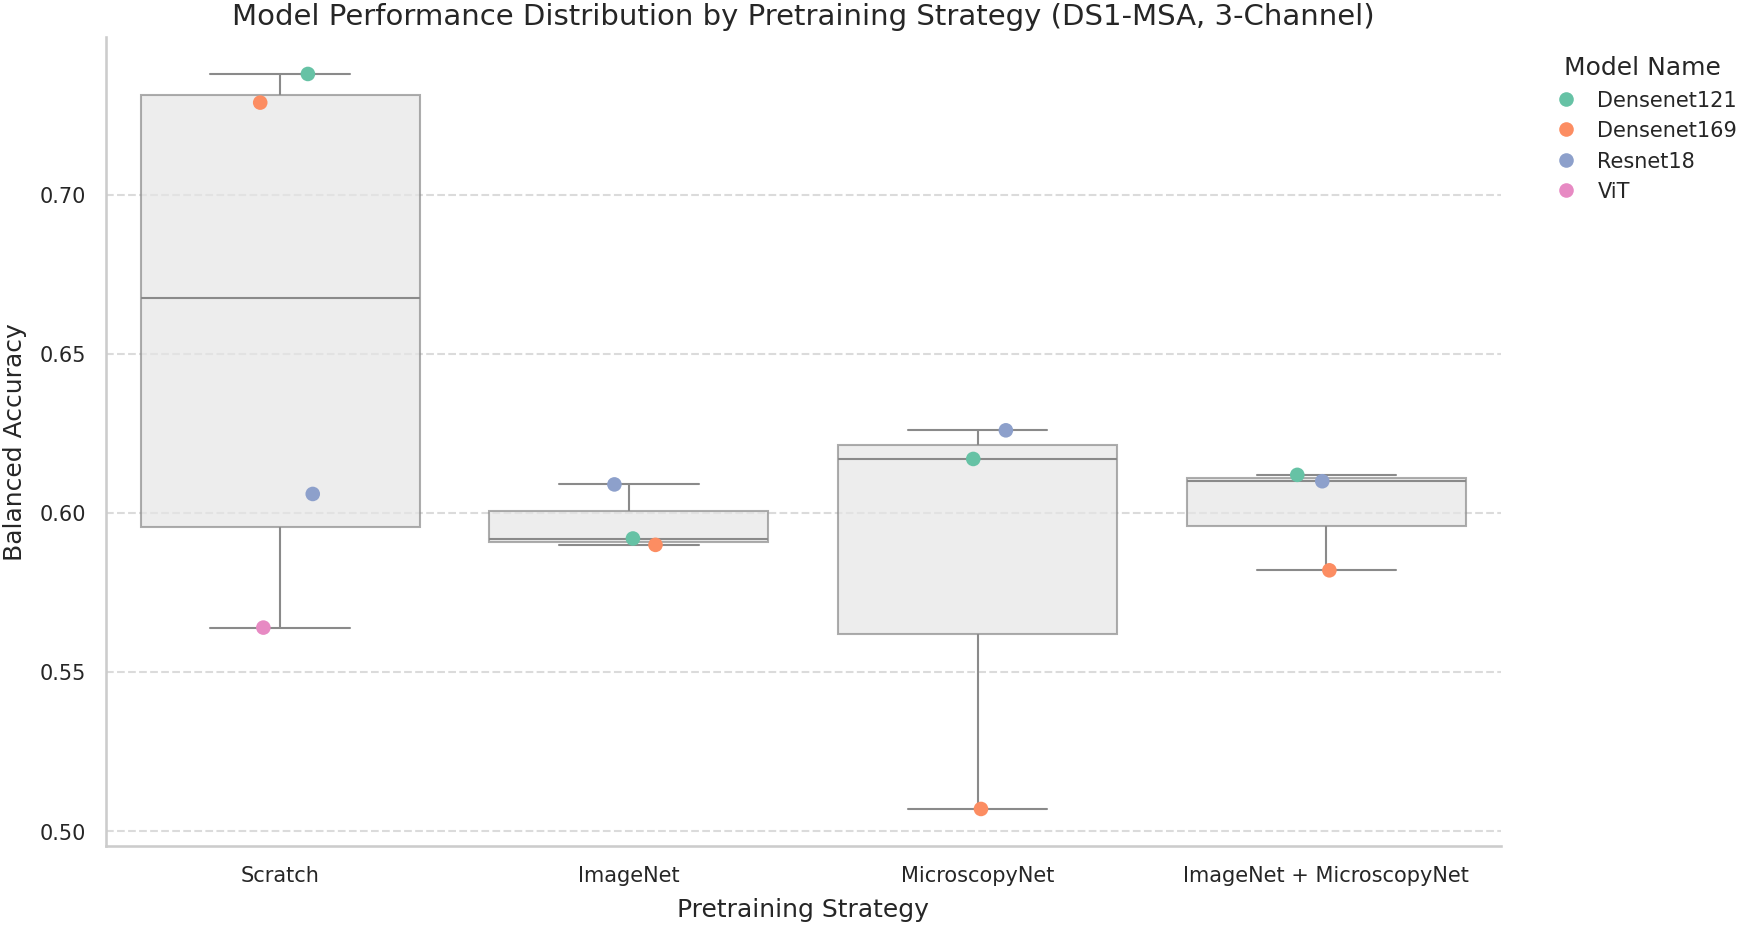

Plot saved to images/box_strip/06_pretraining_box_strip_bal_acc_DS1_MSA.png
Robust plotting DataFrame prepared:
| model_name   | Pretraining              |   mean_test_balanced_acc |   std_test_balanced_acc |   mean_test_mcc |   std_test_mcc |
|:-------------|:-------------------------|-------------------------:|------------------------:|----------------:|---------------:|
| Densenet121  | Scratch                  |                    0.696 |                   0.126 |           0.406 |          0.261 |
| Densenet169  | Scratch                  |                    0.721 |                   0.128 |           0.452 |          0.259 |
| Resnet18     | Scratch                  |                    0.751 |                   0.162 |           0.506 |          0.327 |
| ViT          | Scratch                  |                    0.737 |                   0.161 |           0.489 |          0.323 |
| Densenet121  | ImageNet                 |                    0.605 |                   0.09  |

/tmp/ipykernel_211839/2284057549.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("NaNs by Pretraining:\n", df.groupby('Pretraining')['mean_test_balanced_acc'].apply(lambda s: s.isna().sum()))


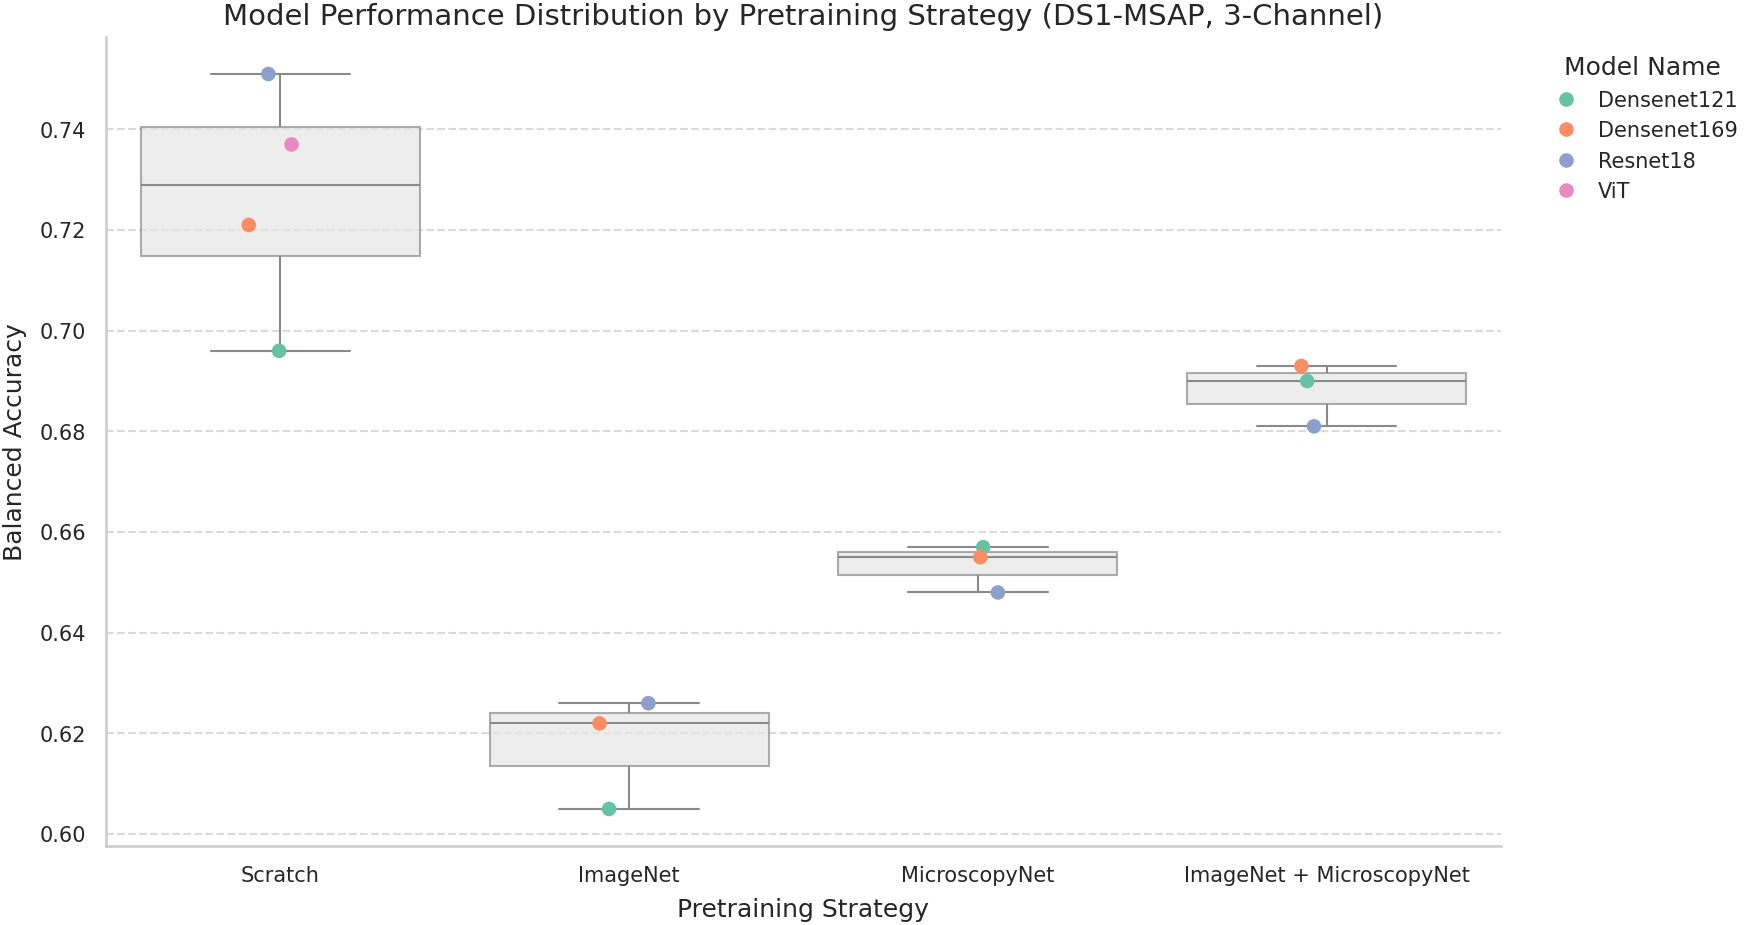

Plot saved to images/box_strip/06_pretraining_box_strip_bal_acc_DS1_MSAP.png
Robust plotting DataFrame prepared:
| model_name   | Pretraining              |   mean_test_balanced_acc |   std_test_balanced_acc |   mean_test_mcc |   std_test_mcc |
|:-------------|:-------------------------|-------------------------:|------------------------:|----------------:|---------------:|
| Densenet121  | Scratch                  |                    0.701 |                   0.076 |           0.399 |          0.154 |
| Densenet169  | Scratch                  |                    0.697 |                   0.071 |           0.384 |          0.138 |
| Resnet18     | Scratch                  |                    0.713 |                   0.104 |           0.425 |          0.209 |
| ViT          | Scratch                  |                    0.63  |                   0.073 |           0.283 |          0.172 |
| Densenet121  | ImageNet                 |                    0.638 |                   0.107 

/tmp/ipykernel_211839/2284057549.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("NaNs by Pretraining:\n", df.groupby('Pretraining')['mean_test_balanced_acc'].apply(lambda s: s.isna().sum()))


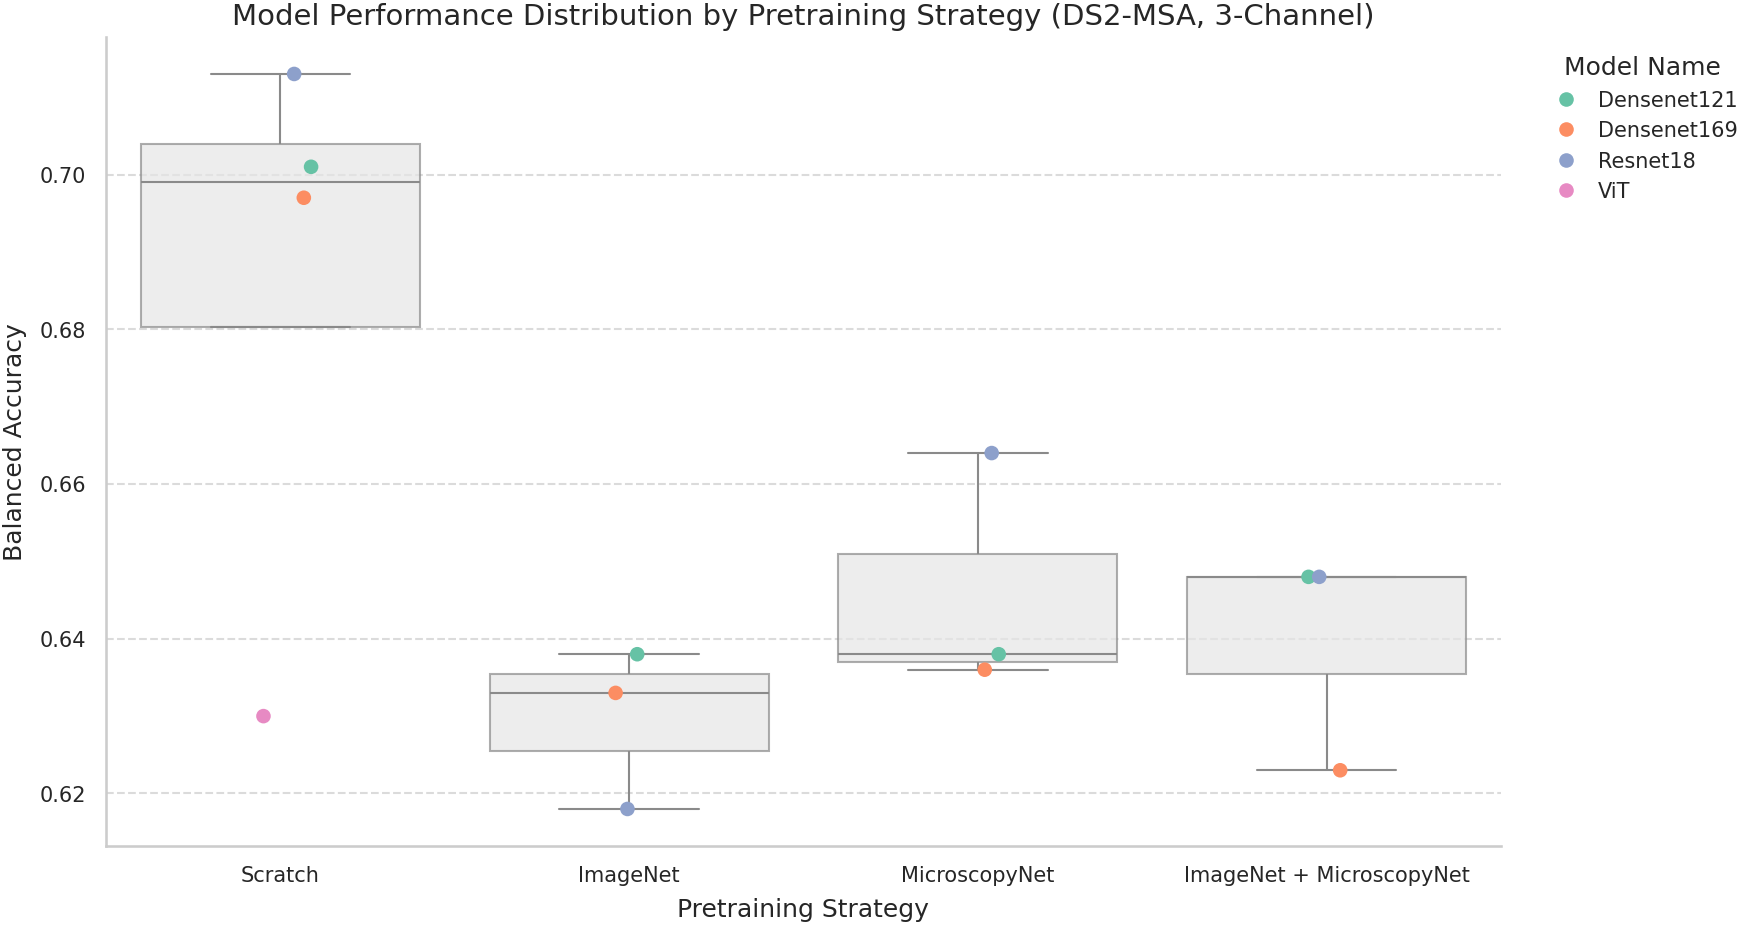

Plot saved to images/box_strip/06_pretraining_box_strip_bal_acc_DS2_MSA.png
Robust plotting DataFrame prepared:
| model_name   | Pretraining              |   mean_test_balanced_acc |   std_test_balanced_acc |   mean_test_mcc |   std_test_mcc |
|:-------------|:-------------------------|-------------------------:|------------------------:|----------------:|---------------:|
| Densenet121  | Scratch                  |                    0.8   |                   0.129 |           0.607 |          0.252 |
| Densenet169  | Scratch                  |                    0.79  |                   0.121 |           0.586 |          0.234 |
| Resnet18     | Scratch                  |                    0.776 |                   0.167 |           0.538 |          0.359 |
| ViT          | Scratch                  |                    0.739 |                   0.17  |           0.475 |          0.342 |
| Densenet121  | ImageNet                 |                    0.651 |                   0.147 |

/tmp/ipykernel_211839/2284057549.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("NaNs by Pretraining:\n", df.groupby('Pretraining')['mean_test_balanced_acc'].apply(lambda s: s.isna().sum()))


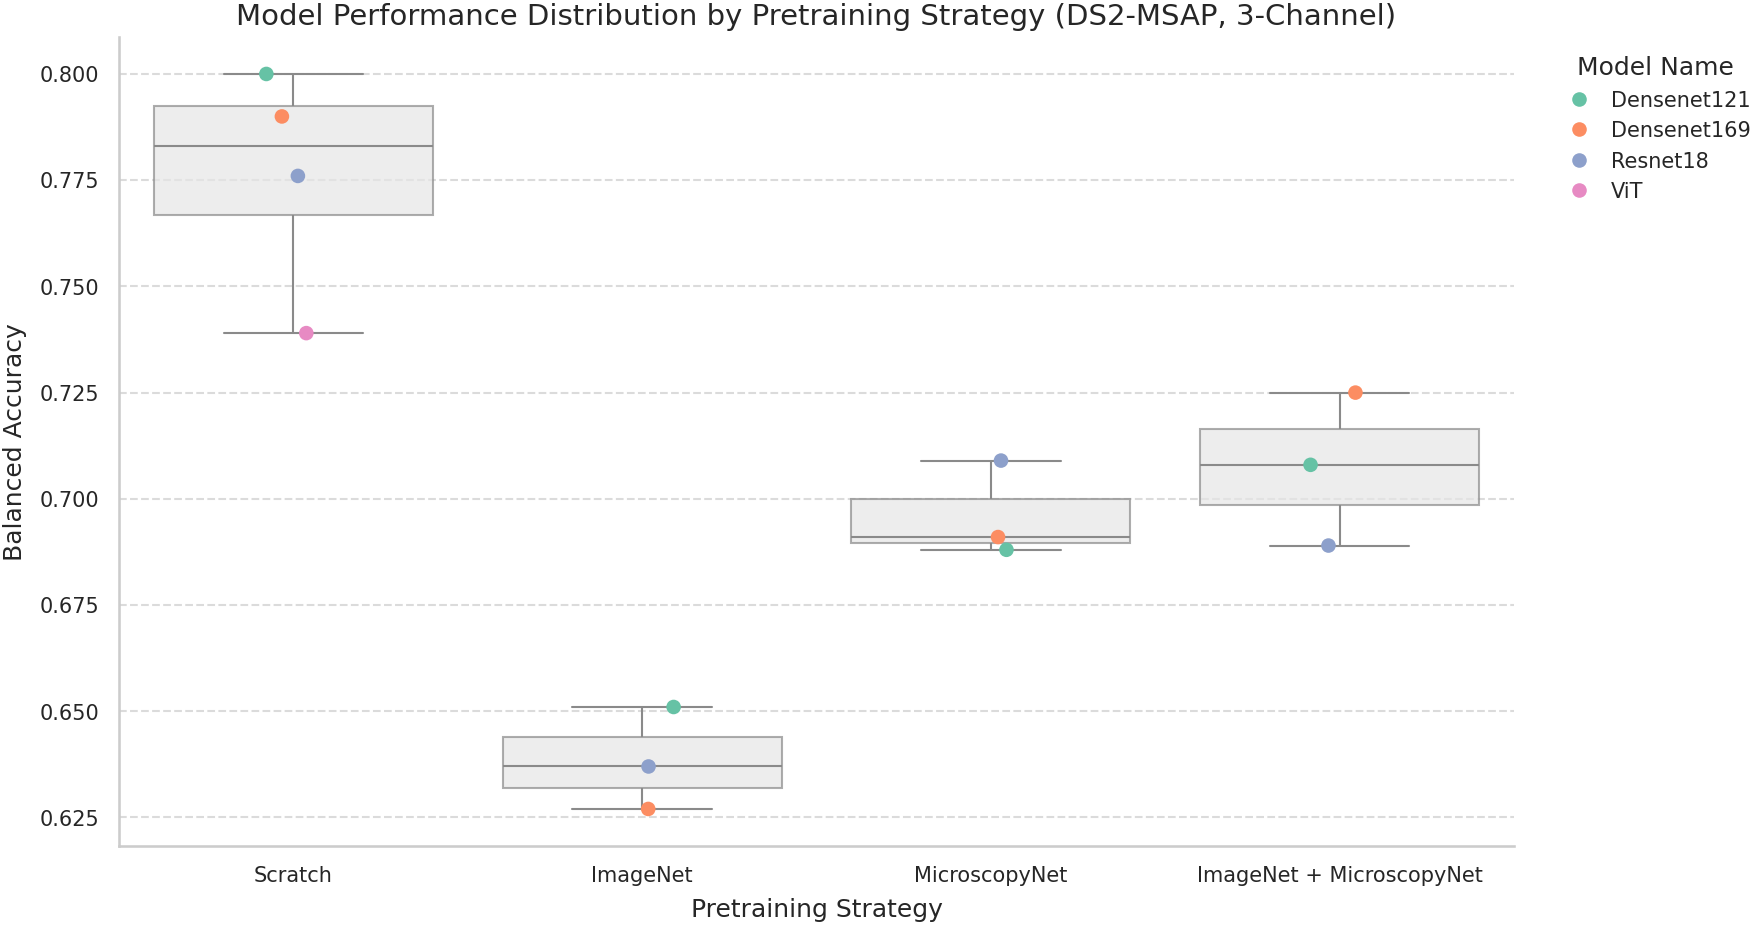

Plot saved to images/box_strip/06_pretraining_box_strip_bal_acc_DS2_MSAP.png


In [114]:
# 1. Define the keys for comparison (using your correction)
keys_to_compare_ds1_msa = {
    "Scratch": "DS1_MSA_NotPT_3c",
    "ImageNet": "DS1_MSA_PT_imagenet",
    "MicroscopyNet": "DS1_MSA_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS1_MSA_PT_imagenet_microscopynet"
}

keys_to_compare_ds1_msap = {
    "Scratch": "DS1_MSAP_NotPT_3c",
    "ImageNet": "DS1_MSAP_PT_imagenet",
    "MicroscopyNet": "DS1_MSAP_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS1_MSAP_PT_imagenet_microscopynet"
}

keys_to_compare_ds2_msa = {
    "Scratch": "DS2_MSA_NotPT_3c",
    "ImageNet": "DS2_MSA_PT_imagenet",
    "MicroscopyNet": "DS2_MSA_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS2_MSA_PT_imagenet_microscopynet"
}

keys_to_compare_ds2_msap = {
    "Scratch": "DS2_MSAP_NotPT_3c",
    "ImageNet": "DS2_MSAP_PT_imagenet",
    "MicroscopyNet": "DS2_MSAP_PT_microscopy",
    "ImageNet + MicroscopyNet": "DS2_MSAP_PT_imagenet_microscopynet"
}

# 2. Extract and concatenate *all* relevant data
for keys_to_compare in [keys_to_compare_ds1_msa, keys_to_compare_ds1_msap, keys_to_compare_ds2_msa, keys_to_compare_ds2_msap]:
    dataset_name = 'DS1' if 'DS1' in keys_to_compare['Scratch'] else 'DS2'
    class_name = 'MSAP' if 'MSAP' in keys_to_compare['Scratch'] else 'MSA'
    
    plot_data_frames = []
    #NOTE CHANGE THIS KEYS_TO_COMPARE TO CHANGE DS 
    for label, key in keys_to_compare.items():
        if key in dfs_to_export:
            # Get the full DataFrame
            temp_df = dfs_to_export[key].copy()
            # Add the 'Pretraining' label as a new column
            temp_df['Pretraining'] = label
            plot_data_frames.append(temp_df)
        else:
            print(f"Warning: Key '{key}' not found in dfs_to_export.")

    # 3. Create one master DataFrame for plotting
    plot_df = pd.concat(plot_data_frames, ignore_index=True)

    # 4. Filter to only essential columns
    columns_to_keep = [ 
        'model_name', 'Pretraining',
        'mean_test_balanced_acc', 'std_test_balanced_acc',
        'mean_test_mcc', 'std_test_mcc'
    ]
    plot_df = plot_df[columns_to_keep]

    # 5. Set categorical order for 'Pretraining' to ensure correct plot order
    plot_df['Pretraining'] = pd.Categorical(
        plot_df['Pretraining'],
        categories=keys_to_compare.keys()
    )

    # 6. Sort values for predictable plotting
    plot_df = plot_df.sort_values(by=['Pretraining', 'model_name'])

    print("Robust plotting DataFrame prepared:")
    print(plot_df.to_markdown(index=False))
    
    plot_pretraining_box_strip(
        df=plot_df,
        metric_col='mean_test_balanced_acc',
        y_label='Balanced Accuracy',
        title=f'Model Performance Distribution by Pretraining Strategy ({dataset_name}-{class_name}, 3-Channel)',
        save_path=f'images/box_strip/06_pretraining_box_strip_bal_acc_{dataset_name}_{class_name}.png'
    )

### BOX STRIPTS SIDE BY SIDE

In [116]:
# --- 3. Key Definitions ---
# (Assuming your dfs_to_export is loaded)

keys_to_compare_ds1_msa = {
    "Scratch": "DS1_MSA_NotPT_3c", "ImageNet": "DS1_MSA_PT_imagenet",
    "MicroscopyNet": "DS1_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds1_msap = {
    "Scratch": "DS1_MSAP_NotPT_3c", "ImageNet": "DS1_MSAP_PT_imagenet",
    "MicroscopyNet": "DS1_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS1_MSAP_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msa = {
    "Scratch": "DS2_MSA_NotPT_3c", "ImageNet": "DS2_MSA_PT_imagenet",
    "MicroscopyNet": "DS2_MSA_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSA_PT_imagenet_microscopynet"
}
keys_to_compare_ds2_msap = {
    "Scratch": "DS2_MSAP_NotPT_3c", "ImageNet": "DS2_MSAP_PT_imagenet",
    "MicroscopyNet": "DS2_MSAP_PT_microscopy", "ImageNet + MicroscopyNet": "DS2_MSAP_PT_imagenet_microscopynet"
}

key_sets = [keys_to_compare_ds1_msa, keys_to_compare_ds1_msap, keys_to_compare_ds2_msa, keys_to_compare_ds2_msap]

# --- 4. Master DataFrame Creation ---
all_plot_data_frames = []
for keys_to_compare in key_sets:
    first_key = keys_to_compare['Scratch']
    dataset_name = 'DS1' if 'DS1' in first_key else 'DS2'
    class_name = 'MSAP' if 'MSAP' in first_key else 'MSA'
    
    for label, key in keys_to_compare.items():
        if key in dfs_to_export: # This will now use YOUR data
            temp_df = dfs_to_export[key].copy()
            temp_df['Pretraining'] = label
            temp_df['Dataset'] = dataset_name
            temp_df['Task'] = class_name
            all_plot_data_frames.append(temp_df)
        else:
            print(f"Warning: Key '{key}' not found in dfs_to_export.")

master_plot_df = pd.concat(all_plot_data_frames, ignore_index=True)

columns_to_keep = [ 
    'model_name', 'Pretraining', 'Dataset', 'Task',
    'mean_test_balanced_acc', 'std_test_balanced_acc',
    'mean_test_mcc', 'std_test_mcc'
]
master_plot_df = master_plot_df[columns_to_keep]

master_plot_df['Pretraining'] = pd.Categorical(
    master_plot_df['Pretraining'],
    categories=keys_to_compare_ds1_msa.keys()
)

print("--- Master Plotting DataFrame (from your data) ---")
print(master_plot_df.to_markdown(index=False))

--- Master Plotting DataFrame (from your data) ---
| model_name   | Pretraining              | Dataset   | Task   |   mean_test_balanced_acc |   std_test_balanced_acc |   mean_test_mcc |   std_test_mcc |
|:-------------|:-------------------------|:----------|:-------|-------------------------:|------------------------:|----------------:|---------------:|
| Densenet121  | Scratch                  | DS1       | MSA    |                    0.738 |                   0.127 |           0.465 |          0.243 |
| Densenet169  | Scratch                  | DS1       | MSA    |                    0.729 |                   0.156 |           0.445 |          0.299 |
| Resnet18     | Scratch                  | DS1       | MSA    |                    0.606 |                   0.115 |           0.218 |          0.233 |
| ViT          | Scratch                  | DS1       | MSA    |                    0.564 |                   0.114 |           0.145 |          0.27  |
| Resnet18     | ImageNet      

In [117]:
def plot_faceted_box_strip(df, metric_col, y_label, title_prefix, save_path):
    """
    Generates a faceted plot (side-by-side columns) for MSA vs MSAP.
    Each facet combines a boxplot and a stripplot with model_name hue.
    """
    
    apply_thesis_style()
    
    # Architecture colors mapping (from plotting rules)
    architecture_colors = {
        'vit': '#E69F00',           # Amber
        'resnet18': '#999999',      # Gray
        'densenet121': '#8B4513',   # Saddle brown
        'densenet169': '#6A5ACD',   # Slate blue
    }
    
    # Define desired architecture order for legend
    architecture_order = ['densenet121', 'densenet169', 'resnet18', 'vit']
    
    # Add architecture column to df for sorting
    df_plot = df.copy()
    df_plot['_arch'] = df_plot['model_name'].apply(extract_architecture_name)
    
    # Create order mapping
    arch_order_map = {arch: i for i, arch in enumerate(architecture_order)}
    df_plot['_arch_order'] = df_plot['_arch'].map(lambda x: arch_order_map.get(x, 999))
    
    # Sort by architecture order, then by model_name to maintain consistency
    df_plot = df_plot.sort_values(['_arch_order', 'model_name']).reset_index(drop=True)
    
    # Create palette dict mapping each model_name to its architecture color
    unique_models = df_plot['model_name'].unique()
    model_palette_dict = {}
    for model_name in unique_models:
        arch = extract_architecture_name(model_name)
        model_palette_dict[model_name] = architecture_colors.get(arch, '#CCCCCC')  # Default gray if unknown
    
    # Convert model_name to categorical with ordered categories to control legend order
    ordered_models = list(unique_models)  # Already sorted by architecture
    df_plot['model_name'] = pd.Categorical(df_plot['model_name'], categories=ordered_models, ordered=True)
    
    # For seaborn, we need to pass the dict directly
    model_palette = model_palette_dict

    # 1. Create the Figure-level plot using catplot
    #    'col="Task"' is what creates the side-by-side plots.
    g = sns.catplot(
        data=df_plot,
        x='Pretraining',
        y=metric_col,
        col='Task',          # <-- This creates the facets
        kind='box',          # <-- Start with the boxplot
        color="0.9",         # Light grey for boxes
        showfliers=False,    # Hide outliers
        boxprops={'alpha': 0.7},
        height=7,
        aspect=1.2
    )

    # 2. Iterate over each facet (Axes) to overlay the stripplot
    #    This is the key to getting the overlay right.
    g.map_dataframe(
        sns.stripplot,
        x='Pretraining',
        y=metric_col,
        hue='model_name',   # <-- Color the points by model
        palette=model_palette,
        jitter=True,
        s=7,
        alpha=1.0,
        dodge=False # We don't need to dodge, just jitter
    )

    # 3. Tidy up the plot
    g.set_axis_labels("Pretraining Strategy", y_label)
    g.set_titles("{col_name}") # Set title for each column (MSA or MSAP)
    g.fig.suptitle(title_prefix, y=1.03, size=14) # Overall title
    
    # Add a single, shared legend
    g.add_legend(title='Model Name')
    
    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the figure
    g.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(g.fig)
    print(f"Plot saved to {save_path}")

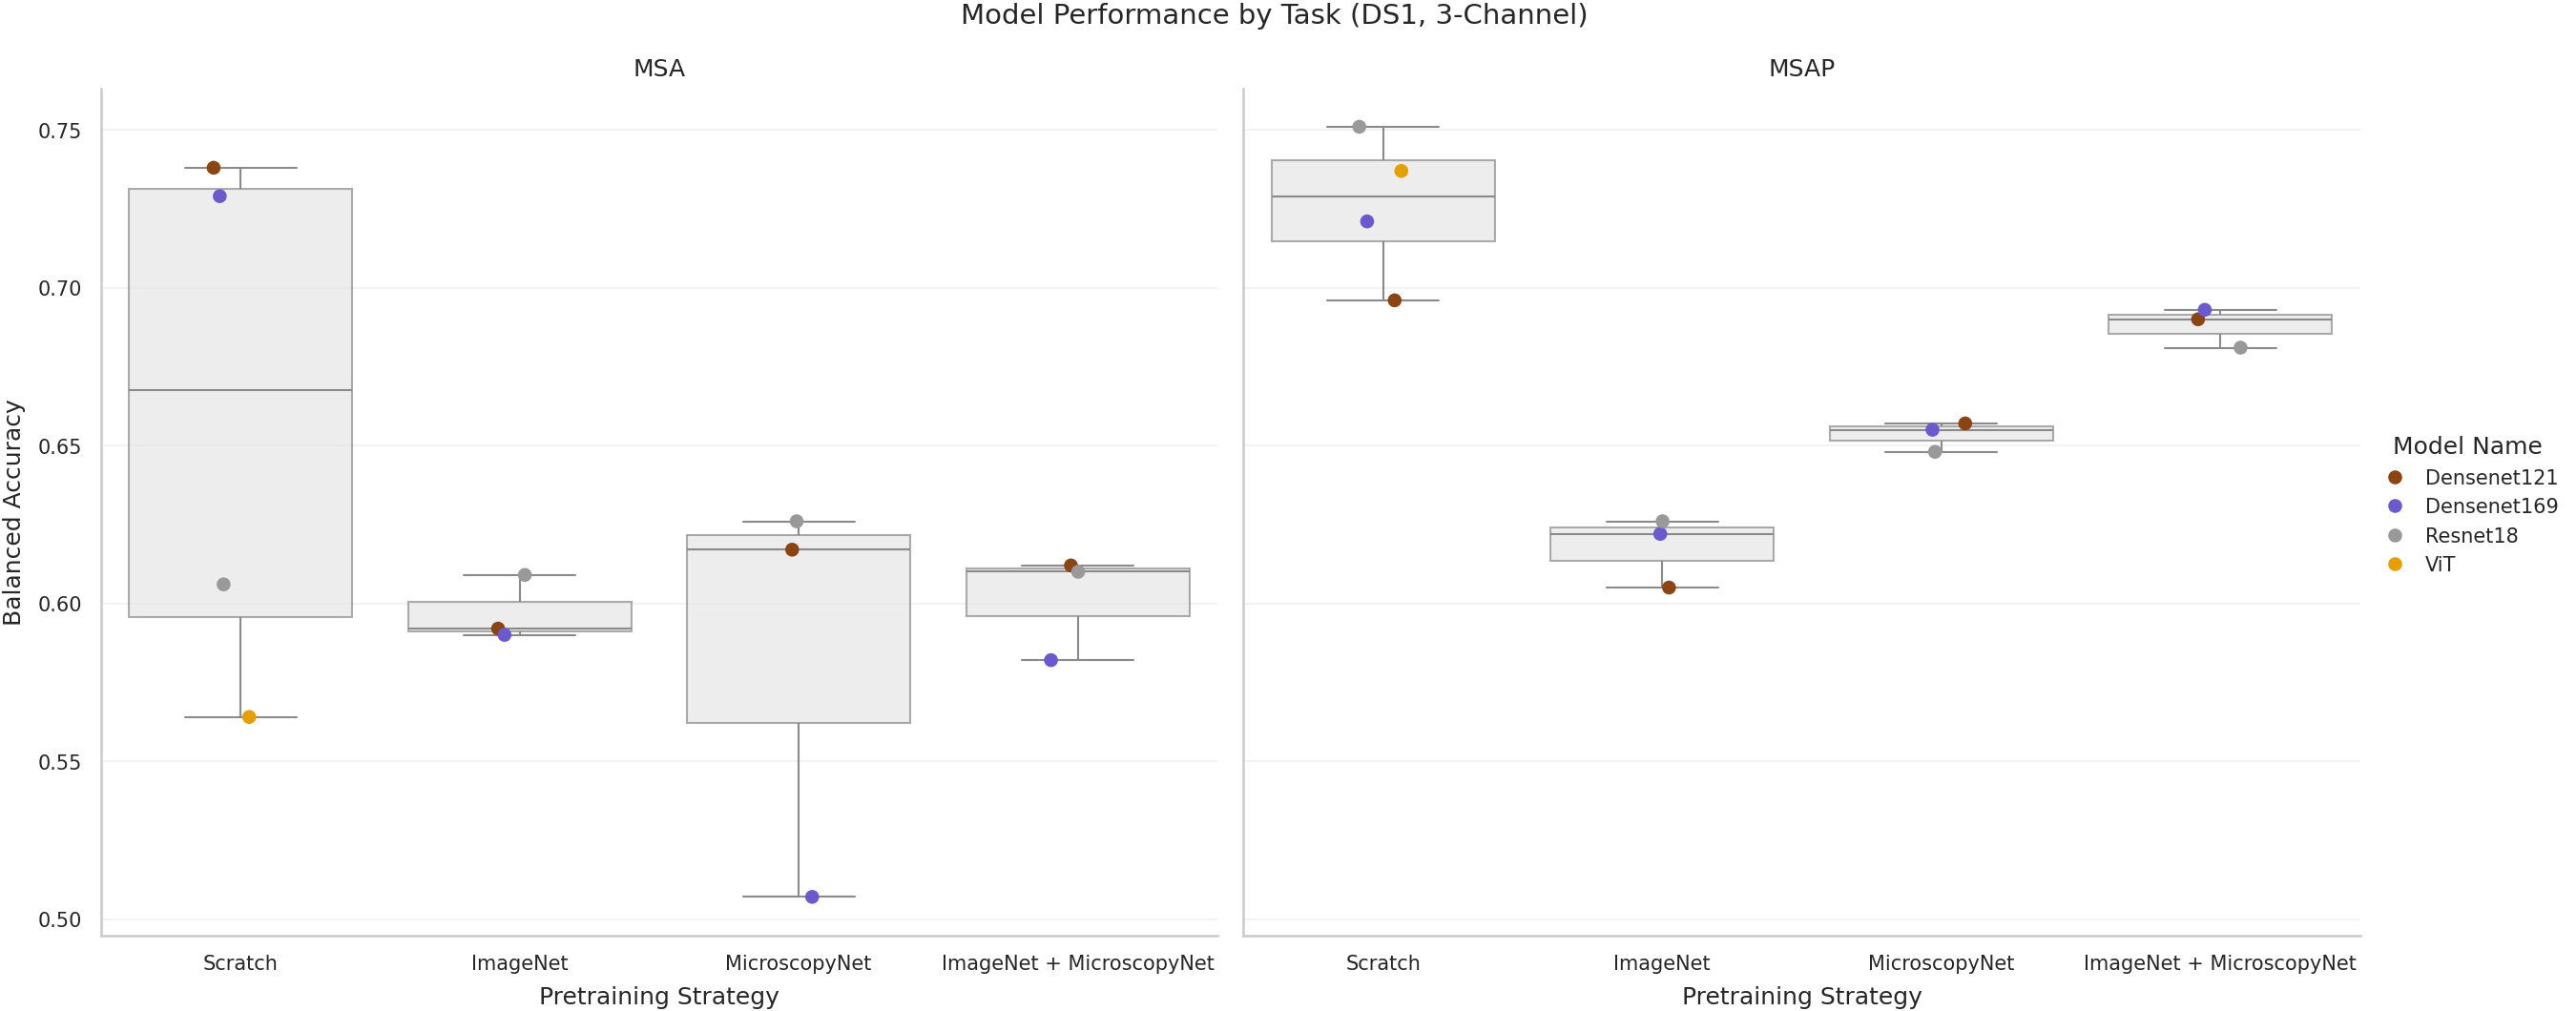

Plot saved to images/faceted_box_strip/08_faceted_box_strip_bal_acc_DS1.png


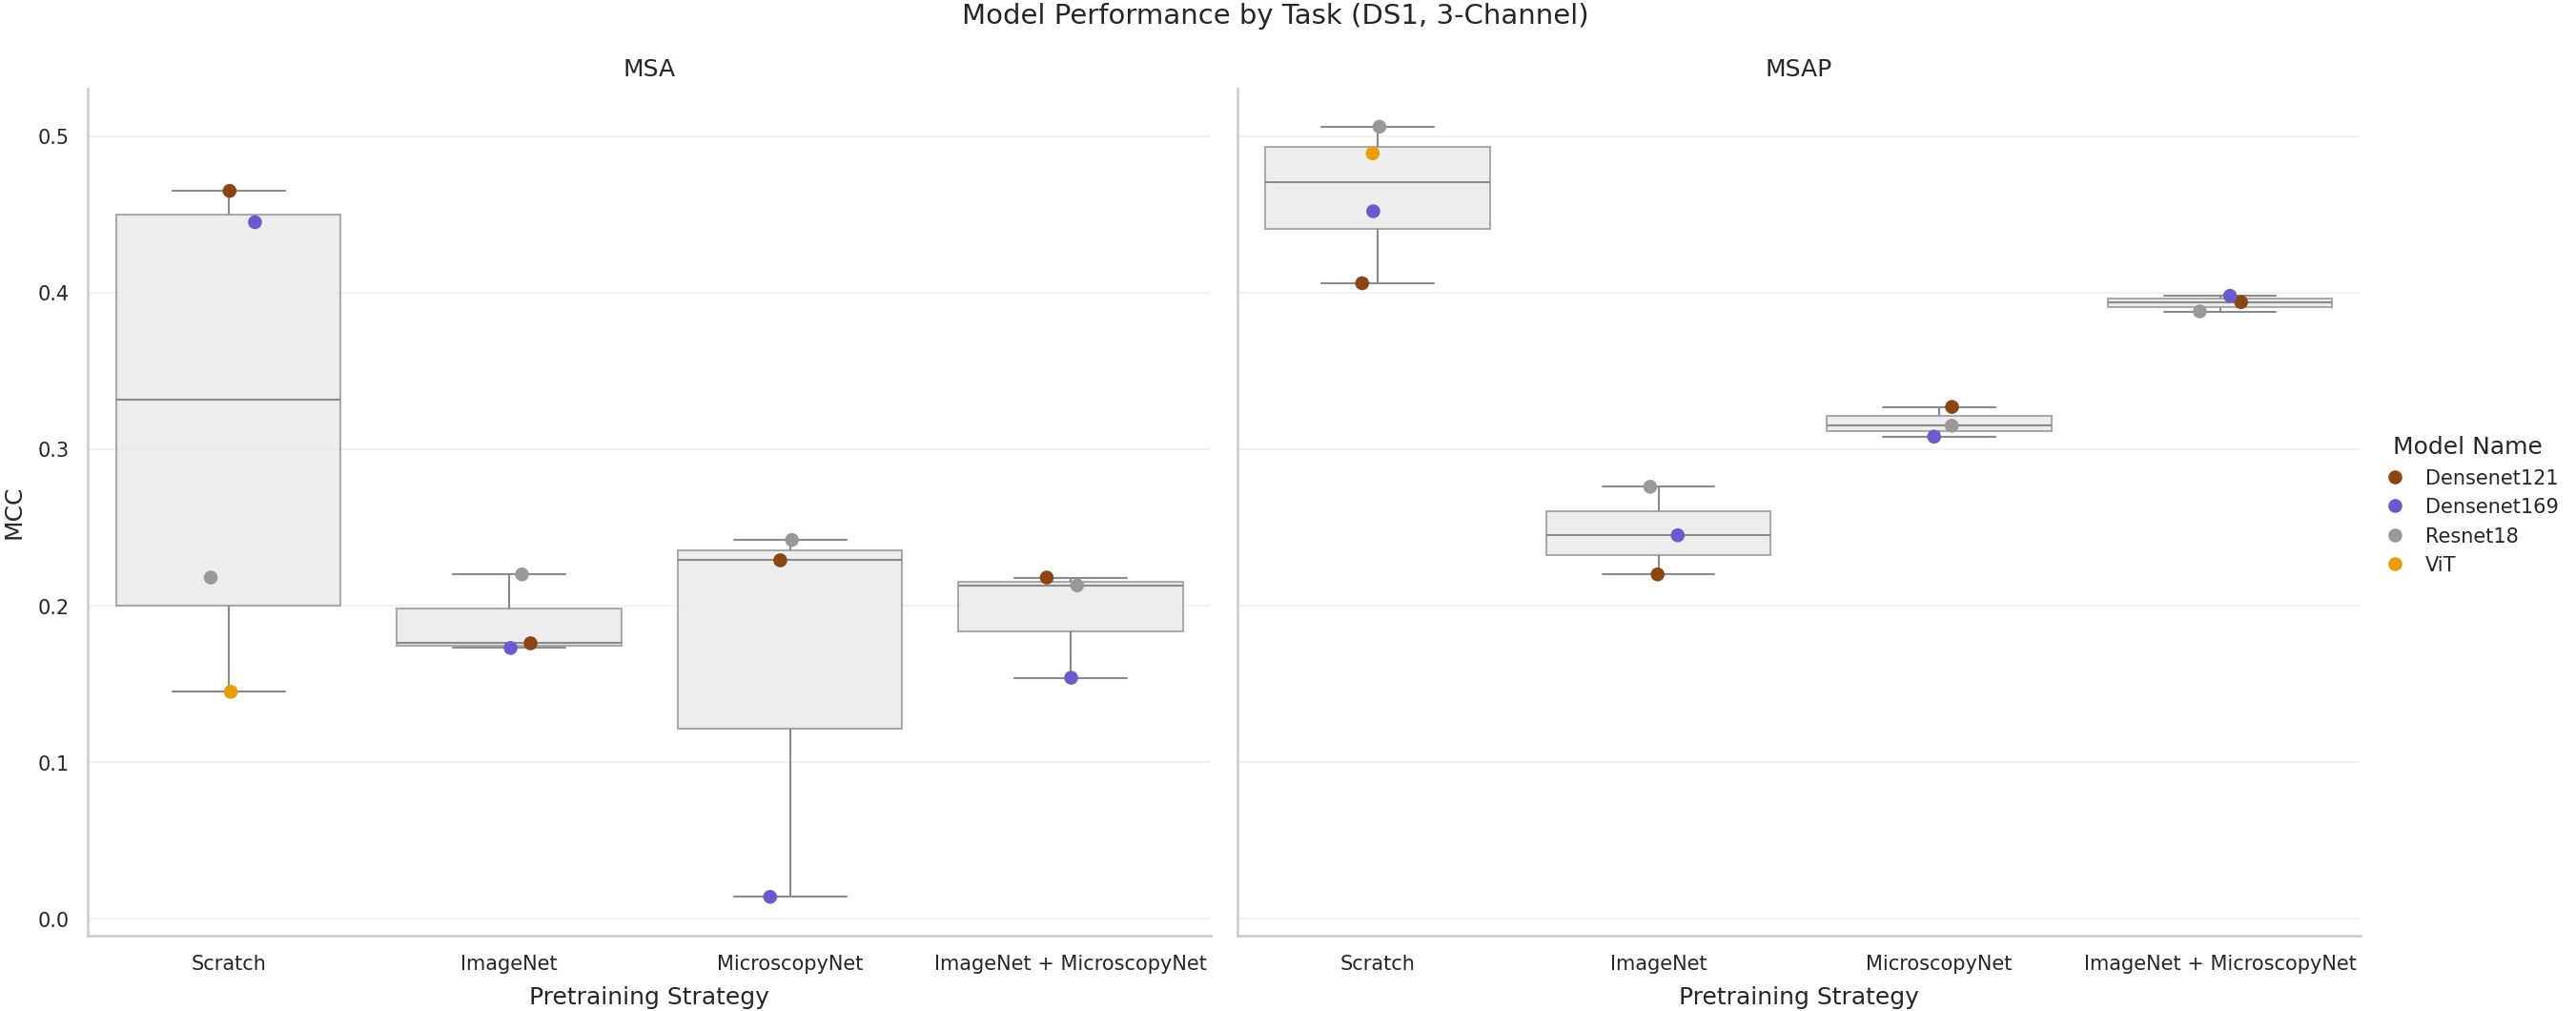

Plot saved to images/faceted_box_strip/08_faceted_box_strip_mcc_DS1.png


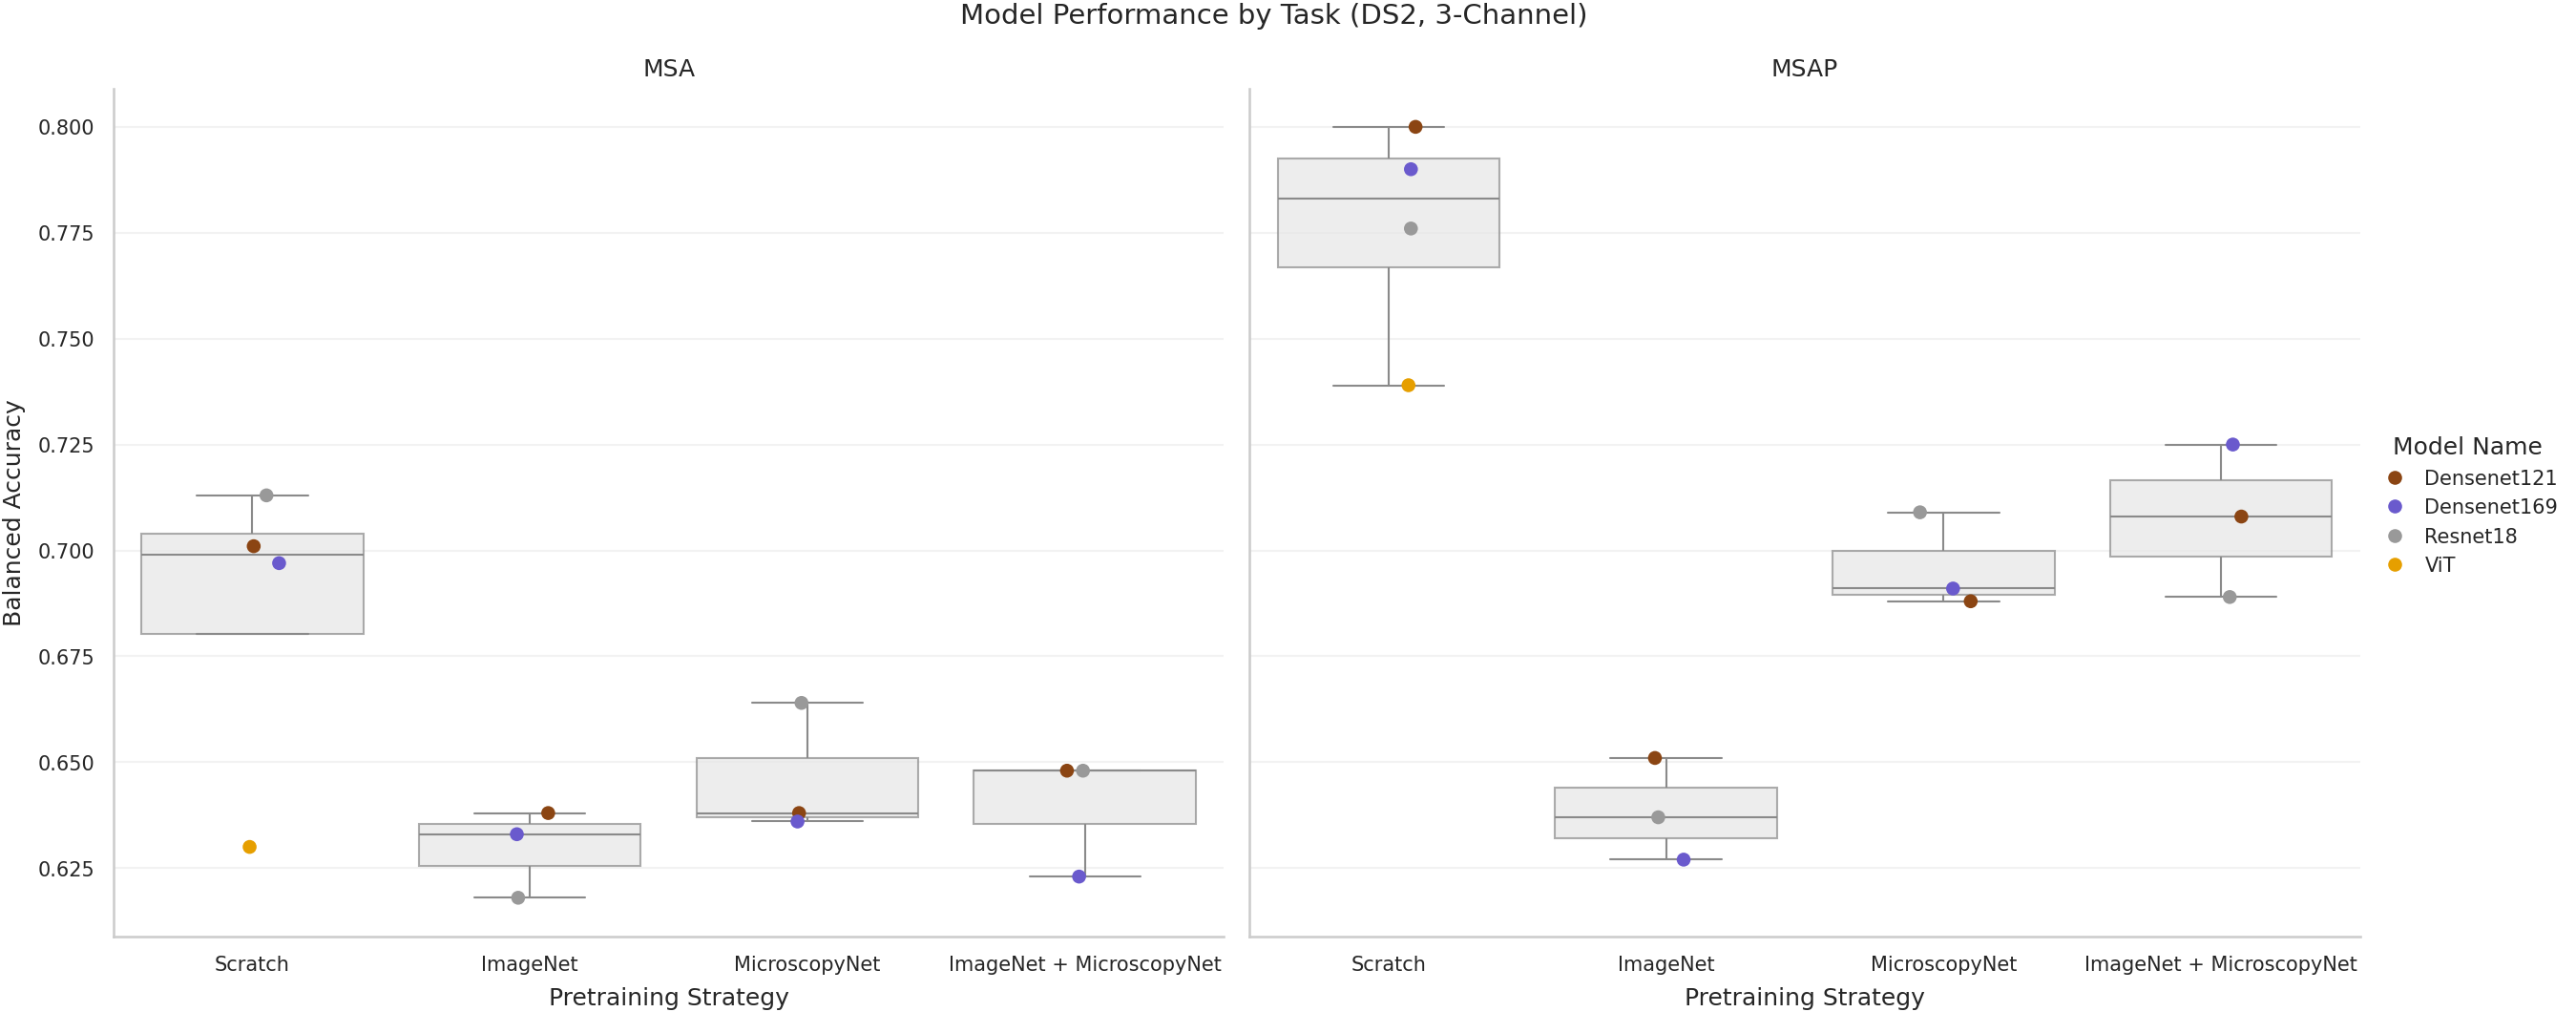

Plot saved to images/faceted_box_strip/08_faceted_box_strip_bal_acc_DS2.png


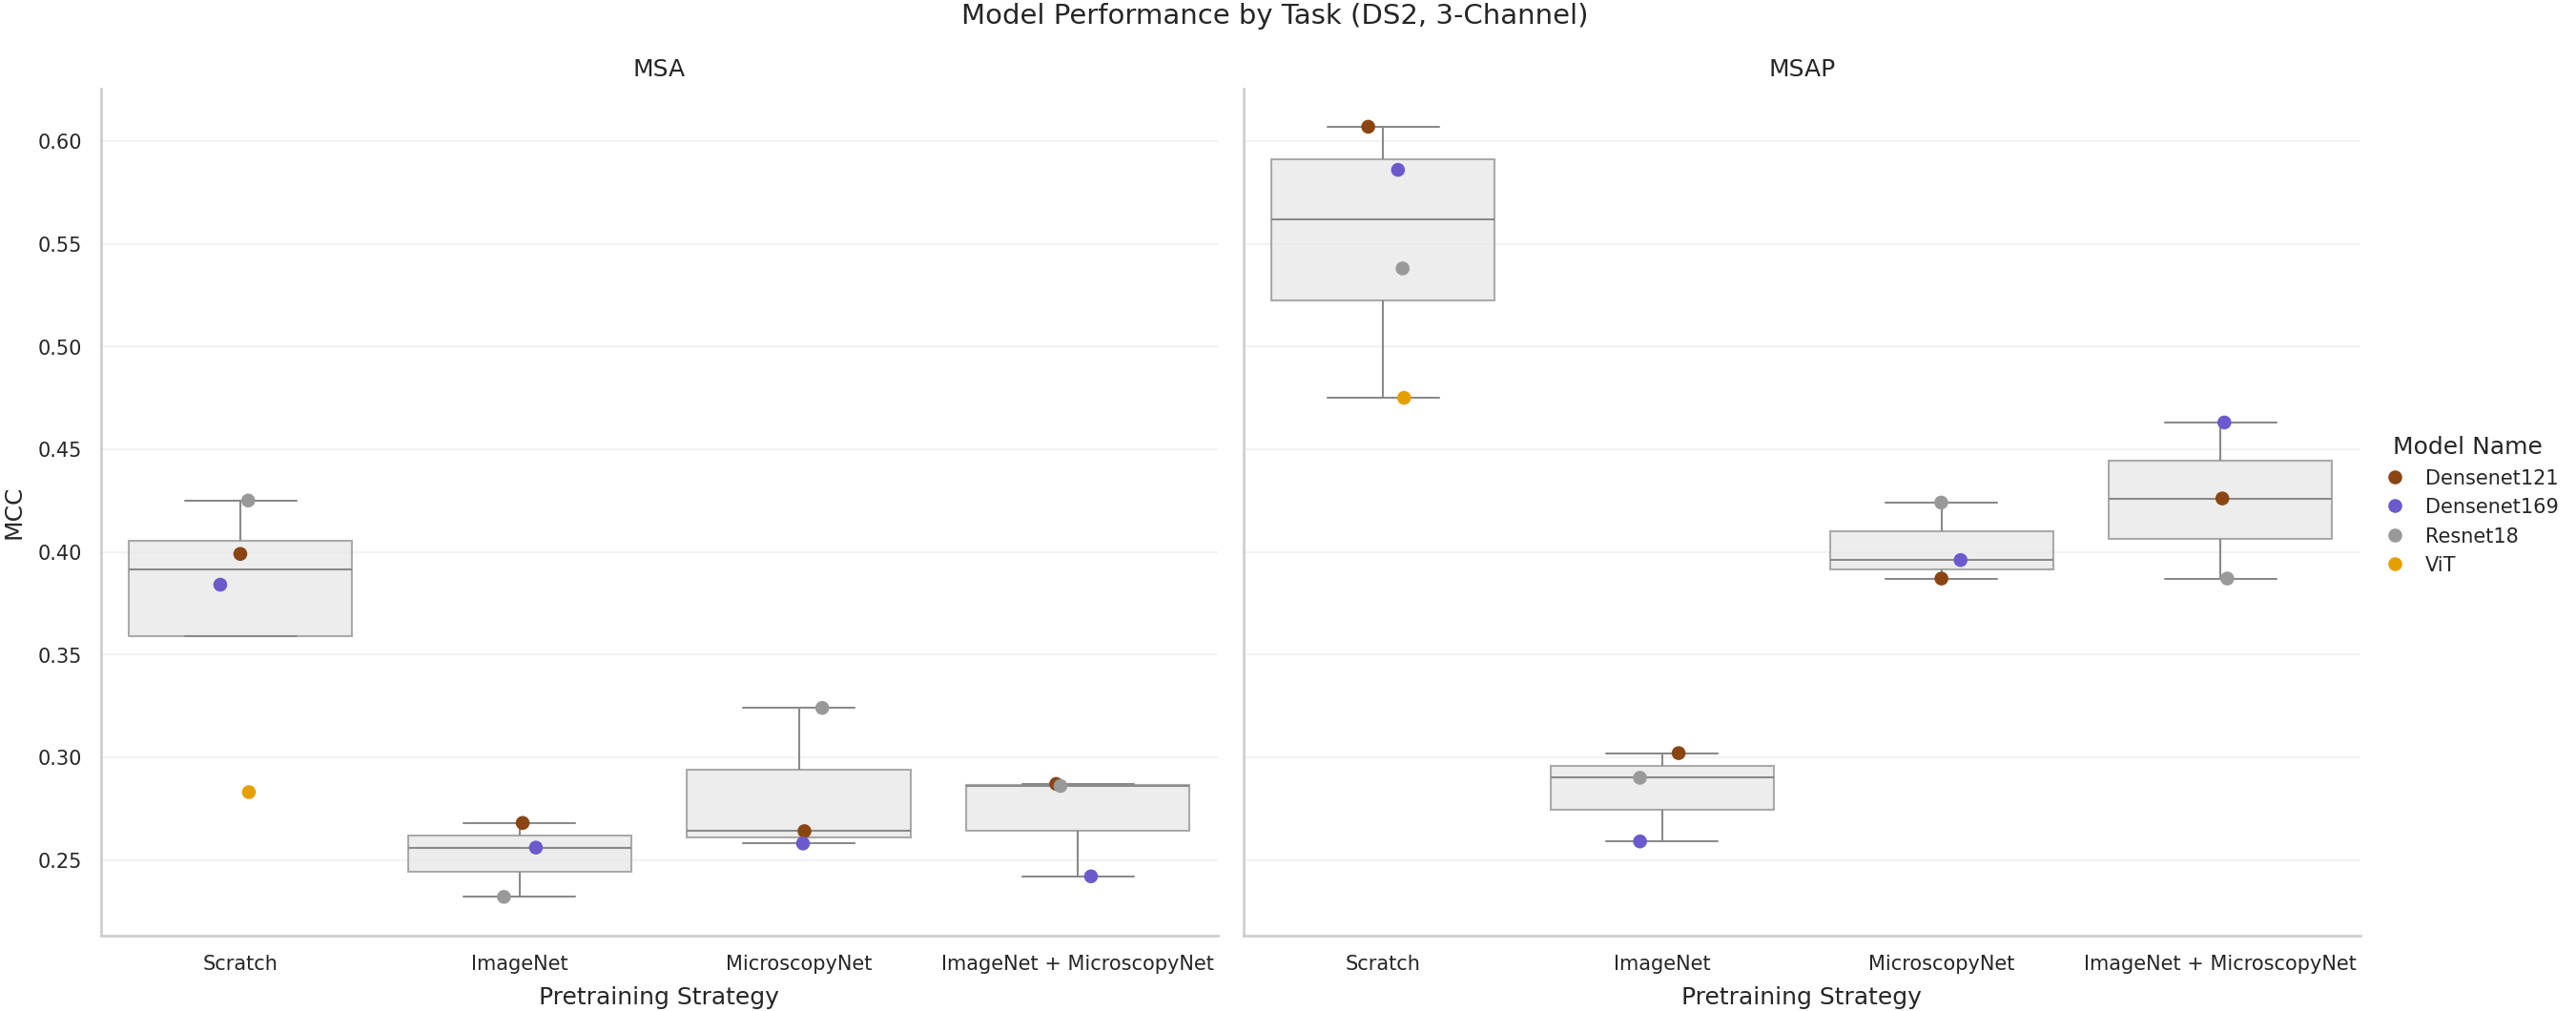

Plot saved to images/faceted_box_strip/08_faceted_box_strip_mcc_DS2.png
All faceted plots generated successfully.


In [118]:
# Create the target save directory
os.makedirs('images/faceted_box_strip', exist_ok=True)

# --- Plot 1: Dataset DS1 ---
df_ds1 = master_plot_df[master_plot_df['Dataset'] == 'DS1']

if not df_ds1.empty:
    plot_faceted_box_strip(
        df=df_ds1,
        metric_col='mean_test_balanced_acc',
        y_label='Balanced Accuracy',
        title_prefix='Model Performance by Task (DS1, 3-Channel)',
        save_path='images/faceted_box_strip/08_faceted_box_strip_bal_acc_DS1.png'
    )
    
    plot_faceted_box_strip(
        df=df_ds1,
        metric_col='mean_test_mcc',
        y_label='MCC',
        title_prefix='Model Performance by Task (DS1, 3-Channel)',
        save_path='images/faceted_box_strip/08_faceted_box_strip_mcc_DS1.png'
    )
else:
    print("No data found for DS1, skipping DS1 plots.")

# --- Plot 2: Dataset DS2 ---
df_ds2 = master_plot_df[master_plot_df['Dataset'] == 'DS2']

if not df_ds2.empty:
    plot_faceted_box_strip(
        df=df_ds2,
        metric_col='mean_test_balanced_acc',
        y_label='Balanced Accuracy',
        title_prefix='Model Performance by Task (DS2, 3-Channel)',
        save_path='images/faceted_box_strip/08_faceted_box_strip_bal_acc_DS2.png'
    )
    
    plot_faceted_box_strip(
        df=df_ds2,
        metric_col='mean_test_mcc',
        y_label='MCC',
        title_prefix='Model Performance by Task (DS2, 3-Channel)',
        save_path='images/faceted_box_strip/08_faceted_box_strip_mcc_DS2.png'
    )
else:
    print("No data found for DS2, skipping DS2 plots.")

print("All faceted plots generated successfully.")

# TABLES IMAGES CREATIONS

In [ ]:
def create_table_image(
    df_table,
    title,
    filename,
    auto_width=True,
    max_col_width=0.25,
    min_col_width=0.08,
    wrap_text=True,
    max_chars_per_line=30
):
    """
    Create a publication-ready table as an image with automatic overflow
    handling.
    
    Parameters
    ----------
    df_table : pd.DataFrame
        The dataframe to visualize
    title : str
        Title for the table
    filename : str
        Output filename
    auto_width : bool, default=True
        Automatically adjust column widths based on content
    max_col_width : float, default=0.25
        Maximum column width (relative to figure width)
    min_col_width : float, default=0.08
        Minimum column width (relative to figure width)
    wrap_text : bool, default=True
        Enable text wrapping for long content
    max_chars_per_line : int, default=30
        Maximum characters per line before wrapping
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure
    
    Notes
    -----
    The table is saved in the images/tables folder as filename.png.
    """
    import textwrap
    
    # Define the save path
    save_path = './images/tables/'
    # if not os.path.exists(save_path):
    #     os.makedirs(save_path)

    filename = os.path.join(save_path, filename)

    # Calculate optimal column widths
    def get_text_length(text):
        """Get effective length of text content."""
        return len(str(text))
    
    if auto_width:
        col_widths = []
        for col in df_table.columns:
            # Get max length in column (header + all values)
            header_len = get_text_length(col)
            max_val_len = df_table[col].astype(str).apply(
                get_text_length
            ).max()
            max_len = max(header_len, max_val_len)
            
            # Convert to relative width (heuristic: 1 char ≈ 0.012 width)
            width = min(max(max_len * 0.012, min_col_width), max_col_width)
            col_widths.append(width)
    else:
        # Equal widths
        col_widths = [0.15] * len(df_table.columns)
    
    # Calculate figure size dynamically
    total_width = sum(col_widths) * 100  # Convert to inches (approx)
    fig_width = max(12, min(total_width, 20))  # Between 12 and 20 inches
    fig_height = max(
        len(df_table) * 0.5 + 3,  # Changed from +2 to +3 for extra space for title
        6
    )  # Min 6 inches height
    
    # Temporarily override matplotlib style figure.figsize to use our calculated size
    # This prevents the .mplstyle file from forcing all figures to 6x4 inches
    original_figsize = plt.rcParams.get('figure.figsize', [6, 4])
    plt.rcParams['figure.figsize'] = (fig_width, fig_height)
    
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare table data with intelligent text wrapping
    def wrap_cell_text(text, col_width, is_header=False):
        """
        Wrap text to fit in cell based on actual column width.
        
        Parameters
        ----------
        text : str
            Text to wrap
        col_width : float
            Column width (relative to figure)
        is_header : bool
            Whether this is a header cell
        """
        if not wrap_text:
            return str(text)
        
        text_str = str(text)
        
        # Estimate characters that fit based on column width
        # Heuristic: col_width of 0.012 ≈ 1 character
        # So reverse: chars_that_fit ≈ col_width / 0.012
        chars_per_line = int(col_width / 0.011)  # Slightly conservative
        
        # For headers, be more conservative to avoid unnecessary wrapping
        if is_header:
            chars_per_line = int(chars_per_line * 0.9)
        
        # Only wrap if text is actually longer than what fits
        if len(text_str) <= chars_per_line:
            return text_str
        
        # Wrap with intelligent line breaks
        return '\n'.join(textwrap.wrap(
            text_str,
            width=max(chars_per_line, 15),  # Min 15 chars per line
            break_long_words=False,
            break_on_hyphens=False
        ))
    
    table_data = []
    # Wrap headers based on their column widths
    table_data.append([
        wrap_cell_text(col, col_widths[i], is_header=True)
        for i, col in enumerate(df_table.columns)
    ])
    # Wrap data rows based on their column widths
    for idx, row in df_table.iterrows():
        wrapped_row = [
            wrap_cell_text(val, col_widths[i], is_header=False)
            for i, val in enumerate(row)
        ]
        table_data.append(wrapped_row)
    
    # Create the table
    table = ax.table(
        cellText=table_data,
        cellLoc='center',  # Center all cell content horizontally
        loc='center',
        colWidths=col_widths
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 3.0)  # Increased from 2.2 to 3.0 for more vertical spacing
    
    # Header row styling
    for i in range(len(df_table.columns)):
        cell = table[(0, i)]
        cell.set_facecolor('#4472C4')  # Professional blue
        cell.set_text_props(
            weight='bold',
            color='white',
            fontsize=11,
            ha='center',
            va='center'
        )
        cell.set_edgecolor('white')
        cell.set_linewidth(2)
        # Add padding to header
        cell.PAD = 0.08  # Horizontal padding
    
    # Data rows styling - alternating colors
    for i in range(1, len(table_data)):
        for j in range(len(df_table.columns)):
            cell = table[(i, j)]
            if i % 2 == 0:
                cell.set_facecolor('#E7E6E6')  # Light gray
            else:
                cell.set_facecolor('white')
            cell.set_edgecolor('#CCCCCC')
            cell.set_linewidth(0.5)
            cell.set_text_props(fontsize=10, ha='center', va='center')
            # Add padding to all cells
            cell.PAD = 0.08  # Horizontal padding (default is 0.0)
    
    # Place title with a fixed relative gap above the table
    # This anchors the title to the table's top, avoiding overlap on tall tables
    # and excessive spacing on short tables.
    try:
        # Ensure artists are laid out before measuring extents
        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()

        # Get table bbox in figure coordinates
        table_bbox_disp = table.get_window_extent(renderer=renderer)
        table_bbox_fig = table_bbox_disp.transformed(fig.transFigure.inverted())

        # Compute title Y just above the table with a consistent figure-relative gap
        title_gap = 0.02  # 2% of figure height
        title_y = table_bbox_fig.y1 + title_gap

        fig.text(
            0.5,
            title_y,
            title,
            ha='center',
            va='bottom',
            fontsize=14,
            fontweight='bold',
            transform=fig.transFigure
        )
    except Exception:
        # Fallback: use a modest pad and default top margin
        plt.title(title, fontsize=14, fontweight='bold', pad=8)
        plt.subplots_adjust(top=0.9)

    # Save with high quality
    try:
        fig.savefig(
            filename,
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.5,  # Increased from 0.3 to 0.5 for more padding
            facecolor='white',
            edgecolor='none'
        )
    except Exception as e:
        print(f" Error saving table image: {e}")

    print(f" Table saved: {filename}")
    # plt.show()
    sm.savefig(filename)
    plt.close(fig)
    return filename

In [ ]:
df_notpt=dfs_to_export["DS1_MSAP_NotPT"]
df_notpt.columns.tolist()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'best_lr',
 'creation_date',
 'creation_time',
 'dropout_rate',
 'epochs',
 'freezed_layer_index',
 'intensity_augmentation_preset',
 'lr_discovery_folds',
 'mixup_alpha',
 'model_library',
 'model_name',
 'optimizer_name',
 'pretrained_weights',
 'test_counts',
 'test_pat_ids_for_best_fold',
 'test_pat_ids_per_fold',
 'total_params',
 'train_counts',
 'trainable_params',
 'transfer_learning',
 'val_counts',
 'weight_decay',
 'exec_time_min',
 'mean_patient_major_bal_acc',
 'mean_patient_major_mcc',
 'mean_patient_major_precision',
 'mean_patient_major_recall',
 'mean_patient_soft_bal_acc',
 'mean_patient_soft_mcc',
 'mean_patient_soft_precision',
 'mean_patient_soft_recall',
 'mean_test_accuracy',
 'mean_test_auc',
 'mean_test_balanced_acc',
 'mean_test_f1',
 'mean_test_mcc',
 'mean_test_precision',
 'mean_test_recall',
 'std_patient_major_bal_acc',
 'std_patient_major_mcc',
 'std_patient_major_precision',
 'st

In [ ]:
df_notpt.head()

experiment_name  \
97  DS1_4c_MSA-P_vs_PD_supervised   
99  DS1_4c_MSA-P_vs_PD_supervised   
98  DS1_4c_MSA-P_vs_PD_supervised   
96  DS1_4c_MSA-P_vs_PD_supervised   

                                        run_name dataset      classes  \
97     Resnet18_oversamp_monai_10-30_at:11-31-10     DS1  MSA-P vs PD   
99  Densenet121_oversamp_monai_10-30_at:10-11-35     DS1  MSA-P vs PD   
98  Densenet169_oversamp_monai_10-30_at:10-44-44     DS1  MSA-P vs PD   
96                   ViT_monai_10-30_at:12-06-53     DS1  MSA-P vs PD   

    num_channels                 best_lr creation_date creation_time  \
97             4    9.77832594580138e-06         10-30      11:31:10   
99             4  0.00012207764786954147         10-30      10:11:35   
98             4  0.00012207764786954147         10-30      10:44:44   
96             4  0.00012207764786954147         10-30      12:06:53   

   dropout_rate epochs freezed_layer_index intensity_augmentation_preset  \
97          0.2    210                None                         light   
99          0.2    210                None                         light   
98          0.2    210                None                         light   
96          0.2    450                None                         light   

   lr_discovery_folds mixup_alpha model_library   model_name optimizer_name  \
97                  4           0         monai     Resnet18          AdamW   
99                  4           0         monai  Densenet121          AdamW   
98                  4           0         monai  Densenet169          AdamW   
96                  4           0         monai          ViT          AdamW   

   pretrained_weights                                        test_counts  \
97               None                                                 14   
99               None                                                 14   
98               None                                                 14   
96               None  {'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...   

                           test_pat_ids_for_best_fold  \
97  ['5745' '5753' '5996' '6375' '6690' '7114' '71...   
99                                                NaN   
98  ['5717' '5767' '6337' '6366' '6657' '7132' '72...   
96                                                NaN   

                                test_pat_ids_per_fold total_params  \
97  {0: array(['5776', '6008', '6060', '6258', '63...     11181570   
99  {0: array(['5776', '6008', '6060', '6258', '63...      6959042   
98  {0: array(['5776', '6008', '6060', '6258', '63...     12490946   
96  {0: array(['5776', '6008', '6060', '6258', '63...      1054978   

                                         train_counts trainable_params  \
97  {0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...         11181570   
99  {0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...          6959042   
98  {0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...         12490946   
96  {0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...          1054978   

   transfer_learning                                         val_counts  \
97             False  {0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...   
99             False  {0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...   
98             False  {0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...   
96             False  {0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...   

   weight_decay  exec_time_min  mean_patient_major_bal_acc  \
97         1e-4         46.095                       0.792   
99         1e-4         28.708                       0.818   
98         1e-4         32.821                       0.792   
96         1e-5         35.312                       0.682   

    mean_patient_major_mcc  mean_patient_major_precision  \
97                   0.593                         0.781   
99                   0.650                         0.790   
98                   0.592                         0.777   
96          

In [ ]:
df_notpt.head()

experiment_name  \
97  DS1_4c_MSA-P_vs_PD_supervised   
99  DS1_4c_MSA-P_vs_PD_supervised   
98  DS1_4c_MSA-P_vs_PD_supervised   
96  DS1_4c_MSA-P_vs_PD_supervised   

                                        run_name dataset      classes  \
97     Resnet18_oversamp_monai_10-30_at:11-31-10     DS1  MSA-P vs PD   
99  Densenet121_oversamp_monai_10-30_at:10-11-35     DS1  MSA-P vs PD   
98  Densenet169_oversamp_monai_10-30_at:10-44-44     DS1  MSA-P vs PD   
96                   ViT_monai_10-30_at:12-06-53     DS1  MSA-P vs PD   

    num_channels                 best_lr creation_date creation_time  \
97             4    9.77832594580138e-06         10-30      11:31:10   
99             4  0.00012207764786954147         10-30      10:11:35   
98             4  0.00012207764786954147         10-30      10:44:44   
96             4  0.00012207764786954147         10-30      12:06:53   

   dropout_rate epochs freezed_layer_index intensity_augmentation_preset  \
97          0.2    210                None                         light   
99          0.2    210                None                         light   
98          0.2    210                None                         light   
96          0.2    450                None                         light   

   lr_discovery_folds mixup_alpha model_library   model_name optimizer_name  \
97                  4           0         monai     Resnet18          AdamW   
99                  4           0         monai  Densenet121          AdamW   
98                  4           0         monai  Densenet169          AdamW   
96                  4           0         monai          ViT          AdamW   

   pretrained_weights                                        test_counts  \
97               None                                                 14   
99               None                                                 14   
98               None                                                 14   
96               None  {'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...   

                           test_pat_ids_for_best_fold  \
97  ['5745' '5753' '5996' '6375' '6690' '7114' '71...   
99                                                NaN   
98  ['5717' '5767' '6337' '6366' '6657' '7132' '72...   
96                                                NaN   

                                test_pat_ids_per_fold total_params  \
97  {0: array(['5776', '6008', '6060', '6258', '63...     11181570   
99  {0: array(['5776', '6008', '6060', '6258', '63...      6959042   
98  {0: array(['5776', '6008', '6060', '6258', '63...     12490946   
96  {0: array(['5776', '6008', '6060', '6258', '63...      1054978   

                                         train_counts trainable_params  \
97  {0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...         11181570   
99  {0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...          6959042   
98  {0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...         12490946   
96  {0: 85, 1: 84, 2: 84, 3: 89, 4: 86, 5: 86, 6: ...          1054978   

   transfer_learning                                         val_counts  \
97             False  {0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...   
99             False  {0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...   
98             False  {0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...   
96             False  {0: 16, 1: 16, 2: 15, 3: 15, 4: 16, 5: 16, 6: ...   

   weight_decay  exec_time_min  mean_patient_major_bal_acc  \
97         1e-4         46.095                       0.792   
99         1e-4         28.708                       0.818   
98         1e-4         32.821                       0.792   
96         1e-5         35.312                       0.682   

    mean_patient_major_mcc  mean_patient_major_precision  \
97                   0.593                         0.781   
99                   0.650                         0.790   
98                   0.592                         0.777   
96          

In [ ]:
# from clinica.utils.tables import create_table_image
df_table = df_notpt[["model_name", "patient_major_bal_acc_formatted", "patient_major_mcc_formatted", "patient_major_precision_formatted",'patient_major_recall_formatted']].copy()
df_table.sort_values(by="patient_major_bal_acc_formatted", ascending=False, inplace=True)
create_table_image(
    df_table=df_table.head(10),
    title="DS1 - MSA-P vs PD - Not Pretrained",
    filename="01_ds1_msap_notpt_table.png"
)

 Table saved: ./images/tables/01_ds1_msap_notpt_table.png
Figure saved to ./images/tables/01_ds1_msap_notpt_table.png


'./images/tables/01_ds1_msap_notpt_table.png'

In [ ]:
def generate_title_from_key(key: str) -> str:
    """
    Generate a human-readable title from a dfs_to_export key.
    
    Examples:
        "DS1_MSA_PT" → "DS1 - MSA vs PD - Pretrained"
        "DS1_MSAP_NotPT" → "DS1 - MSA-P vs PD - Not Pretrained"
        "DS1_MSA_4c" → "DS1 - MSA vs PD - 4 Channels"
        "DS1_MSA_PT_imagenet" → "DS1 - MSA vs PD - Pretrained (ImageNet)"
    
    Parameters
    ----------
    key : str
        The key from dfs_to_export dictionary
    
    Returns
    -------
    str
        Formatted title string
    """
    parts = key.split('_')
    
    # Extract dataset (DS1 or DS2)
    dataset = parts[0] if parts[0].startswith('DS') else 'DS1'
    
    # Extract diagnosis comparison (MSA or MSAP)
    if 'MSAP' in key:
        diagnosis = "MSA-P vs PD"
    elif 'MSA' in key:
        diagnosis = "MSA vs PD"
    else:
        diagnosis = "Unknown"
    
    # Build title components
    title_parts = [f"{dataset} - {diagnosis}"]
    
    # Handle pretraining status and channel count
    if 'PT' in key and 'NotPT' not in key:
        # Check for pretraining source
        if '_imagenet_microscopynet' in key:
            title_parts.append("Pretrained (ImageNet + MicroscopyNet)")
        elif '_imagenet' in key:
            title_parts.append("Pretrained (ImageNet)")
        elif '_microscopy' in key:
            title_parts.append("Pretrained (Microscopy)")
        else:
            title_parts.append("Pretrained")
    elif 'NotPT' in key:
        title_parts.append("Not Pretrained")
    
    # Handle channel count (only if not pretrained with specific source)
    if '_4c' in key:
        title_parts.append("4 Channels")
    elif '_3c' in key:
        title_parts.append("3 Channels")
    
    return " - ".join(title_parts)

In [ ]:
for key, df in dfs_to_export.items():
    cols_to_show = ["model_name", "patient_major_bal_acc_formatted", 
                    "patient_major_mcc_formatted", "patient_major_precision_formatted",
                    'patient_major_recall_formatted']
    if key.endswith("PT"):
        cols_to_show.append("pretrained_weights")
    df_table = df[cols_to_show].copy()
    df_table = df_table.sort_values(by="patient_major_bal_acc_formatted", ascending=False)
    
    title = generate_title_from_key(key)
    
    create_table_image(
        df_table=df_table.head(10),
        title=title,
        filename=f"01_{key}_table.png"
    )

# # from clinica.utils.tables import create_table_image
# df_table = df_notpt[["model_name", "patient_major_bal_acc_formatted", "patient_major_mcc_formatted", "patient_major_precision_formatted",'patient_major_recall_formatted']].copy()
# df_table.sort_values(by="patient_major_bal_acc_formatted", ascending=False, inplace=True)
# create_table_image(
#     df_table=df_table.head(10),
#     title="DS1 - MSA-P vs PD - Not Pretrained",
#     filename="01_ds1_msap_notpt_table.png"
# )

 Table saved: ./images/tables/01_DS1_MSA_PT_table.png
Figure saved to ./images/tables/01_DS1_MSA_PT_table.png
 Table saved: ./images/tables/01_DS1_MSA_NotPT_table.png
Figure saved to ./images/tables/01_DS1_MSA_NotPT_table.png
 Table saved: ./images/tables/01_DS1_MSAP_PT_table.png
Figure saved to ./images/tables/01_DS1_MSAP_PT_table.png
 Table saved: ./images/tables/01_DS1_MSAP_NotPT_table.png
Figure saved to ./images/tables/01_DS1_MSAP_NotPT_table.png
 Table saved: ./images/tables/01_DS2_MSA_PT_table.png
Figure saved to ./images/tables/01_DS2_MSA_PT_table.png
 Table saved: ./images/tables/01_DS2_MSA_NotPT_table.png
Figure saved to ./images/tables/01_DS2_MSA_NotPT_table.png
 Table saved: ./images/tables/01_DS2_MSAP_PT_table.png
Figure saved to ./images/tables/01_DS2_MSAP_PT_table.png
 Table saved: ./images/tables/01_DS2_MSAP_NotPT_table.png
Figure saved to ./images/tables/01_DS2_MSAP_NotPT_table.png
 Table saved: ./images/tables/01_DS1_MSA_NotPT_3c_table.png
Figure saved to ./images/tab

In [ ]:
# Helper functions for architecture-based row coloring
def _get_architecture_color(model_name: str) -> str:
    """
    Map model name to LaTeX color based on architecture.
    
    Returns a LaTeX color definition compatible with xcolor package.
    Colors follow the thesis plotting style architecture_colors.
    """
    if not model_name:
        return None
    
    model_lower = str(model_name).lower()
    
    # Architecture color mapping from plotting rules
    if 'vit' in model_lower:
        return 'orange!20'  # #E69F00 -> orange!20 (light amber)
    elif 'resnet18' in model_lower:
        return 'gray!15'    # #999999 -> gray!15 (light gray)
    elif 'densenet121' in model_lower:
        return 'brown!20'   # #8B4513 -> brown!20 (light saddle brown)
    elif 'densenet169' in model_lower:
        return 'blue!15'    # #6A5ACD -> blue!15 (light slate blue)
    else:
        return None  # No color for unknown architectures


def _add_row_colors(table_tex: str, model_names: List[str]) -> str:
    """
    Add \\rowcolor commands to LaTeX table based on model names.
    
    Args:
        table_tex: LaTeX table string from pandas to_latex()
        model_names: List of model names in the same order as table rows
        
    Returns:
        Modified LaTeX string with row colors
    """
    lines = table_tex.split('\n')
    result = []
    row_idx = 0  # Track which data row we're on
    
    i = 0
    while i < len(lines):
        line = lines[i]
        
        # Check if this is a data row (starts with content, ends with \\)
        # Data rows come after header rows and don't start with \hline or \end
        is_data_row = (line.strip() and 
                       not line.strip().startswith('\\') and 
                       '&' in line and 
                       line.strip().endswith('\\\\'))
        
        if is_data_row:
            # Get the color for this row
            if row_idx < len(model_names):
                color = _get_architecture_color(model_names[row_idx])
                if color:
                    result.append(f'\\rowcolor{{{color}}}')
                row_idx += 1
        
        result.append(line)
        i += 1
    
    return '\n'.join(result)

### LaTeX Tables Export

Exports each DataFrame in `dfs_to_export` to LaTeX (`.tex`) and compiles to PDF when `pdflatex` is available. Outputs are saved under `latex_tables/` at the project root.


In [ ]:
import os
import re
import shutil
import subprocess
from pathlib import Path
import pandas as pd

# =============================================================================
#  CONFIGURATION
# =============================================================================
# Columns to keep for export
COLUMNS_TO_KEEP = [
    "model_name",
    "patient_major_bal_acc_formatted",
    "patient_major_mcc_formatted",
    "patient_major_precision_formatted",
    "patient_major_recall_formatted",
    "patient_soft_bal_acc_formatted",
    "patient_soft_mcc_formatted",
    "patient_soft_precision_formatted",
    "patient_soft_recall_formatted",
]

# =============================================================================
#  PATHS
# =============================================================================
cwd = os.getcwd()
project_root = os.path.dirname(cwd) if os.path.basename(cwd) == "notebooks" else cwd
latex_dir = os.path.join(project_root, "latex_tables")
os.makedirs(latex_dir, exist_ok=True)

print(f"Exporting LaTeX tables to: {latex_dir}")

# =============================================================================
#  HELPERS
# =============================================================================
def _sanitize(s: str) -> str:
    """Return a filesystem-safe string."""
    return re.sub(r"[^A-Za-z0-9_-]+", "_", str(s)).strip("_")


def write_tex_and_pdf(key: str, df: pd.DataFrame):
    """
    Export a subset of columns to .tex and optionally compile to PDF.
    - Renames columns by removing 'patient_' and '_formatted'
    - Uses resizebox to keep the table within page width
    """
    base = _sanitize(key)
    tex_path = os.path.join(latex_dir, f"{base}.tex")
    pdf_path = os.path.join(latex_dir, f"{base}.pdf")

    # Columns to keep (fixed order)
    columns_to_keep = [
        "model_name",
        "patient_major_bal_acc_formatted",
        "patient_major_mcc_formatted",
        "patient_major_precision_formatted",
        "patient_major_recall_formatted",
        "patient_soft_bal_acc_formatted",
        "patient_soft_mcc_formatted",
        "patient_soft_precision_formatted",
        "patient_soft_recall_formatted",
    ]
    cols_present = [c for c in columns_to_keep if c in df.columns]
    if not cols_present:
        print(f"⚠ No matching columns found in {key}; skipping.")
        return

    df = df.loc[:, cols_present].copy()
    if "model_name" in df.columns:
        df = df.sort_values(by="model_name")

    # ---- Rename headers: drop 'patient_' and '_formatted'
    renamed = []
    for c in df.columns:
        if c == "model_name":
            renamed.append("Model")
        else:
            new_c = c.replace("patient_", "").replace("_formatted", "")
            # Optional: allow wrapping by replacing '_' with spaces for display
            new_c = new_c.replace("_", " ")
            renamed.append(new_c)
    df.columns = renamed

    # ---- Build LaTeX table
    try:
        # Use regular tabular (no longtable) to allow resizebox easily
        table_tex = df.to_latex(
            index=False,
            longtable=False,
            escape=True,
            na_rep="-",
            float_format=lambda x: f"{x:.4f}"
            if isinstance(x, (float, int))
            else str(x),
            bold_rows=False,
            # l then centered columns
            column_format="l" + "c" * (df.shape[1] - 1),
        )
        # Use \hline instead of booktabs rules
        table_tex = (
            table_tex.replace("\\toprule", "\\hline")
            .replace("\\midrule", "\\hline")
            .replace("\\bottomrule", "\\hline")
        )
        # Wrap table to fit page width
        table_tex = "\\resizebox{\\textwidth}{!}{%\n" + table_tex + "\n}"
    except Exception as e:
        print(f"! Failed to render LaTeX for {key}: {e}")
        return

    title_tex = str(key).replace("_", r"\_")
    doc = f"""\\documentclass{{article}}
\\usepackage[margin=1in]{{geometry}}
\\usepackage[T1]{{fontenc}}
\\usepackage[utf8]{{inputenc}}
\\usepackage{{lmodern}}
\\usepackage{{graphicx}} % for \\resizebox
\\setlength\\tabcolsep{{8pt}}    
\\renewcommand{{\\arraystretch}}{{1.3}} % slightly taller rows
\\begin{{document}}
\\small
\\begin{{center}}\\textbf{{{title_tex}}}\\end{{center}}
{table_tex}
\\end{{document}}
"""

    with open(tex_path, "w", encoding="utf-8") as f:
        f.write(doc)
    print(f"✓ Wrote {tex_path}")

    if shutil.which("pdflatex"):
        try:
            subprocess.run(
                [
                    "pdflatex",
                    "-interaction=nonstopmode",
                    "-halt-on-error",
                    "-output-directory",
                    latex_dir,
                    tex_path,
                ],
                check=True,
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                text=True,
            )
            print(f"✓ Generated {pdf_path}")
        except subprocess.CalledProcessError as e:
            print(f"⚠ pdflatex failed for {tex_path}. Leaving .tex only.")
            tail = (e.stdout or "")[-800:] + "\n" + (e.stderr or "")[-800:]
            print(tail)
    else:
        print("pdflatex not found — skipped PDF compilation.")


# =============================================================================
#  MAIN EXECUTION
# =============================================================================
try:
    items = list(dfs_to_export.items())
except NameError:
    raise RuntimeError(
        "dfs_to_export not found in this notebook. Ensure the earlier cell has run."
    )

for key, frame in items:
    if isinstance(frame, pd.DataFrame) and not frame.empty:
        write_tex_and_pdf(key, frame)
    else:
        print(f"Skipping {key}: not a DataFrame or empty.")


Exporting LaTeX tables to: /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_PT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_PT.pdf
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_NotPT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_NotPT.pdf
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSAP_PT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSAP_PT.pdf
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSAP_NotPT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSAP_NotPT.pdf
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS2_MSA_PT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS2_MSA_PT.pdf
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS2_MSA_NotPT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_

In [ ]:
import os
import re
import shutil
import subprocess
from typing import List

import pandas as pd


# ============================== CONFIG =======================================
COLUMNS_TO_KEEP: List[str] = [
    "model_name",
    "patient_major_bal_acc_formatted",
    "patient_major_mcc_formatted",
    "patient_major_precision_formatted",
    "patient_major_recall_formatted",
    "patient_soft_bal_acc_formatted",
    "patient_soft_mcc_formatted",
    "patient_soft_precision_formatted",
    "patient_soft_recall_formatted",
]

EXPORT_PNG: bool = True
PNG_DPI: int = 400  # crisp on projectors


# =============================== PATHS =======================================
cwd = os.getcwd()
project_root = os.path.dirname(cwd) if os.path.basename(cwd) == "notebooks" else cwd
latex_dir = os.path.join(project_root, "latex_tables")
os.makedirs(latex_dir, exist_ok=True)

print(f"Exporting LaTeX tables to: {latex_dir}")


# ============================== HELPERS ======================================
def _sanitize(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", str(s)).strip("_")


def _pretty_header(col: str) -> str:
    if col == "model_name":
        return "Model"
    return col.replace("patient_", "").replace("_formatted", "").replace("_", " ")


def _get_architecture_color(model_name: str) -> str:
    """
    Map model name to LaTeX color based on architecture.
    
    Returns a LaTeX color definition compatible with xcolor package.
    Colors follow the thesis plotting style architecture_colors from plotting.mdc:
    - vit: #E69F00 (Amber)
    - resnet18: #999999 (Gray)
    - densenet121: #8B4513 (Saddle brown)
    - densenet169: #6A5ACD (Slate blue)
    
    Uses light tints for row backgrounds to maintain readability.
    """
    if not model_name:
        return None
    
    model_lower = str(model_name).lower()
    
    # Architecture color mapping from plotting rules (exact hex colors from plotting.mdc)
    # Uses predefined colors from _build_document with light tints for table rows
    if 'vit' in model_lower:
        return 'archvit!20'  # #E69F00 -> light amber tint (20% opacity)
    elif 'resnet18' in model_lower:
        return 'archresnet18!15'  # #999999 -> light gray tint (15% opacity)
    elif 'densenet121' in model_lower:
        return 'archdensenet121!20'  # #8B4513 -> light saddle brown tint (20% opacity)
    elif 'densenet169' in model_lower:
        return 'archdensenet169!15'  # #6A5ACD -> light slate blue tint (15% opacity)
    else:
        return None  # No color for unknown architectures


def _add_row_colors(table_tex: str, model_names: List[str]) -> str:
    """
    Add \\rowcolor commands to LaTeX table based on model names.
    
    Args:
        table_tex: LaTeX table string from pandas to_latex()
        model_names: List of model names in the same order as table rows
        
    Returns:
        Modified LaTeX string with row colors
    """
    lines = table_tex.split('\n')
    result = []
    row_idx = 0  # Track which data row we're on
    found_header = False  # Track if we've passed the header row
    saw_hline_after_header = False  # Track if we've seen \hline after header
    
    i = 0
    while i < len(lines):
        line = lines[i]
        stripped = line.strip()
        
        # Skip empty lines
        if not stripped:
            result.append(line)
            i += 1
            continue
        
        # Detect header: it's the first row with & that comes before data rows
        # Header is typically: "Column1 & Column2 & ... \\"
        if not found_header:
            if stripped == '\\hline':
                # Mark that we might see header next
                result.append(line)
                i += 1
                continue
            elif '&' in line and not stripped.startswith('\\') and stripped.endswith('\\\\'):
                # This is the header row - mark it
                found_header = True
                result.append(line)
                i += 1
                continue
        
        # After header, look for \hline (separator before data)
        if found_header and not saw_hline_after_header:
            if stripped == '\\hline':
                saw_hline_after_header = True
                result.append(line)
                i += 1
                continue
        
        # Check if this is a data row
        # Data rows must:
        # 1. Come after header and separator
        # 2. Have content (not empty)
        # 3. Not start with LaTeX command or brace
        # 4. Contain & (table cell separator)
        # 5. End with \\ (row terminator)
        is_data_row = (
            found_header and
            saw_hline_after_header and
            stripped and
            not stripped.startswith('\\') and  # Not a LaTeX command like \hline, \end
            not stripped.startswith('{') and   # Not a group
            '&' in line and                    # Has table cells
            stripped.endswith('\\\\')          # Properly terminated
        )
        
        if is_data_row:
            # Get the color for this row based on model name
            if row_idx < len(model_names):
                color = _get_architecture_color(model_names[row_idx])
                if color:
                    result.append(f'\\rowcolor{{{color}}}')
                row_idx += 1
            else:
                # This shouldn't happen if lists are aligned
                pass
        
        result.append(line)
        i += 1
    
    # Verify we colored the right number of rows
    if row_idx != len(model_names):
        print(f"⚠ Warning: Colored {row_idx} rows but expected {len(model_names)} model names")
    
    return '\n'.join(result)


def _normalize_rules(table_tex: str) -> str:
    """Make table rules compatible across pandas versions."""
    # Convert booktabs commands (if any) to \hline
    table_tex = (
        table_tex.replace("\\toprule", "\\hline")
        .replace("\\midrule", "\\hline")
        .replace("\\bottomrule", "\\hline")
    )
    return table_tex


def _tint_header_if_possible(table_tex: str) -> str:
    """Add a tinted header row only if a \\hline exists to anchor on."""
    if "\\hline" in table_tex:
        return table_tex.replace("\\hline\n", "\\hline\n\\rowcolor{gray!15}\n", 1)
    return table_tex  # keep as-is if no rules present


def _build_document(title_tex: str, table_tex: str) -> str:
    wrapped = "\\resizebox{\\textwidth}{!}{%\n" + table_tex + "\n}"
    return f"""\\documentclass{{article}}
\\usepackage[margin=1in]{{geometry}}
\\usepackage[T1]{{fontenc}}
\\usepackage[utf8]{{inputenc}}
\\usepackage{{lmodern}}
\\usepackage{{graphicx}}
\\usepackage[table]{{xcolor}}
% Define architecture colors from plotting.mdc (exact hex values)
\\definecolor{{archvit}}{{RGB}}{{230,159,0}}      % #E69F00 Amber
\\definecolor{{archresnet18}}{{RGB}}{{153,153,153}} % #999999 Gray
\\definecolor{{archdensenet121}}{{RGB}}{{139,69,19}}  % #8B4513 Saddle brown
\\definecolor{{archdensenet169}}{{RGB}}{{106,90,205}} % #6A5ACD Slate blue
\\rowcolors{{2}}{{gray!6}}{{white}}
\\setlength\\tabcolsep{{9pt}}
\\setlength{{\\extrarowheight}}{{2pt}}     % <---- add this
\\renewcommand{{\\arraystretch}}{{1.45}}   % <---- increase this
\\begin{{document}}
\\footnotesize
\\begin{{center}}\\textbf{{{title_tex}}}\\end{{center}}
{wrapped}
\\end{{document}}
"""


def _which_converters() -> dict:
    return {
        "magick": shutil.which("magick"),
        "convert": shutil.which("convert"),
        "pdftoppm": shutil.which("pdftoppm"),
        "gs": shutil.which("gs"),
    }


def _pdf_to_png(pdf_name: str, png_name: str, workdir: str, dpi: int) -> bool:
    conv = _which_converters()
    print("PNG exporter backends:",
          {k: (v if v else "not found") for k, v in conv.items()})

    # 1) ImageMagick 7
    if conv["magick"]:
        try:
            subprocess.run(
                [conv["magick"], "-density", str(dpi), pdf_name, "-quality", "100",
                 png_name],
                cwd=workdir, check=True,
            )
            return True
        except subprocess.CalledProcessError:
            pass

    # 2) ImageMagick 6
    if conv["convert"]:
        try:
            subprocess.run(
                [conv["convert"], "-density", str(dpi), pdf_name, "-quality", "100",
                 png_name],
                cwd=workdir, check=True,
            )
            return True
        except subprocess.CalledProcessError:
            pass

    # 3) Poppler
    if conv["pdftoppm"]:
        try:
            base = os.path.splitext(png_name)[0]
            subprocess.run(
                [conv["pdftoppm"], "-png", "-r", str(dpi), pdf_name, base],
                cwd=workdir, check=True,
            )
            src = os.path.join(workdir, f"{base}-1.png")
            dst = os.path.join(workdir, png_name)
            if os.path.exists(src):
                os.replace(src, dst)
            return True
        except subprocess.CalledProcessError:
            pass

    # 4) Ghostscript
    if conv["gs"]:
        try:
            subprocess.run(
                [
                    conv["gs"], "-dSAFER", "-dBATCH", "-dNOPAUSE",
                    "-sDEVICE=png16m", f"-r{dpi}",
                    f"-sOutputFile={png_name}", pdf_name,
                ],
                cwd=workdir, check=True,
            )
            return True
        except subprocess.CalledProcessError:
            pass

    return False


def write_tex_pdf_png(key: str, df: pd.DataFrame) -> None:
    # Start with base columns to keep
    cols = [c for c in COLUMNS_TO_KEEP if c in df.columns]
    
    # Conditionally add 'pretrained_weights' if key ends with 'PT'
    if key.endswith('PT'):
        if 'pretrained_weights' in df.columns and 'pretrained_weights' not in cols:
            # Insert after 'model_name' if it exists, otherwise append
            if 'model_name' in cols:
                model_name_idx = cols.index('model_name')
                cols.insert(model_name_idx + 1, 'pretrained_weights')
            else:
                cols.append('pretrained_weights')
    
    if not cols:
        print(f"⚠ No matching columns in {key}; skipping.")
        return

    sub = df.loc[:, cols].copy()
    
    # Extract model names before sorting/renaming (for row coloring)
    model_names_for_colors = None
    if "model_name" in sub.columns:
        model_names_for_colors = sub["model_name"].tolist()
        sub = sub.sort_values(by="model_name")
        # Update model names list to match sorted order
        model_names_for_colors = sub["model_name"].tolist()

    sub.columns = [_pretty_header(c) for c in sub.columns]

    # Build LaTeX tabular (no 'hrules' for older pandas)
    try:
        table_tex = sub.to_latex(
            index=False,
            longtable=False,
            escape=True,
            na_rep="-",
            column_format="l" + "c" * (sub.shape[1] - 1),
        )
    except Exception as exc:
        print(f"! Failed to render LaTeX for {key}: {exc}")
        return

    # Normalize rules and (if possible) tint header
    table_tex = _normalize_rules(table_tex)
    table_tex = _tint_header_if_possible(table_tex)
    
    # Add architecture-based row colors if model_name column exists
    if model_names_for_colors:
        table_tex = _add_row_colors(table_tex, model_names_for_colors)

    base = _sanitize(key)
    tex_name = f"{base}.tex"
    pdf_name = f"{base}.pdf"
    png_name = f"{base}.png"
    
    tex_path = os.path.join(latex_dir, tex_name)
    pdf_path = os.path.join(latex_dir, pdf_name)
    png_dir = os.path.join(latex_dir, "png")
    png_path = os.path.join(png_dir, png_name)

    title_tex = str(key).replace("_", r"\_")
    doc = _build_document(title_tex, table_tex)

    with open(tex_path, "w", encoding="utf-8") as f:
        f.write(doc)
    print(f"✓ Wrote {tex_path}")

    # Compile PDF
    if shutil.which("pdflatex"):
        try:
            subprocess.run(
                ["pdflatex", "-interaction=nonstopmode", "-halt-on-error", tex_name],
                cwd=latex_dir, check=True,
                stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True,
            )
            print(f"✓ Generated {pdf_path}")
        except subprocess.CalledProcessError as e:
            print(f"⚠ pdflatex failed for {tex_name}. Leaving .tex only.")
            tail = (e.stdout or "")[-1000:] + "\n" + (e.stderr or "")[-1000:]
            print(tail)
            return
    else:
        print("pdflatex not found — skipped PDF compilation.")
        return

    # Export PNG
    if EXPORT_PNG:
        ok = _pdf_to_png(pdf_name, png_name, latex_dir, PNG_DPI)
        if ok:
            # Move PNG from latex_dir to png_dir
            temp_png_in_latex = os.path.join(latex_dir, png_name)
            if os.path.exists(temp_png_in_latex):
                shutil.move(temp_png_in_latex, png_path)
                print(f"✓ Also wrote {png_path} (PNG for slides)")
            else:
                print(f"⚠ PNG conversion succeeded but file not found at {temp_png_in_latex}")
        else:
            print(
                " PNG export failed: install one of -> "
                "ImageMagick (`magick`/`convert`), Poppler (`pdftoppm`), "
                "or Ghostscript (`gs`).\n"
                "Ubuntu quick fix:\n"
                "  sudo apt-get install -y imagemagick poppler-utils ghostscript"
            )


# ================================ MAIN =======================================
try:
    items = list(dfs_to_export.items())
except NameError:
    raise RuntimeError(
        "dfs_to_export not found in this notebook. Ensure the earlier cell has run."
    )

for key, frame in items:
    if isinstance(frame, pd.DataFrame) and not frame.empty:
        write_tex_pdf_png(key, frame)
    else:
        print(f"Skipping {key}: not a DataFrame or empty.")

Exporting LaTeX tables to: /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_PT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_PT.pdf
PNG exporter backends: {'magick': 'not found', 'convert': '/usr/bin/convert', 'pdftoppm': '/usr/bin/pdftoppm', 'gs': '/usr/bin/gs'}
✓ Also wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/png/DS1_MSA_PT.png (PNG for slides)
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_NotPT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSA_NotPT.pdf
PNG exporter backends: {'magick': 'not found', 'convert': '/usr/bin/convert', 'pdftoppm': '/usr/bin/pdftoppm', 'gs': '/usr/bin/gs'}
✓ Also wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/png/DS1_MSA_NotPT.png (PNG for slides)
✓ Wrote /home/zano/Documents/TESI/FOLDER_CINECA/latex_tables/DS1_MSAP_PT.tex
✓ Generated /home/zano/Documents/TESI/FOLDER_CINECA/la

## tables for PP

# ABLATION STUDIES ANALYSIS

 ## LOADING AND CLEANING
 

In [120]:
# Configure MLflow client to read local experiment metadata

# Adjust if your mlruns is elsewhere
MLRUNS_DIR_CANDIDATES = [
    # "/home/zano/Documents/TESI/FOLDER_CINECA/notebooks/mlruns",
    "/home/zano/Documents/TESI/FOLDER_CINECA/mlruns"
]

# def pick_existing_dir(candidates):
#     for d in candidates:
#         if os.path.isdir(d):
#             return d
#     raise FileNotFoundError(f"No mlruns directory found in: {candidates}")

mlruns_dir = MLRUNS_DIR_CANDIDATES[0] #pick_existing_dir(MLRUNS_DIR_CANDIDATES)
tracking_uri = f"file://{mlruns_dir}"
mlflow.set_tracking_uri(tracking_uri)
client = MlflowClient()

experiments = client.search_experiments() 

# --- Configuration for Filtering ---
EXCLUDE_PARAM_KEYS = {"seed", "random_state"}
EXCLUDE_PARAM_PREFIXES = ["debug_", "temp_"]
EXCLUDE_PARAM_REGEX = [r"^unused_.*"]

# --CONFIG FOR METRIC FILTERING
EXCLUDE_METRIC_KEYS = {"train_loss_step", "val_loss_step"}
EXCLUDE_METRIC_PREFIXES = ["raw_", "tmp_"]
EXCLUDE_METRIC_REGEX = [r"val_fold",r".*loss*"]

# --- Data Loading ---
rows = []
for exp in experiments:
    exp_id = exp.experiment_id
    runs = client.search_runs([exp_id], max_results=1000)
    for run in runs:
        info = run.info
        data = run.data
        params = {f"param.{k}": v for k, v in data.params.items()}
        metrics = {f"metric.{k}": v for k, v in data.metrics.items()}
        tags = {f"tag.{k}": v for k, v in data.tags.items()}
        row = {
            "experiment_id": exp_id,
            "experiment_name": exp.name,
            "run_id": info.run_id,
            "run_name": data.tags.get("mlflow.runName", ""),
            "artifact_uri": info.artifact_uri,
        }
        row.update(params)
        row.update(metrics)
        row.update(tags)
        rows.append(row)

# --- DataFrame Creation and Filtering ---
df = pd.DataFrame(rows).sort_values(["experiment_name"])
print(df.shape)
print(df.info())
display(df) 

# Create a boolean mask for rows to keep
# keep only rows with experiment name starting with SL, pretrained, or DS
mask = (df['experiment_name'].str.startswith('ABLATION', na=False) |
        df['experiment_name'].str.startswith('DS1_4c', na=False))

# Apply the filter
n_cols_before = len(df.columns)
df = df[mask]
n_cols_after = len(df.columns)
print(f"Dropped {n_cols_before - n_cols_after} columns")

print(df.shape) 

# Normalize empty values and compute column retention threshold
# Replace empty strings '' with the standard np.nan
df = df.replace('', np.nan)

# Explicitly list the correct columns to drop as a Python list of strings.
cols_to_drop = [
    "tag.mlflow.runName",
    "tag.mlflow.source.git.commit",
    "tag.mlflow.source.name",
    "tag.mlflow.source.type",
    "tag.mlflow.user",
    "tag.mlflow.log-model.history",
    "param.fine_tuning",
    "param.use_lr_discovery"
]

df = df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns: {cols_to_drop}")
print(f"New DataFrame shape: {df.shape}")
# Drop parameter and metric columns flagged by exclusion rules

# Drop parameter and metric columns flagged by exclusion rules
param_cols_to_drop = []
for col in df.columns:
    if col.startswith("param."):
        param_name = col.replace("param.", "", 1)
        if (param_name in EXCLUDE_PARAM_KEYS or
            any(param_name.startswith(p) for p in EXCLUDE_PARAM_PREFIXES) or
            any(re.search(rx, param_name) for rx in EXCLUDE_PARAM_REGEX)):
            param_cols_to_drop.append(col)

metric_cols_to_drop = []
for col in df.columns:
    if col.startswith("metric."):
        metric_name = col.replace("metric.", "", 1)
        if (metric_name in EXCLUDE_METRIC_KEYS or
            any(metric_name.startswith(p) for p in EXCLUDE_METRIC_PREFIXES) or
            any(re.search(rx, metric_name) for rx in EXCLUDE_METRIC_REGEX)):
            metric_cols_to_drop.append(col)

cols_to_drop = param_cols_to_drop + metric_cols_to_drop
df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped {len(cols_to_drop)} parameter/metric columns based on exclusion rules.")
print(df.shape)

print(f"After filtering, {len(df)} runs remain with experiment names starting with 'SL' or 'pretrained'")

# Filter runs to the target experiment families before analysis

# Remove fold-specific metrics to focus on aggregated results
import re

# 1. Compile a regex pattern to find 'fold_' + one or more digits
pattern = re.compile(r'fold_\d+')
# 2. Build a list of columns where the pattern is found ANYWHERE
columns_to_drop = [col for col in df.columns if pattern.search(col)]
df = df.drop(columns=columns_to_drop)
print(f"Dropping {len(columns_to_drop)} columns containing 'fold': {columns_to_drop}")

(293, 212)
<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, 0 to 279
Columns: 212 entries, experiment_id to metric.test_auc_fold_0
dtypes: float64(153), object(59)
memory usage: 487.6+ KB
None


experiment_id                                 experiment_name  \
0    255820635737005714           ABLATION_STUDIES_MSA_vs_PD_supervised   
1    255820635737005714           ABLATION_STUDIES_MSA_vs_PD_supervised   
2    255820635737005714           ABLATION_STUDIES_MSA_vs_PD_supervised   
3    255820635737005714           ABLATION_STUDIES_MSA_vs_PD_supervised   
4    255820635737005714           ABLATION_STUDIES_MSA_vs_PD_supervised   
..                  ...                                             ...   
246  650492548885392028        pretrained_subslice_MSA_vs_PD_supervised   
247  650492548885392028        pretrained_subslice_MSA_vs_PD_supervised   
236  650492548885392028        pretrained_subslice_MSA_vs_PD_supervised   
234  650492548885392028        pretrained_subslice_MSA_vs_PD_supervised   
279  339740412901839325  supervised_learning_4c_MSA_vs_PD_4c_supervised   

                               run_id  \
0    b11e3fd6b4d84df4bec2503dacb050dc   
1    a719486616374e3eb7b2eb4554b6cc64   
2    f6ff89e8356e460ea146917a9fc38623   
3    746482d45fff46c295349c8ff182084a   
4    8f421b6a813c4c74a59cbbaebdfefa79   
..                                ...   
246  f8bc44c3a3bb42c7a050e4fb5daa593d   
247  d1413c9a42af466e997d0de502529d5b   
236  02363acdf9754a36bd77e12cb6d9d672   
234  332f71be5f8c47a5ae2308f59937f46f   
279  07c96fac5f204147953cf695b1f61539   

                                              run_name  \
0            Resnet18_oversamp_monai_11-06_at:16-28-01   
1            Resnet18_oversamp_monai_11-06_at:02-01-40   
2            Resnet18_oversamp_monai_11-06_at:00-55-55   
3            Resnet18_oversamp_monai_11-05_at:23-31-13   
4         Densenet121_oversamp_monai_11-05_at:20-45-02   
..                                                 ...   
246  Densenet121_oversamp_TL_pretrained:imagenet-mi...   
247  Densenet121_oversamp_TL_pretrained:microscopyn...   
236  Densenet169_oversamp_TL_pretrained:torchvision...   
234  Densenet121_oversamp_TL_pretrained:microscopyn...   
279  Resnet50_oversamp_monai_color_transforms:False...   

                                          artifact_uri param.use_crop  \
0    file:///home/zano/Documents/TESI/FOLDER_CINECA...          False   
1    file:///home/zano/Documents/TESI/FOLDER_CINECA...          False   
2    file:///home/zano/Documents/TESI/FOLDER_CINECA...          False   
3    file:///home/zano/Documents/TESI/FOLDER_CINECA...          False   
4    file:///home/zano/Documents/TESI/FOLDER_CINECA...          False   
..                                                 ...            ...   
246  file:///leonardo_work/pMI24_EleBr_1/lzanotto/F...            NaN   
247  file:///leonardo_work/pMI24_EleBr_1/lzanotto/F...            NaN   
236  file:///leonardo_work/pMI24_EleBr_1/lzanotto/F...            NaN   
234  file:///leonardo_work/pMI24_EleBr_1/lzanotto/F...            NaN   
279  file:///leonardo_work/pMI24_EleBr_1/lzanotto/F...            NaN   

    param.ablated_channel                        param.test_pat_ids_per_fold  \
0                       3  {0: array(['5717', '5767', '5954', '5978', '60...   
1                       2  {0: array(['5717', '5767', '5954', '5978', '60...   
2                       1  {0: array(['5717', '5767', '5954', '5978', '60...   
3                       0  {0: array(['5717', '5767', '5954', '5978', '60...   
4                       3  {0: array(['5717', '5767', '5954', '5978', '60...   
..                    ...                                                ...   
246                   NaN                                                NaN   
247                   NaN                                                NaN   
236                   NaN                                                NaN   
234                   NaN                                                NaN   
279                   NaN                                                NaN   

    param.crop_percentage param.dropout_rate param.ablation_iteration  \
0       

Dropped 0 columns
(29, 212)
Dropped 8 columns: ['tag.mlflow.runName', 'tag.mlflow.source.git.commit', 'tag.mlflow.source.name', 'tag.mlflow.source.type', 'tag.mlflow.user', 'tag.mlflow.log-model.history', 'param.fine_tuning', 'param.use_lr_discovery']
New DataFrame shape: (29, 204)
Dropped 82 parameter/metric columns based on exclusion rules.
(29, 122)
After filtering, 29 runs remain with experiment names starting with 'SL' or 'pretrained'
Dropping 32 columns containing 'fold': ['metric.test_recall_fold_4', 'metric.test_precision_fold_0', 'metric.test_recall_fold_1', 'metric.test_mcc_fold_0', 'metric.test_recall_fold_6', 'metric.test_auc_fold_3', 'metric.test_recall_fold_0', 'metric.test_auc_fold_4', 'metric.test_precision_fold_3', 'metric.test_mcc_fold_7', 'metric.test_auc_fold_2', 'metric.test_mcc_fold_3', 'metric.test_precision_fold_4', 'metric.test_mcc_fold_4', 'metric.test_mcc_fold_6', 'metric.test_precision_fold_6', 'metric.test_precision_fold_7', 'metric.test_recall_fold_3', 'me

## ADDING NEW COLUMNS

In [121]:
import ast

def fold0(x: str) -> int:
    "extract count for fold 0 from stringified dict or return None"
    try:
        if isinstance(x, str):
            x = ast.literal_eval(x)
        return (x or {}).get(0, (x or {}).get('0'))
    except Exception:
        return None

# set the 'dataset' column to DS1/DS2 based on test_counts and val_counts for fold 0
test_lt25 = pd.to_numeric(df.get('param.test_counts'), errors='coerce').lt(25)
val0_lt25 = pd.to_numeric(df.get('param.val_counts', pd.Series(index=df.index)).apply(fold0),
                          errors='coerce').lt(25)

df['dataset'] = np.where(test_lt25 | val0_lt25, 'DS1', 'DS2')

In [122]:
# Infer num_channels using logged params with an experiment-based fallback
# Step 1: Create the fallback values for all rows based on the original inference logic.
print("Inferring fallback 'num_channels' for all rows...")
condition_3c = df['experiment_name'].str.contains("3c", na=False)

# if 'param.transfer_learning' in df.columns:
#     condition_tl = (df['param.transfer_learning'] == 'True')
# else:
#     condition_tl = pd.Series([False] * len(df), index=df.index)
#     print("Warning: 'param.transfer_learning' column not found for fallback. Assuming False.")

is_3_channels = condition_3c
fallback_channels = pd.Series(np.where(is_3_channels, 3, 4), index=df.index)

# Step 2: Use 'param.num_channels' as the priority source, and fill any missing values with the fallback.
if 'param.num_channels' in df.columns:
    print("Found 'param.num_channels'. Using it as priority, with inference as fallback.")
    # Convert the parameter column to numeric, forcing errors into NaN (Not a Number)
    priority_channels = pd.to_numeric(df['param.num_channels'], errors='coerce')
    # Use the priority values, and for any NaNs, fill with the corresponding value from the fallback Series.
    df['num_channels'] = priority_channels.fillna(fallback_channels)
else:
    print("Did not find 'param.num_channels'. Creating 'num_channels' based on inference only.")
    df['num_channels'] = fallback_channels

# Ensure the final column is an integer type, as channel counts are whole numbers.
df['num_channels'] = df['num_channels'].astype(int)
print("Added 'num_channels' column with priority-fallback logic.")

Inferring fallback 'num_channels' for all rows...
Found 'param.num_channels'. Using it as priority, with inference as fallback.
Added 'num_channels' column with priority-fallback logic.


In [123]:
# Create class labels and correct mislogged color transform flags
# Create a condition to check if the experiment name contains the specific substring
condition_msap = df['experiment_name'].str.contains("_MSA-P_vs_PD_", na=False)

# Use np.where to assign the value based on the condition
df['classes'] = np.where(condition_msap, 'MSA-P vs PD', 'MSA vs PD')
print("Added 'classes' column based on experiment name.")

Added 'classes' column based on experiment name.


In [124]:
# --- Correct param.color_transforms based on run_name due to error in logging code---
if 'run_name' in df.columns and 'param.color_transforms' in df.columns:
    # Create a boolean mask for rows where run_name contains the specific string
    color_transform_mask = df['run_name'].str.contains('_color_transforms:True_', na=False)

    # Update the 'param.color_transforms' column to True where the mask is True
    df.loc[color_transform_mask, 'param.color_transforms'] = 'True'
    print("Updated 'param.color_transforms' based on 'run_name' content.")

# The main 'df' DataFrame now contains all info. We will reorder it for better readability.
# Define the desired column order, including the new 'classes' column
id_cols = ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels']
tag_cols = sorted([c for c in df.columns if c.startswith("tag.")])
# Exclude the original param.num_channels from the list of param columns to avoid redundancy
param_cols = sorted([
    c for c in df.columns# def pick_existing_dir(candidates):
#     for d in candidates:
#         if os.path.isdir(d):
#             return d
#     raise FileNotFoundError(f"No mlruns directory found in: {candidates}")
    if c.startswith("param.") and c != 'param.num_channels'
])
metric_cols = sorted([c for c in df.columns if c.startswith("metric.")])

# Construct the final list of columns, ensuring they exist in the DataFrame
final_cols_order = [col for col in id_cols if col in df.columns] + \
                   [col for col in param_cols if col in df.columns] + \
                   [col for col in metric_cols if col in df.columns]+\
                    [col for col in tag_cols if col in df.columns]
# Create the final, reordered dataframe
results_df = df[final_cols_order].copy()

# Replace 'torchvision' with 'imagenet' in the 'param.pretrained' column
if 'param.pretrained' in results_df.columns:
    results_df['param.pretrained'] = results_df['param.pretrained'].replace('torchvision', 'imagenet')
    print("Replaced 'torchvision' with 'imagenet' in 'param.pretrained' column.")
print("\n--- Final Merged Results Table ---")
# Use display() if in a notebook environment, otherwise print()
try:
    display(results_df)
except NameError:
    print(results_df)

Updated 'param.color_transforms' based on 'run_name' content.
Replaced 'torchvision' with 'imagenet' in 'param.pretrained' column.

--- Final Merged Results Table ---


experiment_name  \
0    ABLATION_STUDIES_MSA_vs_PD_supervised   
1    ABLATION_STUDIES_MSA_vs_PD_supervised   
2    ABLATION_STUDIES_MSA_vs_PD_supervised   
3    ABLATION_STUDIES_MSA_vs_PD_supervised   
4    ABLATION_STUDIES_MSA_vs_PD_supervised   
5    ABLATION_STUDIES_MSA_vs_PD_supervised   
6    ABLATION_STUDIES_MSA_vs_PD_supervised   
7    ABLATION_STUDIES_MSA_vs_PD_supervised   
113          DS1_4c_MSA-P_vs_PD_supervised   
112          DS1_4c_MSA-P_vs_PD_supervised   
111          DS1_4c_MSA-P_vs_PD_supervised   
121          DS1_4c_MSA-P_vs_PD_supervised   
120          DS1_4c_MSA-P_vs_PD_supervised   
119          DS1_4c_MSA-P_vs_PD_supervised   
118          DS1_4c_MSA-P_vs_PD_supervised   
117          DS1_4c_MSA-P_vs_PD_supervised   
115          DS1_4c_MSA-P_vs_PD_supervised   
116          DS1_4c_MSA-P_vs_PD_supervised   
114          DS1_4c_MSA-P_vs_PD_supervised   
101            DS1_4c_MSA_vs_PD_supervised   
105            DS1_4c_MSA_vs_PD_supervised   
110            DS1_4c_MSA_vs_PD_supervised   
109            DS1_4c_MSA_vs_PD_supervised   
108            DS1_4c_MSA_vs_PD_supervised   
107            DS1_4c_MSA_vs_PD_supervised   
106            DS1_4c_MSA_vs_PD_supervised   
104            DS1_4c_MSA_vs_PD_supervised   
103            DS1_4c_MSA_vs_PD_supervised   
102            DS1_4c_MSA_vs_PD_supervised   

                                              run_name dataset      classes  \
0            Resnet18_oversamp_monai_11-06_at:16-28-01     DS1    MSA vs PD   
1            Resnet18_oversamp_monai_11-06_at:02-01-40     DS1    MSA vs PD   
2            Resnet18_oversamp_monai_11-06_at:00-55-55     DS1    MSA vs PD   
3            Resnet18_oversamp_monai_11-05_at:23-31-13     DS1    MSA vs PD   
4         Densenet121_oversamp_monai_11-05_at:20-45-02     DS1    MSA vs PD   
5         Densenet121_oversamp_monai_11-05_at:19-55-33     DS1    MSA vs PD   
6         Densenet121_oversamp_monai_11-05_at:19-11-26     DS1    MSA vs PD   
7         Densenet121_oversamp_monai_11-05_at:18-31-08     DS1    MSA vs PD   
113       Densenet169_oversamp_monai_10-30_at:10-44-44     DS1  MSA-P vs PD   
112          Resnet18_oversamp_monai_10-30_at:11-31-10     DS1  MSA-P vs PD   
111                        ViT_monai_10-30_at:12-06-53     DS1  MSA-P vs PD   
121  Densenet121_mixup0.2_oversamp_monai_10-14_at:1...     DS1  MSA-P vs PD   
120       Densenet121_oversamp_monai_10-14_at:16-03-00     DS1  MSA-P vs PD   
119                        ViT_monai_10-14_at:16-49-14     DS1  MSA-P vs PD   
118       Densenet169_oversamp_monai_10-14_at:17-25-07     DS1  MSA-P vs PD   
117          Resnet18_oversamp_monai_10-14_at:18-29-02     DS1  MSA-P vs PD   
115  Resnet18_mixup0.2_oversamp_monai_10-15_at:13-1...     DS1  MSA-P vs PD   
116  Densenet169_mixup0.2_oversamp_monai_10-15_at:1...     DS1  MSA-P vs PD   
114       Densenet121_oversamp_monai_10-30_at:10-11-35     DS1  MSA-P vs PD   
101                        ViT_monai_10-31_at:00-25-44     DS1    MSA vs PD   
105                        ViT_monai_10-17_at:19-10-25     DS1    MSA vs PD   
110       Densenet121_oversamp_monai_10-15_at:16-26-20     DS1    MSA vs PD   
109       Densenet169_oversamp_monai_10-15_at:17-15-37     DS1    MSA vs PD   
108       Densenet121_oversamp_monai_10-17_at:15-52-19     DS1    MSA vs PD   
107       Densenet169_oversamp_monai_10-17_at:16-37-35     DS1    MSA vs PD   
106          Resnet18_oversamp_monai_10-17_at:17-55-22     DS1    MSA vs PD   
104       Densenet121_oversamp_monai_10-30_at:21-40-29     DS1    MSA vs PD   
103       Densenet169_oversamp_monai_10-30_at:22-25-54     DS1    MSA vs PD   
102          Resnet18_oversamp_monai_10-30_at:23-29-27     DS1    MSA vs PD   

     num_channels param.ablated_channel param.ablated_channel_idx  \
0               4                     3                         3   
1               4                     2                         2   
2               4                     1                         1   

In [125]:
df_to_update = results_df

# 1. Define the base names for the 'test' metrics
base_metric_names = [
    'test_accuracy',
    'test_auc',
    'test_balanced_acc',
    'test_f1',
    'test_mcc',
    'test_precision',
    'test_recall'
]

print("\n--- Creating formatted 'test' metric columns (Corrected Version) ---")

for col in base_metric_names:
    
    mean_col_name = f"metric.mean_{col}"
    std_col_name = f"metric.std_{col}"
    
    # Let's create the new column name (I'll add the 'metric.' prefix 
    # to be consistent with your other columns, but f"{col}_formatted" also works!)
    new_formatted_col = f"metric.{col}_formatted"
    
    # --- THIS IS THE ROBUST PATTERN ---
    # 1. Create the new column and fill it with NaN
    # This ensures it exists, even if there's no data.
    df_to_update[new_formatted_col] = np.nan
    
    # 2. Check if source columns exist
    if mean_col_name in df_to_update.columns and std_col_name in df_to_update.columns:
        
        # 3. Create the mask
        mask = (
            df_to_update[mean_col_name].notna() &
            df_to_update[std_col_name].notna()
        )
        
        # 4. Check if there's anything to fill
        if mask.sum() > 0: #if both mean and std are not missing
            
            # **FIX 1:** Use the correct variable names
            mean_values = df_to_update.loc[mask, mean_col_name].round(3).astype(str)
            std_values = df_to_update.loc[mask, std_col_name].round(3).astype(str)
        
            # **FIX 2:** Assign the new values *only* to the masked rows
            # in the new column using .loc
            df_to_update.loc[mask, new_formatted_col] = mean_values + " ± " + std_values
            
            print(f"Created {new_formatted_col} with {mask.sum()} values.")
    else:
        print(f"Skipped {new_formatted_col}: Source columns not found.")

print("--- Finished creating 'test' formatted metrics ---")


--- Creating formatted 'test' metric columns (Corrected Version) ---
Created metric.test_accuracy_formatted with 28 values.
Created metric.test_auc_formatted with 29 values.
Created metric.test_balanced_acc_formatted with 29 values.
Created metric.test_f1_formatted with 29 values.
Created metric.test_mcc_formatted with 29 values.
Created metric.test_precision_formatted with 29 values.
Created metric.test_recall_formatted with 29 values.
--- Finished creating 'test' formatted metrics ---


/tmp/ipykernel_211839/1400043584.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0.629 ± 0.14' '0.603 ± 0.142' '0.626 ± 0.156' '0.719 ± 0.102'
 '0.64 ± 0.09' '0.64 ± 0.111' '0.649 ± 0.132' '0.75 ± 0.139'
 '0.773 ± 0.124' '0.686 ± 0.128' '0.783 ± 0.056' '0.754 ± 0.118'
 '0.705 ± 0.08' '0.779 ± 0.157' '0.742 ± 0.137' '0.776 ± 0.15'
 '0.733 ± 0.134' '0.76 ± 0.084' '0.606 ± 0.091' '0.663 ± 0.117'
 '0.665 ± 0.15' '0.663 ± 0.132' '0.665 ± 0.141' '0.669 ± 0.13'
 '0.64 ± 0.092' '0.661 ± 0.124' '0.676 ± 0.077' '0.634 ± 0.169']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_to_update.loc[mask, new_formatted_col] = mean_values + " ± " + std_values
/tmp/ipykernel_211839/1400043584.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0.747 ± 0.132' '0.686 ± 0.161' '0.64 ± 0.154' 

In [126]:

# REMOVE COLUMNS WHICH START WITH metric. AND END WITH formatted BECAUSE THERE ARE ALREADY IN PARAM
mask = ~(results_df.columns.str.startswith('metric.') & 
         results_df.columns.str.endswith('formatted'))
results_df = results_df.loc[:, mask]
results_df.columns.tolist()
# # drop duplicated columns
# duplicated_columns_mask =results_df.columns.duplicated()
# results_df = results_df.loc[:,~duplicated_columns_mask]
# results_df.columns.tolist()


['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'param.ablated_channel',
 'param.ablated_channel_idx',
 'param.ablation_iteration',
 'param.ablation_study',
 'param.batch_size',
 'param.best_fold_idx',
 'param.best_lr',
 'param.color_transforms',
 'param.creation_date',
 'param.creation_time',
 'param.crop_percentage',
 'param.dropout_rate',
 'param.epochs',
 'param.freezed_layer_index',
 'param.intensity_augmentation_preset',
 'param.lr_discovery_folds',
 'param.lr_discovery_method',
 'param.mixup_alpha',
 'param.model_library',
 'param.model_name',
 'param.n_folds',
 'param.optimizer_name',
 'param.pretrained',
 'param.test_counts',
 'param.test_pat_ids_for_best_fold',
 'param.test_pat_ids_per_fold',
 'param.total_channels_available',
 'param.total_params',
 'param.train_counts',
 'param.trainable_params',
 'param.transfer_learning',
 'param.use_crop',
 'param.val_counts',
 'param.weight_decay',
 'metric.exec_time_min',
 'metric.mean_patient_major_bal_acc',

In [127]:
# Your list of prefixes to remove
prefixes_to_remove = ['metric.', 'param.', 'tag.']

# This will hold our new, clean column names
new_column_names = []

# Loop through every column name in your DataFrame
for col in results_df.columns:
    
    # Inner loop: check against each prefix
    for prefix in prefixes_to_remove:
        if col.startswith(prefix):
            # If it matches, slice the prefix off
            # e.g., 'metric.f1' becomes 'f1'
            new_name = col[len(prefix):]
            new_column_names.append(new_name)
            # Found a match, break out of the inner loop
            break
    else:
        # id this run This means no prefix was found, so we keep the original name.
        new_column_names.append(col)

# Now, assign the list of new names back to the DataFrame
results_df.columns = new_column_names

print("Renamed columns by removing prefixes.")
print("\nNew columns:", results_df.columns.tolist())

#remove other usless columns (because they are always constant)
# results_df.columns.tolist()
cols_to_drop = ['crop_percentage','n_folds']
results_df = results_df.drop(columns=cols_to_drop)

Renamed columns by removing prefixes.

New columns: ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels', 'ablated_channel', 'ablated_channel_idx', 'ablation_iteration', 'ablation_study', 'batch_size', 'best_fold_idx', 'best_lr', 'color_transforms', 'creation_date', 'creation_time', 'crop_percentage', 'dropout_rate', 'epochs', 'freezed_layer_index', 'intensity_augmentation_preset', 'lr_discovery_folds', 'lr_discovery_method', 'mixup_alpha', 'model_library', 'model_name', 'n_folds', 'optimizer_name', 'pretrained', 'test_counts', 'test_pat_ids_for_best_fold', 'test_pat_ids_per_fold', 'total_channels_available', 'total_params', 'train_counts', 'trainable_params', 'transfer_learning', 'use_crop', 'val_counts', 'weight_decay', 'exec_time_min', 'mean_patient_major_bal_acc', 'mean_patient_major_mcc', 'mean_patient_major_precision', 'mean_patient_major_recall', 'mean_patient_soft_bal_acc', 'mean_patient_soft_mcc', 'mean_patient_soft_precision', 'mean_patient_soft_recall', 'mean

In [128]:
# RENAME PRETRAINED TO PRETRAINED WEIGHTS
results_df = results_df.rename(
    columns = {
    'pretrained': 'pretrained_weights'}
)

In [131]:
# Save the single, merged DataFrame to a CSV file
results_df.to_csv("mlflow_results_merged.csv", index=False)
print("\nSaved the final merged table to 'mlflow_results_merged.csv'")

print(f"\nLoaded and processed {len(df)} runs from {len(experiments)} experiments at {tracking_uri}")


Saved the final merged table to 'mlflow_results_merged.csv'

Loaded and processed 29 runs from 43 experiments at file:///home/zano/Documents/TESI/FOLDER_CINECA/mlruns


In [132]:
# drop colums with empty "creation_time"
rows_before = len(results_df)

# Drop rows where 'creation_time' is NaN (empty)
results_df = results_df.dropna(subset=['creation_time','best_lr']) #, 'best_fold_idx'

# See how many rows you have after
rows_after = len(results_df)

print(f"Dropped {rows_before - rows_after} rows with an empty 'creation_time'.")
print(f"New DataFrame shape: {results_df.shape}")

Dropped 0 rows with an empty 'creation_time'.
New DataFrame shape: (29, 79)


In [77]:
results_df.head(16)

experiment_name  \
0    ABLATION_STUDIES_MSA_vs_PD_supervised   
1    ABLATION_STUDIES_MSA_vs_PD_supervised   
2    ABLATION_STUDIES_MSA_vs_PD_supervised   
3    ABLATION_STUDIES_MSA_vs_PD_supervised   
4    ABLATION_STUDIES_MSA_vs_PD_supervised   
5    ABLATION_STUDIES_MSA_vs_PD_supervised   
6    ABLATION_STUDIES_MSA_vs_PD_supervised   
112          DS1_4c_MSA-P_vs_PD_supervised   
111          DS1_4c_MSA-P_vs_PD_supervised   
110          DS1_4c_MSA-P_vs_PD_supervised   
120          DS1_4c_MSA-P_vs_PD_supervised   
119          DS1_4c_MSA-P_vs_PD_supervised   
118          DS1_4c_MSA-P_vs_PD_supervised   
117          DS1_4c_MSA-P_vs_PD_supervised   
116          DS1_4c_MSA-P_vs_PD_supervised   
115          DS1_4c_MSA-P_vs_PD_supervised   

                                              run_name dataset      classes  \
0            Resnet18_oversamp_monai_11-06_at:02-01-40     DS1    MSA vs PD   
1            Resnet18_oversamp_monai_11-06_at:00-55-55     DS1    MSA vs PD   
2            Resnet18_oversamp_monai_11-05_at:23-31-13     DS1    MSA vs PD   
3         Densenet121_oversamp_monai_11-05_at:20-45-02     DS1    MSA vs PD   
4         Densenet121_oversamp_monai_11-05_at:19-55-33     DS1    MSA vs PD   
5         Densenet121_oversamp_monai_11-05_at:19-11-26     DS1    MSA vs PD   
6         Densenet121_oversamp_monai_11-05_at:18-31-08     DS1    MSA vs PD   
112       Densenet169_oversamp_monai_10-30_at:10-44-44     DS1  MSA-P vs PD   
111          Resnet18_oversamp_monai_10-30_at:11-31-10     DS1  MSA-P vs PD   
110                        ViT_monai_10-30_at:12-06-53     DS1  MSA-P vs PD   
120  Densenet121_mixup0.2_oversamp_monai_10-14_at:1...     DS1  MSA-P vs PD   
119       Densenet121_oversamp_monai_10-14_at:16-03-00     DS1  MSA-P vs PD   
118                        ViT_monai_10-14_at:16-49-14     DS1  MSA-P vs PD   
117       Densenet169_oversamp_monai_10-14_at:17-25-07     DS1  MSA-P vs PD   
116          Resnet18_oversamp_monai_10-14_at:18-29-02     DS1  MSA-P vs PD   
115  Densenet169_mixup0.2_oversamp_monai_10-15_at:1...     DS1  MSA-P vs PD   

     num_channels ablated_channel ablated_channel_idx ablation_iteration  \
0               4               2                   2                3/4   
1               4               1                   1                2/4   
2               4               0                   0                1/4   
3               4               3                   3                4/4   
4               4               2                   2                3/4   
5               4               1                   1                2/4   
6               4               0                   0                1/4   
112             4             NaN                 NaN                NaN   
111             4             NaN                 NaN                NaN   
110             4             NaN                 NaN                NaN   
120             4             NaN                 NaN                NaN   
119             4             NaN                 NaN                NaN   
118             4             NaN                 NaN                NaN   
117             4             NaN                 NaN                NaN   
116             4             NaN                 NaN                NaN   
115             4             NaN                 NaN                NaN   

     ablation_study batch_size  ... ablation.iteration  \
0    single_channel         32  ...                3/4   
1    single_channel         32  ...                2/4   
2    single_channel         32  ...                1/4   
3    single_channel         32  ...                4/4   
4    single_channel         32  ...                3/4   
5    single_channel         32  ...                2/4   
6    single_channel         32  ...                1/4   
112             NaN         32  ...                NaN   
111             NaN         32  ...                NaN   
110             NaN        

Figure saved to images/ablation_studies/ablation_channel_impact_bal_acc.png
✓ Ablation plot saved: images/ablation_studies/ablation_channel_impact_bal_acc.png
  Groups plotted: 2
Figure saved to images/ablation_studies/ablation_channel_impact_mcc.png
✓ Ablation plot saved: images/ablation_studies/ablation_channel_impact_mcc.png
  Groups plotted: 2
Figure saved to images/ablation_studies/ablation_channel_impact.png
✓ Ablation plot saved: images/ablation_studies/ablation_channel_impact.png
  Groups plotted: 2


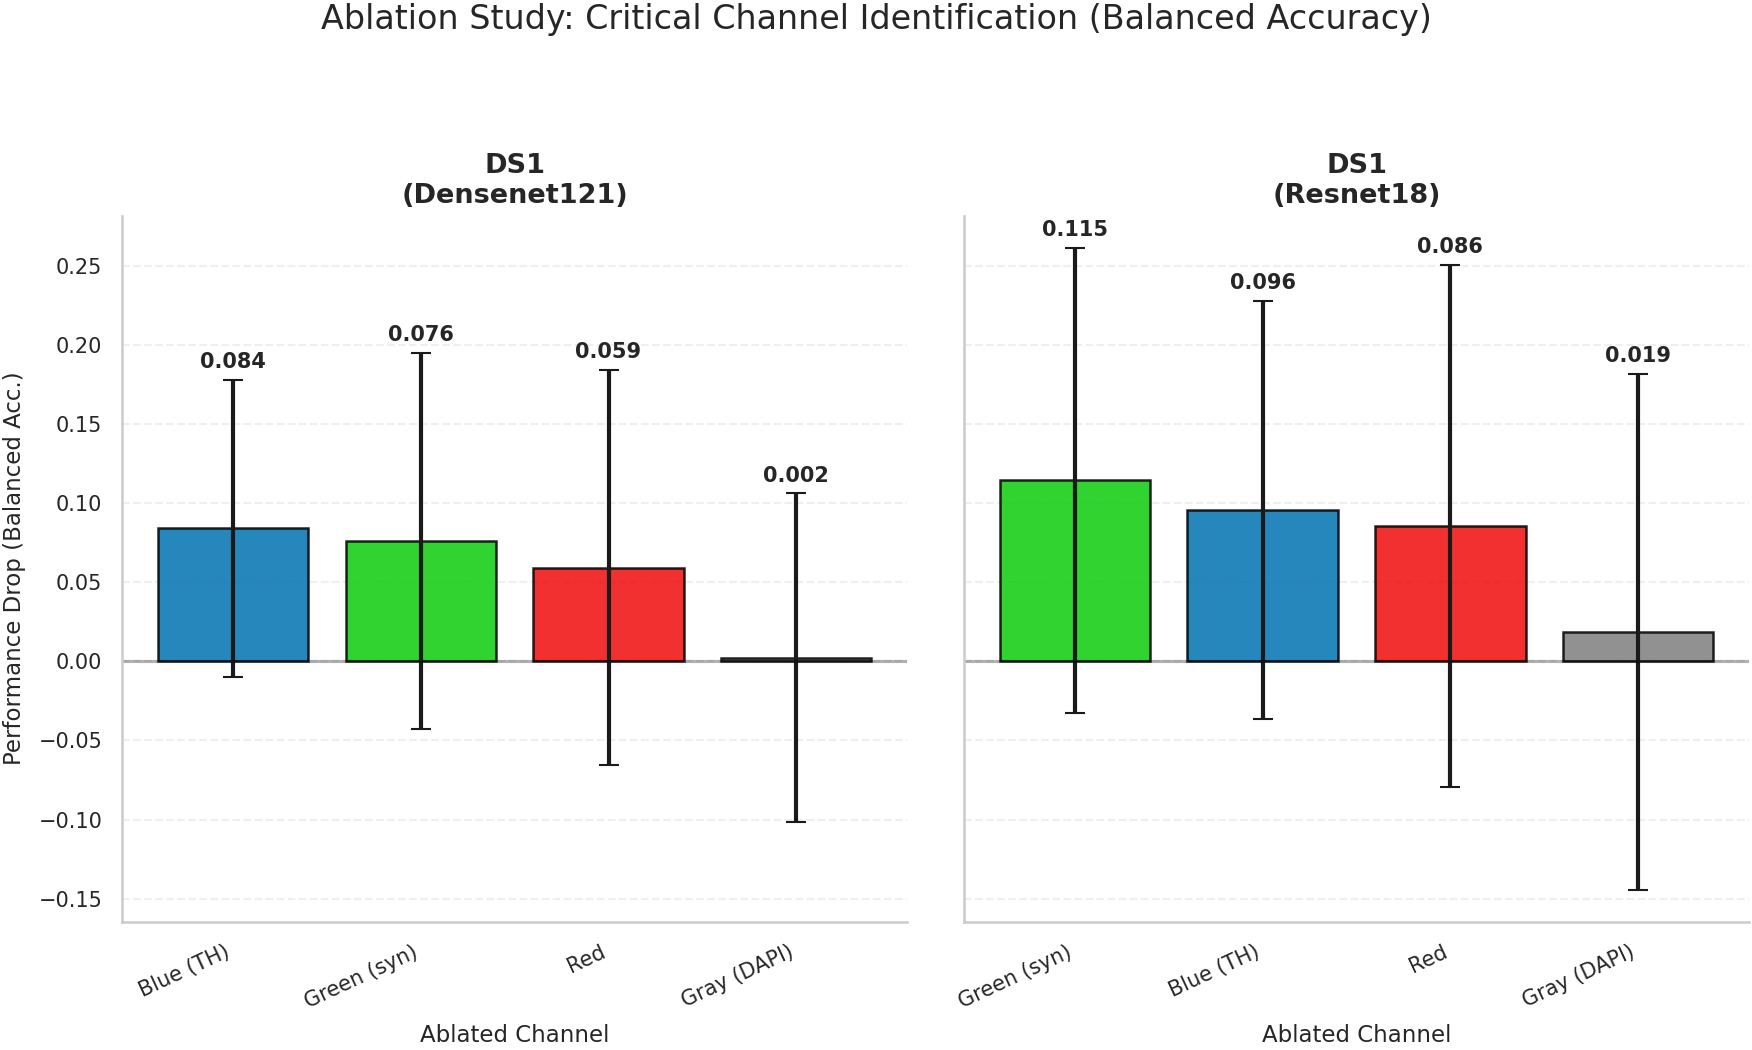

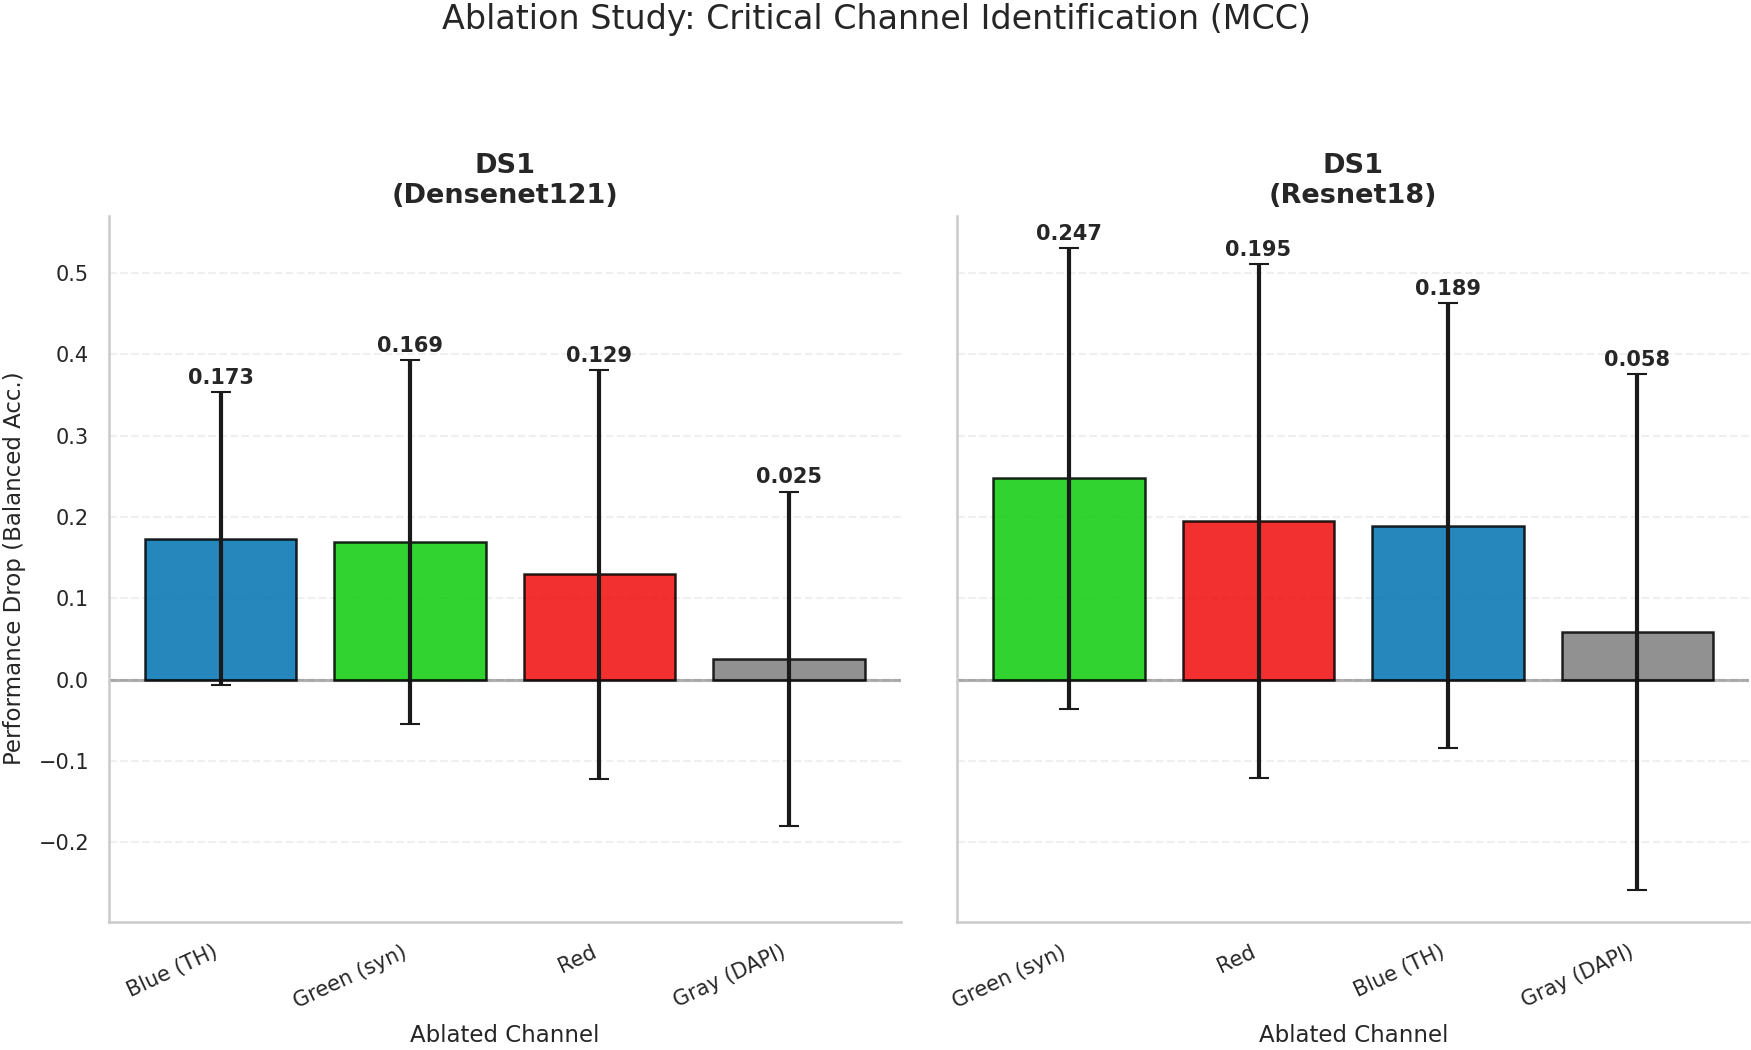

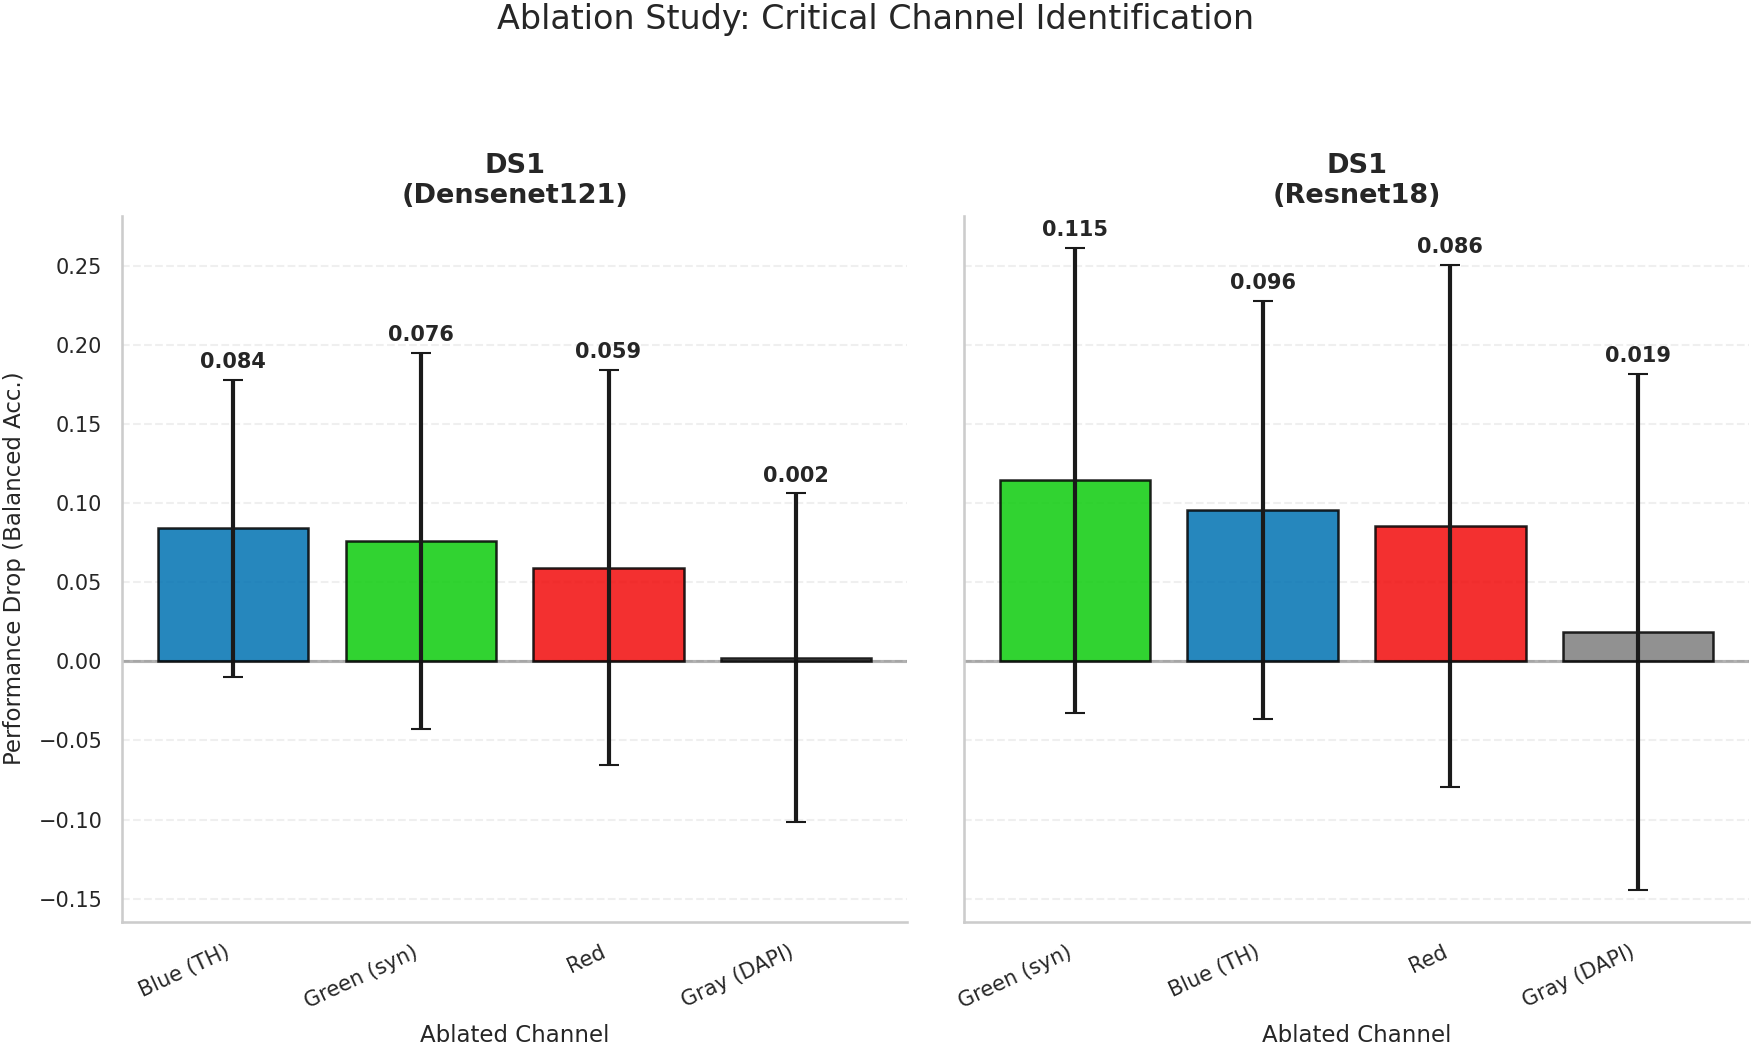

In [133]:
def plot_ablation_performance_drop(
    df: pd.DataFrame,
    baseline_metric: str = 'mean_test_balanced_acc',
    metric_std: str = 'std_test_balanced_acc',
    title: str = 'Channel Ablation Impact on Performance',
    filename: str = 'ablation_channel_impact.png',
    output_dir: str = 'images/ablation_studies'
) -> str:
    """
    Plot performance drop for each ablated channel compared to baseline.
    
    Scientific Rationale:
    - Shows which channels carry most diagnostic information *per model*.
    - Error bars indicate statistical significance of performance drop.
    - Colors match biomarker fluorophores for intuitive interpretation.
    
    CRITICAL: Channel indices refer to the POST-CONVERSION order from
    transformations_functions.py::from_GBR_to_RGB:
        Original disk order:  [G,  B,  Gr, R]  (indices 0,1,2,3)
        After conversion:     [R,  G,  B,  Gr] (indices 0,1,2,3)
        
    Therefore, ablation index mapping is:
    - 0 → Red (autofluorescence, from original index 3)
    - 1 → Green (α-synuclein, from original index 0)
    - 2 → Blue (DAPI/nuclei, from original index 1)
    - 3 → Granuphilin (far-red, from original index 2)
    """
    
    # Validate required columns
    required = ['ablated_channel', 'dataset', 'model_name', baseline_metric, metric_std]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    
    # Get baseline performance (no ablation)
    baseline_df = df[df['ablated_channel'].isna() | (df['ablated_channel'] == 'none')].copy()
    if baseline_df.empty:
        print("⚠ No baseline runs found (ablated_channel = 'none' or NaN)")
        return None
    
    baseline_perf = baseline_df.groupby(['dataset', 'model_name'])[baseline_metric].mean()
    if baseline_perf.empty:
        print("⚠ Baseline performance calculation resulted in empty Series.")
        return None
        
    # Calculate performance drop for ablated runs
    ablated_df = df[df['ablated_channel'].notna() & (df['ablated_channel'] != 'none')].copy()
    if ablated_df.empty:
        print("⚠ No ablation runs found")
        return None
    
    ablated_df['performance_drop'] = ablated_df.apply(
        lambda row: baseline_perf.get((row['dataset'], row['model_name']), np.nan) - row[baseline_metric],
        axis=1
    )
    
    if ablated_df['performance_drop'].isna().any():
        print("⚠ Warning: Some ablated runs did not find a matching baseline and were dropped.")
        ablated_df = ablated_df.dropna(subset=['performance_drop'])

    # Aggregate by dataset, model, and ablated channel
    plot_data = (
        ablated_df.groupby(['dataset', 'model_name', 'ablated_channel'])
        .agg({
            'performance_drop': 'mean',
            metric_std: 'max'
        })
        .reset_index()
    )
    
    # ═══════════════════════════════════════════════════════════════════════
    # CORRECTED CHANNEL MAPPING (matches post-RGB-conversion order)
    # ═══════════════════════════════════════════════════════════════════════
    CHANNEL_BIOMARKER_MAP = {
        # String keys (from MLflow logs)
        '0': 'Red',        # Post-conversion index 0
        '1': 'Green (syn)',           # Post-conversion index 1
        '2': 'Blue (TH)',                   # Post-conversion index 2
        '3': 'Gray (DAPI)',         # Post-conversion index 3
        # Numeric keys (for robustness)
        0: 'Red',
        1: 'Green (syn)',
        2: 'Blue (TH)',
        3: 'Gray (DAPI)',
    }
    
    # Convert ablated_channel to standard biomarker labels
    plot_data['ablated_channel'] = plot_data['ablated_channel'].map(
        lambda x: CHANNEL_BIOMARKER_MAP.get(str(x), CHANNEL_BIOMARKER_MAP.get(x, str(x)))
    )
    
    # ═══════════════════════════════════════════════════════════════════════
    # CORRECTED COLOR MAPPING (matches actual fluorophore wavelengths)
    # ═══════════════════════════════════════════════════════════════════════
    channel_colors = {
        'Red': "#F10B0B",  
        'Green (syn)': "#0DCC0D",      
        'Blue (TH)': "#0072B2",             
        'Gray (DAPI)': "#7E7E7E",    
    }
    
    # Create figure with (dataset, model)-wise facets
    plot_groups = list(plot_data.groupby(['dataset', 'model_name']))
    n_groups = len(plot_groups)
    
    if n_groups == 0:
        print("⚠ No data to plot after aggregation.")
        return None
    
    fig, axes = plt.subplots(1, n_groups, figsize=(6 * n_groups, 7), sharey=True)
    if n_groups == 1:
        axes = [axes]
    
    for i, (ax, ((dataset, model_name), subset)) in enumerate(zip(axes, plot_groups)):
        
        # Sort by performance drop (most critical channel first)
        subset = subset.sort_values('performance_drop', ascending=False)
        
        x_pos = np.arange(len(subset))
        colors = [channel_colors.get(ch, sm.palette[7]) for ch in subset['ablated_channel']]
        
        # Bar plot with error bars
        bars = ax.bar(
            x_pos,
            subset['performance_drop'],
            yerr=subset[metric_std],
            capsize=5,
            color=colors,
            alpha=0.85,
            edgecolor='black',
            linewidth=1.2
        )
        
        # Annotations (value labels on bars)
        for j, (bar, drop, std) in enumerate(zip(bars, subset['performance_drop'], subset[metric_std])):
            height = bar.get_height()
            text_y = height + (std if np.isfinite(std) else 0) + 0.005
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                text_y,
                f'{drop:.3f}',
                ha='center',
                va='bottom',
                fontsize=10,
                fontweight='bold'
            )
        
        # Styling
        ax.set_title(f'{dataset}\n({model_name})', fontsize=13, fontweight='bold')
        
        if i == 0:
            ax.set_ylabel('Performance Drop (Balanced Acc.)', fontsize=11)
            
        ax.set_xlabel('Ablated Channel', fontsize=11)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(subset['ablated_channel'], rotation=25, ha='right')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.axhline(0, color='black', linewidth=1.5, linestyle='-', alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    fig.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    sm.savefig(output_path)
    
    print(f"✓ Ablation plot saved: {output_path}")
    print(f"  Groups plotted: {n_groups}")
    
    return output_path


# ════════════════════════════ GENERATE PLOTS ════════════════════════════════
if not results_df.empty:
    # Plot 1: Channel-wise impact on balanced accuracy
    plot_ablation_performance_drop(
        df=results_df,
        baseline_metric='mean_test_balanced_acc',
        metric_std='std_test_balanced_acc',
        title='Ablation Study: Critical Channel Identification (Balanced Accuracy)',
        filename='ablation_channel_impact_bal_acc.png'
    )
    
    # Plot 2: Channel-wise impact on MCC (optional)
    plot_ablation_performance_drop(
        df=results_df,
        baseline_metric='mean_test_mcc',
        metric_std='std_test_mcc',
        title='Ablation Study: Critical Channel Identification (MCC)',
        filename='ablation_channel_impact_mcc.png'
    )
else:
    print("⚠ results_df is empty, cannot generate ablation plots")

# ================================ GENERATE PLOTS =======================================
if not results_df.empty:
    # Plot 1: Channel-wise impact
    plot_ablation_performance_drop(
        df=results_df,
        title='Ablation Study: Critical Channel Identification'
    )